## BE UNet 
> Victor Ludvig, February 2024 <br>
> Prof. L. Chen

In [1]:
import torch 
import torch.nn as nn
from torch.nn import BCELoss
from torch.optim import Adam
import torchvision
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from torchvision.transforms import ToTensor, Resize, Compose
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt 
from torch.optim.lr_scheduler import MultiplicativeLR
PATH_ROOT = './competition_data/competition_data/train'
PATH_IMAGES = os.path.join(PATH_ROOT, 'images')
PATH_MASKS = os.path.join(PATH_ROOT, 'masks')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib widget

### Implementatin of UNet

#### Computation of the transpose convolution parameters
> The transpose convolution layers upsample the image by doubling its width and height. <br>
> The downsampling is achieved using a MaxPool2D layer in the encoder with kernel k=2, stride s=2 and padding p=0. <br>
> To upsample with PyTorch, we can simply use the same parameters for the TransposeConvolution: k=2, s=2, p=0. <br>
> The stride s=2 adds one 0 between each pixel, so the convolution with a kernel of size 2 will effectively double the image width and height. <br>

> This result can be checked using the formula from the [Pytorch website](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html):
$\begin{equation} H_{out}​=(H_{in}​−1)×stride−2×padding+dilation×(kernel\_size−1)+output\_padding+1 \end{equation}$

> With : 
>> $H_{out}​=2H_{in}$ <br>
>> $stride=2$ <br>
>> $dilation = 1$ <br>
>> $kernel\_size = 2$ <br>
>> $output\_padding = 0$

In [2]:
class UNet(nn.Module):
    def __init__(self):
        # Super constructor
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'), 
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # Decoder 
        
        self.transpose_conv1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.transpose_conv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.transpose_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)

        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.transpose_conv4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2)

        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.conv10 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1)
        

    def forward(self, images):
        # Encoder

        c1 = self.conv1(images)
        p1 = self.pool1(c1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.conv3(p2)
        p3 = self.pool3(c3)

        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        c5 = self.conv5(p4)

        # Decoder 

        u6 = self.transpose_conv1(c5)
        u6 = torch.cat((u6, c4), dim=1) # first dim is batch dimension, second (1) is the channel

        c6 = self.conv6(u6)
        u7 = self.transpose_conv2(c6)
        u7 = torch.cat((u7, c3), dim=1)

        c7 = self.conv7(u7)
        u8 = self.transpose_conv3(c7)
        u8 = torch.cat((u8, c2), dim=1)

        c8 = self.conv8(u8)
        u9 = self.transpose_conv4(c8)
        u9 = torch.cat((u9, c1), dim=1)

        c9 = self.conv9(u9)
        
        return torch.sigmoid(self.conv10(c9))

In [7]:
UNet = UNet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
UNet.to(device)

UNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_siz

#### Training

> The learning rate will be divided by 10 when 5 consecutive epochs don't improve the validation loss <br>
> It works very well, and the threshold could be increased to 15 epochs without improvement.

> Creation of custom Dataset class to load data <br>
> Some images are loaded by Pillow with an alpha channel with all values to 255. <br>
The alpha channel is discarded using im = im.convert("RGB")<br>

In [9]:
class ImageDataset(Dataset):

    def __init__(self, list_images, list_masks, transform=None):
        self.list_images = list_images
        self.list_masks = list_masks
        
        self.transform = transform

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        img_path = self.list_images[idx]
        with Image.open(img_path) as im:
            im = im.convert("RGB")
            if self.transform:
                im = self.transform(im)

        mask_path = self.list_masks[idx]
        with Image.open(mask_path) as im_mask:
            im_mask = im_mask.convert('L')
            if self.transform:
                im_mask = self.transform(im_mask)

        return im, im_mask

#### Divide train/val

> The train images are divided into train/val images <br>
> 20% of the images are used as validation images

In [6]:
list_images = [os.path.join(PATH_IMAGES,x) for x in os.listdir(PATH_IMAGES)]
list_masks = [os.path.join(PATH_MASKS,x) for x in os.listdir(PATH_MASKS)]
path_train_images, path_val_images, path_train_masks, path_val_masks = train_test_split(list_images, list_masks, test_size=0.2, random_state=0)

assert len(path_train_images) == len(path_train_masks)
print(f'Number of training images: {len(path_train_images)}')
print(f'Number of validation images: {len(path_val_images)}')

Number of training images: 3200
Number of validation images: 800


In [5]:
def get_hyperparameters(model):
    """"Get hyperparameters"""
    N_EPOCHS = 200
    LR = 0.0001
    BATCH_SIZE = 32
    optimizer = Adam(model.parameters(), lr=LR)
    scheduler = MultiplicativeLR(optimizer, lr_lambda=lambda epoch: .1)
    criterion = BCELoss()
    return N_EPOCHS, LR, BATCH_SIZE, optimizer, scheduler, criterion

def get_data_loader(path_train_images, path_train_masks, path_val_images, path_val_masks, BATCH_SIZE):
    """ Get data loader. """
    train_dataset = ImageDataset(path_train_images, path_train_masks, Compose([ToTensor(), Resize((128,128))]))
    val_dataset = ImageDataset(path_val_images, path_val_masks, Compose([ToTensor(), Resize((128,128))]))

    train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            num_workers=0)

    val_data_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            num_workers=0)

    dataloaders = {'train': train_data_loader,
                'val': val_data_loader}
    
    dataset_sizes = {'train': len(path_train_images),
                     'val': len(path_val_images)}
    
    return dataloaders, dataset_sizes

In [ ]:
N_EPOCHS, LR, BATCH_SIZE, optimizer, scheduler, criterion = get_hyperparameters(UNet)
dataloaders, dataset_sizes = get_data_loader(path_train_images, path_train_masks, path_val_images, path_val_masks, BATCH_SIZE)

In [8]:
def train(model, optimizer, criterion, dataloaders, N_EPOCHS, scheduler):
    train_losses = []
    val_losses = []
    best_val_loss = 1e10
    best_model_weights = copy.deepcopy(model.state_dict())
    # threshold of consecutive epochs without improvement to know when to update the learning rate
    threshold_lr = 0
    threshold_stop = 0

    for epoch in tqdm(range(N_EPOCHS)):
        print(f'\n\nEpoch {epoch}/{N_EPOCHS}')
        print('-'*10)

        for phase in ['train', 'val']:
            print(f'Phase: {phase}')
            if phase == 'train':
                model.train()
            else: 
                model.eval()

            running_loss = 0.0

            for inputs, masks in dataloaders[phase]:
                inputs = inputs.to(device)
                masks = masks.to(device)


                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step() 

                    running_loss += loss.item() * inputs.size(0)

            average_epoch_loss = running_loss / dataset_sizes[phase]

            print(f'Average {phase} loss: {average_epoch_loss:.4f}')

            if phase == 'val':
                val_losses.append(average_epoch_loss)
                if average_epoch_loss < best_val_loss:
                    best_val_loss = average_epoch_loss
                    best_model_weights = copy.deepcopy(model.state_dict())
                    threshold_lr = 0
                    threshold_stop = 0
                else:
                    threshold_lr += 1
                    threshold_stop += 1 
                if threshold_lr >= 10:
                    scheduler.step()
                    threshold_lr = 0
                    threshold_stop += 1  
                print(f'threshold_lr: {threshold_lr}')
            else:
                train_losses.append(average_epoch_loss)

            # early stopping in 20 epochs without improvement
            if threshold_stop >= 20:
                return model, train_losses, val_losses  

            
    model.load_state_dict(best_model_weights)
    return model, train_losses, val_losses  

In [81]:
trained_unet, train_losses, val_losses = train(UNet, optimizer, criterion, dataloaders, N_EPOCHS, scheduler)

  0%|          | 0/200 [00:00<?, ?it/s]

/home/hacklexander/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(




Epoch 0/200
----------
Phase: train
Average train loss: 0.5875
threshold_lr: 0
Phase: val


  0%|          | 1/200 [00:05<16:57,  5.11s/it]

Average val loss: 0.4282
threshold_lr: 0


Epoch 1/200
----------
Phase: train
Average train loss: 0.5360
threshold_lr: 0
Phase: val


  1%|          | 2/200 [00:10<17:37,  5.34s/it]

Average val loss: 0.5098
threshold_lr: 1


Epoch 2/200
----------
Phase: train
Average train loss: 0.4707
threshold_lr: 1
Phase: val


  2%|▏         | 3/200 [00:15<16:45,  5.11s/it]

Average val loss: 0.4496
threshold_lr: 2


Epoch 3/200
----------
Phase: train
Average train loss: 0.4614
threshold_lr: 2
Phase: val


  2%|▏         | 4/200 [00:20<16:56,  5.19s/it]

Average val loss: 0.4230
threshold_lr: 0


Epoch 4/200
----------
Phase: train
Average train loss: 0.4383
threshold_lr: 0
Phase: val


  2%|▎         | 5/200 [00:25<16:30,  5.08s/it]

Average val loss: 0.3808
threshold_lr: 0


Epoch 5/200
----------
Phase: train
Average train loss: 0.4267
threshold_lr: 0
Phase: val


  3%|▎         | 6/200 [00:30<15:55,  4.93s/it]

Average val loss: 0.3915
threshold_lr: 1


Epoch 6/200
----------
Phase: train
Average train loss: 0.4004
threshold_lr: 1
Phase: val


  4%|▎         | 7/200 [00:35<16:02,  4.98s/it]

Average val loss: 0.3625
threshold_lr: 0


Epoch 7/200
----------
Phase: train
Average train loss: 0.3809
threshold_lr: 0
Phase: val


  4%|▍         | 8/200 [00:40<16:02,  5.01s/it]

Average val loss: 0.3675
threshold_lr: 1


Epoch 8/200
----------
Phase: train
Average train loss: 0.3730
threshold_lr: 1
Phase: val


  4%|▍         | 9/200 [00:45<15:49,  4.97s/it]

Average val loss: 0.3315
threshold_lr: 0


Epoch 9/200
----------
Phase: train
Average train loss: 0.3628
threshold_lr: 0
Phase: val


  5%|▌         | 10/200 [00:50<15:39,  4.94s/it]

Average val loss: 0.3508
threshold_lr: 1


Epoch 10/200
----------
Phase: train
Average train loss: 0.3571
threshold_lr: 1
Phase: val


  6%|▌         | 11/200 [00:55<15:37,  4.96s/it]

Average val loss: 0.3302
threshold_lr: 0


Epoch 11/200
----------
Phase: train
Average train loss: 0.3484
threshold_lr: 0
Phase: val


  6%|▌         | 12/200 [01:00<16:03,  5.13s/it]

Average val loss: 0.3212
threshold_lr: 0


Epoch 12/200
----------
Phase: train
Average train loss: 0.3386
threshold_lr: 0
Phase: val


  6%|▋         | 13/200 [01:06<16:16,  5.22s/it]

Average val loss: 0.3014
threshold_lr: 0


Epoch 13/200
----------
Phase: train
Average train loss: 0.3256
threshold_lr: 0
Phase: val


  7%|▋         | 14/200 [01:11<16:18,  5.26s/it]

Average val loss: 0.3047
threshold_lr: 1


Epoch 14/200
----------
Phase: train
Average train loss: 0.3181
threshold_lr: 1
Phase: val


  8%|▊         | 15/200 [01:16<15:56,  5.17s/it]

Average val loss: 0.2942
threshold_lr: 0


Epoch 15/200
----------
Phase: train
Average train loss: 0.3067
threshold_lr: 0
Phase: val


  8%|▊         | 16/200 [01:21<15:47,  5.15s/it]

Average val loss: 0.2939
threshold_lr: 0


Epoch 16/200
----------
Phase: train
Average train loss: 0.3042
threshold_lr: 0
Phase: val


  8%|▊         | 17/200 [01:26<15:44,  5.16s/it]

Average val loss: 0.2759
threshold_lr: 0


Epoch 17/200
----------
Phase: train
Average train loss: 0.2967
threshold_lr: 0
Phase: val


  9%|▉         | 18/200 [01:31<15:30,  5.11s/it]

Average val loss: 0.2691
threshold_lr: 0


Epoch 18/200
----------
Phase: train
Average train loss: 0.2915
threshold_lr: 0
Phase: val


 10%|▉         | 19/200 [01:36<15:18,  5.07s/it]

Average val loss: 0.2693
threshold_lr: 1


Epoch 19/200
----------
Phase: train
Average train loss: 0.2904
threshold_lr: 1
Phase: val


 10%|█         | 20/200 [01:41<14:56,  4.98s/it]

Average val loss: 0.2589
threshold_lr: 0


Epoch 20/200
----------
Phase: train
Average train loss: 0.2890
threshold_lr: 0
Phase: val


 10%|█         | 21/200 [01:46<14:46,  4.96s/it]

Average val loss: 0.2540
threshold_lr: 0


Epoch 21/200
----------
Phase: train
Average train loss: 0.2823
threshold_lr: 0
Phase: val


 11%|█         | 22/200 [01:51<14:40,  4.94s/it]

Average val loss: 0.2529
threshold_lr: 0


Epoch 22/200
----------
Phase: train
Average train loss: 0.2806
threshold_lr: 0
Phase: val


 12%|█▏        | 23/200 [01:56<14:33,  4.94s/it]

Average val loss: 0.2571
threshold_lr: 1


Epoch 23/200
----------
Phase: train
Average train loss: 0.2813
threshold_lr: 1
Phase: val


 12%|█▏        | 24/200 [02:01<14:22,  4.90s/it]

Average val loss: 0.2443
threshold_lr: 0


Epoch 24/200
----------
Phase: train
Average train loss: 0.2750
threshold_lr: 0
Phase: val


 12%|█▎        | 25/200 [02:06<14:27,  4.96s/it]

Average val loss: 0.2426
threshold_lr: 0


Epoch 25/200
----------
Phase: train
Average train loss: 0.2748
threshold_lr: 0
Phase: val


 13%|█▎        | 26/200 [02:11<14:30,  5.00s/it]

Average val loss: 0.2561
threshold_lr: 1


Epoch 26/200
----------
Phase: train
Average train loss: 0.2783
threshold_lr: 1
Phase: val


 14%|█▎        | 27/200 [02:16<14:19,  4.97s/it]

Average val loss: 0.2442
threshold_lr: 2


Epoch 27/200
----------
Phase: train
Average train loss: 0.2731
threshold_lr: 2
Phase: val


 14%|█▍        | 28/200 [02:21<14:18,  4.99s/it]

Average val loss: 0.2431
threshold_lr: 3


Epoch 28/200
----------
Phase: train
Average train loss: 0.2657
threshold_lr: 3
Phase: val


 14%|█▍        | 29/200 [02:26<14:12,  4.98s/it]

Average val loss: 0.2508
threshold_lr: 4


Epoch 29/200
----------
Phase: train
Average train loss: 0.2718
threshold_lr: 4
Phase: val


 15%|█▌        | 30/200 [02:31<14:27,  5.10s/it]

Average val loss: 0.2474
threshold_lr: 5


Epoch 30/200
----------
Phase: train
Average train loss: 0.2634
threshold_lr: 5
Phase: val


 16%|█▌        | 31/200 [02:36<14:11,  5.04s/it]

Average val loss: 0.2382
threshold_lr: 0


Epoch 31/200
----------
Phase: train
Average train loss: 0.2640
threshold_lr: 0
Phase: val


 16%|█▌        | 32/200 [02:41<14:09,  5.06s/it]

Average val loss: 0.2429
threshold_lr: 1


Epoch 32/200
----------
Phase: train
Average train loss: 0.2619
threshold_lr: 1
Phase: val


 16%|█▋        | 33/200 [02:46<14:05,  5.06s/it]

Average val loss: 0.2376
threshold_lr: 0


Epoch 33/200
----------
Phase: train
Average train loss: 0.2598
threshold_lr: 0
Phase: val


 17%|█▋        | 34/200 [02:51<14:01,  5.07s/it]

Average val loss: 0.2394
threshold_lr: 1


Epoch 34/200
----------
Phase: train
Average train loss: 0.2652
threshold_lr: 1
Phase: val


 18%|█▊        | 35/200 [02:56<13:56,  5.07s/it]

Average val loss: 0.2366
threshold_lr: 0


Epoch 35/200
----------
Phase: train
Average train loss: 0.2642
threshold_lr: 0
Phase: val


 18%|█▊        | 36/200 [03:01<13:44,  5.03s/it]

Average val loss: 0.2312
threshold_lr: 0


Epoch 36/200
----------
Phase: train
Average train loss: 0.2538
threshold_lr: 0
Phase: val


 18%|█▊        | 37/200 [03:06<13:28,  4.96s/it]

Average val loss: 0.2302
threshold_lr: 0


Epoch 37/200
----------
Phase: train
Average train loss: 0.2562
threshold_lr: 0
Phase: val


 19%|█▉        | 38/200 [03:11<13:17,  4.92s/it]

Average val loss: 0.2319
threshold_lr: 1


Epoch 38/200
----------
Phase: train
Average train loss: 0.2564
threshold_lr: 1
Phase: val


 20%|█▉        | 39/200 [03:16<13:19,  4.97s/it]

Average val loss: 0.2287
threshold_lr: 0


Epoch 39/200
----------
Phase: train
Average train loss: 0.2554
threshold_lr: 0
Phase: val


 20%|██        | 40/200 [03:21<13:32,  5.08s/it]

Average val loss: 0.2274
threshold_lr: 0


Epoch 40/200
----------
Phase: train
Average train loss: 0.2458
threshold_lr: 0
Phase: val


 20%|██        | 41/200 [03:27<13:40,  5.16s/it]

Average val loss: 0.2253
threshold_lr: 0


Epoch 41/200
----------
Phase: train
Average train loss: 0.2517
threshold_lr: 0
Phase: val


 21%|██        | 42/200 [03:31<13:21,  5.07s/it]

Average val loss: 0.2207
threshold_lr: 0


Epoch 42/200
----------
Phase: train
Average train loss: 0.2426
threshold_lr: 0
Phase: val


 22%|██▏       | 43/200 [03:37<13:39,  5.22s/it]

Average val loss: 0.2176
threshold_lr: 0


Epoch 43/200
----------
Phase: train
Average train loss: 0.2434
threshold_lr: 0
Phase: val


 22%|██▏       | 44/200 [03:42<13:35,  5.23s/it]

Average val loss: 0.2171
threshold_lr: 0


Epoch 44/200
----------
Phase: train
Average train loss: 0.2476
threshold_lr: 0
Phase: val


 22%|██▎       | 45/200 [03:47<13:16,  5.14s/it]

Average val loss: 0.2191
threshold_lr: 1


Epoch 45/200
----------
Phase: train
Average train loss: 0.2440
threshold_lr: 1
Phase: val


 23%|██▎       | 46/200 [03:52<12:50,  5.01s/it]

Average val loss: 0.2158
threshold_lr: 0


Epoch 46/200
----------
Phase: train
Average train loss: 0.2418
threshold_lr: 0
Phase: val


 24%|██▎       | 47/200 [03:57<12:37,  4.95s/it]

Average val loss: 0.2173
threshold_lr: 1


Epoch 47/200
----------
Phase: train
Average train loss: 0.2410
threshold_lr: 1
Phase: val


 24%|██▍       | 48/200 [04:02<12:48,  5.06s/it]

Average val loss: 0.2164
threshold_lr: 2


Epoch 48/200
----------
Phase: train
Average train loss: 0.2407
threshold_lr: 2
Phase: val


 24%|██▍       | 49/200 [04:07<12:38,  5.02s/it]

Average val loss: 0.2112
threshold_lr: 0


Epoch 49/200
----------
Phase: train
Average train loss: 0.2344
threshold_lr: 0
Phase: val


 25%|██▌       | 50/200 [04:12<12:47,  5.11s/it]

Average val loss: 0.2115
threshold_lr: 1


Epoch 50/200
----------
Phase: train
Average train loss: 0.2355
threshold_lr: 1
Phase: val


 26%|██▌       | 51/200 [04:18<12:54,  5.20s/it]

Average val loss: 0.2110
threshold_lr: 0


Epoch 51/200
----------
Phase: train
Average train loss: 0.2291
threshold_lr: 0
Phase: val


 26%|██▌       | 52/200 [04:23<12:51,  5.21s/it]

Average val loss: 0.2090
threshold_lr: 0


Epoch 52/200
----------
Phase: train
Average train loss: 0.2345
threshold_lr: 0
Phase: val


 26%|██▋       | 53/200 [04:28<12:41,  5.18s/it]

Average val loss: 0.2072
threshold_lr: 0


Epoch 53/200
----------
Phase: train
Average train loss: 0.2282
threshold_lr: 0
Phase: val


 27%|██▋       | 54/200 [04:33<12:25,  5.11s/it]

Average val loss: 0.2081
threshold_lr: 1


Epoch 54/200
----------
Phase: train
Average train loss: 0.2320
threshold_lr: 1
Phase: val


 28%|██▊       | 55/200 [04:38<12:28,  5.16s/it]

Average val loss: 0.2091
threshold_lr: 2


Epoch 55/200
----------
Phase: train
Average train loss: 0.2215
threshold_lr: 2
Phase: val


 28%|██▊       | 56/200 [04:43<12:21,  5.15s/it]

Average val loss: 0.2011
threshold_lr: 0


Epoch 56/200
----------
Phase: train
Average train loss: 0.2268
threshold_lr: 0
Phase: val


 28%|██▊       | 57/200 [04:48<12:04,  5.07s/it]

Average val loss: 0.2011
threshold_lr: 1


Epoch 57/200
----------
Phase: train
Average train loss: 0.2270
threshold_lr: 1
Phase: val


 29%|██▉       | 58/200 [04:53<11:58,  5.06s/it]

Average val loss: 0.2126
threshold_lr: 2


Epoch 58/200
----------
Phase: train
Average train loss: 0.2254
threshold_lr: 2
Phase: val


 30%|██▉       | 59/200 [04:59<12:03,  5.13s/it]

Average val loss: 0.2035
threshold_lr: 3


Epoch 59/200
----------
Phase: train
Average train loss: 0.2254
threshold_lr: 3
Phase: val


 30%|███       | 60/200 [05:04<12:03,  5.17s/it]

Average val loss: 0.2204
threshold_lr: 4


Epoch 60/200
----------
Phase: train
Average train loss: 0.2198
threshold_lr: 4
Phase: val


 30%|███       | 61/200 [05:09<11:45,  5.08s/it]

Average val loss: 0.2060
threshold_lr: 5


Epoch 61/200
----------
Phase: train
Average train loss: 0.2317
threshold_lr: 5
Phase: val


 31%|███       | 62/200 [05:14<11:51,  5.16s/it]

Average val loss: 0.2210
threshold_lr: 6


Epoch 62/200
----------
Phase: train
Average train loss: 0.2231
threshold_lr: 6
Phase: val


 32%|███▏      | 63/200 [05:19<11:35,  5.08s/it]

Average val loss: 0.1980
threshold_lr: 0


Epoch 63/200
----------
Phase: train
Average train loss: 0.2252
threshold_lr: 0
Phase: val


 32%|███▏      | 64/200 [05:24<11:34,  5.11s/it]

Average val loss: 0.2123
threshold_lr: 1


Epoch 64/200
----------
Phase: train
Average train loss: 0.2183
threshold_lr: 1
Phase: val


 32%|███▎      | 65/200 [05:29<11:16,  5.01s/it]

Average val loss: 0.2105
threshold_lr: 2


Epoch 65/200
----------
Phase: train
Average train loss: 0.2182
threshold_lr: 2
Phase: val


 33%|███▎      | 66/200 [05:34<11:03,  4.95s/it]

Average val loss: 0.2203
threshold_lr: 3


Epoch 66/200
----------
Phase: train
Average train loss: 0.2232
threshold_lr: 3
Phase: val


 34%|███▎      | 67/200 [05:39<11:09,  5.03s/it]

Average val loss: 0.2036
threshold_lr: 4


Epoch 67/200
----------
Phase: train
Average train loss: 0.2168
threshold_lr: 4
Phase: val


 34%|███▍      | 68/200 [05:44<10:58,  4.99s/it]

Average val loss: 0.2035
threshold_lr: 5


Epoch 68/200
----------
Phase: train
Average train loss: 0.2251
threshold_lr: 5
Phase: val


 34%|███▍      | 69/200 [05:49<10:57,  5.02s/it]

Average val loss: 0.2068
threshold_lr: 6


Epoch 69/200
----------
Phase: train
Average train loss: 0.2163
threshold_lr: 6
Phase: val


 35%|███▌      | 70/200 [05:54<10:46,  4.97s/it]

Average val loss: 0.1954
threshold_lr: 0


Epoch 70/200
----------
Phase: train
Average train loss: 0.2153
threshold_lr: 0
Phase: val


 36%|███▌      | 71/200 [05:58<10:28,  4.87s/it]

Average val loss: 0.2109
threshold_lr: 1


Epoch 71/200
----------
Phase: train
Average train loss: 0.2239
threshold_lr: 1
Phase: val


 36%|███▌      | 72/200 [06:03<10:17,  4.82s/it]

Average val loss: 0.2006
threshold_lr: 2


Epoch 72/200
----------
Phase: train
Average train loss: 0.2117
threshold_lr: 2
Phase: val


 36%|███▋      | 73/200 [06:08<10:17,  4.86s/it]

Average val loss: 0.1914
threshold_lr: 0


Epoch 73/200
----------
Phase: train
Average train loss: 0.2135
threshold_lr: 0
Phase: val


 37%|███▋      | 74/200 [06:14<10:42,  5.10s/it]

Average val loss: 0.2030
threshold_lr: 1


Epoch 74/200
----------
Phase: train
Average train loss: 0.2220
threshold_lr: 1
Phase: val


 38%|███▊      | 75/200 [06:19<10:47,  5.18s/it]

Average val loss: 0.2029
threshold_lr: 2


Epoch 75/200
----------
Phase: train
Average train loss: 0.2108
threshold_lr: 2
Phase: val


 38%|███▊      | 76/200 [06:24<10:42,  5.18s/it]

Average val loss: 0.1945
threshold_lr: 3


Epoch 76/200
----------
Phase: train
Average train loss: 0.2113
threshold_lr: 3
Phase: val


 38%|███▊      | 77/200 [06:30<10:55,  5.33s/it]

Average val loss: 0.2048
threshold_lr: 4


Epoch 77/200
----------
Phase: train
Average train loss: 0.2125
threshold_lr: 4
Phase: val


 39%|███▉      | 78/200 [06:35<10:33,  5.19s/it]

Average val loss: 0.2023
threshold_lr: 5


Epoch 78/200
----------
Phase: train
Average train loss: 0.2116
threshold_lr: 5
Phase: val


 40%|███▉      | 79/200 [06:40<10:30,  5.21s/it]

Average val loss: 0.1957
threshold_lr: 6


Epoch 79/200
----------
Phase: train
Average train loss: 0.2076
threshold_lr: 6
Phase: val


 40%|████      | 80/200 [06:45<10:10,  5.09s/it]

Average val loss: 0.1923
threshold_lr: 7


Epoch 80/200
----------
Phase: train
Average train loss: 0.2099
threshold_lr: 7
Phase: val


 40%|████      | 81/200 [06:50<09:52,  4.98s/it]

Average val loss: 0.1925
threshold_lr: 8


Epoch 81/200
----------
Phase: train
Average train loss: 0.2024
threshold_lr: 8
Phase: val


 41%|████      | 82/200 [06:54<09:43,  4.95s/it]

Average val loss: 0.1875
threshold_lr: 0


Epoch 82/200
----------
Phase: train
Average train loss: 0.2099
threshold_lr: 0
Phase: val


 42%|████▏     | 83/200 [06:59<09:38,  4.95s/it]

Average val loss: 0.1973
threshold_lr: 1


Epoch 83/200
----------
Phase: train
Average train loss: 0.2041
threshold_lr: 1
Phase: val


 42%|████▏     | 84/200 [07:04<09:27,  4.89s/it]

Average val loss: 0.1946
threshold_lr: 2


Epoch 84/200
----------
Phase: train
Average train loss: 0.2000
threshold_lr: 2
Phase: val


 42%|████▎     | 85/200 [07:10<09:39,  5.04s/it]

Average val loss: 0.1899
threshold_lr: 3


Epoch 85/200
----------
Phase: train
Average train loss: 0.2034
threshold_lr: 3
Phase: val


 43%|████▎     | 86/200 [07:15<09:31,  5.01s/it]

Average val loss: 0.2010
threshold_lr: 4


Epoch 86/200
----------
Phase: train
Average train loss: 0.2080
threshold_lr: 4
Phase: val


 44%|████▎     | 87/200 [07:19<09:24,  4.99s/it]

Average val loss: 0.1957
threshold_lr: 5


Epoch 87/200
----------
Phase: train
Average train loss: 0.1994
threshold_lr: 5
Phase: val


 44%|████▍     | 88/200 [07:25<09:25,  5.05s/it]

Average val loss: 0.1804
threshold_lr: 0


Epoch 88/200
----------
Phase: train
Average train loss: 0.2002
threshold_lr: 0
Phase: val


 44%|████▍     | 89/200 [07:30<09:25,  5.09s/it]

Average val loss: 0.1874
threshold_lr: 1


Epoch 89/200
----------
Phase: train
Average train loss: 0.2012
threshold_lr: 1
Phase: val


 45%|████▌     | 90/200 [07:35<09:13,  5.03s/it]

Average val loss: 0.1843
threshold_lr: 2


Epoch 90/200
----------
Phase: train
Average train loss: 0.1976
threshold_lr: 2
Phase: val


 46%|████▌     | 91/200 [07:40<09:08,  5.04s/it]

Average val loss: 0.1795
threshold_lr: 0


Epoch 91/200
----------
Phase: train
Average train loss: 0.1944
threshold_lr: 0
Phase: val


 46%|████▌     | 92/200 [07:45<09:11,  5.11s/it]

Average val loss: 0.1878
threshold_lr: 1


Epoch 92/200
----------
Phase: train
Average train loss: 0.1990
threshold_lr: 1
Phase: val


 46%|████▋     | 93/200 [07:50<09:13,  5.18s/it]

Average val loss: 0.1882
threshold_lr: 2


Epoch 93/200
----------
Phase: train
Average train loss: 0.1928
threshold_lr: 2
Phase: val


 47%|████▋     | 94/200 [07:56<09:17,  5.26s/it]

Average val loss: 0.1922
threshold_lr: 3


Epoch 94/200
----------
Phase: train
Average train loss: 0.1959
threshold_lr: 3
Phase: val


 48%|████▊     | 95/200 [08:01<09:07,  5.21s/it]

Average val loss: 0.1982
threshold_lr: 4


Epoch 95/200
----------
Phase: train
Average train loss: 0.1969
threshold_lr: 4
Phase: val


 48%|████▊     | 96/200 [08:06<09:02,  5.22s/it]

Average val loss: 0.1873
threshold_lr: 5


Epoch 96/200
----------
Phase: train
Average train loss: 0.1861
threshold_lr: 5
Phase: val


 48%|████▊     | 97/200 [08:12<09:05,  5.30s/it]

Average val loss: 0.1767
threshold_lr: 0


Epoch 97/200
----------
Phase: train
Average train loss: 0.1902
threshold_lr: 0
Phase: val


 49%|████▉     | 98/200 [08:17<08:54,  5.24s/it]

Average val loss: 0.1809
threshold_lr: 1


Epoch 98/200
----------
Phase: train
Average train loss: 0.1997
threshold_lr: 1
Phase: val


 50%|████▉     | 99/200 [08:22<08:49,  5.25s/it]

Average val loss: 0.1827
threshold_lr: 2


Epoch 99/200
----------
Phase: train
Average train loss: 0.1924
threshold_lr: 2
Phase: val


 50%|█████     | 100/200 [08:27<08:49,  5.30s/it]

Average val loss: 0.1750
threshold_lr: 0


Epoch 100/200
----------
Phase: train
Average train loss: 0.1831
threshold_lr: 0
Phase: val


 50%|█████     | 101/200 [08:32<08:36,  5.22s/it]

Average val loss: 0.1769
threshold_lr: 1


Epoch 101/200
----------
Phase: train
Average train loss: 0.1886
threshold_lr: 1
Phase: val


 51%|█████     | 102/200 [08:38<08:27,  5.18s/it]

Average val loss: 0.1848
threshold_lr: 2


Epoch 102/200
----------
Phase: train
Average train loss: 0.1906
threshold_lr: 2
Phase: val


 52%|█████▏    | 103/200 [08:43<08:25,  5.21s/it]

Average val loss: 0.1816
threshold_lr: 3


Epoch 103/200
----------
Phase: train
Average train loss: 0.1879
threshold_lr: 3
Phase: val


 52%|█████▏    | 104/200 [08:48<08:22,  5.24s/it]

Average val loss: 0.1802
threshold_lr: 4


Epoch 104/200
----------
Phase: train
Average train loss: 0.1925
threshold_lr: 4
Phase: val


 52%|█████▎    | 105/200 [08:53<08:07,  5.13s/it]

Average val loss: 0.1790
threshold_lr: 5


Epoch 105/200
----------
Phase: train
Average train loss: 0.1852
threshold_lr: 5
Phase: val


 53%|█████▎    | 106/200 [08:58<08:05,  5.17s/it]

Average val loss: 0.1742
threshold_lr: 0


Epoch 106/200
----------
Phase: train
Average train loss: 0.1833
threshold_lr: 0
Phase: val


 54%|█████▎    | 107/200 [09:03<07:58,  5.14s/it]

Average val loss: 0.1782
threshold_lr: 1


Epoch 107/200
----------
Phase: train
Average train loss: 0.1869
threshold_lr: 1
Phase: val


 54%|█████▍    | 108/200 [09:08<07:51,  5.13s/it]

Average val loss: 0.1816
threshold_lr: 2


Epoch 108/200
----------
Phase: train
Average train loss: 0.1879
threshold_lr: 2
Phase: val


 55%|█████▍    | 109/200 [09:13<07:39,  5.05s/it]

Average val loss: 0.1730
threshold_lr: 0


Epoch 109/200
----------
Phase: train
Average train loss: 0.1806
threshold_lr: 0
Phase: val


 55%|█████▌    | 110/200 [09:18<07:30,  5.01s/it]

Average val loss: 0.1800
threshold_lr: 1


Epoch 110/200
----------
Phase: train
Average train loss: 0.1869
threshold_lr: 1
Phase: val


 56%|█████▌    | 111/200 [09:23<07:25,  5.00s/it]

Average val loss: 0.1801
threshold_lr: 2


Epoch 111/200
----------
Phase: train
Average train loss: 0.1787
threshold_lr: 2
Phase: val


 56%|█████▌    | 112/200 [09:28<07:16,  4.96s/it]

Average val loss: 0.1765
threshold_lr: 3


Epoch 112/200
----------
Phase: train
Average train loss: 0.1788
threshold_lr: 3
Phase: val


 56%|█████▋    | 113/200 [09:33<07:03,  4.86s/it]

Average val loss: 0.1767
threshold_lr: 4


Epoch 113/200
----------
Phase: train
Average train loss: 0.1808
threshold_lr: 4
Phase: val


 57%|█████▋    | 114/200 [09:38<07:02,  4.92s/it]

Average val loss: 0.1726
threshold_lr: 0


Epoch 114/200
----------
Phase: train
Average train loss: 0.1748
threshold_lr: 0
Phase: val


 57%|█████▊    | 115/200 [09:43<07:05,  5.01s/it]

Average val loss: 0.1724
threshold_lr: 0


Epoch 115/200
----------
Phase: train
Average train loss: 0.1797
threshold_lr: 0
Phase: val


 58%|█████▊    | 116/200 [09:48<06:54,  4.93s/it]

Average val loss: 0.1814
threshold_lr: 1


Epoch 116/200
----------
Phase: train
Average train loss: 0.1814
threshold_lr: 1
Phase: val


 58%|█████▊    | 117/200 [09:53<06:49,  4.93s/it]

Average val loss: 0.1707
threshold_lr: 0


Epoch 117/200
----------
Phase: train
Average train loss: 0.1726
threshold_lr: 0
Phase: val


 59%|█████▉    | 118/200 [09:58<06:47,  4.96s/it]

Average val loss: 0.1712
threshold_lr: 1


Epoch 118/200
----------
Phase: train
Average train loss: 0.1790
threshold_lr: 1
Phase: val


 60%|█████▉    | 119/200 [10:03<06:50,  5.06s/it]

Average val loss: 0.1750
threshold_lr: 2


Epoch 119/200
----------
Phase: train
Average train loss: 0.1800
threshold_lr: 2
Phase: val


 60%|██████    | 120/200 [10:08<06:44,  5.05s/it]

Average val loss: 0.1710
threshold_lr: 3


Epoch 120/200
----------
Phase: train
Average train loss: 0.1732
threshold_lr: 3
Phase: val


 60%|██████    | 121/200 [10:13<06:39,  5.06s/it]

Average val loss: 0.1717
threshold_lr: 4


Epoch 121/200
----------
Phase: train
Average train loss: 0.1789
threshold_lr: 4
Phase: val


 61%|██████    | 122/200 [10:18<06:28,  4.98s/it]

Average val loss: 0.1850
threshold_lr: 5


Epoch 122/200
----------
Phase: train
Average train loss: 0.1761
threshold_lr: 5
Phase: val


 62%|██████▏   | 123/200 [10:23<06:24,  5.00s/it]

Average val loss: 0.1739
threshold_lr: 6


Epoch 123/200
----------
Phase: train
Average train loss: 0.1725
threshold_lr: 6
Phase: val


 62%|██████▏   | 124/200 [10:28<06:15,  4.94s/it]

Average val loss: 0.1708
threshold_lr: 7


Epoch 124/200
----------
Phase: train
Average train loss: 0.1761
threshold_lr: 7
Phase: val


 62%|██████▎   | 125/200 [10:33<06:15,  5.01s/it]

Average val loss: 0.1736
threshold_lr: 8


Epoch 125/200
----------
Phase: train
Average train loss: 0.1797
threshold_lr: 8
Phase: val


 63%|██████▎   | 126/200 [10:38<06:07,  4.97s/it]

Average val loss: 0.1724
threshold_lr: 9


Epoch 126/200
----------
Phase: train
Average train loss: 0.1732
threshold_lr: 9
Phase: val


 64%|██████▎   | 127/200 [10:43<06:07,  5.04s/it]

Average val loss: 0.1700
threshold_lr: 0


Epoch 127/200
----------
Phase: train
Average train loss: 0.1718
threshold_lr: 0
Phase: val


 64%|██████▍   | 128/200 [10:48<05:58,  4.98s/it]

Average val loss: 0.1824
threshold_lr: 1


Epoch 128/200
----------
Phase: train
Average train loss: 0.1721
threshold_lr: 1
Phase: val


 64%|██████▍   | 129/200 [10:53<05:58,  5.05s/it]

Average val loss: 0.1719
threshold_lr: 2


Epoch 129/200
----------
Phase: train
Average train loss: 0.1693
threshold_lr: 2
Phase: val


 65%|██████▌   | 130/200 [10:58<05:56,  5.09s/it]

Average val loss: 0.1671
threshold_lr: 0


Epoch 130/200
----------
Phase: train
Average train loss: 0.1713
threshold_lr: 0
Phase: val


 66%|██████▌   | 131/200 [11:03<05:51,  5.09s/it]

Average val loss: 0.1699
threshold_lr: 1


Epoch 131/200
----------
Phase: train
Average train loss: 0.1804
threshold_lr: 1
Phase: val


 66%|██████▌   | 132/200 [11:08<05:36,  4.94s/it]

Average val loss: 0.1727
threshold_lr: 2


Epoch 132/200
----------
Phase: train
Average train loss: 0.1705
threshold_lr: 2
Phase: val


 66%|██████▋   | 133/200 [11:12<05:23,  4.83s/it]

Average val loss: 0.1673
threshold_lr: 3


Epoch 133/200
----------
Phase: train
Average train loss: 0.1735
threshold_lr: 3
Phase: val


 67%|██████▋   | 134/200 [11:17<05:20,  4.85s/it]

Average val loss: 0.1707
threshold_lr: 4


Epoch 134/200
----------
Phase: train
Average train loss: 0.1703
threshold_lr: 4
Phase: val


 68%|██████▊   | 135/200 [11:23<05:29,  5.07s/it]

Average val loss: 0.1792
threshold_lr: 5


Epoch 135/200
----------
Phase: train
Average train loss: 0.1762
threshold_lr: 5
Phase: val


 68%|██████▊   | 136/200 [11:28<05:25,  5.09s/it]

Average val loss: 0.1714
threshold_lr: 6


Epoch 136/200
----------
Phase: train
Average train loss: 0.1698
threshold_lr: 6
Phase: val


 68%|██████▊   | 137/200 [11:33<05:14,  4.99s/it]

Average val loss: 0.1774
threshold_lr: 7


Epoch 137/200
----------
Phase: train
Average train loss: 0.1748
threshold_lr: 7
Phase: val


 69%|██████▉   | 138/200 [11:38<05:13,  5.06s/it]

Average val loss: 0.1767
threshold_lr: 8


Epoch 138/200
----------
Phase: train
Average train loss: 0.1717
threshold_lr: 8
Phase: val


 70%|██████▉   | 139/200 [11:43<05:08,  5.06s/it]

Average val loss: 0.1821
threshold_lr: 9


Epoch 139/200
----------
Phase: train
Average train loss: 0.1744
threshold_lr: 9
Phase: val


 70%|███████   | 140/200 [11:48<04:58,  4.98s/it]

Average val loss: 0.1681
threshold_lr: 0


Epoch 140/200
----------
Phase: train
Average train loss: 0.1654
threshold_lr: 0
Phase: val


 70%|███████   | 141/200 [11:53<04:47,  4.88s/it]

Average val loss: 0.1661
threshold_lr: 0


Epoch 141/200
----------
Phase: train
Average train loss: 0.1623
threshold_lr: 0
Phase: val


 71%|███████   | 142/200 [11:57<04:39,  4.82s/it]

Average val loss: 0.1654
threshold_lr: 0


Epoch 142/200
----------
Phase: train
Average train loss: 0.1640
threshold_lr: 0
Phase: val


 72%|███████▏  | 143/200 [12:02<04:38,  4.88s/it]

Average val loss: 0.1660
threshold_lr: 1


Epoch 143/200
----------
Phase: train
Average train loss: 0.1609
threshold_lr: 1
Phase: val


 72%|███████▏  | 144/200 [12:07<04:36,  4.94s/it]

Average val loss: 0.1647
threshold_lr: 0


Epoch 144/200
----------
Phase: train
Average train loss: 0.1655
threshold_lr: 0
Phase: val


 72%|███████▎  | 145/200 [12:12<04:28,  4.88s/it]

Average val loss: 0.1649
threshold_lr: 1


Epoch 145/200
----------
Phase: train
Average train loss: 0.1665
threshold_lr: 1
Phase: val


 73%|███████▎  | 146/200 [12:17<04:26,  4.94s/it]

Average val loss: 0.1656
threshold_lr: 2


Epoch 146/200
----------
Phase: train
Average train loss: 0.1614
threshold_lr: 2
Phase: val


 74%|███████▎  | 147/200 [12:22<04:20,  4.91s/it]

Average val loss: 0.1653
threshold_lr: 3


Epoch 147/200
----------
Phase: train
Average train loss: 0.1610
threshold_lr: 3
Phase: val


 74%|███████▍  | 148/200 [12:27<04:19,  5.00s/it]

Average val loss: 0.1647
threshold_lr: 4


Epoch 148/200
----------
Phase: train
Average train loss: 0.1630
threshold_lr: 4
Phase: val


 74%|███████▍  | 149/200 [12:33<04:20,  5.11s/it]

Average val loss: 0.1630
threshold_lr: 0


Epoch 149/200
----------
Phase: train
Average train loss: 0.1632
threshold_lr: 0
Phase: val


 75%|███████▌  | 150/200 [12:38<04:15,  5.11s/it]

Average val loss: 0.1632
threshold_lr: 1


Epoch 150/200
----------
Phase: train
Average train loss: 0.1604
threshold_lr: 1
Phase: val


 76%|███████▌  | 151/200 [12:43<04:06,  5.03s/it]

Average val loss: 0.1635
threshold_lr: 2


Epoch 151/200
----------
Phase: train
Average train loss: 0.1586
threshold_lr: 2
Phase: val


 76%|███████▌  | 152/200 [12:47<03:58,  4.96s/it]

Average val loss: 0.1633
threshold_lr: 3


Epoch 152/200
----------
Phase: train
Average train loss: 0.1622
threshold_lr: 3
Phase: val


 76%|███████▋  | 153/200 [12:52<03:51,  4.92s/it]

Average val loss: 0.1633
threshold_lr: 4


Epoch 153/200
----------
Phase: train
Average train loss: 0.1607
threshold_lr: 4
Phase: val


 77%|███████▋  | 154/200 [12:57<03:49,  4.98s/it]

Average val loss: 0.1641
threshold_lr: 5


Epoch 154/200
----------
Phase: train
Average train loss: 0.1602
threshold_lr: 5
Phase: val


 78%|███████▊  | 155/200 [13:02<03:43,  4.97s/it]

Average val loss: 0.1643
threshold_lr: 6


Epoch 155/200
----------
Phase: train
Average train loss: 0.1611
threshold_lr: 6
Phase: val


 78%|███████▊  | 156/200 [13:07<03:37,  4.95s/it]

Average val loss: 0.1650
threshold_lr: 7


Epoch 156/200
----------
Phase: train
Average train loss: 0.1624
threshold_lr: 7
Phase: val


 78%|███████▊  | 157/200 [13:12<03:35,  5.01s/it]

Average val loss: 0.1644
threshold_lr: 8


Epoch 157/200
----------
Phase: train
Average train loss: 0.1588
threshold_lr: 8
Phase: val


 79%|███████▉  | 158/200 [13:18<03:37,  5.18s/it]

Average val loss: 0.1647
threshold_lr: 9


Epoch 158/200
----------
Phase: train
Average train loss: 0.1610
threshold_lr: 9
Phase: val


 80%|███████▉  | 159/200 [13:23<03:33,  5.21s/it]

Average val loss: 0.1634
threshold_lr: 0


Epoch 159/200
----------
Phase: train
Average train loss: 0.1593
threshold_lr: 0
Phase: val


 80%|████████  | 160/200 [13:28<03:28,  5.21s/it]

Average val loss: 0.1640
threshold_lr: 1


Epoch 160/200
----------
Phase: train
Average train loss: 0.1575
threshold_lr: 1
Phase: val


 80%|████████  | 161/200 [13:33<03:19,  5.12s/it]

Average val loss: 0.1634
threshold_lr: 2


Epoch 161/200
----------
Phase: train
Average train loss: 0.1572
threshold_lr: 2
Phase: val


 81%|████████  | 162/200 [13:38<03:10,  5.02s/it]

Average val loss: 0.1638
threshold_lr: 3


Epoch 162/200
----------
Phase: train
Average train loss: 0.1594
threshold_lr: 3
Phase: val


 82%|████████▏ | 163/200 [13:43<03:04,  4.97s/it]

Average val loss: 0.1637
threshold_lr: 4


Epoch 163/200
----------
Phase: train
Average train loss: 0.1593
threshold_lr: 4
Phase: val


 82%|████████▏ | 164/200 [13:48<03:04,  5.12s/it]

Average val loss: 0.1631
threshold_lr: 5


Epoch 164/200
----------
Phase: train
Average train loss: 0.1610
threshold_lr: 5
Phase: val


 82%|████████▎ | 165/200 [13:53<02:57,  5.06s/it]

Average val loss: 0.1638
threshold_lr: 6


Epoch 165/200
----------
Phase: train
Average train loss: 0.1574
threshold_lr: 6
Phase: val


 83%|████████▎ | 166/200 [13:58<02:52,  5.06s/it]

Average val loss: 0.1635
threshold_lr: 7


Epoch 166/200
----------
Phase: train
Average train loss: 0.1594
threshold_lr: 7
Phase: val


 84%|████████▎ | 167/200 [14:03<02:46,  5.04s/it]

Average val loss: 0.1642
threshold_lr: 8


Epoch 167/200
----------
Phase: train
Average train loss: 0.1632
threshold_lr: 8
Phase: val


 84%|████████▍ | 168/200 [14:09<02:43,  5.10s/it]

Average val loss: 0.1645
threshold_lr: 9


Epoch 168/200
----------
Phase: train
Average train loss: 0.1580
threshold_lr: 9
Phase: val


 84%|████████▍ | 169/200 [14:13<02:34,  4.99s/it]

Average val loss: 0.1628
threshold_lr: 0


Epoch 169/200
----------
Phase: train
Average train loss: 0.1594
threshold_lr: 0
Phase: val


 85%|████████▌ | 170/200 [14:18<02:26,  4.89s/it]

Average val loss: 0.1664
threshold_lr: 1


Epoch 170/200
----------
Phase: train
Average train loss: 0.1597
threshold_lr: 1
Phase: val


 86%|████████▌ | 171/200 [14:23<02:25,  5.01s/it]

Average val loss: 0.1649
threshold_lr: 2


Epoch 171/200
----------
Phase: train
Average train loss: 0.1593
threshold_lr: 2
Phase: val


 86%|████████▌ | 172/200 [14:28<02:21,  5.04s/it]

Average val loss: 0.1647
threshold_lr: 3


Epoch 172/200
----------
Phase: train
Average train loss: 0.1594
threshold_lr: 3
Phase: val


 86%|████████▋ | 173/200 [14:33<02:14,  4.98s/it]

Average val loss: 0.1645
threshold_lr: 4


Epoch 173/200
----------
Phase: train
Average train loss: 0.1585
threshold_lr: 4
Phase: val


 87%|████████▋ | 174/200 [14:38<02:09,  4.98s/it]

Average val loss: 0.1643
threshold_lr: 5


Epoch 174/200
----------
Phase: train
Average train loss: 0.1567
threshold_lr: 5
Phase: val


 88%|████████▊ | 175/200 [14:43<02:03,  4.93s/it]

Average val loss: 0.1630
threshold_lr: 6


Epoch 175/200
----------
Phase: train
Average train loss: 0.1574
threshold_lr: 6
Phase: val


 88%|████████▊ | 176/200 [14:48<01:59,  4.97s/it]

Average val loss: 0.1630
threshold_lr: 7


Epoch 176/200
----------
Phase: train
Average train loss: 0.1578
threshold_lr: 7
Phase: val


 88%|████████▊ | 177/200 [14:53<01:53,  4.94s/it]

Average val loss: 0.1638
threshold_lr: 8


Epoch 177/200
----------
Phase: train
Average train loss: 0.1580
threshold_lr: 8
Phase: val


 89%|████████▉ | 178/200 [14:58<01:49,  4.96s/it]

Average val loss: 0.1628
threshold_lr: 0


Epoch 178/200
----------
Phase: train
Average train loss: 0.1584
threshold_lr: 0
Phase: val


 90%|████████▉ | 179/200 [15:04<01:48,  5.15s/it]

Average val loss: 0.1646
threshold_lr: 1


Epoch 179/200
----------
Phase: train
Average train loss: 0.1575
threshold_lr: 1
Phase: val


 90%|█████████ | 180/200 [15:08<01:41,  5.07s/it]

Average val loss: 0.1640
threshold_lr: 2


Epoch 180/200
----------
Phase: train
Average train loss: 0.1602
threshold_lr: 2
Phase: val


 90%|█████████ | 181/200 [15:13<01:35,  5.01s/it]

Average val loss: 0.1633
threshold_lr: 3


Epoch 181/200
----------
Phase: train
Average train loss: 0.1583
threshold_lr: 3
Phase: val


 91%|█████████ | 182/200 [15:19<01:32,  5.11s/it]

Average val loss: 0.1641
threshold_lr: 4


Epoch 182/200
----------
Phase: train
Average train loss: 0.1580
threshold_lr: 4
Phase: val


 92%|█████████▏| 183/200 [15:24<01:25,  5.05s/it]

Average val loss: 0.1634
threshold_lr: 5


Epoch 183/200
----------
Phase: train
Average train loss: 0.1581
threshold_lr: 5
Phase: val


 92%|█████████▏| 184/200 [15:29<01:22,  5.15s/it]

Average val loss: 0.1631
threshold_lr: 6


Epoch 184/200
----------
Phase: train
Average train loss: 0.1590
threshold_lr: 6
Phase: val


 92%|█████████▎| 185/200 [15:34<01:16,  5.08s/it]

Average val loss: 0.1627
threshold_lr: 0


Epoch 185/200
----------
Phase: train
Average train loss: 0.1602
threshold_lr: 0
Phase: val


 93%|█████████▎| 186/200 [15:39<01:10,  5.02s/it]

Average val loss: 0.1633
threshold_lr: 1


Epoch 186/200
----------
Phase: train
Average train loss: 0.1603
threshold_lr: 1
Phase: val


 94%|█████████▎| 187/200 [15:44<01:06,  5.11s/it]

Average val loss: 0.1632
threshold_lr: 2


Epoch 187/200
----------
Phase: train
Average train loss: 0.1580
threshold_lr: 2
Phase: val


 94%|█████████▍| 188/200 [15:49<01:00,  5.02s/it]

Average val loss: 0.1635
threshold_lr: 3


Epoch 188/200
----------
Phase: train
Average train loss: 0.1585
threshold_lr: 3
Phase: val


 94%|█████████▍| 189/200 [15:54<00:54,  4.94s/it]

Average val loss: 0.1639
threshold_lr: 4


Epoch 189/200
----------
Phase: train
Average train loss: 0.1580
threshold_lr: 4
Phase: val


 95%|█████████▌| 190/200 [15:59<00:50,  5.06s/it]

Average val loss: 0.1635
threshold_lr: 5


Epoch 190/200
----------
Phase: train
Average train loss: 0.1597
threshold_lr: 5
Phase: val


 96%|█████████▌| 191/200 [16:04<00:44,  4.98s/it]

Average val loss: 0.1624
threshold_lr: 0


Epoch 191/200
----------
Phase: train
Average train loss: 0.1565
threshold_lr: 0
Phase: val


 96%|█████████▌| 192/200 [16:09<00:39,  4.92s/it]

Average val loss: 0.1631
threshold_lr: 1


Epoch 192/200
----------
Phase: train
Average train loss: 0.1591
threshold_lr: 1
Phase: val


 96%|█████████▋| 193/200 [16:13<00:34,  4.86s/it]

Average val loss: 0.1645
threshold_lr: 2


Epoch 193/200
----------
Phase: train
Average train loss: 0.1626
threshold_lr: 2
Phase: val


 97%|█████████▋| 194/200 [16:19<00:30,  5.03s/it]

Average val loss: 0.1619
threshold_lr: 0


Epoch 194/200
----------
Phase: train
Average train loss: 0.1609
threshold_lr: 0
Phase: val


 98%|█████████▊| 195/200 [16:24<00:25,  5.06s/it]

Average val loss: 0.1668
threshold_lr: 1


Epoch 195/200
----------
Phase: train
Average train loss: 0.1612
threshold_lr: 1
Phase: val


 98%|█████████▊| 196/200 [16:29<00:19,  4.99s/it]

Average val loss: 0.1645
threshold_lr: 2


Epoch 196/200
----------
Phase: train
Average train loss: 0.1589
threshold_lr: 2
Phase: val


 98%|█████████▊| 197/200 [16:33<00:14,  4.92s/it]

Average val loss: 0.1626
threshold_lr: 3


Epoch 197/200
----------
Phase: train
Average train loss: 0.1571
threshold_lr: 3
Phase: val


 99%|█████████▉| 198/200 [16:38<00:09,  4.96s/it]

Average val loss: 0.1626
threshold_lr: 4


Epoch 198/200
----------
Phase: train
Average train loss: 0.1559
threshold_lr: 4
Phase: val


100%|█████████▉| 199/200 [16:44<00:04,  5.00s/it]

Average val loss: 0.1626
threshold_lr: 5


Epoch 199/200
----------
Phase: train
Average train loss: 0.1587
threshold_lr: 5
Phase: val


100%|██████████| 200/200 [16:49<00:00,  5.05s/it]

Average val loss: 0.1624
threshold_lr: 6


In [84]:
if not os.path.isdir('./model'):
    os.mkdir('model')
torch.save(trained_unet.state_dict(), './model/trained_unet_1.pt')

if not os.path.isdir('./figures'):
    os.mkdir('figures')

> The UNet model trains well over 200 epochs, without overfitting. <br>
> The training could have gone further. <br>
> However we see that at the end the incremental improvements are minimal. <br>

In [13]:
def plot_training(N_epochs, train_losses, val_losses, title='test.png'):
    epochs = range(1, N_epochs)  # Assuming 200 epochs

    # Plotting
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Adjust layout
    plt.savefig(f'./figures/{title}')
    plt.show()

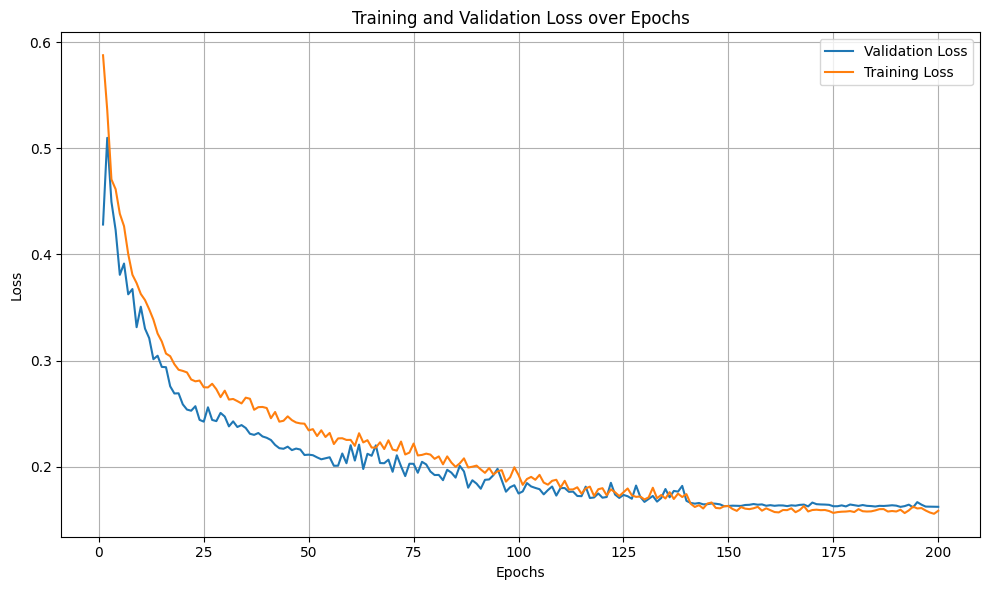

In [87]:
plot_training(N_EPOCHS+1, train_losses, val_losses, 'training_1.png')

![figures/unet_training.png](figures/unet_training.png)

#### 4) Inference
> On training set first

In [13]:
trained_unet = UNet()
trained_unet.load_state_dict(state_dict=torch.load('./model/trained_unet_1.pt'))
trained_unet.to(device)

UNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_siz

In [18]:
def plot_predictions(n, inputs, masks_rgb, outputs, img_name=''):
    """ Plot ground-truth, salt, predictions, binary predictions side by side, like in the pdf. 
    n: number of ground-truth images to plot
    """
    outputs_binary = torch.where(outputs > .5, 1., 0.).repeat(1, 3, 1, 1)
    outputs = outputs.repeat(1, 3, 1, 1)

    # Concatenate the images along the width dimension to create a single tensor
    combined_images = torch.cat([inputs[0:n,:,:,:], masks_rgb[0:n,:,:,:], outputs[0:n,:,:,:], outputs_binary[0:n,:,:,:]], dim=3)

    # Make a grid with the combined images
    grid_image = torchvision.utils.make_grid(combined_images, nrow=1, padding=10, normalize=True)

    # Convert the grid tensor to a numpy array for visualization
    grid_image_np = grid_image.permute(1, 2, 0).cpu().numpy()

    # Display the grid of images
    plt.figure(figsize=(10, 15))
    plt.imshow(grid_image_np)
    
    plt.axis('off')
    plt.show()
    plt.savefig(f'figures/{img_name}')

In [16]:
def predictions(model, dataloader, name_img):
    inputs, masks = next(iter(dataloader))
    masks = masks.to(device)
    masks_rgb = masks.repeat(1, 3, 1, 1)
    inputs = inputs.to(device)
    outputs = model(inputs)
    plot_predictions(5, inputs, masks_rgb, outputs, name_img)

> Results are very good on these training samples

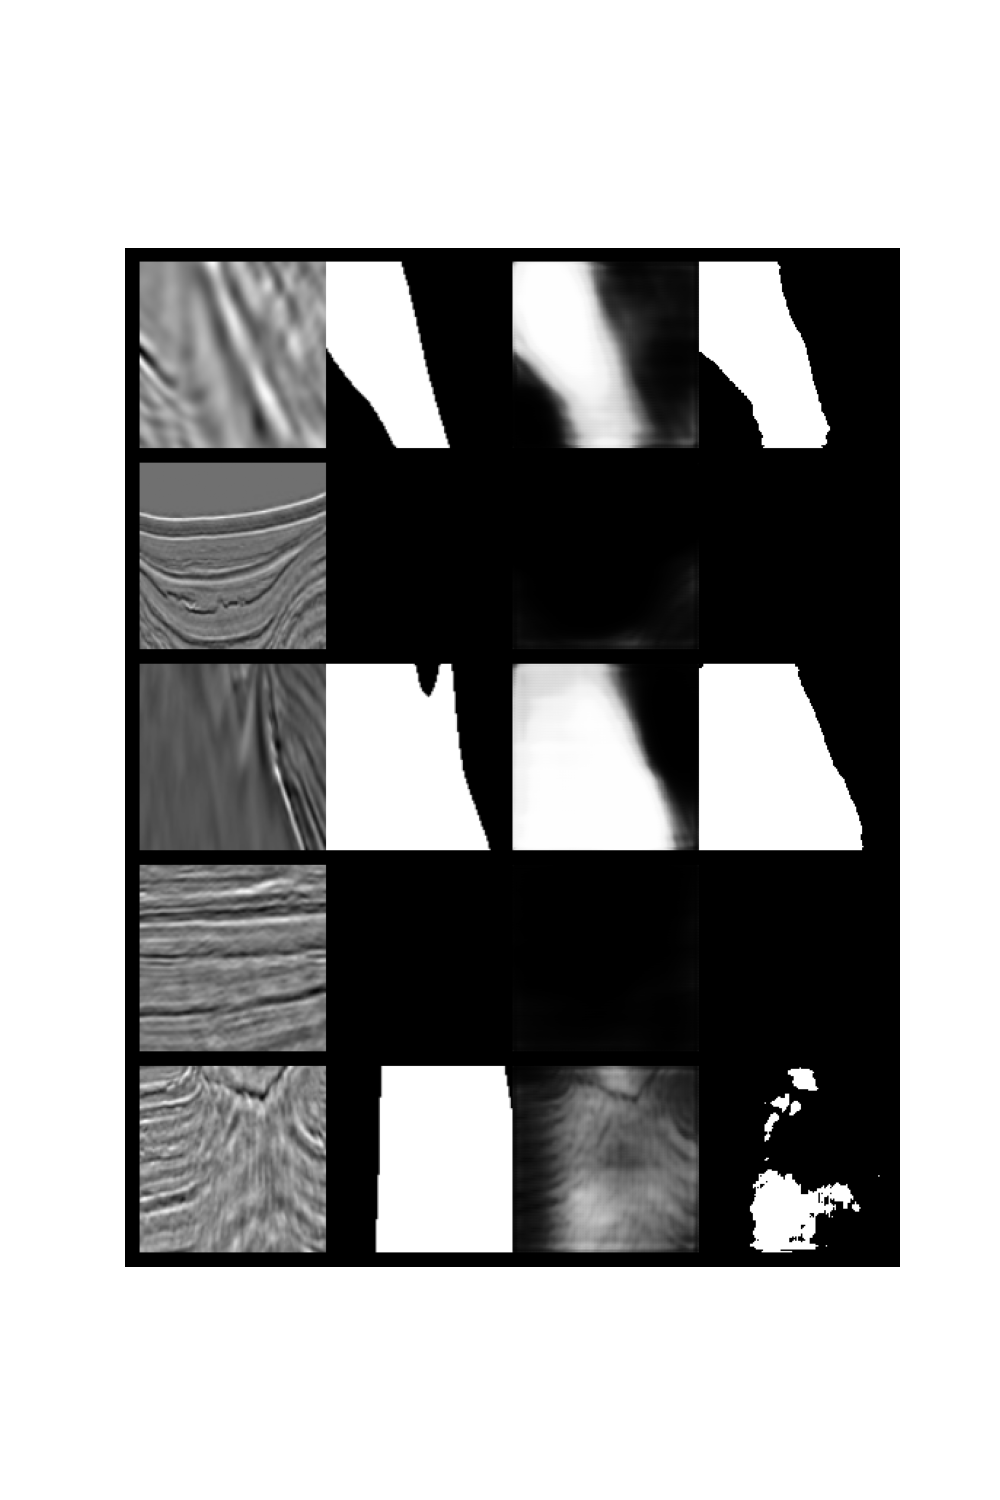

In [52]:
predictions(trained_unet, dataloaders['val'], 'inference_validation.png')

![figures/inference_validation.png](figures/inference_validation.png)

> Results are also pretty good on the validation samples, although a bit less accuracte on the last image.

#### 5- Questions

> 1) The 2x2 MaxPool kernels can be replaced with 2x2 Conv2D kernel with padding 1 and stride 2. The resulting size will still be divided by two since the MaxPool kernel has the same effect as the Conv2D kernel on the size. <br>
It can be checked with the formula from [Pytorch website](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html): <br>
$\begin{equation} H_{out}​=\frac{H_{in}+2×padding+dilation×(kernel\_size−1)-1}{stride}+1\end{equation}$

In [18]:
class Conv2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        # print(f'Conv2 forward, x.shape = {x.shape}')
        return self.conv(x)
    
class ConvUnet(nn.Module):
    def __init__(self):
        # Super constructor
        super().__init__()
        self.conv1 = Conv2(in_channels=3, out_channels=16)
        self.pool_conv1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=2, stride=2)

        self.conv2 = Conv2(in_channels=16, out_channels=32)
        self.pool_conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2, stride=2)

        self.conv3 = Conv2(in_channels=32, out_channels=64)
        self.pool_conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)

        self.conv4 = Conv2(in_channels=64, out_channels=128)
        self.pool_conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)

        self.conv5 = Conv2(in_channels=128, out_channels=256)

        # Decoder 
        
        self.transpose_conv1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)

        self.conv6 = Conv2(in_channels=256, out_channels=128)
        self.transpose_conv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)

        self.conv7 = Conv2(in_channels=128, out_channels=64)
        self.transpose_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)

        self.conv8 = Conv2(in_channels=64, out_channels=32)
        self.transpose_conv4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2)

        self.conv9 = Conv2(in_channels=32, out_channels=16)

        self.conv10 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1)
        

    def forward(self, images):
        # Encoder

        # print(f'images.shape = {images.shape}')
        c1 = self.conv1(images)
        # print(f'c1.shape = {c1.shape}')
        p1 = self.pool_conv1(c1)

        c2 = self.conv2(p1)
        # print(f'c2.shape = {c1.shape}')
        p2 = self.pool_conv2(c2)

        c3 = self.conv3(p2)
        p3 = self.pool_conv3(c3)

        c4 = self.conv4(p3)
        p4 = self.pool_conv4(c4)

        c5 = self.conv5(p4)

        # Decoder 

        u6 = self.transpose_conv1(c5)
        u6 = torch.cat((u6, c4), dim=1) # first dim is batch dimension, second (1) is the channel

        c6 = self.conv6(u6)
        u7 = self.transpose_conv2(c6)
        u7 = torch.cat((u7, c3), dim=1)

        c7 = self.conv7(u7)
        u8 = self.transpose_conv3(c7)
        u8 = torch.cat((u8, c2), dim=1)

        c8 = self.conv8(u8)
        u9 = self.transpose_conv4(c8)
        u9 = torch.cat((u9, c1), dim=1)

        c9 = self.conv9(u9)
        
        return torch.sigmoid(self.conv10(c9))
    
UNet_conv = ConvUnet()
UNet_conv.to(device)

ConvUnet(
  (conv1): Conv2(
    (conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (pool_conv1): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  (conv2): Conv2(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (pool_conv2): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv3): Conv2(
 

In [19]:
N_EPOCHS, LR, BATCH_SIZE, optimizer, scheduler, criterion = get_hyperparameters(UNet_conv)
dataloaders, dataset_sizes = get_data_loader(path_train_images, path_train_masks, path_val_images, path_val_masks, BATCH_SIZE)

trained_unet_conv, train_losses, val_losses = train(UNet_conv, optimizer, criterion, dataloaders, N_EPOCHS, scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]



Epoch 0/1000
----------
Phase: train
Average train loss: 0.6132
Phase: val


  0%|          | 1/1000 [00:05<1:30:14,  5.42s/it]

Average val loss: 0.5293
threshold_lr: 0


Epoch 1/1000
----------
Phase: train
Average train loss: 0.5455
Phase: val


  0%|          | 2/1000 [00:10<1:27:36,  5.27s/it]

Average val loss: 0.6468
threshold_lr: 1


Epoch 2/1000
----------
Phase: train
Average train loss: 0.5278
Phase: val


  0%|          | 3/1000 [00:15<1:25:19,  5.13s/it]

Average val loss: 0.4692
threshold_lr: 0


Epoch 3/1000
----------
Phase: train
Average train loss: 0.4923
Phase: val


  0%|          | 4/1000 [00:20<1:25:19,  5.14s/it]

Average val loss: 0.4845
threshold_lr: 1


Epoch 4/1000
----------
Phase: train
Average train loss: 0.4672
Phase: val


  0%|          | 5/1000 [00:25<1:23:34,  5.04s/it]

Average val loss: 0.4449
threshold_lr: 0


Epoch 5/1000
----------
Phase: train
Average train loss: 0.4517
Phase: val


  1%|          | 6/1000 [00:30<1:23:44,  5.05s/it]

Average val loss: 0.4213
threshold_lr: 0


Epoch 6/1000
----------
Phase: train
Average train loss: 0.4278
Phase: val


  1%|          | 7/1000 [00:35<1:21:32,  4.93s/it]

Average val loss: 0.3902
threshold_lr: 0


Epoch 7/1000
----------
Phase: train
Average train loss: 0.4217
Phase: val


  1%|          | 8/1000 [00:40<1:23:35,  5.06s/it]

Average val loss: 0.4079
threshold_lr: 1


Epoch 8/1000
----------
Phase: train
Average train loss: 0.4109
Phase: val


  1%|          | 9/1000 [00:46<1:25:44,  5.19s/it]

Average val loss: 0.3811
threshold_lr: 0


Epoch 9/1000
----------
Phase: train
Average train loss: 0.4024
Phase: val


  1%|          | 10/1000 [00:50<1:23:43,  5.07s/it]

Average val loss: 0.3699
threshold_lr: 0


Epoch 10/1000
----------
Phase: train
Average train loss: 0.3913
Phase: val


  1%|          | 11/1000 [00:56<1:24:12,  5.11s/it]

Average val loss: 0.3616
threshold_lr: 0


Epoch 11/1000
----------
Phase: train
Average train loss: 0.3781
Phase: val


  1%|          | 12/1000 [01:01<1:25:12,  5.17s/it]

Average val loss: 0.3496
threshold_lr: 0


Epoch 12/1000
----------
Phase: train
Average train loss: 0.3729
Phase: val


  1%|▏         | 13/1000 [01:06<1:23:32,  5.08s/it]

Average val loss: 0.3372
threshold_lr: 0


Epoch 13/1000
----------
Phase: train
Average train loss: 0.3617
Phase: val


  1%|▏         | 14/1000 [01:11<1:23:06,  5.06s/it]

Average val loss: 0.3456
threshold_lr: 1


Epoch 14/1000
----------
Phase: train
Average train loss: 0.3529
Phase: val


  2%|▏         | 15/1000 [01:16<1:24:13,  5.13s/it]

Average val loss: 0.3265
threshold_lr: 0


Epoch 15/1000
----------
Phase: train
Average train loss: 0.3468
Phase: val


  2%|▏         | 16/1000 [01:21<1:23:08,  5.07s/it]

Average val loss: 0.3174
threshold_lr: 0


Epoch 16/1000
----------
Phase: train
Average train loss: 0.3359
Phase: val


  2%|▏         | 17/1000 [01:26<1:24:36,  5.16s/it]

Average val loss: 0.3194
threshold_lr: 1


Epoch 17/1000
----------
Phase: train
Average train loss: 0.3336
Phase: val


  2%|▏         | 18/1000 [01:31<1:23:24,  5.10s/it]

Average val loss: 0.3103
threshold_lr: 0


Epoch 18/1000
----------
Phase: train
Average train loss: 0.3291
Phase: val


  2%|▏         | 19/1000 [01:36<1:22:58,  5.07s/it]

Average val loss: 0.3098
threshold_lr: 0


Epoch 19/1000
----------
Phase: train
Average train loss: 0.3234
Phase: val


  2%|▏         | 20/1000 [01:41<1:22:40,  5.06s/it]

Average val loss: 0.2998
threshold_lr: 0


Epoch 20/1000
----------
Phase: train
Average train loss: 0.3169
Phase: val


  2%|▏         | 21/1000 [01:46<1:21:06,  4.97s/it]

Average val loss: 0.2970
threshold_lr: 0


Epoch 21/1000
----------
Phase: train
Average train loss: 0.3124
Phase: val


  2%|▏         | 22/1000 [01:51<1:20:21,  4.93s/it]

Average val loss: 0.2995
threshold_lr: 1


Epoch 22/1000
----------
Phase: train
Average train loss: 0.3117
Phase: val


  2%|▏         | 23/1000 [01:56<1:22:47,  5.08s/it]

Average val loss: 0.2991
threshold_lr: 2


Epoch 23/1000
----------
Phase: train
Average train loss: 0.3143
Phase: val


  2%|▏         | 24/1000 [02:02<1:24:19,  5.18s/it]

Average val loss: 0.2881
threshold_lr: 0


Epoch 24/1000
----------
Phase: train
Average train loss: 0.3074
Phase: val


  2%|▎         | 25/1000 [02:07<1:23:33,  5.14s/it]

Average val loss: 0.2904
threshold_lr: 1


Epoch 25/1000
----------
Phase: train
Average train loss: 0.3080
Phase: val


  3%|▎         | 26/1000 [02:12<1:24:01,  5.18s/it]

Average val loss: 0.2836
threshold_lr: 0


Epoch 26/1000
----------
Phase: train
Average train loss: 0.3042
Phase: val


  3%|▎         | 27/1000 [02:17<1:24:12,  5.19s/it]

Average val loss: 0.2775
threshold_lr: 0


Epoch 27/1000
----------
Phase: train
Average train loss: 0.3046
Phase: val


  3%|▎         | 28/1000 [02:23<1:24:17,  5.20s/it]

Average val loss: 0.2878
threshold_lr: 1


Epoch 28/1000
----------
Phase: train
Average train loss: 0.3005
Phase: val


  3%|▎         | 29/1000 [02:28<1:25:45,  5.30s/it]

Average val loss: 0.2781
threshold_lr: 2


Epoch 29/1000
----------
Phase: train
Average train loss: 0.2984
Phase: val


  3%|▎         | 30/1000 [02:33<1:24:37,  5.23s/it]

Average val loss: 0.2735
threshold_lr: 0


Epoch 30/1000
----------
Phase: train
Average train loss: 0.2986
Phase: val


  3%|▎         | 31/1000 [02:38<1:21:56,  5.07s/it]

Average val loss: 0.2810
threshold_lr: 1


Epoch 31/1000
----------
Phase: train
Average train loss: 0.2902
Phase: val


  3%|▎         | 32/1000 [02:43<1:22:42,  5.13s/it]

Average val loss: 0.2825
threshold_lr: 2


Epoch 32/1000
----------
Phase: train
Average train loss: 0.2935
Phase: val


  3%|▎         | 33/1000 [02:48<1:22:00,  5.09s/it]

Average val loss: 0.2724
threshold_lr: 0


Epoch 33/1000
----------
Phase: train
Average train loss: 0.2939
Phase: val


  3%|▎         | 34/1000 [02:53<1:21:19,  5.05s/it]

Average val loss: 0.2733
threshold_lr: 1


Epoch 34/1000
----------
Phase: train
Average train loss: 0.2905
Phase: val


  4%|▎         | 35/1000 [02:58<1:20:13,  4.99s/it]

Average val loss: 0.2686
threshold_lr: 0


Epoch 35/1000
----------
Phase: train
Average train loss: 0.2861
Phase: val


  4%|▎         | 36/1000 [03:03<1:19:28,  4.95s/it]

Average val loss: 0.2730
threshold_lr: 1


Epoch 36/1000
----------
Phase: train
Average train loss: 0.2882
Phase: val


  4%|▎         | 37/1000 [03:08<1:20:01,  4.99s/it]

Average val loss: 0.2703
threshold_lr: 2


Epoch 37/1000
----------
Phase: train
Average train loss: 0.2832
Phase: val


  4%|▍         | 38/1000 [03:13<1:21:26,  5.08s/it]

Average val loss: 0.2787
threshold_lr: 3


Epoch 38/1000
----------
Phase: train
Average train loss: 0.2801
Phase: val


  4%|▍         | 39/1000 [03:18<1:21:48,  5.11s/it]

Average val loss: 0.2762
threshold_lr: 4


Epoch 39/1000
----------
Phase: train
Average train loss: 0.2836
Phase: val


  4%|▍         | 40/1000 [03:23<1:21:31,  5.10s/it]

Average val loss: 0.2720
threshold_lr: 5


Epoch 40/1000
----------
Phase: train
Average train loss: 0.2768
Phase: val


  4%|▍         | 41/1000 [03:28<1:20:31,  5.04s/it]

Average val loss: 0.2657
threshold_lr: 0


Epoch 41/1000
----------
Phase: train
Average train loss: 0.2817
Phase: val


  4%|▍         | 42/1000 [03:33<1:19:50,  5.00s/it]

Average val loss: 0.2699
threshold_lr: 1


Epoch 42/1000
----------
Phase: train
Average train loss: 0.2751
Phase: val


  4%|▍         | 43/1000 [03:38<1:18:33,  4.93s/it]

Average val loss: 0.2624
threshold_lr: 0


Epoch 43/1000
----------
Phase: train
Average train loss: 0.2797
Phase: val


  4%|▍         | 44/1000 [03:43<1:18:12,  4.91s/it]

Average val loss: 0.2579
threshold_lr: 0


Epoch 44/1000
----------
Phase: train
Average train loss: 0.2692
Phase: val


  4%|▍         | 45/1000 [03:48<1:17:16,  4.86s/it]

Average val loss: 0.2607
threshold_lr: 1


Epoch 45/1000
----------
Phase: train
Average train loss: 0.2739
Phase: val


  5%|▍         | 46/1000 [03:53<1:18:40,  4.95s/it]

Average val loss: 0.2617
threshold_lr: 2


Epoch 46/1000
----------
Phase: train
Average train loss: 0.2760
Phase: val


  5%|▍         | 47/1000 [03:57<1:16:53,  4.84s/it]

Average val loss: 0.2558
threshold_lr: 0


Epoch 47/1000
----------
Phase: train
Average train loss: 0.2712
Phase: val


  5%|▍         | 48/1000 [04:02<1:17:17,  4.87s/it]

Average val loss: 0.2488
threshold_lr: 0


Epoch 48/1000
----------
Phase: train
Average train loss: 0.2717
Phase: val


  5%|▍         | 49/1000 [04:08<1:19:15,  5.00s/it]

Average val loss: 0.2493
threshold_lr: 1


Epoch 49/1000
----------
Phase: train
Average train loss: 0.2662
Phase: val


  5%|▌         | 50/1000 [04:13<1:18:36,  4.96s/it]

Average val loss: 0.2528
threshold_lr: 2


Epoch 50/1000
----------
Phase: train
Average train loss: 0.2742
Phase: val


  5%|▌         | 51/1000 [04:17<1:18:00,  4.93s/it]

Average val loss: 0.2678
threshold_lr: 3


Epoch 51/1000
----------
Phase: train
Average train loss: 0.2711
Phase: val


  5%|▌         | 52/1000 [04:22<1:17:51,  4.93s/it]

Average val loss: 0.2650
threshold_lr: 4


Epoch 52/1000
----------
Phase: train
Average train loss: 0.2647
Phase: val


  5%|▌         | 53/1000 [04:27<1:16:55,  4.87s/it]

Average val loss: 0.2552
threshold_lr: 5


Epoch 53/1000
----------
Phase: train
Average train loss: 0.2624
Phase: val


  5%|▌         | 54/1000 [04:32<1:16:21,  4.84s/it]

Average val loss: 0.2508
threshold_lr: 6


Epoch 54/1000
----------
Phase: train
Average train loss: 0.2646
Phase: val


  6%|▌         | 55/1000 [04:37<1:15:43,  4.81s/it]

Average val loss: 0.2467
threshold_lr: 0


Epoch 55/1000
----------
Phase: train
Average train loss: 0.2685
Phase: val


  6%|▌         | 56/1000 [04:42<1:18:09,  4.97s/it]

Average val loss: 0.2457
threshold_lr: 0


Epoch 56/1000
----------
Phase: train
Average train loss: 0.2643
Phase: val


  6%|▌         | 57/1000 [04:47<1:17:43,  4.95s/it]

Average val loss: 0.2482
threshold_lr: 1


Epoch 57/1000
----------
Phase: train
Average train loss: 0.2628
Phase: val


  6%|▌         | 58/1000 [04:52<1:18:47,  5.02s/it]

Average val loss: 0.2455
threshold_lr: 0


Epoch 58/1000
----------
Phase: train
Average train loss: 0.2648
Phase: val


  6%|▌         | 59/1000 [04:57<1:18:12,  4.99s/it]

Average val loss: 0.2412
threshold_lr: 0


Epoch 59/1000
----------
Phase: train
Average train loss: 0.2554
Phase: val


  6%|▌         | 60/1000 [05:02<1:19:02,  5.04s/it]

Average val loss: 0.2399
threshold_lr: 0


Epoch 60/1000
----------
Phase: train
Average train loss: 0.2538
Phase: val


  6%|▌         | 61/1000 [05:07<1:17:52,  4.98s/it]

Average val loss: 0.2438
threshold_lr: 1


Epoch 61/1000
----------
Phase: train
Average train loss: 0.2555
Phase: val


  6%|▌         | 62/1000 [05:12<1:19:57,  5.11s/it]

Average val loss: 0.2457
threshold_lr: 2


Epoch 62/1000
----------
Phase: train
Average train loss: 0.2591
Phase: val


  6%|▋         | 63/1000 [05:18<1:20:36,  5.16s/it]

Average val loss: 0.2452
threshold_lr: 3


Epoch 63/1000
----------
Phase: train
Average train loss: 0.2525
Phase: val


  6%|▋         | 64/1000 [05:22<1:19:08,  5.07s/it]

Average val loss: 0.2489
threshold_lr: 4


Epoch 64/1000
----------
Phase: train
Average train loss: 0.2559
Phase: val


  6%|▋         | 65/1000 [05:27<1:17:42,  4.99s/it]

Average val loss: 0.2395
threshold_lr: 0


Epoch 65/1000
----------
Phase: train
Average train loss: 0.2532
Phase: val


  7%|▋         | 66/1000 [05:32<1:17:07,  4.95s/it]

Average val loss: 0.2395
threshold_lr: 1


Epoch 66/1000
----------
Phase: train
Average train loss: 0.2480
Phase: val


  7%|▋         | 67/1000 [05:37<1:17:08,  4.96s/it]

Average val loss: 0.2386
threshold_lr: 0


Epoch 67/1000
----------
Phase: train
Average train loss: 0.2483
Phase: val


  7%|▋         | 68/1000 [05:42<1:16:38,  4.93s/it]

Average val loss: 0.2430
threshold_lr: 1


Epoch 68/1000
----------
Phase: train
Average train loss: 0.2521
Phase: val


  7%|▋         | 69/1000 [05:47<1:15:25,  4.86s/it]

Average val loss: 0.2464
threshold_lr: 2


Epoch 69/1000
----------
Phase: train
Average train loss: 0.2490
Phase: val


  7%|▋         | 70/1000 [05:52<1:15:48,  4.89s/it]

Average val loss: 0.2511
threshold_lr: 3


Epoch 70/1000
----------
Phase: train
Average train loss: 0.2505
Phase: val


  7%|▋         | 71/1000 [05:57<1:17:01,  4.97s/it]

Average val loss: 0.2401
threshold_lr: 4


Epoch 71/1000
----------
Phase: train
Average train loss: 0.2528
Phase: val


  7%|▋         | 72/1000 [06:02<1:17:39,  5.02s/it]

Average val loss: 0.2408
threshold_lr: 5


Epoch 72/1000
----------
Phase: train
Average train loss: 0.2478
Phase: val


  7%|▋         | 73/1000 [06:07<1:17:52,  5.04s/it]

Average val loss: 0.2425
threshold_lr: 6


Epoch 73/1000
----------
Phase: train
Average train loss: 0.2587
Phase: val


  7%|▋         | 74/1000 [06:12<1:17:44,  5.04s/it]

Average val loss: 0.2400
threshold_lr: 7


Epoch 74/1000
----------
Phase: train
Average train loss: 0.2511
Phase: val


  8%|▊         | 75/1000 [06:17<1:17:46,  5.05s/it]

Average val loss: 0.2434
threshold_lr: 8


Epoch 75/1000
----------
Phase: train
Average train loss: 0.2524
Phase: val


  8%|▊         | 76/1000 [06:22<1:19:00,  5.13s/it]

Average val loss: 0.2318
threshold_lr: 0


Epoch 76/1000
----------
Phase: train
Average train loss: 0.2528
Phase: val


  8%|▊         | 77/1000 [06:27<1:18:24,  5.10s/it]

Average val loss: 0.2468
threshold_lr: 1


Epoch 77/1000
----------
Phase: train
Average train loss: 0.2561
Phase: val


  8%|▊         | 78/1000 [06:32<1:16:07,  4.95s/it]

Average val loss: 0.2383
threshold_lr: 2


Epoch 78/1000
----------
Phase: train
Average train loss: 0.2531
Phase: val


  8%|▊         | 79/1000 [06:37<1:17:39,  5.06s/it]

Average val loss: 0.2452
threshold_lr: 3


Epoch 79/1000
----------
Phase: train
Average train loss: 0.2530
Phase: val


  8%|▊         | 80/1000 [06:43<1:19:00,  5.15s/it]

Average val loss: 0.2277
threshold_lr: 0


Epoch 80/1000
----------
Phase: train
Average train loss: 0.2427
Phase: val


  8%|▊         | 81/1000 [06:48<1:18:35,  5.13s/it]

Average val loss: 0.2438
threshold_lr: 1


Epoch 81/1000
----------
Phase: train
Average train loss: 0.2572
Phase: val


  8%|▊         | 82/1000 [06:53<1:20:02,  5.23s/it]

Average val loss: 0.2382
threshold_lr: 2


Epoch 82/1000
----------
Phase: train
Average train loss: 0.2419
Phase: val


  8%|▊         | 83/1000 [06:59<1:21:31,  5.33s/it]

Average val loss: 0.2272
threshold_lr: 0


Epoch 83/1000
----------
Phase: train
Average train loss: 0.2495
Phase: val


  8%|▊         | 84/1000 [07:04<1:19:54,  5.23s/it]

Average val loss: 0.2333
threshold_lr: 1


Epoch 84/1000
----------
Phase: train
Average train loss: 0.2530
Phase: val


  8%|▊         | 85/1000 [07:09<1:21:23,  5.34s/it]

Average val loss: 0.2361
threshold_lr: 2


Epoch 85/1000
----------
Phase: train
Average train loss: 0.2482
Phase: val


  9%|▊         | 86/1000 [07:14<1:18:41,  5.17s/it]

Average val loss: 0.2391
threshold_lr: 3


Epoch 86/1000
----------
Phase: train
Average train loss: 0.2456
Phase: val


  9%|▊         | 87/1000 [07:19<1:17:43,  5.11s/it]

Average val loss: 0.2422
threshold_lr: 4


Epoch 87/1000
----------
Phase: train
Average train loss: 0.2497
Phase: val


  9%|▉         | 88/1000 [07:24<1:16:05,  5.01s/it]

Average val loss: 0.2435
threshold_lr: 5


Epoch 88/1000
----------
Phase: train
Average train loss: 0.2444
Phase: val


  9%|▉         | 89/1000 [07:29<1:15:18,  4.96s/it]

Average val loss: 0.2435
threshold_lr: 6


Epoch 89/1000
----------
Phase: train
Average train loss: 0.2405
Phase: val


  9%|▉         | 90/1000 [07:34<1:15:53,  5.00s/it]

Average val loss: 0.2481
threshold_lr: 7


Epoch 90/1000
----------
Phase: train
Average train loss: 0.2453
Phase: val


  9%|▉         | 91/1000 [07:39<1:17:20,  5.10s/it]

Average val loss: 0.2407
threshold_lr: 8


Epoch 91/1000
----------
Phase: train
Average train loss: 0.2350
Phase: val


  9%|▉         | 92/1000 [07:44<1:17:26,  5.12s/it]

Average val loss: 0.2346
threshold_lr: 9


Epoch 92/1000
----------
Phase: train
Average train loss: 0.2349
Phase: val


  9%|▉         | 93/1000 [07:49<1:16:44,  5.08s/it]

Average val loss: 0.2319
threshold_lr: 10


Epoch 93/1000
----------
Phase: train
Average train loss: 0.2411
Phase: val


  9%|▉         | 94/1000 [07:55<1:17:48,  5.15s/it]

Average val loss: 0.2344
threshold_lr: 11


Epoch 94/1000
----------
Phase: train
Average train loss: 0.2391
Phase: val


 10%|▉         | 95/1000 [08:00<1:17:29,  5.14s/it]

Average val loss: 0.2277
threshold_lr: 12


Epoch 95/1000
----------
Phase: train
Average train loss: 0.2351
Phase: val


 10%|▉         | 96/1000 [08:05<1:17:37,  5.15s/it]

Average val loss: 0.2238
threshold_lr: 0


Epoch 96/1000
----------
Phase: train
Average train loss: 0.2335
Phase: val


 10%|▉         | 97/1000 [08:10<1:17:25,  5.14s/it]

Average val loss: 0.2242
threshold_lr: 1


Epoch 97/1000
----------
Phase: train
Average train loss: 0.2314
Phase: val


 10%|▉         | 98/1000 [08:15<1:16:42,  5.10s/it]

Average val loss: 0.2239
threshold_lr: 2


Epoch 98/1000
----------
Phase: train
Average train loss: 0.2362
Phase: val


 10%|▉         | 99/1000 [08:20<1:16:18,  5.08s/it]

Average val loss: 0.2272
threshold_lr: 3


Epoch 99/1000
----------
Phase: train
Average train loss: 0.2283
Phase: val


 10%|█         | 100/1000 [08:25<1:16:05,  5.07s/it]

Average val loss: 0.2203
threshold_lr: 0


Epoch 100/1000
----------
Phase: train
Average train loss: 0.2266
Phase: val


 10%|█         | 101/1000 [08:30<1:16:14,  5.09s/it]

Average val loss: 0.2220
threshold_lr: 1


Epoch 101/1000
----------
Phase: train
Average train loss: 0.2305
Phase: val


 10%|█         | 102/1000 [08:35<1:14:34,  4.98s/it]

Average val loss: 0.2204
threshold_lr: 2


Epoch 102/1000
----------
Phase: train
Average train loss: 0.2328
Phase: val


 10%|█         | 103/1000 [08:40<1:14:40,  4.99s/it]

Average val loss: 0.2203
threshold_lr: 0


Epoch 103/1000
----------
Phase: train
Average train loss: 0.2239
Phase: val


 10%|█         | 104/1000 [08:45<1:13:54,  4.95s/it]

Average val loss: 0.2169
threshold_lr: 0


Epoch 104/1000
----------
Phase: train
Average train loss: 0.2223
Phase: val


 10%|█         | 105/1000 [08:50<1:15:59,  5.09s/it]

Average val loss: 0.2152
threshold_lr: 0


Epoch 105/1000
----------
Phase: train
Average train loss: 0.2219
Phase: val


 11%|█         | 106/1000 [08:56<1:16:30,  5.14s/it]

Average val loss: 0.2137
threshold_lr: 0


Epoch 106/1000
----------
Phase: train
Average train loss: 0.2164
Phase: val


 11%|█         | 107/1000 [09:00<1:15:04,  5.04s/it]

Average val loss: 0.2131
threshold_lr: 0


Epoch 107/1000
----------
Phase: train
Average train loss: 0.2206
Phase: val


 11%|█         | 108/1000 [09:06<1:16:49,  5.17s/it]

Average val loss: 0.2160
threshold_lr: 1


Epoch 108/1000
----------
Phase: train
Average train loss: 0.2178
Phase: val


 11%|█         | 109/1000 [09:11<1:16:01,  5.12s/it]

Average val loss: 0.2154
threshold_lr: 2


Epoch 109/1000
----------
Phase: train
Average train loss: 0.2155
Phase: val


 11%|█         | 110/1000 [09:16<1:14:49,  5.04s/it]

Average val loss: 0.2139
threshold_lr: 3


Epoch 110/1000
----------
Phase: train
Average train loss: 0.2179
Phase: val


 11%|█         | 111/1000 [09:21<1:16:20,  5.15s/it]

Average val loss: 0.2127
threshold_lr: 0


Epoch 111/1000
----------
Phase: train
Average train loss: 0.2148
Phase: val


 11%|█         | 112/1000 [09:26<1:15:59,  5.13s/it]

Average val loss: 0.2121
threshold_lr: 0


Epoch 112/1000
----------
Phase: train
Average train loss: 0.2120
Phase: val


 11%|█▏        | 113/1000 [09:31<1:15:34,  5.11s/it]

Average val loss: 0.2166
threshold_lr: 1


Epoch 113/1000
----------
Phase: train
Average train loss: 0.2169
Phase: val


 11%|█▏        | 114/1000 [09:36<1:15:24,  5.11s/it]

Average val loss: 0.2123
threshold_lr: 2


Epoch 114/1000
----------
Phase: train
Average train loss: 0.2170
Phase: val


 12%|█▏        | 115/1000 [09:42<1:15:25,  5.11s/it]

Average val loss: 0.2068
threshold_lr: 0


Epoch 115/1000
----------
Phase: train
Average train loss: 0.2117
Phase: val


 12%|█▏        | 116/1000 [09:47<1:16:07,  5.17s/it]

Average val loss: 0.2052
threshold_lr: 0


Epoch 116/1000
----------
Phase: train
Average train loss: 0.2138
Phase: val


 12%|█▏        | 117/1000 [09:52<1:16:20,  5.19s/it]

Average val loss: 0.2136
threshold_lr: 1


Epoch 117/1000
----------
Phase: train
Average train loss: 0.2131
Phase: val


 12%|█▏        | 118/1000 [09:57<1:17:08,  5.25s/it]

Average val loss: 0.2045
threshold_lr: 0


Epoch 118/1000
----------
Phase: train
Average train loss: 0.2117
Phase: val


 12%|█▏        | 119/1000 [10:03<1:17:18,  5.27s/it]

Average val loss: 0.2120
threshold_lr: 1


Epoch 119/1000
----------
Phase: train
Average train loss: 0.2123
Phase: val


 12%|█▏        | 120/1000 [10:08<1:18:17,  5.34s/it]

Average val loss: 0.2074
threshold_lr: 2


Epoch 120/1000
----------
Phase: train
Average train loss: 0.2091
Phase: val


 12%|█▏        | 121/1000 [10:14<1:17:54,  5.32s/it]

Average val loss: 0.2119
threshold_lr: 3


Epoch 121/1000
----------
Phase: train
Average train loss: 0.2077
Phase: val


 12%|█▏        | 122/1000 [10:18<1:16:12,  5.21s/it]

Average val loss: 0.2096
threshold_lr: 4


Epoch 122/1000
----------
Phase: train
Average train loss: 0.2081
Phase: val


 12%|█▏        | 123/1000 [10:24<1:15:47,  5.19s/it]

Average val loss: 0.2109
threshold_lr: 5


Epoch 123/1000
----------
Phase: train
Average train loss: 0.2091
Phase: val


 12%|█▏        | 124/1000 [10:29<1:15:42,  5.19s/it]

Average val loss: 0.2031
threshold_lr: 0


Epoch 124/1000
----------
Phase: train
Average train loss: 0.2059
Phase: val


 12%|█▎        | 125/1000 [10:34<1:16:32,  5.25s/it]

Average val loss: 0.2000
threshold_lr: 0


Epoch 125/1000
----------
Phase: train
Average train loss: 0.2108
Phase: val


 13%|█▎        | 126/1000 [10:40<1:17:26,  5.32s/it]

Average val loss: 0.2008
threshold_lr: 1


Epoch 126/1000
----------
Phase: train
Average train loss: 0.2061
Phase: val


 13%|█▎        | 127/1000 [10:45<1:15:57,  5.22s/it]

Average val loss: 0.1975
threshold_lr: 0


Epoch 127/1000
----------
Phase: train
Average train loss: 0.2141
Phase: val


 13%|█▎        | 128/1000 [10:50<1:15:34,  5.20s/it]

Average val loss: 0.2061
threshold_lr: 1


Epoch 128/1000
----------
Phase: train
Average train loss: 0.2024
Phase: val


 13%|█▎        | 129/1000 [10:55<1:14:16,  5.12s/it]

Average val loss: 0.1996
threshold_lr: 2


Epoch 129/1000
----------
Phase: train
Average train loss: 0.2052
Phase: val


 13%|█▎        | 130/1000 [11:00<1:12:56,  5.03s/it]

Average val loss: 0.2052
threshold_lr: 3


Epoch 130/1000
----------
Phase: train
Average train loss: 0.2101
Phase: val


 13%|█▎        | 131/1000 [11:05<1:13:09,  5.05s/it]

Average val loss: 0.2036
threshold_lr: 4


Epoch 131/1000
----------
Phase: train
Average train loss: 0.2052
Phase: val


 13%|█▎        | 132/1000 [11:10<1:12:25,  5.01s/it]

Average val loss: 0.1994
threshold_lr: 5


Epoch 132/1000
----------
Phase: train
Average train loss: 0.2100
Phase: val


 13%|█▎        | 133/1000 [11:14<1:11:54,  4.98s/it]

Average val loss: 0.2033
threshold_lr: 6


Epoch 133/1000
----------
Phase: train
Average train loss: 0.2041
Phase: val


 13%|█▎        | 134/1000 [11:19<1:11:06,  4.93s/it]

Average val loss: 0.1967
threshold_lr: 0


Epoch 134/1000
----------
Phase: train
Average train loss: 0.2030
Phase: val


 14%|█▎        | 135/1000 [11:24<1:10:06,  4.86s/it]

Average val loss: 0.2026
threshold_lr: 1


Epoch 135/1000
----------
Phase: train
Average train loss: 0.2122
Phase: val


 14%|█▎        | 136/1000 [11:29<1:09:42,  4.84s/it]

Average val loss: 0.2016
threshold_lr: 2


Epoch 136/1000
----------
Phase: train
Average train loss: 0.2090
Phase: val


 14%|█▎        | 137/1000 [11:34<1:11:54,  5.00s/it]

Average val loss: 0.1964
threshold_lr: 0


Epoch 137/1000
----------
Phase: train
Average train loss: 0.2085
Phase: val


 14%|█▍        | 138/1000 [11:39<1:11:25,  4.97s/it]

Average val loss: 0.2064
threshold_lr: 1


Epoch 138/1000
----------
Phase: train
Average train loss: 0.2078
Phase: val


 14%|█▍        | 139/1000 [11:45<1:14:18,  5.18s/it]

Average val loss: 0.1975
threshold_lr: 2


Epoch 139/1000
----------
Phase: train
Average train loss: 0.1999
Phase: val


 14%|█▍        | 140/1000 [11:50<1:13:51,  5.15s/it]

Average val loss: 0.1980
threshold_lr: 3


Epoch 140/1000
----------
Phase: train
Average train loss: 0.2123
Phase: val


 14%|█▍        | 141/1000 [11:55<1:15:05,  5.24s/it]

Average val loss: 0.2083
threshold_lr: 4


Epoch 141/1000
----------
Phase: train
Average train loss: 0.2042
Phase: val


 14%|█▍        | 142/1000 [12:00<1:14:32,  5.21s/it]

Average val loss: 0.2026
threshold_lr: 5


Epoch 142/1000
----------
Phase: train
Average train loss: 0.1973
Phase: val


 14%|█▍        | 143/1000 [12:06<1:14:11,  5.19s/it]

Average val loss: 0.2001
threshold_lr: 6


Epoch 143/1000
----------
Phase: train
Average train loss: 0.2069
Phase: val


 14%|█▍        | 144/1000 [12:11<1:15:12,  5.27s/it]

Average val loss: 0.2082
threshold_lr: 7


Epoch 144/1000
----------
Phase: train
Average train loss: 0.2031
Phase: val


 14%|█▍        | 145/1000 [12:16<1:14:25,  5.22s/it]

Average val loss: 0.1950
threshold_lr: 0


Epoch 145/1000
----------
Phase: train
Average train loss: 0.1956
Phase: val


 15%|█▍        | 146/1000 [12:22<1:15:23,  5.30s/it]

Average val loss: 0.1996
threshold_lr: 1


Epoch 146/1000
----------
Phase: train
Average train loss: 0.2068
Phase: val


 15%|█▍        | 147/1000 [12:27<1:16:46,  5.40s/it]

Average val loss: 0.2017
threshold_lr: 2


Epoch 147/1000
----------
Phase: train
Average train loss: 0.1994
Phase: val


 15%|█▍        | 148/1000 [12:33<1:16:14,  5.37s/it]

Average val loss: 0.1941
threshold_lr: 0


Epoch 148/1000
----------
Phase: train
Average train loss: 0.2034
Phase: val


 15%|█▍        | 149/1000 [12:38<1:15:10,  5.30s/it]

Average val loss: 0.2004
threshold_lr: 1


Epoch 149/1000
----------
Phase: train
Average train loss: 0.2027
Phase: val


 15%|█▌        | 150/1000 [12:43<1:13:55,  5.22s/it]

Average val loss: 0.1947
threshold_lr: 2


Epoch 150/1000
----------
Phase: train
Average train loss: 0.1939
Phase: val


 15%|█▌        | 151/1000 [12:48<1:13:16,  5.18s/it]

Average val loss: 0.1901
threshold_lr: 0


Epoch 151/1000
----------
Phase: train
Average train loss: 0.2003
Phase: val


 15%|█▌        | 152/1000 [12:53<1:12:33,  5.13s/it]

Average val loss: 0.1971
threshold_lr: 1


Epoch 152/1000
----------
Phase: train
Average train loss: 0.2022
Phase: val


 15%|█▌        | 153/1000 [12:58<1:13:09,  5.18s/it]

Average val loss: 0.1938
threshold_lr: 2


Epoch 153/1000
----------
Phase: train
Average train loss: 0.1939
Phase: val


 15%|█▌        | 154/1000 [13:04<1:14:13,  5.26s/it]

Average val loss: 0.1911
threshold_lr: 3


Epoch 154/1000
----------
Phase: train
Average train loss: 0.1920
Phase: val


 16%|█▌        | 155/1000 [13:09<1:12:55,  5.18s/it]

Average val loss: 0.1925
threshold_lr: 4


Epoch 155/1000
----------
Phase: train
Average train loss: 0.1946
Phase: val


 16%|█▌        | 156/1000 [13:14<1:12:28,  5.15s/it]

Average val loss: 0.1953
threshold_lr: 5


Epoch 156/1000
----------
Phase: train
Average train loss: 0.1917
Phase: val


 16%|█▌        | 157/1000 [13:19<1:14:40,  5.31s/it]

Average val loss: 0.1981
threshold_lr: 6


Epoch 157/1000
----------
Phase: train
Average train loss: 0.1983
Phase: val


 16%|█▌        | 158/1000 [13:25<1:14:02,  5.28s/it]

Average val loss: 0.2072
threshold_lr: 7


Epoch 158/1000
----------
Phase: train
Average train loss: 0.1972
Phase: val


 16%|█▌        | 159/1000 [13:29<1:12:21,  5.16s/it]

Average val loss: 0.1948
threshold_lr: 8


Epoch 159/1000
----------
Phase: train
Average train loss: 0.1946
Phase: val


 16%|█▌        | 160/1000 [13:35<1:12:28,  5.18s/it]

Average val loss: 0.1928
threshold_lr: 9


Epoch 160/1000
----------
Phase: train
Average train loss: 0.1947
Phase: val


 16%|█▌        | 161/1000 [13:40<1:12:07,  5.16s/it]

Average val loss: 0.1954
threshold_lr: 10


Epoch 161/1000
----------
Phase: train
Average train loss: 0.1885
Phase: val


 16%|█▌        | 162/1000 [13:45<1:13:27,  5.26s/it]

Average val loss: 0.1874
threshold_lr: 0


Epoch 162/1000
----------
Phase: train
Average train loss: 0.1934
Phase: val


 16%|█▋        | 163/1000 [13:51<1:13:29,  5.27s/it]

Average val loss: 0.1940
threshold_lr: 1


Epoch 163/1000
----------
Phase: train
Average train loss: 0.1903
Phase: val


 16%|█▋        | 164/1000 [13:55<1:11:10,  5.11s/it]

Average val loss: 0.1928
threshold_lr: 2


Epoch 164/1000
----------
Phase: train
Average train loss: 0.1887
Phase: val


 16%|█▋        | 165/1000 [14:00<1:10:55,  5.10s/it]

Average val loss: 0.1924
threshold_lr: 3


Epoch 165/1000
----------
Phase: train
Average train loss: 0.1944
Phase: val


 17%|█▋        | 166/1000 [14:06<1:11:35,  5.15s/it]

Average val loss: 0.1974
threshold_lr: 4


Epoch 166/1000
----------
Phase: train
Average train loss: 0.1920
Phase: val


 17%|█▋        | 167/1000 [14:11<1:11:24,  5.14s/it]

Average val loss: 0.1926
threshold_lr: 5


Epoch 167/1000
----------
Phase: train
Average train loss: 0.1841
Phase: val


 17%|█▋        | 168/1000 [14:16<1:11:08,  5.13s/it]

Average val loss: 0.1904
threshold_lr: 6


Epoch 168/1000
----------
Phase: train
Average train loss: 0.1947
Phase: val


 17%|█▋        | 169/1000 [14:21<1:10:32,  5.09s/it]

Average val loss: 0.1974
threshold_lr: 7


Epoch 169/1000
----------
Phase: train
Average train loss: 0.1948
Phase: val


 17%|█▋        | 170/1000 [14:26<1:11:18,  5.15s/it]

Average val loss: 0.1922
threshold_lr: 8


Epoch 170/1000
----------
Phase: train
Average train loss: 0.1871
Phase: val


 17%|█▋        | 171/1000 [14:32<1:12:02,  5.21s/it]

Average val loss: 0.1890
threshold_lr: 9


Epoch 171/1000
----------
Phase: train
Average train loss: 0.1931
Phase: val


 17%|█▋        | 172/1000 [14:37<1:11:32,  5.18s/it]

Average val loss: 0.1932
threshold_lr: 10


Epoch 172/1000
----------
Phase: train
Average train loss: 0.1871
Phase: val


 17%|█▋        | 173/1000 [14:42<1:10:24,  5.11s/it]

Average val loss: 0.1876
threshold_lr: 11


Epoch 173/1000
----------
Phase: train
Average train loss: 0.1829
Phase: val


 17%|█▋        | 174/1000 [14:46<1:09:05,  5.02s/it]

Average val loss: 0.1957
threshold_lr: 12


Epoch 174/1000
----------
Phase: train
Average train loss: 0.1913
Phase: val


 18%|█▊        | 175/1000 [14:51<1:08:49,  5.01s/it]

Average val loss: 0.1948
threshold_lr: 13


Epoch 175/1000
----------
Phase: train
Average train loss: 0.1922
Phase: val


 18%|█▊        | 176/1000 [14:57<1:09:43,  5.08s/it]

Average val loss: 0.1916
threshold_lr: 14


Epoch 176/1000
----------
Phase: train
Average train loss: 0.1910
Phase: val


 18%|█▊        | 177/1000 [15:02<1:10:15,  5.12s/it]

Average val loss: 0.1944
threshold_lr: 0


Epoch 177/1000
----------
Phase: train
Average train loss: 0.1922
Phase: val


 18%|█▊        | 178/1000 [15:07<1:08:32,  5.00s/it]

Average val loss: 0.1943
threshold_lr: 1


Epoch 178/1000
----------
Phase: train
Average train loss: 0.1908
Phase: val


 18%|█▊        | 179/1000 [15:12<1:09:23,  5.07s/it]

Average val loss: 0.1923
threshold_lr: 2


Epoch 179/1000
----------
Phase: train
Average train loss: 0.1884
Phase: val


 18%|█▊        | 180/1000 [15:17<1:09:30,  5.09s/it]

Average val loss: 0.1917
threshold_lr: 3


Epoch 180/1000
----------
Phase: train
Average train loss: 0.1845
Phase: val


 18%|█▊        | 181/1000 [15:22<1:09:24,  5.08s/it]

Average val loss: 0.1871
threshold_lr: 0


Epoch 181/1000
----------
Phase: train
Average train loss: 0.1835
Phase: val


 18%|█▊        | 182/1000 [15:27<1:10:37,  5.18s/it]

Average val loss: 0.1871
threshold_lr: 1


Epoch 182/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 18%|█▊        | 183/1000 [15:33<1:12:39,  5.34s/it]

Average val loss: 0.1876
threshold_lr: 2


Epoch 183/1000
----------
Phase: train
Average train loss: 0.1817
Phase: val


 18%|█▊        | 184/1000 [15:38<1:10:02,  5.15s/it]

Average val loss: 0.1861
threshold_lr: 0


Epoch 184/1000
----------
Phase: train
Average train loss: 0.1802
Phase: val


 18%|█▊        | 185/1000 [15:43<1:08:55,  5.07s/it]

Average val loss: 0.1871
threshold_lr: 1


Epoch 185/1000
----------
Phase: train
Average train loss: 0.1834
Phase: val


 19%|█▊        | 186/1000 [15:48<1:08:59,  5.09s/it]

Average val loss: 0.1891
threshold_lr: 2


Epoch 186/1000
----------
Phase: train
Average train loss: 0.1863
Phase: val


 19%|█▊        | 187/1000 [15:53<1:09:16,  5.11s/it]

Average val loss: 0.1850
threshold_lr: 0


Epoch 187/1000
----------
Phase: train
Average train loss: 0.1867
Phase: val


 19%|█▉        | 188/1000 [15:58<1:09:21,  5.12s/it]

Average val loss: 0.1868
threshold_lr: 1


Epoch 188/1000
----------
Phase: train
Average train loss: 0.1854
Phase: val


 19%|█▉        | 189/1000 [16:03<1:09:31,  5.14s/it]

Average val loss: 0.1871
threshold_lr: 2


Epoch 189/1000
----------
Phase: train
Average train loss: 0.1856
Phase: val


 19%|█▉        | 190/1000 [16:08<1:08:50,  5.10s/it]

Average val loss: 0.1846
threshold_lr: 0


Epoch 190/1000
----------
Phase: train
Average train loss: 0.1842
Phase: val


 19%|█▉        | 191/1000 [16:14<1:10:04,  5.20s/it]

Average val loss: 0.1852
threshold_lr: 1


Epoch 191/1000
----------
Phase: train
Average train loss: 0.1852
Phase: val


 19%|█▉        | 192/1000 [16:19<1:09:56,  5.19s/it]

Average val loss: 0.1809
threshold_lr: 0


Epoch 192/1000
----------
Phase: train
Average train loss: 0.1805
Phase: val


 19%|█▉        | 193/1000 [16:24<1:11:01,  5.28s/it]

Average val loss: 0.1810
threshold_lr: 1


Epoch 193/1000
----------
Phase: train
Average train loss: 0.1800
Phase: val


 19%|█▉        | 194/1000 [16:29<1:09:58,  5.21s/it]

Average val loss: 0.1803
threshold_lr: 0


Epoch 194/1000
----------
Phase: train
Average train loss: 0.1819
Phase: val


 20%|█▉        | 195/1000 [16:35<1:10:55,  5.29s/it]

Average val loss: 0.1806
threshold_lr: 1


Epoch 195/1000
----------
Phase: train
Average train loss: 0.1816
Phase: val


 20%|█▉        | 196/1000 [16:40<1:08:20,  5.10s/it]

Average val loss: 0.1811
threshold_lr: 2


Epoch 196/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 20%|█▉        | 197/1000 [16:45<1:07:53,  5.07s/it]

Average val loss: 0.1810
threshold_lr: 3


Epoch 197/1000
----------
Phase: train
Average train loss: 0.1817
Phase: val


 20%|█▉        | 198/1000 [16:50<1:07:51,  5.08s/it]

Average val loss: 0.1825
threshold_lr: 4


Epoch 198/1000
----------
Phase: train
Average train loss: 0.1805
Phase: val


 20%|█▉        | 199/1000 [16:55<1:06:54,  5.01s/it]

Average val loss: 0.1821
threshold_lr: 5


Epoch 199/1000
----------
Phase: train
Average train loss: 0.1833
Phase: val


 20%|██        | 200/1000 [16:59<1:06:13,  4.97s/it]

Average val loss: 0.1815
threshold_lr: 6


Epoch 200/1000
----------
Phase: train
Average train loss: 0.1823
Phase: val


 20%|██        | 201/1000 [17:05<1:07:07,  5.04s/it]

Average val loss: 0.1816
threshold_lr: 7


Epoch 201/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 20%|██        | 202/1000 [17:10<1:07:29,  5.07s/it]

Average val loss: 0.1821
threshold_lr: 8


Epoch 202/1000
----------
Phase: train
Average train loss: 0.1796
Phase: val


 20%|██        | 203/1000 [17:15<1:08:05,  5.13s/it]

Average val loss: 0.1821
threshold_lr: 9


Epoch 203/1000
----------
Phase: train
Average train loss: 0.1802
Phase: val


 20%|██        | 204/1000 [17:20<1:09:07,  5.21s/it]

Average val loss: 0.1821
threshold_lr: 10


Epoch 204/1000
----------
Phase: train
Average train loss: 0.1793
Phase: val


 20%|██        | 205/1000 [17:26<1:10:03,  5.29s/it]

Average val loss: 0.1827
threshold_lr: 11


Epoch 205/1000
----------
Phase: train
Average train loss: 0.1797
Phase: val


 21%|██        | 206/1000 [17:31<1:09:38,  5.26s/it]

Average val loss: 0.1823
threshold_lr: 12


Epoch 206/1000
----------
Phase: train
Average train loss: 0.1812
Phase: val


 21%|██        | 207/1000 [17:37<1:11:09,  5.38s/it]

Average val loss: 0.1838
threshold_lr: 13


Epoch 207/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 21%|██        | 208/1000 [17:42<1:11:46,  5.44s/it]

Average val loss: 0.1830
threshold_lr: 14


Epoch 208/1000
----------
Phase: train
Average train loss: 0.1812
Phase: val


 21%|██        | 209/1000 [17:47<1:10:32,  5.35s/it]

Average val loss: 0.1830
threshold_lr: 0


Epoch 209/1000
----------
Phase: train
Average train loss: 0.1793
Phase: val


 21%|██        | 210/1000 [17:52<1:09:12,  5.26s/it]

Average val loss: 0.1836
threshold_lr: 1


Epoch 210/1000
----------
Phase: train
Average train loss: 0.1771
Phase: val


 21%|██        | 211/1000 [17:58<1:08:58,  5.24s/it]

Average val loss: 0.1839
threshold_lr: 2


Epoch 211/1000
----------
Phase: train
Average train loss: 0.1793
Phase: val


 21%|██        | 212/1000 [18:03<1:09:15,  5.27s/it]

Average val loss: 0.1836
threshold_lr: 3


Epoch 212/1000
----------
Phase: train
Average train loss: 0.1805
Phase: val


 21%|██▏       | 213/1000 [18:08<1:07:47,  5.17s/it]

Average val loss: 0.1846
threshold_lr: 4


Epoch 213/1000
----------
Phase: train
Average train loss: 0.1771
Phase: val


 21%|██▏       | 214/1000 [18:13<1:08:06,  5.20s/it]

Average val loss: 0.1844
threshold_lr: 5


Epoch 214/1000
----------
Phase: train
Average train loss: 0.1798
Phase: val


 22%|██▏       | 215/1000 [18:18<1:07:35,  5.17s/it]

Average val loss: 0.1855
threshold_lr: 6


Epoch 215/1000
----------
Phase: train
Average train loss: 0.1773
Phase: val


 22%|██▏       | 216/1000 [18:24<1:08:17,  5.23s/it]

Average val loss: 0.1828
threshold_lr: 7


Epoch 216/1000
----------
Phase: train
Average train loss: 0.1802
Phase: val


 22%|██▏       | 217/1000 [18:29<1:06:59,  5.13s/it]

Average val loss: 0.1830
threshold_lr: 8


Epoch 217/1000
----------
Phase: train
Average train loss: 0.1809
Phase: val


 22%|██▏       | 218/1000 [18:34<1:07:22,  5.17s/it]

Average val loss: 0.1844
threshold_lr: 9


Epoch 218/1000
----------
Phase: train
Average train loss: 0.1789
Phase: val


 22%|██▏       | 219/1000 [18:39<1:07:11,  5.16s/it]

Average val loss: 0.1838
threshold_lr: 10


Epoch 219/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 22%|██▏       | 220/1000 [18:44<1:06:09,  5.09s/it]

Average val loss: 0.1838
threshold_lr: 11


Epoch 220/1000
----------
Phase: train
Average train loss: 0.1825
Phase: val


 22%|██▏       | 221/1000 [18:49<1:07:37,  5.21s/it]

Average val loss: 0.1840
threshold_lr: 12


Epoch 221/1000
----------
Phase: train
Average train loss: 0.1784
Phase: val


 22%|██▏       | 222/1000 [18:55<1:07:54,  5.24s/it]

Average val loss: 0.1831
threshold_lr: 13


Epoch 222/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 22%|██▏       | 223/1000 [19:00<1:07:39,  5.22s/it]

Average val loss: 0.1833
threshold_lr: 14


Epoch 223/1000
----------
Phase: train
Average train loss: 0.1762
Phase: val


 22%|██▏       | 224/1000 [19:05<1:05:39,  5.08s/it]

Average val loss: 0.1829
threshold_lr: 0


Epoch 224/1000
----------
Phase: train
Average train loss: 0.1781
Phase: val


 22%|██▎       | 225/1000 [19:10<1:05:34,  5.08s/it]

Average val loss: 0.1825
threshold_lr: 1


Epoch 225/1000
----------
Phase: train
Average train loss: 0.1811
Phase: val


 23%|██▎       | 226/1000 [19:15<1:06:22,  5.14s/it]

Average val loss: 0.1836
threshold_lr: 2


Epoch 226/1000
----------
Phase: train
Average train loss: 0.1796
Phase: val


 23%|██▎       | 227/1000 [19:21<1:07:59,  5.28s/it]

Average val loss: 0.1829
threshold_lr: 3


Epoch 227/1000
----------
Phase: train
Average train loss: 0.1754
Phase: val


 23%|██▎       | 228/1000 [19:25<1:05:35,  5.10s/it]

Average val loss: 0.1841
threshold_lr: 4


Epoch 228/1000
----------
Phase: train
Average train loss: 0.1803
Phase: val


 23%|██▎       | 229/1000 [19:30<1:04:34,  5.03s/it]

Average val loss: 0.1829
threshold_lr: 5


Epoch 229/1000
----------
Phase: train
Average train loss: 0.1775
Phase: val


 23%|██▎       | 230/1000 [19:35<1:05:04,  5.07s/it]

Average val loss: 0.1844
threshold_lr: 6


Epoch 230/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 23%|██▎       | 231/1000 [19:40<1:03:54,  4.99s/it]

Average val loss: 0.1841
threshold_lr: 7


Epoch 231/1000
----------
Phase: train
Average train loss: 0.1797
Phase: val


 23%|██▎       | 232/1000 [19:45<1:02:29,  4.88s/it]

Average val loss: 0.1836
threshold_lr: 8


Epoch 232/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 23%|██▎       | 233/1000 [19:50<1:02:49,  4.91s/it]

Average val loss: 0.1841
threshold_lr: 9


Epoch 233/1000
----------
Phase: train
Average train loss: 0.1777
Phase: val


 23%|██▎       | 234/1000 [19:54<1:01:25,  4.81s/it]

Average val loss: 0.1831
threshold_lr: 10


Epoch 234/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 24%|██▎       | 235/1000 [19:59<1:00:52,  4.77s/it]

Average val loss: 0.1833
threshold_lr: 11


Epoch 235/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 24%|██▎       | 236/1000 [20:04<1:00:26,  4.75s/it]

Average val loss: 0.1824
threshold_lr: 12


Epoch 236/1000
----------
Phase: train
Average train loss: 0.1820
Phase: val


 24%|██▎       | 237/1000 [20:09<1:01:09,  4.81s/it]

Average val loss: 0.1840
threshold_lr: 13


Epoch 237/1000
----------
Phase: train
Average train loss: 0.1777
Phase: val


 24%|██▍       | 238/1000 [20:14<1:02:11,  4.90s/it]

Average val loss: 0.1835
threshold_lr: 14


Epoch 238/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 24%|██▍       | 239/1000 [20:19<1:03:37,  5.02s/it]

Average val loss: 0.1818
threshold_lr: 0


Epoch 239/1000
----------
Phase: train
Average train loss: 0.1805
Phase: val


 24%|██▍       | 240/1000 [20:25<1:05:14,  5.15s/it]

Average val loss: 0.1814
threshold_lr: 1


Epoch 240/1000
----------
Phase: train
Average train loss: 0.1774
Phase: val


 24%|██▍       | 241/1000 [20:30<1:04:57,  5.14s/it]

Average val loss: 0.1834
threshold_lr: 2


Epoch 241/1000
----------
Phase: train
Average train loss: 0.1775
Phase: val


 24%|██▍       | 242/1000 [20:35<1:04:33,  5.11s/it]

Average val loss: 0.1830
threshold_lr: 3


Epoch 242/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 24%|██▍       | 243/1000 [20:40<1:04:08,  5.08s/it]

Average val loss: 0.1829
threshold_lr: 4


Epoch 243/1000
----------
Phase: train
Average train loss: 0.1797
Phase: val


 24%|██▍       | 244/1000 [20:45<1:04:12,  5.10s/it]

Average val loss: 0.1828
threshold_lr: 5


Epoch 244/1000
----------
Phase: train
Average train loss: 0.1802
Phase: val


 24%|██▍       | 245/1000 [20:50<1:04:54,  5.16s/it]

Average val loss: 0.1825
threshold_lr: 6


Epoch 245/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 25%|██▍       | 246/1000 [20:56<1:05:44,  5.23s/it]

Average val loss: 0.1845
threshold_lr: 7


Epoch 246/1000
----------
Phase: train
Average train loss: 0.1763
Phase: val


 25%|██▍       | 247/1000 [21:01<1:04:49,  5.16s/it]

Average val loss: 0.1832
threshold_lr: 8


Epoch 247/1000
----------
Phase: train
Average train loss: 0.1814
Phase: val


 25%|██▍       | 248/1000 [21:06<1:05:23,  5.22s/it]

Average val loss: 0.1818
threshold_lr: 9


Epoch 248/1000
----------
Phase: train
Average train loss: 0.1776
Phase: val


 25%|██▍       | 249/1000 [21:11<1:04:27,  5.15s/it]

Average val loss: 0.1840
threshold_lr: 10


Epoch 249/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 25%|██▌       | 250/1000 [21:16<1:03:47,  5.10s/it]

Average val loss: 0.1835
threshold_lr: 11


Epoch 250/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 25%|██▌       | 251/1000 [21:21<1:05:11,  5.22s/it]

Average val loss: 0.1823
threshold_lr: 12


Epoch 251/1000
----------
Phase: train
Average train loss: 0.1750
Phase: val


 25%|██▌       | 252/1000 [21:27<1:06:03,  5.30s/it]

Average val loss: 0.1829
threshold_lr: 13


Epoch 252/1000
----------
Phase: train
Average train loss: 0.1785
Phase: val


 25%|██▌       | 253/1000 [21:32<1:06:22,  5.33s/it]

Average val loss: 0.1816
threshold_lr: 14


Epoch 253/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 25%|██▌       | 254/1000 [21:37<1:05:09,  5.24s/it]

Average val loss: 0.1828
threshold_lr: 0


Epoch 254/1000
----------
Phase: train
Average train loss: 0.1825
Phase: val


 26%|██▌       | 255/1000 [21:43<1:05:14,  5.25s/it]

Average val loss: 0.1820
threshold_lr: 1


Epoch 255/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 26%|██▌       | 256/1000 [21:48<1:05:07,  5.25s/it]

Average val loss: 0.1832
threshold_lr: 2


Epoch 256/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 26%|██▌       | 257/1000 [21:53<1:05:20,  5.28s/it]

Average val loss: 0.1827
threshold_lr: 3


Epoch 257/1000
----------
Phase: train
Average train loss: 0.1811
Phase: val


 26%|██▌       | 258/1000 [21:58<1:03:14,  5.11s/it]

Average val loss: 0.1847
threshold_lr: 4


Epoch 258/1000
----------
Phase: train
Average train loss: 0.1766
Phase: val


 26%|██▌       | 259/1000 [22:03<1:02:19,  5.05s/it]

Average val loss: 0.1834
threshold_lr: 5


Epoch 259/1000
----------
Phase: train
Average train loss: 0.1811
Phase: val


 26%|██▌       | 260/1000 [22:07<1:00:17,  4.89s/it]

Average val loss: 0.1838
threshold_lr: 6


Epoch 260/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 26%|██▌       | 261/1000 [22:12<59:33,  4.84s/it]  

Average val loss: 0.1817
threshold_lr: 7


Epoch 261/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 26%|██▌       | 262/1000 [22:17<59:41,  4.85s/it]

Average val loss: 0.1837
threshold_lr: 8


Epoch 262/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 26%|██▋       | 263/1000 [22:21<58:09,  4.73s/it]

Average val loss: 0.1828
threshold_lr: 9


Epoch 263/1000
----------
Phase: train
Average train loss: 0.1804
Phase: val


 26%|██▋       | 264/1000 [22:26<57:26,  4.68s/it]

Average val loss: 0.1850
threshold_lr: 10


Epoch 264/1000
----------
Phase: train
Average train loss: 0.1812
Phase: val


 26%|██▋       | 265/1000 [22:31<59:28,  4.86s/it]

Average val loss: 0.1823
threshold_lr: 11


Epoch 265/1000
----------
Phase: train
Average train loss: 0.1774
Phase: val


 27%|██▋       | 266/1000 [22:37<1:01:11,  5.00s/it]

Average val loss: 0.1819
threshold_lr: 12


Epoch 266/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 27%|██▋       | 267/1000 [22:42<1:02:31,  5.12s/it]

Average val loss: 0.1827
threshold_lr: 13


Epoch 267/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 27%|██▋       | 268/1000 [22:47<1:01:00,  5.00s/it]

Average val loss: 0.1843
threshold_lr: 14


Epoch 268/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 27%|██▋       | 269/1000 [22:52<1:00:52,  5.00s/it]

Average val loss: 0.1821
threshold_lr: 0


Epoch 269/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 27%|██▋       | 270/1000 [22:56<59:36,  4.90s/it]  

Average val loss: 0.1826
threshold_lr: 1


Epoch 270/1000
----------
Phase: train
Average train loss: 0.1804
Phase: val


 27%|██▋       | 271/1000 [23:02<1:01:36,  5.07s/it]

Average val loss: 0.1832
threshold_lr: 2


Epoch 271/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 27%|██▋       | 272/1000 [23:07<1:01:41,  5.08s/it]

Average val loss: 0.1822
threshold_lr: 3


Epoch 272/1000
----------
Phase: train
Average train loss: 0.1799
Phase: val


 27%|██▋       | 273/1000 [23:12<1:00:49,  5.02s/it]

Average val loss: 0.1827
threshold_lr: 4


Epoch 273/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 27%|██▋       | 274/1000 [23:17<59:55,  4.95s/it]  

Average val loss: 0.1821
threshold_lr: 5


Epoch 274/1000
----------
Phase: train
Average train loss: 0.1770
Phase: val


 28%|██▊       | 275/1000 [23:22<1:00:47,  5.03s/it]

Average val loss: 0.1835
threshold_lr: 6


Epoch 275/1000
----------
Phase: train
Average train loss: 0.1805
Phase: val


 28%|██▊       | 276/1000 [23:27<1:02:00,  5.14s/it]

Average val loss: 0.1829
threshold_lr: 7


Epoch 276/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 28%|██▊       | 277/1000 [23:32<1:02:23,  5.18s/it]

Average val loss: 0.1829
threshold_lr: 8


Epoch 277/1000
----------
Phase: train
Average train loss: 0.1814
Phase: val


 28%|██▊       | 278/1000 [23:37<1:01:26,  5.11s/it]

Average val loss: 0.1826
threshold_lr: 9


Epoch 278/1000
----------
Phase: train
Average train loss: 0.1808
Phase: val


 28%|██▊       | 279/1000 [23:42<1:00:58,  5.07s/it]

Average val loss: 0.1824
threshold_lr: 10


Epoch 279/1000
----------
Phase: train
Average train loss: 0.1767
Phase: val


 28%|██▊       | 280/1000 [23:47<58:26,  4.87s/it]  

Average val loss: 0.1834
threshold_lr: 11


Epoch 280/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 28%|██▊       | 281/1000 [23:51<57:08,  4.77s/it]

Average val loss: 0.1839
threshold_lr: 12


Epoch 281/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 28%|██▊       | 282/1000 [23:56<56:59,  4.76s/it]

Average val loss: 0.1851
threshold_lr: 13


Epoch 282/1000
----------
Phase: train
Average train loss: 0.1746
Phase: val


 28%|██▊       | 283/1000 [24:01<57:08,  4.78s/it]

Average val loss: 0.1821
threshold_lr: 14


Epoch 283/1000
----------
Phase: train
Average train loss: 0.1767
Phase: val


 28%|██▊       | 284/1000 [24:06<57:48,  4.84s/it]

Average val loss: 0.1822
threshold_lr: 0


Epoch 284/1000
----------
Phase: train
Average train loss: 0.1802
Phase: val


 28%|██▊       | 285/1000 [24:11<59:40,  5.01s/it]

Average val loss: 0.1835
threshold_lr: 1


Epoch 285/1000
----------
Phase: train
Average train loss: 0.1840
Phase: val


 29%|██▊       | 286/1000 [24:17<1:01:30,  5.17s/it]

Average val loss: 0.1838
threshold_lr: 2


Epoch 286/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 29%|██▊       | 287/1000 [24:22<1:01:34,  5.18s/it]

Average val loss: 0.1815
threshold_lr: 3


Epoch 287/1000
----------
Phase: train
Average train loss: 0.1813
Phase: val


 29%|██▉       | 288/1000 [24:27<1:02:06,  5.23s/it]

Average val loss: 0.1865
threshold_lr: 4


Epoch 288/1000
----------
Phase: train
Average train loss: 0.1804
Phase: val


 29%|██▉       | 289/1000 [24:33<1:02:19,  5.26s/it]

Average val loss: 0.1831
threshold_lr: 5


Epoch 289/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 29%|██▉       | 290/1000 [24:38<1:03:28,  5.36s/it]

Average val loss: 0.1818
threshold_lr: 6


Epoch 290/1000
----------
Phase: train
Average train loss: 0.1791
Phase: val


 29%|██▉       | 291/1000 [24:44<1:03:15,  5.35s/it]

Average val loss: 0.1825
threshold_lr: 7


Epoch 291/1000
----------
Phase: train
Average train loss: 0.1802
Phase: val


 29%|██▉       | 292/1000 [24:49<1:03:29,  5.38s/it]

Average val loss: 0.1823
threshold_lr: 8


Epoch 292/1000
----------
Phase: train
Average train loss: 0.1773
Phase: val


 29%|██▉       | 293/1000 [24:54<1:00:40,  5.15s/it]

Average val loss: 0.1828
threshold_lr: 9


Epoch 293/1000
----------
Phase: train
Average train loss: 0.1813
Phase: val


 29%|██▉       | 294/1000 [24:59<1:01:09,  5.20s/it]

Average val loss: 0.1830
threshold_lr: 10


Epoch 294/1000
----------
Phase: train
Average train loss: 0.1766
Phase: val


 30%|██▉       | 295/1000 [25:04<1:00:51,  5.18s/it]

Average val loss: 0.1819
threshold_lr: 11


Epoch 295/1000
----------
Phase: train
Average train loss: 0.1803
Phase: val


 30%|██▉       | 296/1000 [25:09<1:00:24,  5.15s/it]

Average val loss: 0.1835
threshold_lr: 12


Epoch 296/1000
----------
Phase: train
Average train loss: 0.1798
Phase: val


 30%|██▉       | 297/1000 [25:14<59:48,  5.10s/it]  

Average val loss: 0.1829
threshold_lr: 13


Epoch 297/1000
----------
Phase: train
Average train loss: 0.1804
Phase: val


 30%|██▉       | 298/1000 [25:19<1:00:20,  5.16s/it]

Average val loss: 0.1835
threshold_lr: 14


Epoch 298/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 30%|██▉       | 299/1000 [25:24<59:50,  5.12s/it]  

Average val loss: 0.1834
threshold_lr: 0


Epoch 299/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 30%|███       | 300/1000 [25:29<59:21,  5.09s/it]

Average val loss: 0.1835
threshold_lr: 1


Epoch 300/1000
----------
Phase: train
Average train loss: 0.1781
Phase: val


 30%|███       | 301/1000 [25:34<58:17,  5.00s/it]

Average val loss: 0.1827
threshold_lr: 2


Epoch 301/1000
----------
Phase: train
Average train loss: 0.1796
Phase: val


 30%|███       | 302/1000 [25:39<57:30,  4.94s/it]

Average val loss: 0.1843
threshold_lr: 3


Epoch 302/1000
----------
Phase: train
Average train loss: 0.1816
Phase: val


 30%|███       | 303/1000 [25:44<58:35,  5.04s/it]

Average val loss: 0.1833
threshold_lr: 4


Epoch 303/1000
----------
Phase: train
Average train loss: 0.1775
Phase: val


 30%|███       | 304/1000 [25:50<58:54,  5.08s/it]

Average val loss: 0.1825
threshold_lr: 5


Epoch 304/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 30%|███       | 305/1000 [25:54<57:47,  4.99s/it]

Average val loss: 0.1837
threshold_lr: 6


Epoch 305/1000
----------
Phase: train
Average train loss: 0.1796
Phase: val


 31%|███       | 306/1000 [26:00<58:49,  5.09s/it]

Average val loss: 0.1849
threshold_lr: 7


Epoch 306/1000
----------
Phase: train
Average train loss: 0.1806
Phase: val


 31%|███       | 307/1000 [26:04<57:51,  5.01s/it]

Average val loss: 0.1831
threshold_lr: 8


Epoch 307/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 31%|███       | 308/1000 [26:09<57:23,  4.98s/it]

Average val loss: 0.1819
threshold_lr: 9


Epoch 308/1000
----------
Phase: train
Average train loss: 0.1773
Phase: val


 31%|███       | 309/1000 [26:15<58:12,  5.05s/it]

Average val loss: 0.1825
threshold_lr: 10


Epoch 309/1000
----------
Phase: train
Average train loss: 0.1773
Phase: val


 31%|███       | 310/1000 [26:20<58:11,  5.06s/it]

Average val loss: 0.1829
threshold_lr: 11


Epoch 310/1000
----------
Phase: train
Average train loss: 0.1811
Phase: val


 31%|███       | 311/1000 [26:25<59:06,  5.15s/it]

Average val loss: 0.1834
threshold_lr: 12


Epoch 311/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 31%|███       | 312/1000 [26:30<58:54,  5.14s/it]

Average val loss: 0.1822
threshold_lr: 13


Epoch 312/1000
----------
Phase: train
Average train loss: 0.1768
Phase: val


 31%|███▏      | 313/1000 [26:35<58:40,  5.12s/it]

Average val loss: 0.1837
threshold_lr: 14


Epoch 313/1000
----------
Phase: train
Average train loss: 0.1775
Phase: val


 31%|███▏      | 314/1000 [26:40<57:55,  5.07s/it]

Average val loss: 0.1829
threshold_lr: 0


Epoch 314/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 32%|███▏      | 315/1000 [26:45<57:13,  5.01s/it]

Average val loss: 0.1828
threshold_lr: 1


Epoch 315/1000
----------
Phase: train
Average train loss: 0.1793
Phase: val


 32%|███▏      | 316/1000 [26:50<56:36,  4.97s/it]

Average val loss: 0.1823
threshold_lr: 2


Epoch 316/1000
----------
Phase: train
Average train loss: 0.1803
Phase: val


 32%|███▏      | 317/1000 [26:55<56:18,  4.95s/it]

Average val loss: 0.1841
threshold_lr: 3


Epoch 317/1000
----------
Phase: train
Average train loss: 0.1789
Phase: val


 32%|███▏      | 318/1000 [27:00<57:32,  5.06s/it]

Average val loss: 0.1840
threshold_lr: 4


Epoch 318/1000
----------
Phase: train
Average train loss: 0.1780
Phase: val


 32%|███▏      | 319/1000 [27:05<58:05,  5.12s/it]

Average val loss: 0.1842
threshold_lr: 5


Epoch 319/1000
----------
Phase: train
Average train loss: 0.1803
Phase: val


 32%|███▏      | 320/1000 [27:11<58:01,  5.12s/it]

Average val loss: 0.1828
threshold_lr: 6


Epoch 320/1000
----------
Phase: train
Average train loss: 0.1802
Phase: val


 32%|███▏      | 321/1000 [27:15<57:29,  5.08s/it]

Average val loss: 0.1835
threshold_lr: 7


Epoch 321/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 32%|███▏      | 322/1000 [27:20<56:40,  5.02s/it]

Average val loss: 0.1818
threshold_lr: 8


Epoch 322/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 32%|███▏      | 323/1000 [27:26<57:19,  5.08s/it]

Average val loss: 0.1832
threshold_lr: 9


Epoch 323/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 32%|███▏      | 324/1000 [27:31<59:12,  5.25s/it]

Average val loss: 0.1840
threshold_lr: 10


Epoch 324/1000
----------
Phase: train
Average train loss: 0.1774
Phase: val


 32%|███▎      | 325/1000 [27:37<59:12,  5.26s/it]

Average val loss: 0.1826
threshold_lr: 11


Epoch 325/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 33%|███▎      | 326/1000 [27:42<59:38,  5.31s/it]

Average val loss: 0.1844
threshold_lr: 12


Epoch 326/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 33%|███▎      | 327/1000 [27:47<58:23,  5.21s/it]

Average val loss: 0.1834
threshold_lr: 13


Epoch 327/1000
----------
Phase: train
Average train loss: 0.1805
Phase: val


 33%|███▎      | 328/1000 [27:52<57:35,  5.14s/it]

Average val loss: 0.1827
threshold_lr: 14


Epoch 328/1000
----------
Phase: train
Average train loss: 0.1809
Phase: val


 33%|███▎      | 329/1000 [27:57<56:40,  5.07s/it]

Average val loss: 0.1840
threshold_lr: 0


Epoch 329/1000
----------
Phase: train
Average train loss: 0.1789
Phase: val


 33%|███▎      | 330/1000 [28:02<55:41,  4.99s/it]

Average val loss: 0.1839
threshold_lr: 1


Epoch 330/1000
----------
Phase: train
Average train loss: 0.1785
Phase: val


 33%|███▎      | 331/1000 [28:07<55:20,  4.96s/it]

Average val loss: 0.1824
threshold_lr: 2


Epoch 331/1000
----------
Phase: train
Average train loss: 0.1793
Phase: val


 33%|███▎      | 332/1000 [28:12<56:35,  5.08s/it]

Average val loss: 0.1828
threshold_lr: 3


Epoch 332/1000
----------
Phase: train
Average train loss: 0.1753
Phase: val


 33%|███▎      | 333/1000 [28:17<55:32,  5.00s/it]

Average val loss: 0.1832
threshold_lr: 4


Epoch 333/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 33%|███▎      | 334/1000 [28:22<56:56,  5.13s/it]

Average val loss: 0.1829
threshold_lr: 5


Epoch 334/1000
----------
Phase: train
Average train loss: 0.1799
Phase: val


 34%|███▎      | 335/1000 [28:27<56:13,  5.07s/it]

Average val loss: 0.1826
threshold_lr: 6


Epoch 335/1000
----------
Phase: train
Average train loss: 0.1825
Phase: val


 34%|███▎      | 336/1000 [28:32<55:30,  5.02s/it]

Average val loss: 0.1833
threshold_lr: 7


Epoch 336/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 34%|███▎      | 337/1000 [28:37<54:10,  4.90s/it]

Average val loss: 0.1824
threshold_lr: 8


Epoch 337/1000
----------
Phase: train
Average train loss: 0.1857
Phase: val


 34%|███▍      | 338/1000 [28:41<53:22,  4.84s/it]

Average val loss: 0.1834
threshold_lr: 9


Epoch 338/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 34%|███▍      | 339/1000 [28:46<53:55,  4.89s/it]

Average val loss: 0.1825
threshold_lr: 10


Epoch 339/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 34%|███▍      | 340/1000 [28:51<54:53,  4.99s/it]

Average val loss: 0.1809
threshold_lr: 11


Epoch 340/1000
----------
Phase: train
Average train loss: 0.1761
Phase: val


 34%|███▍      | 341/1000 [28:56<54:24,  4.95s/it]

Average val loss: 0.1830
threshold_lr: 12


Epoch 341/1000
----------
Phase: train
Average train loss: 0.1769
Phase: val


 34%|███▍      | 342/1000 [29:01<54:25,  4.96s/it]

Average val loss: 0.1820
threshold_lr: 13


Epoch 342/1000
----------
Phase: train
Average train loss: 0.1816
Phase: val


 34%|███▍      | 343/1000 [29:06<53:33,  4.89s/it]

Average val loss: 0.1826
threshold_lr: 14


Epoch 343/1000
----------
Phase: train
Average train loss: 0.1781
Phase: val


 34%|███▍      | 344/1000 [29:11<53:32,  4.90s/it]

Average val loss: 0.1837
threshold_lr: 0


Epoch 344/1000
----------
Phase: train
Average train loss: 0.1800
Phase: val


 34%|███▍      | 345/1000 [29:16<52:50,  4.84s/it]

Average val loss: 0.1837
threshold_lr: 1


Epoch 345/1000
----------
Phase: train
Average train loss: 0.1803
Phase: val


 35%|███▍      | 346/1000 [29:20<52:21,  4.80s/it]

Average val loss: 0.1832
threshold_lr: 2


Epoch 346/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 35%|███▍      | 347/1000 [29:25<52:01,  4.78s/it]

Average val loss: 0.1832
threshold_lr: 3


Epoch 347/1000
----------
Phase: train
Average train loss: 0.1800
Phase: val


 35%|███▍      | 348/1000 [29:30<53:40,  4.94s/it]

Average val loss: 0.1838
threshold_lr: 4


Epoch 348/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 35%|███▍      | 349/1000 [29:36<54:06,  4.99s/it]

Average val loss: 0.1836
threshold_lr: 5


Epoch 349/1000
----------
Phase: train
Average train loss: 0.1827
Phase: val


 35%|███▌      | 350/1000 [29:41<55:51,  5.16s/it]

Average val loss: 0.1834
threshold_lr: 6


Epoch 350/1000
----------
Phase: train
Average train loss: 0.1766
Phase: val


 35%|███▌      | 351/1000 [29:46<56:10,  5.19s/it]

Average val loss: 0.1820
threshold_lr: 7


Epoch 351/1000
----------
Phase: train
Average train loss: 0.1797
Phase: val


 35%|███▌      | 352/1000 [29:52<56:32,  5.23s/it]

Average val loss: 0.1827
threshold_lr: 8


Epoch 352/1000
----------
Phase: train
Average train loss: 0.1806
Phase: val


 35%|███▌      | 353/1000 [29:57<55:10,  5.12s/it]

Average val loss: 0.1846
threshold_lr: 9


Epoch 353/1000
----------
Phase: train
Average train loss: 0.1791
Phase: val


 35%|███▌      | 354/1000 [30:01<54:12,  5.04s/it]

Average val loss: 0.1831
threshold_lr: 10


Epoch 354/1000
----------
Phase: train
Average train loss: 0.1775
Phase: val


 36%|███▌      | 355/1000 [30:06<54:10,  5.04s/it]

Average val loss: 0.1826
threshold_lr: 11


Epoch 355/1000
----------
Phase: train
Average train loss: 0.1782
Phase: val


 36%|███▌      | 356/1000 [30:12<54:33,  5.08s/it]

Average val loss: 0.1828
threshold_lr: 12


Epoch 356/1000
----------
Phase: train
Average train loss: 0.1816
Phase: val


 36%|███▌      | 357/1000 [30:16<53:24,  4.98s/it]

Average val loss: 0.1820
threshold_lr: 13


Epoch 357/1000
----------
Phase: train
Average train loss: 0.1780
Phase: val


 36%|███▌      | 358/1000 [30:21<52:25,  4.90s/it]

Average val loss: 0.1822
threshold_lr: 14


Epoch 358/1000
----------
Phase: train
Average train loss: 0.1804
Phase: val


 36%|███▌      | 359/1000 [30:26<52:31,  4.92s/it]

Average val loss: 0.1823
threshold_lr: 0


Epoch 359/1000
----------
Phase: train
Average train loss: 0.1782
Phase: val


 36%|███▌      | 360/1000 [30:31<52:53,  4.96s/it]

Average val loss: 0.1825
threshold_lr: 1


Epoch 360/1000
----------
Phase: train
Average train loss: 0.1813
Phase: val


 36%|███▌      | 361/1000 [30:36<53:12,  5.00s/it]

Average val loss: 0.1827
threshold_lr: 2


Epoch 361/1000
----------
Phase: train
Average train loss: 0.1826
Phase: val


 36%|███▌      | 362/1000 [30:41<52:39,  4.95s/it]

Average val loss: 0.1822
threshold_lr: 3


Epoch 362/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 36%|███▋      | 363/1000 [30:46<51:55,  4.89s/it]

Average val loss: 0.1826
threshold_lr: 4


Epoch 363/1000
----------
Phase: train
Average train loss: 0.1780
Phase: val


 36%|███▋      | 364/1000 [30:51<52:01,  4.91s/it]

Average val loss: 0.1840
threshold_lr: 5


Epoch 364/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 36%|███▋      | 365/1000 [30:55<51:30,  4.87s/it]

Average val loss: 0.1820
threshold_lr: 6


Epoch 365/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 37%|███▋      | 366/1000 [31:00<51:06,  4.84s/it]

Average val loss: 0.1819
threshold_lr: 7


Epoch 366/1000
----------
Phase: train
Average train loss: 0.1791
Phase: val


 37%|███▋      | 367/1000 [31:05<51:26,  4.88s/it]

Average val loss: 0.1839
threshold_lr: 8


Epoch 367/1000
----------
Phase: train
Average train loss: 0.1791
Phase: val


 37%|███▋      | 368/1000 [31:10<52:22,  4.97s/it]

Average val loss: 0.1843
threshold_lr: 9


Epoch 368/1000
----------
Phase: train
Average train loss: 0.1791
Phase: val


 37%|███▋      | 369/1000 [31:16<53:49,  5.12s/it]

Average val loss: 0.1831
threshold_lr: 10


Epoch 369/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 37%|███▋      | 370/1000 [31:21<54:06,  5.15s/it]

Average val loss: 0.1834
threshold_lr: 11


Epoch 370/1000
----------
Phase: train
Average train loss: 0.1846
Phase: val


 37%|███▋      | 371/1000 [31:26<53:34,  5.11s/it]

Average val loss: 0.1829
threshold_lr: 12


Epoch 371/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 37%|███▋      | 372/1000 [31:31<53:11,  5.08s/it]

Average val loss: 0.1820
threshold_lr: 13


Epoch 372/1000
----------
Phase: train
Average train loss: 0.1762
Phase: val


 37%|███▋      | 373/1000 [31:37<53:58,  5.17s/it]

Average val loss: 0.1831
threshold_lr: 14


Epoch 373/1000
----------
Phase: train
Average train loss: 0.1820
Phase: val


 37%|███▋      | 374/1000 [31:42<54:24,  5.21s/it]

Average val loss: 0.1841
threshold_lr: 0


Epoch 374/1000
----------
Phase: train
Average train loss: 0.1774
Phase: val


 38%|███▊      | 375/1000 [31:47<54:53,  5.27s/it]

Average val loss: 0.1825
threshold_lr: 1


Epoch 375/1000
----------
Phase: train
Average train loss: 0.1785
Phase: val


 38%|███▊      | 376/1000 [31:53<55:15,  5.31s/it]

Average val loss: 0.1829
threshold_lr: 2


Epoch 376/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 38%|███▊      | 377/1000 [31:58<55:25,  5.34s/it]

Average val loss: 0.1831
threshold_lr: 3


Epoch 377/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 38%|███▊      | 378/1000 [32:03<55:37,  5.37s/it]

Average val loss: 0.1834
threshold_lr: 4


Epoch 378/1000
----------
Phase: train
Average train loss: 0.1803
Phase: val


 38%|███▊      | 379/1000 [32:09<55:06,  5.32s/it]

Average val loss: 0.1829
threshold_lr: 5


Epoch 379/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 38%|███▊      | 380/1000 [32:14<54:54,  5.31s/it]

Average val loss: 0.1832
threshold_lr: 6


Epoch 380/1000
----------
Phase: train
Average train loss: 0.1770
Phase: val


 38%|███▊      | 381/1000 [32:19<53:45,  5.21s/it]

Average val loss: 0.1820
threshold_lr: 7


Epoch 381/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 38%|███▊      | 382/1000 [32:24<53:15,  5.17s/it]

Average val loss: 0.1848
threshold_lr: 8


Epoch 382/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 38%|███▊      | 383/1000 [32:29<52:41,  5.12s/it]

Average val loss: 0.1817
threshold_lr: 9


Epoch 383/1000
----------
Phase: train
Average train loss: 0.1775
Phase: val


 38%|███▊      | 384/1000 [32:34<52:21,  5.10s/it]

Average val loss: 0.1827
threshold_lr: 10


Epoch 384/1000
----------
Phase: train
Average train loss: 0.1770
Phase: val


 38%|███▊      | 385/1000 [32:39<51:29,  5.02s/it]

Average val loss: 0.1828
threshold_lr: 11


Epoch 385/1000
----------
Phase: train
Average train loss: 0.1805
Phase: val


 39%|███▊      | 386/1000 [32:44<51:08,  5.00s/it]

Average val loss: 0.1837
threshold_lr: 12


Epoch 386/1000
----------
Phase: train
Average train loss: 0.1796
Phase: val


 39%|███▊      | 387/1000 [32:49<52:01,  5.09s/it]

Average val loss: 0.1812
threshold_lr: 13


Epoch 387/1000
----------
Phase: train
Average train loss: 0.1797
Phase: val


 39%|███▉      | 388/1000 [32:54<51:45,  5.07s/it]

Average val loss: 0.1825
threshold_lr: 14


Epoch 388/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 39%|███▉      | 389/1000 [33:00<52:27,  5.15s/it]

Average val loss: 0.1832
threshold_lr: 0


Epoch 389/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 39%|███▉      | 390/1000 [33:05<53:26,  5.26s/it]

Average val loss: 0.1840
threshold_lr: 1


Epoch 390/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 39%|███▉      | 391/1000 [33:10<52:58,  5.22s/it]

Average val loss: 0.1831
threshold_lr: 2


Epoch 391/1000
----------
Phase: train
Average train loss: 0.1800
Phase: val


 39%|███▉      | 392/1000 [33:16<53:30,  5.28s/it]

Average val loss: 0.1841
threshold_lr: 3


Epoch 392/1000
----------
Phase: train
Average train loss: 0.1789
Phase: val


 39%|███▉      | 393/1000 [33:21<52:40,  5.21s/it]

Average val loss: 0.1837
threshold_lr: 4


Epoch 393/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 39%|███▉      | 394/1000 [33:25<51:20,  5.08s/it]

Average val loss: 0.1830
threshold_lr: 5


Epoch 394/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 40%|███▉      | 395/1000 [33:31<51:14,  5.08s/it]

Average val loss: 0.1829
threshold_lr: 6


Epoch 395/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 40%|███▉      | 396/1000 [33:36<51:09,  5.08s/it]

Average val loss: 0.1821
threshold_lr: 7


Epoch 396/1000
----------
Phase: train
Average train loss: 0.1796
Phase: val


 40%|███▉      | 397/1000 [33:41<51:50,  5.16s/it]

Average val loss: 0.1825
threshold_lr: 8


Epoch 397/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 40%|███▉      | 398/1000 [33:46<52:19,  5.22s/it]

Average val loss: 0.1829
threshold_lr: 9


Epoch 398/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 40%|███▉      | 399/1000 [33:52<52:14,  5.22s/it]

Average val loss: 0.1837
threshold_lr: 10


Epoch 399/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 40%|████      | 400/1000 [33:57<52:05,  5.21s/it]

Average val loss: 0.1839
threshold_lr: 11


Epoch 400/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 40%|████      | 401/1000 [34:02<51:29,  5.16s/it]

Average val loss: 0.1824
threshold_lr: 12


Epoch 401/1000
----------
Phase: train
Average train loss: 0.1775
Phase: val


 40%|████      | 402/1000 [34:07<51:20,  5.15s/it]

Average val loss: 0.1819
threshold_lr: 13


Epoch 402/1000
----------
Phase: train
Average train loss: 0.1769
Phase: val


 40%|████      | 403/1000 [34:12<50:41,  5.09s/it]

Average val loss: 0.1830
threshold_lr: 14


Epoch 403/1000
----------
Phase: train
Average train loss: 0.1782
Phase: val


 40%|████      | 404/1000 [34:17<50:38,  5.10s/it]

Average val loss: 0.1826
threshold_lr: 0


Epoch 404/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 40%|████      | 405/1000 [34:22<51:08,  5.16s/it]

Average val loss: 0.1841
threshold_lr: 1


Epoch 405/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 41%|████      | 406/1000 [34:28<51:53,  5.24s/it]

Average val loss: 0.1833
threshold_lr: 2


Epoch 406/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 41%|████      | 407/1000 [34:33<51:38,  5.23s/it]

Average val loss: 0.1838
threshold_lr: 3


Epoch 407/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 41%|████      | 408/1000 [34:38<50:59,  5.17s/it]

Average val loss: 0.1835
threshold_lr: 4


Epoch 408/1000
----------
Phase: train
Average train loss: 0.1831
Phase: val


 41%|████      | 409/1000 [34:43<50:33,  5.13s/it]

Average val loss: 0.1820
threshold_lr: 5


Epoch 409/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 41%|████      | 410/1000 [34:48<50:17,  5.11s/it]

Average val loss: 0.1823
threshold_lr: 6


Epoch 410/1000
----------
Phase: train
Average train loss: 0.1768
Phase: val


 41%|████      | 411/1000 [34:53<49:29,  5.04s/it]

Average val loss: 0.1843
threshold_lr: 7


Epoch 411/1000
----------
Phase: train
Average train loss: 0.1831
Phase: val


 41%|████      | 412/1000 [34:58<49:51,  5.09s/it]

Average val loss: 0.1835
threshold_lr: 8


Epoch 412/1000
----------
Phase: train
Average train loss: 0.1784
Phase: val


 41%|████▏     | 413/1000 [35:03<49:05,  5.02s/it]

Average val loss: 0.1813
threshold_lr: 9


Epoch 413/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 41%|████▏     | 414/1000 [35:08<49:13,  5.04s/it]

Average val loss: 0.1828
threshold_lr: 10


Epoch 414/1000
----------
Phase: train
Average train loss: 0.1773
Phase: val


 42%|████▏     | 415/1000 [35:13<48:28,  4.97s/it]

Average val loss: 0.1840
threshold_lr: 11


Epoch 415/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 42%|████▏     | 416/1000 [35:18<49:19,  5.07s/it]

Average val loss: 0.1827
threshold_lr: 12


Epoch 416/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 42%|████▏     | 417/1000 [35:23<49:50,  5.13s/it]

Average val loss: 0.1831
threshold_lr: 13


Epoch 417/1000
----------
Phase: train
Average train loss: 0.1785
Phase: val


 42%|████▏     | 418/1000 [35:29<50:00,  5.16s/it]

Average val loss: 0.1843
threshold_lr: 14


Epoch 418/1000
----------
Phase: train
Average train loss: 0.1798
Phase: val


 42%|████▏     | 419/1000 [35:33<49:05,  5.07s/it]

Average val loss: 0.1824
threshold_lr: 0


Epoch 419/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 42%|████▏     | 420/1000 [35:39<49:32,  5.13s/it]

Average val loss: 0.1826
threshold_lr: 1


Epoch 420/1000
----------
Phase: train
Average train loss: 0.1789
Phase: val


 42%|████▏     | 421/1000 [35:43<47:40,  4.94s/it]

Average val loss: 0.1818
threshold_lr: 2


Epoch 421/1000
----------
Phase: train
Average train loss: 0.1797
Phase: val


 42%|████▏     | 422/1000 [35:48<47:49,  4.96s/it]

Average val loss: 0.1829
threshold_lr: 3


Epoch 422/1000
----------
Phase: train
Average train loss: 0.1815
Phase: val


 42%|████▏     | 423/1000 [35:54<48:40,  5.06s/it]

Average val loss: 0.1821
threshold_lr: 4


Epoch 423/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 42%|████▏     | 424/1000 [35:58<47:56,  4.99s/it]

Average val loss: 0.1830
threshold_lr: 5


Epoch 424/1000
----------
Phase: train
Average train loss: 0.1810
Phase: val


 42%|████▎     | 425/1000 [36:03<47:21,  4.94s/it]

Average val loss: 0.1838
threshold_lr: 6


Epoch 425/1000
----------
Phase: train
Average train loss: 0.1769
Phase: val


 43%|████▎     | 426/1000 [36:08<46:50,  4.90s/it]

Average val loss: 0.1824
threshold_lr: 7


Epoch 426/1000
----------
Phase: train
Average train loss: 0.1767
Phase: val


 43%|████▎     | 427/1000 [36:13<46:20,  4.85s/it]

Average val loss: 0.1828
threshold_lr: 8


Epoch 427/1000
----------
Phase: train
Average train loss: 0.1767
Phase: val


 43%|████▎     | 428/1000 [36:18<46:29,  4.88s/it]

Average val loss: 0.1827
threshold_lr: 9


Epoch 428/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 43%|████▎     | 429/1000 [36:23<46:23,  4.87s/it]

Average val loss: 0.1825
threshold_lr: 10


Epoch 429/1000
----------
Phase: train
Average train loss: 0.1777
Phase: val


 43%|████▎     | 430/1000 [36:28<46:39,  4.91s/it]

Average val loss: 0.1824
threshold_lr: 11


Epoch 430/1000
----------
Phase: train
Average train loss: 0.1767
Phase: val


 43%|████▎     | 431/1000 [36:33<47:18,  4.99s/it]

Average val loss: 0.1834
threshold_lr: 12


Epoch 431/1000
----------
Phase: train
Average train loss: 0.1818
Phase: val


 43%|████▎     | 432/1000 [36:38<46:56,  4.96s/it]

Average val loss: 0.1826
threshold_lr: 13


Epoch 432/1000
----------
Phase: train
Average train loss: 0.1829
Phase: val


 43%|████▎     | 433/1000 [36:43<47:20,  5.01s/it]

Average val loss: 0.1825
threshold_lr: 14


Epoch 433/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 43%|████▎     | 434/1000 [36:48<47:01,  4.98s/it]

Average val loss: 0.1853
threshold_lr: 0


Epoch 434/1000
----------
Phase: train
Average train loss: 0.1770
Phase: val


 44%|████▎     | 435/1000 [36:52<46:15,  4.91s/it]

Average val loss: 0.1835
threshold_lr: 1


Epoch 435/1000
----------
Phase: train
Average train loss: 0.1777
Phase: val


 44%|████▎     | 436/1000 [36:57<45:17,  4.82s/it]

Average val loss: 0.1838
threshold_lr: 2


Epoch 436/1000
----------
Phase: train
Average train loss: 0.1767
Phase: val


 44%|████▎     | 437/1000 [37:02<45:22,  4.84s/it]

Average val loss: 0.1822
threshold_lr: 3


Epoch 437/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 44%|████▍     | 438/1000 [37:07<45:28,  4.86s/it]

Average val loss: 0.1832
threshold_lr: 4


Epoch 438/1000
----------
Phase: train
Average train loss: 0.1796
Phase: val


 44%|████▍     | 439/1000 [37:12<45:00,  4.81s/it]

Average val loss: 0.1832
threshold_lr: 5


Epoch 439/1000
----------
Phase: train
Average train loss: 0.1774
Phase: val


 44%|████▍     | 440/1000 [37:16<44:39,  4.79s/it]

Average val loss: 0.1817
threshold_lr: 6


Epoch 440/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 44%|████▍     | 441/1000 [37:21<44:08,  4.74s/it]

Average val loss: 0.1819
threshold_lr: 7


Epoch 441/1000
----------
Phase: train
Average train loss: 0.1798
Phase: val


 44%|████▍     | 442/1000 [37:26<45:06,  4.85s/it]

Average val loss: 0.1828
threshold_lr: 8


Epoch 442/1000
----------
Phase: train
Average train loss: 0.1819
Phase: val


 44%|████▍     | 443/1000 [37:31<45:25,  4.89s/it]

Average val loss: 0.1819
threshold_lr: 9


Epoch 443/1000
----------
Phase: train
Average train loss: 0.1797
Phase: val


 44%|████▍     | 444/1000 [37:36<46:44,  5.04s/it]

Average val loss: 0.1832
threshold_lr: 10


Epoch 444/1000
----------
Phase: train
Average train loss: 0.1785
Phase: val


 44%|████▍     | 445/1000 [37:42<46:54,  5.07s/it]

Average val loss: 0.1819
threshold_lr: 11


Epoch 445/1000
----------
Phase: train
Average train loss: 0.1773
Phase: val


 45%|████▍     | 446/1000 [37:46<45:56,  4.97s/it]

Average val loss: 0.1827
threshold_lr: 12


Epoch 446/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 45%|████▍     | 447/1000 [37:52<47:13,  5.12s/it]

Average val loss: 0.1835
threshold_lr: 13


Epoch 447/1000
----------
Phase: train
Average train loss: 0.1827
Phase: val


 45%|████▍     | 448/1000 [37:57<48:20,  5.25s/it]

Average val loss: 0.1840
threshold_lr: 14


Epoch 448/1000
----------
Phase: train
Average train loss: 0.1829
Phase: val


 45%|████▍     | 449/1000 [38:02<47:33,  5.18s/it]

Average val loss: 0.1827
threshold_lr: 0


Epoch 449/1000
----------
Phase: train
Average train loss: 0.1750
Phase: val


 45%|████▌     | 450/1000 [38:07<47:12,  5.15s/it]

Average val loss: 0.1818
threshold_lr: 1


Epoch 450/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 45%|████▌     | 451/1000 [38:13<47:31,  5.19s/it]

Average val loss: 0.1826
threshold_lr: 2


Epoch 451/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 45%|████▌     | 452/1000 [38:18<47:23,  5.19s/it]

Average val loss: 0.1838
threshold_lr: 3


Epoch 452/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 45%|████▌     | 453/1000 [38:23<47:23,  5.20s/it]

Average val loss: 0.1827
threshold_lr: 4


Epoch 453/1000
----------
Phase: train
Average train loss: 0.1785
Phase: val


 45%|████▌     | 454/1000 [38:28<46:17,  5.09s/it]

Average val loss: 0.1818
threshold_lr: 5


Epoch 454/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 46%|████▌     | 455/1000 [38:33<47:16,  5.21s/it]

Average val loss: 0.1825
threshold_lr: 6


Epoch 455/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 46%|████▌     | 456/1000 [38:39<48:10,  5.31s/it]

Average val loss: 0.1817
threshold_lr: 7


Epoch 456/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 46%|████▌     | 457/1000 [38:44<46:17,  5.12s/it]

Average val loss: 0.1827
threshold_lr: 8


Epoch 457/1000
----------
Phase: train
Average train loss: 0.1784
Phase: val


 46%|████▌     | 458/1000 [38:49<47:13,  5.23s/it]

Average val loss: 0.1825
threshold_lr: 9


Epoch 458/1000
----------
Phase: train
Average train loss: 0.1754
Phase: val


 46%|████▌     | 459/1000 [38:54<45:43,  5.07s/it]

Average val loss: 0.1832
threshold_lr: 10


Epoch 459/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 46%|████▌     | 460/1000 [38:58<44:01,  4.89s/it]

Average val loss: 0.1818
threshold_lr: 11


Epoch 460/1000
----------
Phase: train
Average train loss: 0.1781
Phase: val


 46%|████▌     | 461/1000 [39:04<45:07,  5.02s/it]

Average val loss: 0.1832
threshold_lr: 12


Epoch 461/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 46%|████▌     | 462/1000 [39:08<44:16,  4.94s/it]

Average val loss: 0.1832
threshold_lr: 13


Epoch 462/1000
----------
Phase: train
Average train loss: 0.1809
Phase: val


 46%|████▋     | 463/1000 [39:13<43:34,  4.87s/it]

Average val loss: 0.1830
threshold_lr: 14


Epoch 463/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 46%|████▋     | 464/1000 [39:18<44:48,  5.02s/it]

Average val loss: 0.1834
threshold_lr: 0


Epoch 464/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 46%|████▋     | 465/1000 [39:23<44:32,  5.00s/it]

Average val loss: 0.1822
threshold_lr: 1


Epoch 465/1000
----------
Phase: train
Average train loss: 0.1789
Phase: val


 47%|████▋     | 466/1000 [39:28<44:48,  5.04s/it]

Average val loss: 0.1836
threshold_lr: 2


Epoch 466/1000
----------
Phase: train
Average train loss: 0.1803
Phase: val


 47%|████▋     | 467/1000 [39:34<44:59,  5.06s/it]

Average val loss: 0.1825
threshold_lr: 3


Epoch 467/1000
----------
Phase: train
Average train loss: 0.1792
Phase: val


 47%|████▋     | 468/1000 [39:39<45:06,  5.09s/it]

Average val loss: 0.1827
threshold_lr: 4


Epoch 468/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 47%|████▋     | 469/1000 [39:44<45:37,  5.15s/it]

Average val loss: 0.1834
threshold_lr: 5


Epoch 469/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 47%|████▋     | 470/1000 [39:49<44:56,  5.09s/it]

Average val loss: 0.1842
threshold_lr: 6


Epoch 470/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 47%|████▋     | 471/1000 [39:54<44:48,  5.08s/it]

Average val loss: 0.1836
threshold_lr: 7


Epoch 471/1000
----------
Phase: train
Average train loss: 0.1808
Phase: val


 47%|████▋     | 472/1000 [39:59<44:22,  5.04s/it]

Average val loss: 0.1830
threshold_lr: 8


Epoch 472/1000
----------
Phase: train
Average train loss: 0.1781
Phase: val


 47%|████▋     | 473/1000 [40:04<43:26,  4.95s/it]

Average val loss: 0.1819
threshold_lr: 9


Epoch 473/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 47%|████▋     | 474/1000 [40:08<42:38,  4.86s/it]

Average val loss: 0.1826
threshold_lr: 10


Epoch 474/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 48%|████▊     | 475/1000 [40:14<44:13,  5.05s/it]

Average val loss: 0.1828
threshold_lr: 11


Epoch 475/1000
----------
Phase: train
Average train loss: 0.1796
Phase: val


 48%|████▊     | 476/1000 [40:19<43:34,  4.99s/it]

Average val loss: 0.1824
threshold_lr: 12


Epoch 476/1000
----------
Phase: train
Average train loss: 0.1769
Phase: val


 48%|████▊     | 477/1000 [40:24<44:59,  5.16s/it]

Average val loss: 0.1818
threshold_lr: 13


Epoch 477/1000
----------
Phase: train
Average train loss: 0.1784
Phase: val


 48%|████▊     | 478/1000 [40:30<46:17,  5.32s/it]

Average val loss: 0.1831
threshold_lr: 14


Epoch 478/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 48%|████▊     | 479/1000 [40:35<45:33,  5.25s/it]

Average val loss: 0.1830
threshold_lr: 0


Epoch 479/1000
----------
Phase: train
Average train loss: 0.1782
Phase: val


 48%|████▊     | 480/1000 [40:40<43:47,  5.05s/it]

Average val loss: 0.1823
threshold_lr: 1


Epoch 480/1000
----------
Phase: train
Average train loss: 0.1802
Phase: val


 48%|████▊     | 481/1000 [40:44<42:32,  4.92s/it]

Average val loss: 0.1822
threshold_lr: 2


Epoch 481/1000
----------
Phase: train
Average train loss: 0.1828
Phase: val


 48%|████▊     | 482/1000 [40:49<42:49,  4.96s/it]

Average val loss: 0.1822
threshold_lr: 3


Epoch 482/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 48%|████▊     | 483/1000 [40:54<42:15,  4.91s/it]

Average val loss: 0.1829
threshold_lr: 4


Epoch 483/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 48%|████▊     | 484/1000 [40:59<42:27,  4.94s/it]

Average val loss: 0.1845
threshold_lr: 5


Epoch 484/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 48%|████▊     | 485/1000 [41:04<41:36,  4.85s/it]

Average val loss: 0.1833
threshold_lr: 6


Epoch 485/1000
----------
Phase: train
Average train loss: 0.1785
Phase: val


 49%|████▊     | 486/1000 [41:09<41:59,  4.90s/it]

Average val loss: 0.1823
threshold_lr: 7


Epoch 486/1000
----------
Phase: train
Average train loss: 0.1791
Phase: val


 49%|████▊     | 487/1000 [41:14<42:10,  4.93s/it]

Average val loss: 0.1848
threshold_lr: 8


Epoch 487/1000
----------
Phase: train
Average train loss: 0.1770
Phase: val


 49%|████▉     | 488/1000 [41:19<42:00,  4.92s/it]

Average val loss: 0.1826
threshold_lr: 9


Epoch 488/1000
----------
Phase: train
Average train loss: 0.1797
Phase: val


 49%|████▉     | 489/1000 [41:24<41:47,  4.91s/it]

Average val loss: 0.1827
threshold_lr: 10


Epoch 489/1000
----------
Phase: train
Average train loss: 0.1802
Phase: val


 49%|████▉     | 490/1000 [41:29<42:14,  4.97s/it]

Average val loss: 0.1815
threshold_lr: 11


Epoch 490/1000
----------
Phase: train
Average train loss: 0.1813
Phase: val


 49%|████▉     | 491/1000 [41:34<41:51,  4.93s/it]

Average val loss: 0.1821
threshold_lr: 12


Epoch 491/1000
----------
Phase: train
Average train loss: 0.1808
Phase: val


 49%|████▉     | 492/1000 [41:38<41:10,  4.86s/it]

Average val loss: 0.1838
threshold_lr: 13


Epoch 492/1000
----------
Phase: train
Average train loss: 0.1802
Phase: val


 49%|████▉     | 493/1000 [41:43<39:42,  4.70s/it]

Average val loss: 0.1826
threshold_lr: 14


Epoch 493/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 49%|████▉     | 494/1000 [41:48<40:26,  4.80s/it]

Average val loss: 0.1834
threshold_lr: 0


Epoch 494/1000
----------
Phase: train
Average train loss: 0.1800
Phase: val


 50%|████▉     | 495/1000 [41:52<40:30,  4.81s/it]

Average val loss: 0.1836
threshold_lr: 1


Epoch 495/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 50%|████▉     | 496/1000 [41:57<41:05,  4.89s/it]

Average val loss: 0.1844
threshold_lr: 2


Epoch 496/1000
----------
Phase: train
Average train loss: 0.1791
Phase: val


 50%|████▉     | 497/1000 [42:03<41:26,  4.94s/it]

Average val loss: 0.1828
threshold_lr: 3


Epoch 497/1000
----------
Phase: train
Average train loss: 0.1769
Phase: val


 50%|████▉     | 498/1000 [42:08<41:34,  4.97s/it]

Average val loss: 0.1836
threshold_lr: 4


Epoch 498/1000
----------
Phase: train
Average train loss: 0.1799
Phase: val


 50%|████▉     | 499/1000 [42:13<42:42,  5.12s/it]

Average val loss: 0.1822
threshold_lr: 5


Epoch 499/1000
----------
Phase: train
Average train loss: 0.1805
Phase: val


 50%|█████     | 500/1000 [42:18<42:32,  5.11s/it]

Average val loss: 0.1828
threshold_lr: 6


Epoch 500/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 50%|█████     | 501/1000 [42:24<43:58,  5.29s/it]

Average val loss: 0.1825
threshold_lr: 7


Epoch 501/1000
----------
Phase: train
Average train loss: 0.1758
Phase: val


 50%|█████     | 502/1000 [42:29<43:30,  5.24s/it]

Average val loss: 0.1830
threshold_lr: 8


Epoch 502/1000
----------
Phase: train
Average train loss: 0.1780
Phase: val


 50%|█████     | 503/1000 [42:34<43:58,  5.31s/it]

Average val loss: 0.1815
threshold_lr: 9


Epoch 503/1000
----------
Phase: train
Average train loss: 0.1767
Phase: val


 50%|█████     | 504/1000 [42:40<43:35,  5.27s/it]

Average val loss: 0.1820
threshold_lr: 10


Epoch 504/1000
----------
Phase: train
Average train loss: 0.1759
Phase: val


 50%|█████     | 505/1000 [42:45<43:01,  5.21s/it]

Average val loss: 0.1835
threshold_lr: 11


Epoch 505/1000
----------
Phase: train
Average train loss: 0.1820
Phase: val


 51%|█████     | 506/1000 [42:49<41:03,  4.99s/it]

Average val loss: 0.1827
threshold_lr: 12


Epoch 506/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 51%|█████     | 507/1000 [42:54<40:56,  4.98s/it]

Average val loss: 0.1838
threshold_lr: 13


Epoch 507/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 51%|█████     | 508/1000 [42:59<40:17,  4.91s/it]

Average val loss: 0.1820
threshold_lr: 14


Epoch 508/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 51%|█████     | 509/1000 [43:04<40:26,  4.94s/it]

Average val loss: 0.1832
threshold_lr: 0


Epoch 509/1000
----------
Phase: train
Average train loss: 0.1793
Phase: val


 51%|█████     | 510/1000 [43:09<40:34,  4.97s/it]

Average val loss: 0.1834
threshold_lr: 1


Epoch 510/1000
----------
Phase: train
Average train loss: 0.1793
Phase: val


 51%|█████     | 511/1000 [43:14<40:33,  4.98s/it]

Average val loss: 0.1829
threshold_lr: 2


Epoch 511/1000
----------
Phase: train
Average train loss: 0.1804
Phase: val


 51%|█████     | 512/1000 [43:19<40:59,  5.04s/it]

Average val loss: 0.1837
threshold_lr: 3


Epoch 512/1000
----------
Phase: train
Average train loss: 0.1808
Phase: val


 51%|█████▏    | 513/1000 [43:24<41:22,  5.10s/it]

Average val loss: 0.1829
threshold_lr: 4


Epoch 513/1000
----------
Phase: train
Average train loss: 0.1797
Phase: val


 51%|█████▏    | 514/1000 [43:29<41:08,  5.08s/it]

Average val loss: 0.1832
threshold_lr: 5


Epoch 514/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 52%|█████▏    | 515/1000 [43:35<41:34,  5.14s/it]

Average val loss: 0.1837
threshold_lr: 6


Epoch 515/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 52%|█████▏    | 516/1000 [43:40<41:47,  5.18s/it]

Average val loss: 0.1826
threshold_lr: 7


Epoch 516/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 52%|█████▏    | 517/1000 [43:45<40:34,  5.04s/it]

Average val loss: 0.1822
threshold_lr: 8


Epoch 517/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 52%|█████▏    | 518/1000 [43:50<40:12,  5.01s/it]

Average val loss: 0.1825
threshold_lr: 9


Epoch 518/1000
----------
Phase: train
Average train loss: 0.1789
Phase: val


 52%|█████▏    | 519/1000 [43:55<39:56,  4.98s/it]

Average val loss: 0.1832
threshold_lr: 10


Epoch 519/1000
----------
Phase: train
Average train loss: 0.1805
Phase: val


 52%|█████▏    | 520/1000 [43:59<39:35,  4.95s/it]

Average val loss: 0.1836
threshold_lr: 11


Epoch 520/1000
----------
Phase: train
Average train loss: 0.1799
Phase: val


 52%|█████▏    | 521/1000 [44:04<39:36,  4.96s/it]

Average val loss: 0.1828
threshold_lr: 12


Epoch 521/1000
----------
Phase: train
Average train loss: 0.1814
Phase: val


 52%|█████▏    | 522/1000 [44:09<39:42,  4.98s/it]

Average val loss: 0.1817
threshold_lr: 13


Epoch 522/1000
----------
Phase: train
Average train loss: 0.1776
Phase: val


 52%|█████▏    | 523/1000 [44:14<39:25,  4.96s/it]

Average val loss: 0.1834
threshold_lr: 14


Epoch 523/1000
----------
Phase: train
Average train loss: 0.1771
Phase: val


 52%|█████▏    | 524/1000 [44:19<38:54,  4.90s/it]

Average val loss: 0.1822
threshold_lr: 0


Epoch 524/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 52%|█████▎    | 525/1000 [44:24<39:23,  4.98s/it]

Average val loss: 0.1832
threshold_lr: 1


Epoch 525/1000
----------
Phase: train
Average train loss: 0.1754
Phase: val


 53%|█████▎    | 526/1000 [44:29<39:29,  5.00s/it]

Average val loss: 0.1824
threshold_lr: 2


Epoch 526/1000
----------
Phase: train
Average train loss: 0.1798
Phase: val


 53%|█████▎    | 527/1000 [44:34<39:48,  5.05s/it]

Average val loss: 0.1838
threshold_lr: 3


Epoch 527/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 53%|█████▎    | 528/1000 [44:39<39:37,  5.04s/it]

Average val loss: 0.1839
threshold_lr: 4


Epoch 528/1000
----------
Phase: train
Average train loss: 0.1766
Phase: val


 53%|█████▎    | 529/1000 [44:45<40:11,  5.12s/it]

Average val loss: 0.1831
threshold_lr: 5


Epoch 529/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 53%|█████▎    | 530/1000 [44:50<40:12,  5.13s/it]

Average val loss: 0.1823
threshold_lr: 6


Epoch 530/1000
----------
Phase: train
Average train loss: 0.1776
Phase: val


 53%|█████▎    | 531/1000 [44:55<39:36,  5.07s/it]

Average val loss: 0.1823
threshold_lr: 7


Epoch 531/1000
----------
Phase: train
Average train loss: 0.1809
Phase: val


 53%|█████▎    | 532/1000 [45:00<39:45,  5.10s/it]

Average val loss: 0.1827
threshold_lr: 8


Epoch 532/1000
----------
Phase: train
Average train loss: 0.1764
Phase: val


 53%|█████▎    | 533/1000 [45:05<39:37,  5.09s/it]

Average val loss: 0.1825
threshold_lr: 9


Epoch 533/1000
----------
Phase: train
Average train loss: 0.1823
Phase: val


 53%|█████▎    | 534/1000 [45:10<39:41,  5.11s/it]

Average val loss: 0.1840
threshold_lr: 10


Epoch 534/1000
----------
Phase: train
Average train loss: 0.1763
Phase: val


 54%|█████▎    | 535/1000 [45:15<39:48,  5.14s/it]

Average val loss: 0.1828
threshold_lr: 11


Epoch 535/1000
----------
Phase: train
Average train loss: 0.1789
Phase: val


 54%|█████▎    | 536/1000 [45:20<39:31,  5.11s/it]

Average val loss: 0.1830
threshold_lr: 12


Epoch 536/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 54%|█████▎    | 537/1000 [45:26<39:47,  5.16s/it]

Average val loss: 0.1816
threshold_lr: 13


Epoch 537/1000
----------
Phase: train
Average train loss: 0.1776
Phase: val


 54%|█████▍    | 538/1000 [45:31<40:04,  5.20s/it]

Average val loss: 0.1830
threshold_lr: 14


Epoch 538/1000
----------
Phase: train
Average train loss: 0.1802
Phase: val


 54%|█████▍    | 539/1000 [45:37<40:46,  5.31s/it]

Average val loss: 0.1829
threshold_lr: 0


Epoch 539/1000
----------
Phase: train
Average train loss: 0.1762
Phase: val


 54%|█████▍    | 540/1000 [45:42<40:46,  5.32s/it]

Average val loss: 0.1822
threshold_lr: 1


Epoch 540/1000
----------
Phase: train
Average train loss: 0.1796
Phase: val


 54%|█████▍    | 541/1000 [45:47<40:42,  5.32s/it]

Average val loss: 0.1826
threshold_lr: 2


Epoch 541/1000
----------
Phase: train
Average train loss: 0.1777
Phase: val


 54%|█████▍    | 542/1000 [45:52<39:57,  5.24s/it]

Average val loss: 0.1828
threshold_lr: 3


Epoch 542/1000
----------
Phase: train
Average train loss: 0.1827
Phase: val


 54%|█████▍    | 543/1000 [45:58<39:48,  5.23s/it]

Average val loss: 0.1827
threshold_lr: 4


Epoch 543/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 54%|█████▍    | 544/1000 [46:03<40:12,  5.29s/it]

Average val loss: 0.1835
threshold_lr: 5


Epoch 544/1000
----------
Phase: train
Average train loss: 0.1781
Phase: val


 55%|█████▍    | 545/1000 [46:08<39:44,  5.24s/it]

Average val loss: 0.1827
threshold_lr: 6


Epoch 545/1000
----------
Phase: train
Average train loss: 0.1780
Phase: val


 55%|█████▍    | 546/1000 [46:13<39:18,  5.19s/it]

Average val loss: 0.1827
threshold_lr: 7


Epoch 546/1000
----------
Phase: train
Average train loss: 0.1775
Phase: val


 55%|█████▍    | 547/1000 [46:18<38:28,  5.10s/it]

Average val loss: 0.1824
threshold_lr: 8


Epoch 547/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 55%|█████▍    | 548/1000 [46:23<38:41,  5.14s/it]

Average val loss: 0.1834
threshold_lr: 9


Epoch 548/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 55%|█████▍    | 549/1000 [46:28<38:30,  5.12s/it]

Average val loss: 0.1839
threshold_lr: 10


Epoch 549/1000
----------
Phase: train
Average train loss: 0.1765
Phase: val


 55%|█████▌    | 550/1000 [46:33<37:30,  5.00s/it]

Average val loss: 0.1837
threshold_lr: 11


Epoch 550/1000
----------
Phase: train
Average train loss: 0.1800
Phase: val


 55%|█████▌    | 551/1000 [46:38<37:07,  4.96s/it]

Average val loss: 0.1831
threshold_lr: 12


Epoch 551/1000
----------
Phase: train
Average train loss: 0.1768
Phase: val


 55%|█████▌    | 552/1000 [46:43<36:32,  4.89s/it]

Average val loss: 0.1832
threshold_lr: 13


Epoch 552/1000
----------
Phase: train
Average train loss: 0.1782
Phase: val


 55%|█████▌    | 553/1000 [46:48<36:34,  4.91s/it]

Average val loss: 0.1826
threshold_lr: 14


Epoch 553/1000
----------
Phase: train
Average train loss: 0.1809
Phase: val


 55%|█████▌    | 554/1000 [46:52<36:12,  4.87s/it]

Average val loss: 0.1832
threshold_lr: 0


Epoch 554/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 56%|█████▌    | 555/1000 [46:57<36:15,  4.89s/it]

Average val loss: 0.1827
threshold_lr: 1


Epoch 555/1000
----------
Phase: train
Average train loss: 0.1791
Phase: val


 56%|█████▌    | 556/1000 [47:02<36:22,  4.92s/it]

Average val loss: 0.1815
threshold_lr: 2


Epoch 556/1000
----------
Phase: train
Average train loss: 0.1780
Phase: val


 56%|█████▌    | 557/1000 [47:07<36:23,  4.93s/it]

Average val loss: 0.1826
threshold_lr: 3


Epoch 557/1000
----------
Phase: train
Average train loss: 0.1814
Phase: val


 56%|█████▌    | 558/1000 [47:12<35:48,  4.86s/it]

Average val loss: 0.1824
threshold_lr: 4


Epoch 558/1000
----------
Phase: train
Average train loss: 0.1774
Phase: val


 56%|█████▌    | 559/1000 [47:17<35:22,  4.81s/it]

Average val loss: 0.1824
threshold_lr: 5


Epoch 559/1000
----------
Phase: train
Average train loss: 0.1804
Phase: val


 56%|█████▌    | 560/1000 [47:22<35:54,  4.90s/it]

Average val loss: 0.1823
threshold_lr: 6


Epoch 560/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 56%|█████▌    | 561/1000 [47:27<36:02,  4.93s/it]

Average val loss: 0.1839
threshold_lr: 7


Epoch 561/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 56%|█████▌    | 562/1000 [47:32<37:38,  5.16s/it]

Average val loss: 0.1840
threshold_lr: 8


Epoch 562/1000
----------
Phase: train
Average train loss: 0.1764
Phase: val


 56%|█████▋    | 563/1000 [47:38<37:21,  5.13s/it]

Average val loss: 0.1829
threshold_lr: 9


Epoch 563/1000
----------
Phase: train
Average train loss: 0.1796
Phase: val


 56%|█████▋    | 564/1000 [47:43<37:50,  5.21s/it]

Average val loss: 0.1845
threshold_lr: 10


Epoch 564/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 56%|█████▋    | 565/1000 [47:48<37:11,  5.13s/it]

Average val loss: 0.1837
threshold_lr: 11


Epoch 565/1000
----------
Phase: train
Average train loss: 0.1806
Phase: val


 57%|█████▋    | 566/1000 [47:53<36:59,  5.11s/it]

Average val loss: 0.1821
threshold_lr: 12


Epoch 566/1000
----------
Phase: train
Average train loss: 0.1813
Phase: val


 57%|█████▋    | 567/1000 [47:58<36:37,  5.08s/it]

Average val loss: 0.1826
threshold_lr: 13


Epoch 567/1000
----------
Phase: train
Average train loss: 0.1774
Phase: val


 57%|█████▋    | 568/1000 [48:03<37:08,  5.16s/it]

Average val loss: 0.1835
threshold_lr: 14


Epoch 568/1000
----------
Phase: train
Average train loss: 0.1796
Phase: val


 57%|█████▋    | 569/1000 [48:09<37:41,  5.25s/it]

Average val loss: 0.1836
threshold_lr: 0


Epoch 569/1000
----------
Phase: train
Average train loss: 0.1764
Phase: val


 57%|█████▋    | 570/1000 [48:14<37:27,  5.23s/it]

Average val loss: 0.1848
threshold_lr: 1


Epoch 570/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 57%|█████▋    | 571/1000 [48:19<37:07,  5.19s/it]

Average val loss: 0.1822
threshold_lr: 2


Epoch 571/1000
----------
Phase: train
Average train loss: 0.1780
Phase: val


 57%|█████▋    | 572/1000 [48:24<36:40,  5.14s/it]

Average val loss: 0.1829
threshold_lr: 3


Epoch 572/1000
----------
Phase: train
Average train loss: 0.1761
Phase: val


 57%|█████▋    | 573/1000 [48:30<37:31,  5.27s/it]

Average val loss: 0.1832
threshold_lr: 4


Epoch 573/1000
----------
Phase: train
Average train loss: 0.1796
Phase: val


 57%|█████▋    | 574/1000 [48:35<36:46,  5.18s/it]

Average val loss: 0.1822
threshold_lr: 5


Epoch 574/1000
----------
Phase: train
Average train loss: 0.1798
Phase: val


 57%|█████▊    | 575/1000 [48:40<36:46,  5.19s/it]

Average val loss: 0.1829
threshold_lr: 6


Epoch 575/1000
----------
Phase: train
Average train loss: 0.1748
Phase: val


 58%|█████▊    | 576/1000 [48:45<35:48,  5.07s/it]

Average val loss: 0.1832
threshold_lr: 7


Epoch 576/1000
----------
Phase: train
Average train loss: 0.1762
Phase: val


 58%|█████▊    | 577/1000 [48:50<36:08,  5.13s/it]

Average val loss: 0.1820
threshold_lr: 8


Epoch 577/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 58%|█████▊    | 578/1000 [48:55<35:53,  5.10s/it]

Average val loss: 0.1825
threshold_lr: 9


Epoch 578/1000
----------
Phase: train
Average train loss: 0.1771
Phase: val


 58%|█████▊    | 579/1000 [49:00<35:29,  5.06s/it]

Average val loss: 0.1835
threshold_lr: 10


Epoch 579/1000
----------
Phase: train
Average train loss: 0.1820
Phase: val


 58%|█████▊    | 580/1000 [49:05<35:39,  5.10s/it]

Average val loss: 0.1824
threshold_lr: 11


Epoch 580/1000
----------
Phase: train
Average train loss: 0.1784
Phase: val


 58%|█████▊    | 581/1000 [49:10<36:11,  5.18s/it]

Average val loss: 0.1830
threshold_lr: 12


Epoch 581/1000
----------
Phase: train
Average train loss: 0.1800
Phase: val


 58%|█████▊    | 582/1000 [49:15<35:36,  5.11s/it]

Average val loss: 0.1832
threshold_lr: 13


Epoch 582/1000
----------
Phase: train
Average train loss: 0.1770
Phase: val


 58%|█████▊    | 583/1000 [49:20<35:04,  5.05s/it]

Average val loss: 0.1818
threshold_lr: 14


Epoch 583/1000
----------
Phase: train
Average train loss: 0.1823
Phase: val


 58%|█████▊    | 584/1000 [49:25<34:57,  5.04s/it]

Average val loss: 0.1828
threshold_lr: 0


Epoch 584/1000
----------
Phase: train
Average train loss: 0.1789
Phase: val


 58%|█████▊    | 585/1000 [49:31<35:36,  5.15s/it]

Average val loss: 0.1830
threshold_lr: 1


Epoch 585/1000
----------
Phase: train
Average train loss: 0.1828
Phase: val


 59%|█████▊    | 586/1000 [49:36<35:44,  5.18s/it]

Average val loss: 0.1839
threshold_lr: 2


Epoch 586/1000
----------
Phase: train
Average train loss: 0.1797
Phase: val


 59%|█████▊    | 587/1000 [49:41<35:42,  5.19s/it]

Average val loss: 0.1838
threshold_lr: 3


Epoch 587/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 59%|█████▉    | 588/1000 [49:47<36:24,  5.30s/it]

Average val loss: 0.1832
threshold_lr: 4


Epoch 588/1000
----------
Phase: train
Average train loss: 0.1791
Phase: val


 59%|█████▉    | 589/1000 [49:52<35:49,  5.23s/it]

Average val loss: 0.1826
threshold_lr: 5


Epoch 589/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 59%|█████▉    | 590/1000 [49:57<35:02,  5.13s/it]

Average val loss: 0.1827
threshold_lr: 6


Epoch 590/1000
----------
Phase: train
Average train loss: 0.1774
Phase: val


 59%|█████▉    | 591/1000 [50:02<35:13,  5.17s/it]

Average val loss: 0.1832
threshold_lr: 7


Epoch 591/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 59%|█████▉    | 592/1000 [50:07<34:00,  5.00s/it]

Average val loss: 0.1832
threshold_lr: 8


Epoch 592/1000
----------
Phase: train
Average train loss: 0.1775
Phase: val


 59%|█████▉    | 593/1000 [50:11<33:02,  4.87s/it]

Average val loss: 0.1815
threshold_lr: 9


Epoch 593/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 59%|█████▉    | 594/1000 [50:16<32:52,  4.86s/it]

Average val loss: 0.1825
threshold_lr: 10


Epoch 594/1000
----------
Phase: train
Average train loss: 0.1806
Phase: val


 60%|█████▉    | 595/1000 [50:21<33:02,  4.89s/it]

Average val loss: 0.1827
threshold_lr: 11


Epoch 595/1000
----------
Phase: train
Average train loss: 0.1762
Phase: val


 60%|█████▉    | 596/1000 [50:26<33:46,  5.02s/it]

Average val loss: 0.1810
threshold_lr: 12


Epoch 596/1000
----------
Phase: train
Average train loss: 0.1770
Phase: val


 60%|█████▉    | 597/1000 [50:31<32:51,  4.89s/it]

Average val loss: 0.1820
threshold_lr: 13


Epoch 597/1000
----------
Phase: train
Average train loss: 0.1777
Phase: val


 60%|█████▉    | 598/1000 [50:35<31:46,  4.74s/it]

Average val loss: 0.1837
threshold_lr: 14


Epoch 598/1000
----------
Phase: train
Average train loss: 0.1784
Phase: val


 60%|█████▉    | 599/1000 [50:40<31:10,  4.67s/it]

Average val loss: 0.1827
threshold_lr: 0


Epoch 599/1000
----------
Phase: train
Average train loss: 0.1814
Phase: val


 60%|██████    | 600/1000 [50:45<32:24,  4.86s/it]

Average val loss: 0.1826
threshold_lr: 1


Epoch 600/1000
----------
Phase: train
Average train loss: 0.1765
Phase: val


 60%|██████    | 601/1000 [50:50<33:24,  5.02s/it]

Average val loss: 0.1837
threshold_lr: 2


Epoch 601/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 60%|██████    | 602/1000 [50:55<32:51,  4.95s/it]

Average val loss: 0.1825
threshold_lr: 3


Epoch 602/1000
----------
Phase: train
Average train loss: 0.1773
Phase: val


 60%|██████    | 603/1000 [51:00<31:42,  4.79s/it]

Average val loss: 0.1833
threshold_lr: 4


Epoch 603/1000
----------
Phase: train
Average train loss: 0.1760
Phase: val


 60%|██████    | 604/1000 [51:04<31:18,  4.74s/it]

Average val loss: 0.1831
threshold_lr: 5


Epoch 604/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 60%|██████    | 605/1000 [51:09<32:08,  4.88s/it]

Average val loss: 0.1826
threshold_lr: 6


Epoch 605/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 61%|██████    | 606/1000 [51:14<31:33,  4.81s/it]

Average val loss: 0.1828
threshold_lr: 7


Epoch 606/1000
----------
Phase: train
Average train loss: 0.1791
Phase: val


 61%|██████    | 607/1000 [51:19<31:34,  4.82s/it]

Average val loss: 0.1826
threshold_lr: 8


Epoch 607/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 61%|██████    | 608/1000 [51:24<31:17,  4.79s/it]

Average val loss: 0.1817
threshold_lr: 9


Epoch 608/1000
----------
Phase: train
Average train loss: 0.1797
Phase: val


 61%|██████    | 609/1000 [51:29<31:21,  4.81s/it]

Average val loss: 0.1840
threshold_lr: 10


Epoch 609/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 61%|██████    | 610/1000 [51:34<32:27,  4.99s/it]

Average val loss: 0.1820
threshold_lr: 11


Epoch 610/1000
----------
Phase: train
Average train loss: 0.1812
Phase: val


 61%|██████    | 611/1000 [51:39<32:25,  5.00s/it]

Average val loss: 0.1834
threshold_lr: 12


Epoch 611/1000
----------
Phase: train
Average train loss: 0.1793
Phase: val


 61%|██████    | 612/1000 [51:44<32:53,  5.09s/it]

Average val loss: 0.1832
threshold_lr: 13


Epoch 612/1000
----------
Phase: train
Average train loss: 0.1784
Phase: val


 61%|██████▏   | 613/1000 [51:49<32:46,  5.08s/it]

Average val loss: 0.1825
threshold_lr: 14


Epoch 613/1000
----------
Phase: train
Average train loss: 0.1800
Phase: val


 61%|██████▏   | 614/1000 [51:55<33:00,  5.13s/it]

Average val loss: 0.1829
threshold_lr: 0


Epoch 614/1000
----------
Phase: train
Average train loss: 0.1771
Phase: val


 62%|██████▏   | 615/1000 [52:00<33:07,  5.16s/it]

Average val loss: 0.1823
threshold_lr: 1


Epoch 615/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 62%|██████▏   | 616/1000 [52:05<33:48,  5.28s/it]

Average val loss: 0.1825
threshold_lr: 2


Epoch 616/1000
----------
Phase: train
Average train loss: 0.1768
Phase: val


 62%|██████▏   | 617/1000 [52:11<34:05,  5.34s/it]

Average val loss: 0.1833
threshold_lr: 3


Epoch 617/1000
----------
Phase: train
Average train loss: 0.1759
Phase: val


 62%|██████▏   | 618/1000 [52:16<33:20,  5.24s/it]

Average val loss: 0.1830
threshold_lr: 4


Epoch 618/1000
----------
Phase: train
Average train loss: 0.1768
Phase: val


 62%|██████▏   | 619/1000 [52:21<33:13,  5.23s/it]

Average val loss: 0.1834
threshold_lr: 5


Epoch 619/1000
----------
Phase: train
Average train loss: 0.1805
Phase: val


 62%|██████▏   | 620/1000 [52:26<32:38,  5.15s/it]

Average val loss: 0.1831
threshold_lr: 6


Epoch 620/1000
----------
Phase: train
Average train loss: 0.1775
Phase: val


 62%|██████▏   | 621/1000 [52:31<32:01,  5.07s/it]

Average val loss: 0.1838
threshold_lr: 7


Epoch 621/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 62%|██████▏   | 622/1000 [52:36<31:58,  5.08s/it]

Average val loss: 0.1838
threshold_lr: 8


Epoch 622/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 62%|██████▏   | 623/1000 [52:41<32:12,  5.12s/it]

Average val loss: 0.1821
threshold_lr: 9


Epoch 623/1000
----------
Phase: train
Average train loss: 0.1823
Phase: val


 62%|██████▏   | 624/1000 [52:46<32:14,  5.15s/it]

Average val loss: 0.1817
threshold_lr: 10


Epoch 624/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 62%|██████▎   | 625/1000 [52:52<32:52,  5.26s/it]

Average val loss: 0.1821
threshold_lr: 11


Epoch 625/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 63%|██████▎   | 626/1000 [52:57<33:03,  5.30s/it]

Average val loss: 0.1817
threshold_lr: 12


Epoch 626/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 63%|██████▎   | 627/1000 [53:03<32:49,  5.28s/it]

Average val loss: 0.1842
threshold_lr: 13


Epoch 627/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 63%|██████▎   | 628/1000 [53:08<33:25,  5.39s/it]

Average val loss: 0.1823
threshold_lr: 14


Epoch 628/1000
----------
Phase: train
Average train loss: 0.1805
Phase: val


 63%|██████▎   | 629/1000 [53:13<32:34,  5.27s/it]

Average val loss: 0.1836
threshold_lr: 0


Epoch 629/1000
----------
Phase: train
Average train loss: 0.1784
Phase: val


 63%|██████▎   | 630/1000 [53:18<32:29,  5.27s/it]

Average val loss: 0.1831
threshold_lr: 1


Epoch 630/1000
----------
Phase: train
Average train loss: 0.1800
Phase: val


 63%|██████▎   | 631/1000 [53:23<31:46,  5.17s/it]

Average val loss: 0.1830
threshold_lr: 2


Epoch 631/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 63%|██████▎   | 632/1000 [53:29<31:50,  5.19s/it]

Average val loss: 0.1829
threshold_lr: 3


Epoch 632/1000
----------
Phase: train
Average train loss: 0.1767
Phase: val


 63%|██████▎   | 633/1000 [53:34<31:53,  5.21s/it]

Average val loss: 0.1824
threshold_lr: 4


Epoch 633/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 63%|██████▎   | 634/1000 [53:39<31:38,  5.19s/it]

Average val loss: 0.1818
threshold_lr: 5


Epoch 634/1000
----------
Phase: train
Average train loss: 0.1814
Phase: val


 64%|██████▎   | 635/1000 [53:44<31:24,  5.16s/it]

Average val loss: 0.1844
threshold_lr: 6


Epoch 635/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 64%|██████▎   | 636/1000 [53:50<32:00,  5.28s/it]

Average val loss: 0.1844
threshold_lr: 7


Epoch 636/1000
----------
Phase: train
Average train loss: 0.1768
Phase: val


 64%|██████▎   | 637/1000 [53:55<31:17,  5.17s/it]

Average val loss: 0.1826
threshold_lr: 8


Epoch 637/1000
----------
Phase: train
Average train loss: 0.1793
Phase: val


 64%|██████▍   | 638/1000 [53:59<30:38,  5.08s/it]

Average val loss: 0.1835
threshold_lr: 9


Epoch 638/1000
----------
Phase: train
Average train loss: 0.1770
Phase: val


 64%|██████▍   | 639/1000 [54:04<30:02,  4.99s/it]

Average val loss: 0.1823
threshold_lr: 10


Epoch 639/1000
----------
Phase: train
Average train loss: 0.1782
Phase: val


 64%|██████▍   | 640/1000 [54:10<31:13,  5.21s/it]

Average val loss: 0.1823
threshold_lr: 11


Epoch 640/1000
----------
Phase: train
Average train loss: 0.1800
Phase: val


 64%|██████▍   | 641/1000 [54:15<31:14,  5.22s/it]

Average val loss: 0.1830
threshold_lr: 12


Epoch 641/1000
----------
Phase: train
Average train loss: 0.1781
Phase: val


 64%|██████▍   | 642/1000 [54:21<31:45,  5.32s/it]

Average val loss: 0.1825
threshold_lr: 13


Epoch 642/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 64%|██████▍   | 643/1000 [54:26<31:11,  5.24s/it]

Average val loss: 0.1838
threshold_lr: 14


Epoch 643/1000
----------
Phase: train
Average train loss: 0.1782
Phase: val


 64%|██████▍   | 644/1000 [54:31<30:37,  5.16s/it]

Average val loss: 0.1824
threshold_lr: 0


Epoch 644/1000
----------
Phase: train
Average train loss: 0.1785
Phase: val


 64%|██████▍   | 645/1000 [54:36<30:01,  5.07s/it]

Average val loss: 0.1824
threshold_lr: 1


Epoch 645/1000
----------
Phase: train
Average train loss: 0.1769
Phase: val


 65%|██████▍   | 646/1000 [54:41<30:37,  5.19s/it]

Average val loss: 0.1841
threshold_lr: 2


Epoch 646/1000
----------
Phase: train
Average train loss: 0.1799
Phase: val


 65%|██████▍   | 647/1000 [54:47<31:15,  5.31s/it]

Average val loss: 0.1843
threshold_lr: 3


Epoch 647/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 65%|██████▍   | 648/1000 [54:52<31:12,  5.32s/it]

Average val loss: 0.1832
threshold_lr: 4


Epoch 648/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 65%|██████▍   | 649/1000 [54:57<31:14,  5.34s/it]

Average val loss: 0.1822
threshold_lr: 5


Epoch 649/1000
----------
Phase: train
Average train loss: 0.1758
Phase: val


 65%|██████▌   | 650/1000 [55:02<30:06,  5.16s/it]

Average val loss: 0.1823
threshold_lr: 6


Epoch 650/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 65%|██████▌   | 651/1000 [55:07<29:59,  5.16s/it]

Average val loss: 0.1834
threshold_lr: 7


Epoch 651/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 65%|██████▌   | 652/1000 [55:13<30:09,  5.20s/it]

Average val loss: 0.1843
threshold_lr: 8


Epoch 652/1000
----------
Phase: train
Average train loss: 0.1789
Phase: val


 65%|██████▌   | 653/1000 [55:18<29:42,  5.14s/it]

Average val loss: 0.1832
threshold_lr: 9


Epoch 653/1000
----------
Phase: train
Average train loss: 0.1764
Phase: val


 65%|██████▌   | 654/1000 [55:23<29:31,  5.12s/it]

Average val loss: 0.1835
threshold_lr: 10


Epoch 654/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 66%|██████▌   | 655/1000 [55:28<29:39,  5.16s/it]

Average val loss: 0.1822
threshold_lr: 11


Epoch 655/1000
----------
Phase: train
Average train loss: 0.1771
Phase: val


 66%|██████▌   | 656/1000 [55:33<29:03,  5.07s/it]

Average val loss: 0.1826
threshold_lr: 12


Epoch 656/1000
----------
Phase: train
Average train loss: 0.1808
Phase: val


 66%|██████▌   | 657/1000 [55:38<28:21,  4.96s/it]

Average val loss: 0.1842
threshold_lr: 13


Epoch 657/1000
----------
Phase: train
Average train loss: 0.1803
Phase: val


 66%|██████▌   | 658/1000 [55:42<28:07,  4.93s/it]

Average val loss: 0.1828
threshold_lr: 14


Epoch 658/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 66%|██████▌   | 659/1000 [55:48<29:11,  5.14s/it]

Average val loss: 0.1827
threshold_lr: 0


Epoch 659/1000
----------
Phase: train
Average train loss: 0.1791
Phase: val


 66%|██████▌   | 660/1000 [55:53<28:39,  5.06s/it]

Average val loss: 0.1825
threshold_lr: 1


Epoch 660/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 66%|██████▌   | 661/1000 [55:58<28:00,  4.96s/it]

Average val loss: 0.1823
threshold_lr: 2


Epoch 661/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 66%|██████▌   | 662/1000 [56:02<27:26,  4.87s/it]

Average val loss: 0.1821
threshold_lr: 3


Epoch 662/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 66%|██████▋   | 663/1000 [56:07<26:51,  4.78s/it]

Average val loss: 0.1837
threshold_lr: 4


Epoch 663/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 66%|██████▋   | 664/1000 [56:12<27:34,  4.93s/it]

Average val loss: 0.1835
threshold_lr: 5


Epoch 664/1000
----------
Phase: train
Average train loss: 0.1766
Phase: val


 66%|██████▋   | 665/1000 [56:17<26:58,  4.83s/it]

Average val loss: 0.1833
threshold_lr: 6


Epoch 665/1000
----------
Phase: train
Average train loss: 0.1806
Phase: val


 67%|██████▋   | 666/1000 [56:22<27:36,  4.96s/it]

Average val loss: 0.1830
threshold_lr: 7


Epoch 666/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 67%|██████▋   | 667/1000 [56:27<27:39,  4.98s/it]

Average val loss: 0.1839
threshold_lr: 8


Epoch 667/1000
----------
Phase: train
Average train loss: 0.1767
Phase: val


 67%|██████▋   | 668/1000 [56:32<27:42,  5.01s/it]

Average val loss: 0.1853
threshold_lr: 9


Epoch 668/1000
----------
Phase: train
Average train loss: 0.1773
Phase: val


 67%|██████▋   | 669/1000 [56:38<28:42,  5.20s/it]

Average val loss: 0.1819
threshold_lr: 10


Epoch 669/1000
----------
Phase: train
Average train loss: 0.1789
Phase: val


 67%|██████▋   | 670/1000 [56:43<28:31,  5.19s/it]

Average val loss: 0.1823
threshold_lr: 11


Epoch 670/1000
----------
Phase: train
Average train loss: 0.1781
Phase: val


 67%|██████▋   | 671/1000 [56:48<28:39,  5.23s/it]

Average val loss: 0.1839
threshold_lr: 12


Epoch 671/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 67%|██████▋   | 672/1000 [56:54<28:41,  5.25s/it]

Average val loss: 0.1825
threshold_lr: 13


Epoch 672/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 67%|██████▋   | 673/1000 [56:59<28:27,  5.22s/it]

Average val loss: 0.1820
threshold_lr: 14


Epoch 673/1000
----------
Phase: train
Average train loss: 0.1821
Phase: val


 67%|██████▋   | 674/1000 [57:04<28:30,  5.25s/it]

Average val loss: 0.1832
threshold_lr: 0


Epoch 674/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 68%|██████▊   | 675/1000 [57:09<27:59,  5.17s/it]

Average val loss: 0.1826
threshold_lr: 1


Epoch 675/1000
----------
Phase: train
Average train loss: 0.1759
Phase: val


 68%|██████▊   | 676/1000 [57:14<27:24,  5.07s/it]

Average val loss: 0.1825
threshold_lr: 2


Epoch 676/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 68%|██████▊   | 677/1000 [57:19<26:51,  4.99s/it]

Average val loss: 0.1829
threshold_lr: 3


Epoch 677/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 68%|██████▊   | 678/1000 [57:24<26:47,  4.99s/it]

Average val loss: 0.1830
threshold_lr: 4


Epoch 678/1000
----------
Phase: train
Average train loss: 0.1777
Phase: val


 68%|██████▊   | 679/1000 [57:28<26:22,  4.93s/it]

Average val loss: 0.1835
threshold_lr: 5


Epoch 679/1000
----------
Phase: train
Average train loss: 0.1789
Phase: val


 68%|██████▊   | 680/1000 [57:34<27:18,  5.12s/it]

Average val loss: 0.1825
threshold_lr: 6


Epoch 680/1000
----------
Phase: train
Average train loss: 0.1775
Phase: val


 68%|██████▊   | 681/1000 [57:39<27:00,  5.08s/it]

Average val loss: 0.1820
threshold_lr: 7


Epoch 681/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 68%|██████▊   | 682/1000 [57:44<26:50,  5.07s/it]

Average val loss: 0.1842
threshold_lr: 8


Epoch 682/1000
----------
Phase: train
Average train loss: 0.1799
Phase: val


 68%|██████▊   | 683/1000 [57:49<26:26,  5.01s/it]

Average val loss: 0.1833
threshold_lr: 9


Epoch 683/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 68%|██████▊   | 684/1000 [57:54<25:52,  4.91s/it]

Average val loss: 0.1837
threshold_lr: 10


Epoch 684/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 68%|██████▊   | 685/1000 [57:58<25:46,  4.91s/it]

Average val loss: 0.1824
threshold_lr: 11


Epoch 685/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 69%|██████▊   | 686/1000 [58:04<26:11,  5.01s/it]

Average val loss: 0.1823
threshold_lr: 12


Epoch 686/1000
----------
Phase: train
Average train loss: 0.1766
Phase: val


 69%|██████▊   | 687/1000 [58:09<26:04,  5.00s/it]

Average val loss: 0.1835
threshold_lr: 13


Epoch 687/1000
----------
Phase: train
Average train loss: 0.1776
Phase: val


 69%|██████▉   | 688/1000 [58:14<26:51,  5.16s/it]

Average val loss: 0.1825
threshold_lr: 14


Epoch 688/1000
----------
Phase: train
Average train loss: 0.1785
Phase: val


 69%|██████▉   | 689/1000 [58:20<27:14,  5.26s/it]

Average val loss: 0.1829
threshold_lr: 0


Epoch 689/1000
----------
Phase: train
Average train loss: 0.1749
Phase: val


 69%|██████▉   | 690/1000 [58:25<27:07,  5.25s/it]

Average val loss: 0.1838
threshold_lr: 1


Epoch 690/1000
----------
Phase: train
Average train loss: 0.1802
Phase: val


 69%|██████▉   | 691/1000 [58:30<27:19,  5.31s/it]

Average val loss: 0.1833
threshold_lr: 2


Epoch 691/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 69%|██████▉   | 692/1000 [58:36<27:05,  5.28s/it]

Average val loss: 0.1827
threshold_lr: 3


Epoch 692/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 69%|██████▉   | 693/1000 [58:41<26:46,  5.23s/it]

Average val loss: 0.1824
threshold_lr: 4


Epoch 693/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 69%|██████▉   | 694/1000 [58:46<26:59,  5.29s/it]

Average val loss: 0.1819
threshold_lr: 5


Epoch 694/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 70%|██████▉   | 695/1000 [58:51<26:12,  5.16s/it]

Average val loss: 0.1842
threshold_lr: 6


Epoch 695/1000
----------
Phase: train
Average train loss: 0.1773
Phase: val


 70%|██████▉   | 696/1000 [58:56<26:13,  5.18s/it]

Average val loss: 0.1827
threshold_lr: 7


Epoch 696/1000
----------
Phase: train
Average train loss: 0.1806
Phase: val


 70%|██████▉   | 697/1000 [59:02<26:26,  5.24s/it]

Average val loss: 0.1827
threshold_lr: 8


Epoch 697/1000
----------
Phase: train
Average train loss: 0.1777
Phase: val


 70%|██████▉   | 698/1000 [59:07<26:49,  5.33s/it]

Average val loss: 0.1833
threshold_lr: 9


Epoch 698/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 70%|██████▉   | 699/1000 [59:12<25:59,  5.18s/it]

Average val loss: 0.1834
threshold_lr: 10


Epoch 699/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 70%|███████   | 700/1000 [59:17<25:52,  5.18s/it]

Average val loss: 0.1826
threshold_lr: 11


Epoch 700/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 70%|███████   | 701/1000 [59:22<25:16,  5.07s/it]

Average val loss: 0.1830
threshold_lr: 12


Epoch 701/1000
----------
Phase: train
Average train loss: 0.1823
Phase: val


 70%|███████   | 702/1000 [59:27<25:07,  5.06s/it]

Average val loss: 0.1831
threshold_lr: 13


Epoch 702/1000
----------
Phase: train
Average train loss: 0.1781
Phase: val


 70%|███████   | 703/1000 [59:32<25:09,  5.08s/it]

Average val loss: 0.1829
threshold_lr: 14


Epoch 703/1000
----------
Phase: train
Average train loss: 0.1777
Phase: val


 70%|███████   | 704/1000 [59:37<25:13,  5.11s/it]

Average val loss: 0.1826
threshold_lr: 0


Epoch 704/1000
----------
Phase: train
Average train loss: 0.1802
Phase: val


 70%|███████   | 705/1000 [59:42<24:36,  5.00s/it]

Average val loss: 0.1837
threshold_lr: 1


Epoch 705/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 71%|███████   | 706/1000 [59:47<24:33,  5.01s/it]

Average val loss: 0.1830
threshold_lr: 2


Epoch 706/1000
----------
Phase: train
Average train loss: 0.1782
Phase: val


 71%|███████   | 707/1000 [59:52<24:00,  4.92s/it]

Average val loss: 0.1824
threshold_lr: 3


Epoch 707/1000
----------
Phase: train
Average train loss: 0.1793
Phase: val


 71%|███████   | 708/1000 [59:57<23:47,  4.89s/it]

Average val loss: 0.1826
threshold_lr: 4


Epoch 708/1000
----------
Phase: train
Average train loss: 0.1771
Phase: val


 71%|███████   | 709/1000 [1:00:02<23:58,  4.94s/it]

Average val loss: 0.1842
threshold_lr: 5


Epoch 709/1000
----------
Phase: train
Average train loss: 0.1770
Phase: val


 71%|███████   | 710/1000 [1:00:07<23:51,  4.94s/it]

Average val loss: 0.1827
threshold_lr: 6


Epoch 710/1000
----------
Phase: train
Average train loss: 0.1771
Phase: val


 71%|███████   | 711/1000 [1:00:11<23:34,  4.89s/it]

Average val loss: 0.1829
threshold_lr: 7


Epoch 711/1000
----------
Phase: train
Average train loss: 0.1797
Phase: val


 71%|███████   | 712/1000 [1:00:16<23:37,  4.92s/it]

Average val loss: 0.1849
threshold_lr: 8


Epoch 712/1000
----------
Phase: train
Average train loss: 0.1757
Phase: val


 71%|███████▏  | 713/1000 [1:00:21<23:46,  4.97s/it]

Average val loss: 0.1824
threshold_lr: 9


Epoch 713/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 71%|███████▏  | 714/1000 [1:00:26<23:41,  4.97s/it]

Average val loss: 0.1817
threshold_lr: 10


Epoch 714/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 72%|███████▏  | 715/1000 [1:00:32<24:00,  5.05s/it]

Average val loss: 0.1833
threshold_lr: 11


Epoch 715/1000
----------
Phase: train
Average train loss: 0.1816
Phase: val


 72%|███████▏  | 716/1000 [1:00:37<24:34,  5.19s/it]

Average val loss: 0.1836
threshold_lr: 12


Epoch 716/1000
----------
Phase: train
Average train loss: 0.1826
Phase: val


 72%|███████▏  | 717/1000 [1:00:42<24:33,  5.21s/it]

Average val loss: 0.1832
threshold_lr: 13


Epoch 717/1000
----------
Phase: train
Average train loss: 0.1767
Phase: val


 72%|███████▏  | 718/1000 [1:00:47<24:01,  5.11s/it]

Average val loss: 0.1839
threshold_lr: 14


Epoch 718/1000
----------
Phase: train
Average train loss: 0.1805
Phase: val


 72%|███████▏  | 719/1000 [1:00:52<23:18,  4.98s/it]

Average val loss: 0.1831
threshold_lr: 0


Epoch 719/1000
----------
Phase: train
Average train loss: 0.1789
Phase: val


 72%|███████▏  | 720/1000 [1:00:57<23:28,  5.03s/it]

Average val loss: 0.1836
threshold_lr: 1


Epoch 720/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 72%|███████▏  | 721/1000 [1:01:02<23:08,  4.98s/it]

Average val loss: 0.1834
threshold_lr: 2


Epoch 721/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 72%|███████▏  | 722/1000 [1:01:07<23:07,  4.99s/it]

Average val loss: 0.1833
threshold_lr: 3


Epoch 722/1000
----------
Phase: train
Average train loss: 0.1789
Phase: val


 72%|███████▏  | 723/1000 [1:01:12<22:56,  4.97s/it]

Average val loss: 0.1844
threshold_lr: 4


Epoch 723/1000
----------
Phase: train
Average train loss: 0.1773
Phase: val


 72%|███████▏  | 724/1000 [1:01:17<23:04,  5.02s/it]

Average val loss: 0.1821
threshold_lr: 5


Epoch 724/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 72%|███████▎  | 725/1000 [1:01:22<23:05,  5.04s/it]

Average val loss: 0.1831
threshold_lr: 6


Epoch 725/1000
----------
Phase: train
Average train loss: 0.1784
Phase: val


 73%|███████▎  | 726/1000 [1:01:27<23:15,  5.09s/it]

Average val loss: 0.1844
threshold_lr: 7


Epoch 726/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 73%|███████▎  | 727/1000 [1:01:33<23:31,  5.17s/it]

Average val loss: 0.1832
threshold_lr: 8


Epoch 727/1000
----------
Phase: train
Average train loss: 0.1781
Phase: val


 73%|███████▎  | 728/1000 [1:01:38<24:02,  5.30s/it]

Average val loss: 0.1823
threshold_lr: 9


Epoch 728/1000
----------
Phase: train
Average train loss: 0.1769
Phase: val


 73%|███████▎  | 729/1000 [1:01:43<23:20,  5.17s/it]

Average val loss: 0.1821
threshold_lr: 10


Epoch 729/1000
----------
Phase: train
Average train loss: 0.1740
Phase: val


 73%|███████▎  | 730/1000 [1:01:48<23:05,  5.13s/it]

Average val loss: 0.1819
threshold_lr: 11


Epoch 730/1000
----------
Phase: train
Average train loss: 0.1757
Phase: val


 73%|███████▎  | 731/1000 [1:01:54<23:20,  5.21s/it]

Average val loss: 0.1856
threshold_lr: 12


Epoch 731/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 73%|███████▎  | 732/1000 [1:01:59<23:22,  5.23s/it]

Average val loss: 0.1810
threshold_lr: 13


Epoch 732/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 73%|███████▎  | 733/1000 [1:02:04<22:38,  5.09s/it]

Average val loss: 0.1830
threshold_lr: 14


Epoch 733/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 73%|███████▎  | 734/1000 [1:02:08<22:09,  5.00s/it]

Average val loss: 0.1824
threshold_lr: 0


Epoch 734/1000
----------
Phase: train
Average train loss: 0.1796
Phase: val


 74%|███████▎  | 735/1000 [1:02:14<22:29,  5.09s/it]

Average val loss: 0.1826
threshold_lr: 1


Epoch 735/1000
----------
Phase: train
Average train loss: 0.1768
Phase: val


 74%|███████▎  | 736/1000 [1:02:19<22:02,  5.01s/it]

Average val loss: 0.1827
threshold_lr: 2


Epoch 736/1000
----------
Phase: train
Average train loss: 0.1765
Phase: val


 74%|███████▎  | 737/1000 [1:02:23<21:37,  4.93s/it]

Average val loss: 0.1816
threshold_lr: 3


Epoch 737/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 74%|███████▍  | 738/1000 [1:02:28<21:11,  4.85s/it]

Average val loss: 0.1821
threshold_lr: 4


Epoch 738/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 74%|███████▍  | 739/1000 [1:02:33<21:09,  4.86s/it]

Average val loss: 0.1819
threshold_lr: 5


Epoch 739/1000
----------
Phase: train
Average train loss: 0.1767
Phase: val


 74%|███████▍  | 740/1000 [1:02:38<20:51,  4.81s/it]

Average val loss: 0.1821
threshold_lr: 6


Epoch 740/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 74%|███████▍  | 741/1000 [1:02:42<20:39,  4.79s/it]

Average val loss: 0.1833
threshold_lr: 7


Epoch 741/1000
----------
Phase: train
Average train loss: 0.1773
Phase: val


 74%|███████▍  | 742/1000 [1:02:47<20:16,  4.72s/it]

Average val loss: 0.1814
threshold_lr: 8


Epoch 742/1000
----------
Phase: train
Average train loss: 0.1805
Phase: val


 74%|███████▍  | 743/1000 [1:02:52<20:25,  4.77s/it]

Average val loss: 0.1839
threshold_lr: 9


Epoch 743/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 74%|███████▍  | 744/1000 [1:02:56<20:14,  4.74s/it]

Average val loss: 0.1826
threshold_lr: 10


Epoch 744/1000
----------
Phase: train
Average train loss: 0.1774
Phase: val


 74%|███████▍  | 745/1000 [1:03:01<19:50,  4.67s/it]

Average val loss: 0.1828
threshold_lr: 11


Epoch 745/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 75%|███████▍  | 746/1000 [1:03:06<20:06,  4.75s/it]

Average val loss: 0.1825
threshold_lr: 12


Epoch 746/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 75%|███████▍  | 747/1000 [1:03:10<19:46,  4.69s/it]

Average val loss: 0.1825
threshold_lr: 13


Epoch 747/1000
----------
Phase: train
Average train loss: 0.1798
Phase: val


 75%|███████▍  | 748/1000 [1:03:15<19:38,  4.68s/it]

Average val loss: 0.1839
threshold_lr: 14


Epoch 748/1000
----------
Phase: train
Average train loss: 0.1799
Phase: val


 75%|███████▍  | 749/1000 [1:03:20<19:34,  4.68s/it]

Average val loss: 0.1852
threshold_lr: 0


Epoch 749/1000
----------
Phase: train
Average train loss: 0.1821
Phase: val


 75%|███████▌  | 750/1000 [1:03:25<20:00,  4.80s/it]

Average val loss: 0.1834
threshold_lr: 1


Epoch 750/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 75%|███████▌  | 751/1000 [1:03:30<19:51,  4.79s/it]

Average val loss: 0.1844
threshold_lr: 2


Epoch 751/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 75%|███████▌  | 752/1000 [1:03:35<20:08,  4.87s/it]

Average val loss: 0.1826
threshold_lr: 3


Epoch 752/1000
----------
Phase: train
Average train loss: 0.1780
Phase: val


 75%|███████▌  | 753/1000 [1:03:40<20:06,  4.88s/it]

Average val loss: 0.1826
threshold_lr: 4


Epoch 753/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 75%|███████▌  | 754/1000 [1:03:45<20:22,  4.97s/it]

Average val loss: 0.1835
threshold_lr: 5


Epoch 754/1000
----------
Phase: train
Average train loss: 0.1793
Phase: val


 76%|███████▌  | 755/1000 [1:03:50<20:41,  5.07s/it]

Average val loss: 0.1825
threshold_lr: 6


Epoch 755/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 76%|███████▌  | 756/1000 [1:03:55<20:24,  5.02s/it]

Average val loss: 0.1815
threshold_lr: 7


Epoch 756/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 76%|███████▌  | 757/1000 [1:04:00<19:55,  4.92s/it]

Average val loss: 0.1838
threshold_lr: 8


Epoch 757/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 76%|███████▌  | 758/1000 [1:04:05<19:58,  4.95s/it]

Average val loss: 0.1826
threshold_lr: 9


Epoch 758/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 76%|███████▌  | 759/1000 [1:04:09<19:41,  4.90s/it]

Average val loss: 0.1841
threshold_lr: 10


Epoch 759/1000
----------
Phase: train
Average train loss: 0.1809
Phase: val


 76%|███████▌  | 760/1000 [1:04:14<19:18,  4.83s/it]

Average val loss: 0.1832
threshold_lr: 11


Epoch 760/1000
----------
Phase: train
Average train loss: 0.1798
Phase: val


 76%|███████▌  | 761/1000 [1:04:19<19:08,  4.81s/it]

Average val loss: 0.1816
threshold_lr: 12


Epoch 761/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 76%|███████▌  | 762/1000 [1:04:24<18:58,  4.78s/it]

Average val loss: 0.1819
threshold_lr: 13


Epoch 762/1000
----------
Phase: train
Average train loss: 0.1796
Phase: val


 76%|███████▋  | 763/1000 [1:04:28<18:51,  4.77s/it]

Average val loss: 0.1831
threshold_lr: 14


Epoch 763/1000
----------
Phase: train
Average train loss: 0.1773
Phase: val


 76%|███████▋  | 764/1000 [1:04:33<18:52,  4.80s/it]

Average val loss: 0.1817
threshold_lr: 0


Epoch 764/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 76%|███████▋  | 765/1000 [1:04:38<19:14,  4.91s/it]

Average val loss: 0.1827
threshold_lr: 1


Epoch 765/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 77%|███████▋  | 766/1000 [1:04:43<19:19,  4.96s/it]

Average val loss: 0.1839
threshold_lr: 2


Epoch 766/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 77%|███████▋  | 767/1000 [1:04:48<19:02,  4.90s/it]

Average val loss: 0.1830
threshold_lr: 3


Epoch 767/1000
----------
Phase: train
Average train loss: 0.1797
Phase: val


 77%|███████▋  | 768/1000 [1:04:53<18:38,  4.82s/it]

Average val loss: 0.1820
threshold_lr: 4


Epoch 768/1000
----------
Phase: train
Average train loss: 0.1770
Phase: val


 77%|███████▋  | 769/1000 [1:04:58<18:48,  4.88s/it]

Average val loss: 0.1827
threshold_lr: 5


Epoch 769/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 77%|███████▋  | 770/1000 [1:05:03<18:53,  4.93s/it]

Average val loss: 0.1840
threshold_lr: 6


Epoch 770/1000
----------
Phase: train
Average train loss: 0.1799
Phase: val


 77%|███████▋  | 771/1000 [1:05:08<19:00,  4.98s/it]

Average val loss: 0.1822
threshold_lr: 7


Epoch 771/1000
----------
Phase: train
Average train loss: 0.1782
Phase: val


 77%|███████▋  | 772/1000 [1:05:13<19:23,  5.10s/it]

Average val loss: 0.1834
threshold_lr: 8


Epoch 772/1000
----------
Phase: train
Average train loss: 0.1793
Phase: val


 77%|███████▋  | 773/1000 [1:05:18<18:44,  4.95s/it]

Average val loss: 0.1842
threshold_lr: 9


Epoch 773/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 77%|███████▋  | 774/1000 [1:05:23<18:40,  4.96s/it]

Average val loss: 0.1832
threshold_lr: 10


Epoch 774/1000
----------
Phase: train
Average train loss: 0.1808
Phase: val


 78%|███████▊  | 775/1000 [1:05:28<18:34,  4.95s/it]

Average val loss: 0.1827
threshold_lr: 11


Epoch 775/1000
----------
Phase: train
Average train loss: 0.1776
Phase: val


 78%|███████▊  | 776/1000 [1:05:33<18:31,  4.96s/it]

Average val loss: 0.1832
threshold_lr: 12


Epoch 776/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 78%|███████▊  | 777/1000 [1:05:37<17:53,  4.81s/it]

Average val loss: 0.1829
threshold_lr: 13


Epoch 777/1000
----------
Phase: train
Average train loss: 0.1792
Phase: val


 78%|███████▊  | 778/1000 [1:05:42<18:00,  4.87s/it]

Average val loss: 0.1838
threshold_lr: 14


Epoch 778/1000
----------
Phase: train
Average train loss: 0.1810
Phase: val


 78%|███████▊  | 779/1000 [1:05:47<18:13,  4.95s/it]

Average val loss: 0.1822
threshold_lr: 0


Epoch 779/1000
----------
Phase: train
Average train loss: 0.1798
Phase: val


 78%|███████▊  | 780/1000 [1:05:53<18:15,  4.98s/it]

Average val loss: 0.1840
threshold_lr: 1


Epoch 780/1000
----------
Phase: train
Average train loss: 0.1809
Phase: val


 78%|███████▊  | 781/1000 [1:05:58<18:24,  5.04s/it]

Average val loss: 0.1829
threshold_lr: 2


Epoch 781/1000
----------
Phase: train
Average train loss: 0.1813
Phase: val


 78%|███████▊  | 782/1000 [1:06:03<18:50,  5.19s/it]

Average val loss: 0.1845
threshold_lr: 3


Epoch 782/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 78%|███████▊  | 783/1000 [1:06:08<18:23,  5.09s/it]

Average val loss: 0.1826
threshold_lr: 4


Epoch 783/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 78%|███████▊  | 784/1000 [1:06:14<18:44,  5.20s/it]

Average val loss: 0.1841
threshold_lr: 5


Epoch 784/1000
----------
Phase: train
Average train loss: 0.1809
Phase: val


 78%|███████▊  | 785/1000 [1:06:19<18:39,  5.21s/it]

Average val loss: 0.1822
threshold_lr: 6


Epoch 785/1000
----------
Phase: train
Average train loss: 0.1800
Phase: val


 79%|███████▊  | 786/1000 [1:06:24<18:22,  5.15s/it]

Average val loss: 0.1828
threshold_lr: 7


Epoch 786/1000
----------
Phase: train
Average train loss: 0.1798
Phase: val


 79%|███████▊  | 787/1000 [1:06:29<18:13,  5.13s/it]

Average val loss: 0.1843
threshold_lr: 8


Epoch 787/1000
----------
Phase: train
Average train loss: 0.1804
Phase: val


 79%|███████▉  | 788/1000 [1:06:34<18:20,  5.19s/it]

Average val loss: 0.1831
threshold_lr: 9


Epoch 788/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 79%|███████▉  | 789/1000 [1:06:39<17:50,  5.07s/it]

Average val loss: 0.1823
threshold_lr: 10


Epoch 789/1000
----------
Phase: train
Average train loss: 0.1797
Phase: val


 79%|███████▉  | 790/1000 [1:06:44<18:01,  5.15s/it]

Average val loss: 0.1820
threshold_lr: 11


Epoch 790/1000
----------
Phase: train
Average train loss: 0.1763
Phase: val


 79%|███████▉  | 791/1000 [1:06:50<18:06,  5.20s/it]

Average val loss: 0.1825
threshold_lr: 12


Epoch 791/1000
----------
Phase: train
Average train loss: 0.1777
Phase: val


 79%|███████▉  | 792/1000 [1:06:55<18:13,  5.26s/it]

Average val loss: 0.1828
threshold_lr: 13


Epoch 792/1000
----------
Phase: train
Average train loss: 0.1791
Phase: val


 79%|███████▉  | 793/1000 [1:07:00<18:09,  5.26s/it]

Average val loss: 0.1835
threshold_lr: 14


Epoch 793/1000
----------
Phase: train
Average train loss: 0.1805
Phase: val


 79%|███████▉  | 794/1000 [1:07:05<17:56,  5.23s/it]

Average val loss: 0.1837
threshold_lr: 0


Epoch 794/1000
----------
Phase: train
Average train loss: 0.1769
Phase: val


 80%|███████▉  | 795/1000 [1:07:11<17:41,  5.18s/it]

Average val loss: 0.1826
threshold_lr: 1


Epoch 795/1000
----------
Phase: train
Average train loss: 0.1750
Phase: val


 80%|███████▉  | 796/1000 [1:07:16<17:37,  5.18s/it]

Average val loss: 0.1847
threshold_lr: 2


Epoch 796/1000
----------
Phase: train
Average train loss: 0.1780
Phase: val


 80%|███████▉  | 797/1000 [1:07:21<17:21,  5.13s/it]

Average val loss: 0.1818
threshold_lr: 3


Epoch 797/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 80%|███████▉  | 798/1000 [1:07:26<17:42,  5.26s/it]

Average val loss: 0.1825
threshold_lr: 4


Epoch 798/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 80%|███████▉  | 799/1000 [1:07:31<17:28,  5.22s/it]

Average val loss: 0.1833
threshold_lr: 5


Epoch 799/1000
----------
Phase: train
Average train loss: 0.1806
Phase: val


 80%|████████  | 800/1000 [1:07:37<17:16,  5.18s/it]

Average val loss: 0.1831
threshold_lr: 6


Epoch 800/1000
----------
Phase: train
Average train loss: 0.1767
Phase: val


 80%|████████  | 801/1000 [1:07:42<17:28,  5.27s/it]

Average val loss: 0.1835
threshold_lr: 7


Epoch 801/1000
----------
Phase: train
Average train loss: 0.1806
Phase: val


 80%|████████  | 802/1000 [1:07:47<17:18,  5.25s/it]

Average val loss: 0.1832
threshold_lr: 8


Epoch 802/1000
----------
Phase: train
Average train loss: 0.1802
Phase: val


 80%|████████  | 803/1000 [1:07:52<16:39,  5.08s/it]

Average val loss: 0.1830
threshold_lr: 9


Epoch 803/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 80%|████████  | 804/1000 [1:07:57<16:48,  5.14s/it]

Average val loss: 0.1837
threshold_lr: 10


Epoch 804/1000
----------
Phase: train
Average train loss: 0.1825
Phase: val


 80%|████████  | 805/1000 [1:08:02<16:23,  5.04s/it]

Average val loss: 0.1829
threshold_lr: 11


Epoch 805/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 81%|████████  | 806/1000 [1:08:07<16:31,  5.11s/it]

Average val loss: 0.1829
threshold_lr: 12


Epoch 806/1000
----------
Phase: train
Average train loss: 0.1762
Phase: val


 81%|████████  | 807/1000 [1:08:12<16:15,  5.05s/it]

Average val loss: 0.1817
threshold_lr: 13


Epoch 807/1000
----------
Phase: train
Average train loss: 0.1810
Phase: val


 81%|████████  | 808/1000 [1:08:17<16:11,  5.06s/it]

Average val loss: 0.1832
threshold_lr: 14


Epoch 808/1000
----------
Phase: train
Average train loss: 0.1810
Phase: val


 81%|████████  | 809/1000 [1:08:23<16:28,  5.17s/it]

Average val loss: 0.1824
threshold_lr: 0


Epoch 809/1000
----------
Phase: train
Average train loss: 0.1792
Phase: val


 81%|████████  | 810/1000 [1:08:28<16:21,  5.16s/it]

Average val loss: 0.1847
threshold_lr: 1


Epoch 810/1000
----------
Phase: train
Average train loss: 0.1780
Phase: val


 81%|████████  | 811/1000 [1:08:33<16:26,  5.22s/it]

Average val loss: 0.1826
threshold_lr: 2


Epoch 811/1000
----------
Phase: train
Average train loss: 0.1814
Phase: val


 81%|████████  | 812/1000 [1:08:38<16:11,  5.17s/it]

Average val loss: 0.1844
threshold_lr: 3


Epoch 812/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 81%|████████▏ | 813/1000 [1:08:43<16:04,  5.16s/it]

Average val loss: 0.1821
threshold_lr: 4


Epoch 813/1000
----------
Phase: train
Average train loss: 0.1793
Phase: val


 81%|████████▏ | 814/1000 [1:08:49<16:23,  5.29s/it]

Average val loss: 0.1823
threshold_lr: 5


Epoch 814/1000
----------
Phase: train
Average train loss: 0.1799
Phase: val


 82%|████████▏ | 815/1000 [1:08:54<15:58,  5.18s/it]

Average val loss: 0.1831
threshold_lr: 6


Epoch 815/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 82%|████████▏ | 816/1000 [1:08:59<16:13,  5.29s/it]

Average val loss: 0.1828
threshold_lr: 7


Epoch 816/1000
----------
Phase: train
Average train loss: 0.1811
Phase: val


 82%|████████▏ | 817/1000 [1:09:04<15:37,  5.12s/it]

Average val loss: 0.1816
threshold_lr: 8


Epoch 817/1000
----------
Phase: train
Average train loss: 0.1811
Phase: val


 82%|████████▏ | 818/1000 [1:09:09<15:27,  5.09s/it]

Average val loss: 0.1837
threshold_lr: 9


Epoch 818/1000
----------
Phase: train
Average train loss: 0.1777
Phase: val


 82%|████████▏ | 819/1000 [1:09:14<15:05,  5.00s/it]

Average val loss: 0.1827
threshold_lr: 10


Epoch 819/1000
----------
Phase: train
Average train loss: 0.1805
Phase: val


 82%|████████▏ | 820/1000 [1:09:19<15:02,  5.01s/it]

Average val loss: 0.1846
threshold_lr: 11


Epoch 820/1000
----------
Phase: train
Average train loss: 0.1818
Phase: val


 82%|████████▏ | 821/1000 [1:09:24<15:05,  5.06s/it]

Average val loss: 0.1837
threshold_lr: 12


Epoch 821/1000
----------
Phase: train
Average train loss: 0.1789
Phase: val


 82%|████████▏ | 822/1000 [1:09:30<15:17,  5.16s/it]

Average val loss: 0.1836
threshold_lr: 13


Epoch 822/1000
----------
Phase: train
Average train loss: 0.1785
Phase: val


 82%|████████▏ | 823/1000 [1:09:35<15:32,  5.27s/it]

Average val loss: 0.1840
threshold_lr: 14


Epoch 823/1000
----------
Phase: train
Average train loss: 0.1784
Phase: val


 82%|████████▏ | 824/1000 [1:09:40<15:12,  5.18s/it]

Average val loss: 0.1830
threshold_lr: 0


Epoch 824/1000
----------
Phase: train
Average train loss: 0.1771
Phase: val


 82%|████████▎ | 825/1000 [1:09:45<14:52,  5.10s/it]

Average val loss: 0.1823
threshold_lr: 1


Epoch 825/1000
----------
Phase: train
Average train loss: 0.1797
Phase: val


 83%|████████▎ | 826/1000 [1:09:50<14:26,  4.98s/it]

Average val loss: 0.1825
threshold_lr: 2


Epoch 826/1000
----------
Phase: train
Average train loss: 0.1784
Phase: val


 83%|████████▎ | 827/1000 [1:09:55<14:35,  5.06s/it]

Average val loss: 0.1822
threshold_lr: 3


Epoch 827/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 83%|████████▎ | 828/1000 [1:10:00<14:21,  5.01s/it]

Average val loss: 0.1827
threshold_lr: 4


Epoch 828/1000
----------
Phase: train
Average train loss: 0.1795
Phase: val


 83%|████████▎ | 829/1000 [1:10:05<14:08,  4.96s/it]

Average val loss: 0.1836
threshold_lr: 5


Epoch 829/1000
----------
Phase: train
Average train loss: 0.1813
Phase: val


 83%|████████▎ | 830/1000 [1:10:10<14:15,  5.03s/it]

Average val loss: 0.1829
threshold_lr: 6


Epoch 830/1000
----------
Phase: train
Average train loss: 0.1781
Phase: val


 83%|████████▎ | 831/1000 [1:10:15<14:35,  5.18s/it]

Average val loss: 0.1834
threshold_lr: 7


Epoch 831/1000
----------
Phase: train
Average train loss: 0.1819
Phase: val


 83%|████████▎ | 832/1000 [1:10:21<14:39,  5.24s/it]

Average val loss: 0.1832
threshold_lr: 8


Epoch 832/1000
----------
Phase: train
Average train loss: 0.1767
Phase: val


 83%|████████▎ | 833/1000 [1:10:26<14:20,  5.16s/it]

Average val loss: 0.1828
threshold_lr: 9


Epoch 833/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 83%|████████▎ | 834/1000 [1:10:31<14:30,  5.24s/it]

Average val loss: 0.1824
threshold_lr: 10


Epoch 834/1000
----------
Phase: train
Average train loss: 0.1761
Phase: val


 84%|████████▎ | 835/1000 [1:10:36<14:19,  5.21s/it]

Average val loss: 0.1821
threshold_lr: 11


Epoch 835/1000
----------
Phase: train
Average train loss: 0.1800
Phase: val


 84%|████████▎ | 836/1000 [1:10:42<14:30,  5.31s/it]

Average val loss: 0.1825
threshold_lr: 12


Epoch 836/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 84%|████████▎ | 837/1000 [1:10:47<14:18,  5.27s/it]

Average val loss: 0.1823
threshold_lr: 13


Epoch 837/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 84%|████████▍ | 838/1000 [1:10:52<13:54,  5.15s/it]

Average val loss: 0.1828
threshold_lr: 14


Epoch 838/1000
----------
Phase: train
Average train loss: 0.1764
Phase: val


 84%|████████▍ | 839/1000 [1:10:57<13:58,  5.21s/it]

Average val loss: 0.1836
threshold_lr: 0


Epoch 839/1000
----------
Phase: train
Average train loss: 0.1810
Phase: val


 84%|████████▍ | 840/1000 [1:11:02<13:34,  5.09s/it]

Average val loss: 0.1814
threshold_lr: 1


Epoch 840/1000
----------
Phase: train
Average train loss: 0.1758
Phase: val


 84%|████████▍ | 841/1000 [1:11:07<13:21,  5.04s/it]

Average val loss: 0.1829
threshold_lr: 2


Epoch 841/1000
----------
Phase: train
Average train loss: 0.1791
Phase: val


 84%|████████▍ | 842/1000 [1:11:12<13:31,  5.14s/it]

Average val loss: 0.1830
threshold_lr: 3


Epoch 842/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 84%|████████▍ | 843/1000 [1:11:17<13:26,  5.14s/it]

Average val loss: 0.1816
threshold_lr: 4


Epoch 843/1000
----------
Phase: train
Average train loss: 0.1777
Phase: val


 84%|████████▍ | 844/1000 [1:11:23<13:27,  5.18s/it]

Average val loss: 0.1835
threshold_lr: 5


Epoch 844/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 84%|████████▍ | 845/1000 [1:11:28<13:11,  5.11s/it]

Average val loss: 0.1816
threshold_lr: 6


Epoch 845/1000
----------
Phase: train
Average train loss: 0.1760
Phase: val


 85%|████████▍ | 846/1000 [1:11:33<13:00,  5.07s/it]

Average val loss: 0.1817
threshold_lr: 7


Epoch 846/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 85%|████████▍ | 847/1000 [1:11:38<12:47,  5.02s/it]

Average val loss: 0.1847
threshold_lr: 8


Epoch 847/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 85%|████████▍ | 848/1000 [1:11:43<13:07,  5.18s/it]

Average val loss: 0.1828
threshold_lr: 9


Epoch 848/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 85%|████████▍ | 849/1000 [1:11:49<13:22,  5.32s/it]

Average val loss: 0.1830
threshold_lr: 10


Epoch 849/1000
----------
Phase: train
Average train loss: 0.1791
Phase: val


 85%|████████▌ | 850/1000 [1:11:54<13:02,  5.22s/it]

Average val loss: 0.1833
threshold_lr: 11


Epoch 850/1000
----------
Phase: train
Average train loss: 0.1776
Phase: val


 85%|████████▌ | 851/1000 [1:11:59<12:58,  5.22s/it]

Average val loss: 0.1834
threshold_lr: 12


Epoch 851/1000
----------
Phase: train
Average train loss: 0.1809
Phase: val


 85%|████████▌ | 852/1000 [1:12:04<12:53,  5.23s/it]

Average val loss: 0.1821
threshold_lr: 13


Epoch 852/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 85%|████████▌ | 853/1000 [1:12:09<12:36,  5.15s/it]

Average val loss: 0.1840
threshold_lr: 14


Epoch 853/1000
----------
Phase: train
Average train loss: 0.1784
Phase: val


 85%|████████▌ | 854/1000 [1:12:14<12:30,  5.14s/it]

Average val loss: 0.1830
threshold_lr: 0


Epoch 854/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 86%|████████▌ | 855/1000 [1:12:19<12:17,  5.08s/it]

Average val loss: 0.1844
threshold_lr: 1


Epoch 855/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 86%|████████▌ | 856/1000 [1:12:25<12:21,  5.15s/it]

Average val loss: 0.1823
threshold_lr: 2


Epoch 856/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 86%|████████▌ | 857/1000 [1:12:30<12:13,  5.13s/it]

Average val loss: 0.1820
threshold_lr: 3


Epoch 857/1000
----------
Phase: train
Average train loss: 0.1775
Phase: val


 86%|████████▌ | 858/1000 [1:12:35<11:57,  5.05s/it]

Average val loss: 0.1824
threshold_lr: 4


Epoch 858/1000
----------
Phase: train
Average train loss: 0.1820
Phase: val


 86%|████████▌ | 859/1000 [1:12:40<11:57,  5.09s/it]

Average val loss: 0.1829
threshold_lr: 5


Epoch 859/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 86%|████████▌ | 860/1000 [1:12:45<12:11,  5.22s/it]

Average val loss: 0.1820
threshold_lr: 6


Epoch 860/1000
----------
Phase: train
Average train loss: 0.1789
Phase: val


 86%|████████▌ | 861/1000 [1:12:50<11:59,  5.18s/it]

Average val loss: 0.1821
threshold_lr: 7


Epoch 861/1000
----------
Phase: train
Average train loss: 0.1810
Phase: val


 86%|████████▌ | 862/1000 [1:12:55<11:50,  5.15s/it]

Average val loss: 0.1818
threshold_lr: 8


Epoch 862/1000
----------
Phase: train
Average train loss: 0.1781
Phase: val


 86%|████████▋ | 863/1000 [1:13:01<11:57,  5.24s/it]

Average val loss: 0.1831
threshold_lr: 9


Epoch 863/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 86%|████████▋ | 864/1000 [1:13:06<11:46,  5.19s/it]

Average val loss: 0.1807
threshold_lr: 10


Epoch 864/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 86%|████████▋ | 865/1000 [1:13:11<11:45,  5.22s/it]

Average val loss: 0.1836
threshold_lr: 11


Epoch 865/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 87%|████████▋ | 866/1000 [1:13:17<11:43,  5.25s/it]

Average val loss: 0.1823
threshold_lr: 12


Epoch 866/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 87%|████████▋ | 867/1000 [1:13:22<11:45,  5.30s/it]

Average val loss: 0.1834
threshold_lr: 13


Epoch 867/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 87%|████████▋ | 868/1000 [1:13:27<11:35,  5.27s/it]

Average val loss: 0.1820
threshold_lr: 14


Epoch 868/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 87%|████████▋ | 869/1000 [1:13:33<11:48,  5.41s/it]

Average val loss: 0.1831
threshold_lr: 0


Epoch 869/1000
----------
Phase: train
Average train loss: 0.1771
Phase: val


 87%|████████▋ | 870/1000 [1:13:38<11:40,  5.39s/it]

Average val loss: 0.1835
threshold_lr: 1


Epoch 870/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 87%|████████▋ | 871/1000 [1:13:43<11:20,  5.27s/it]

Average val loss: 0.1827
threshold_lr: 2


Epoch 871/1000
----------
Phase: train
Average train loss: 0.1793
Phase: val


 87%|████████▋ | 872/1000 [1:13:48<11:03,  5.18s/it]

Average val loss: 0.1838
threshold_lr: 3


Epoch 872/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 87%|████████▋ | 873/1000 [1:13:53<10:57,  5.18s/it]

Average val loss: 0.1813
threshold_lr: 4


Epoch 873/1000
----------
Phase: train
Average train loss: 0.1780
Phase: val


 87%|████████▋ | 874/1000 [1:13:59<10:52,  5.18s/it]

Average val loss: 0.1818
threshold_lr: 5


Epoch 874/1000
----------
Phase: train
Average train loss: 0.1784
Phase: val


 88%|████████▊ | 875/1000 [1:14:04<10:43,  5.15s/it]

Average val loss: 0.1827
threshold_lr: 6


Epoch 875/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 88%|████████▊ | 876/1000 [1:14:09<10:53,  5.27s/it]

Average val loss: 0.1836
threshold_lr: 7


Epoch 876/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 88%|████████▊ | 877/1000 [1:14:14<10:46,  5.26s/it]

Average val loss: 0.1832
threshold_lr: 8


Epoch 877/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 88%|████████▊ | 878/1000 [1:14:20<10:42,  5.27s/it]

Average val loss: 0.1819
threshold_lr: 9


Epoch 878/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 88%|████████▊ | 879/1000 [1:14:25<10:47,  5.35s/it]

Average val loss: 0.1854
threshold_lr: 10


Epoch 879/1000
----------
Phase: train
Average train loss: 0.1784
Phase: val


 88%|████████▊ | 880/1000 [1:14:30<10:36,  5.31s/it]

Average val loss: 0.1835
threshold_lr: 11


Epoch 880/1000
----------
Phase: train
Average train loss: 0.1810
Phase: val


 88%|████████▊ | 881/1000 [1:14:36<10:31,  5.31s/it]

Average val loss: 0.1822
threshold_lr: 12


Epoch 881/1000
----------
Phase: train
Average train loss: 0.1766
Phase: val


 88%|████████▊ | 882/1000 [1:14:41<10:30,  5.34s/it]

Average val loss: 0.1840
threshold_lr: 13


Epoch 882/1000
----------
Phase: train
Average train loss: 0.1784
Phase: val


 88%|████████▊ | 883/1000 [1:14:47<10:28,  5.37s/it]

Average val loss: 0.1829
threshold_lr: 14


Epoch 883/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 88%|████████▊ | 884/1000 [1:14:52<10:17,  5.32s/it]

Average val loss: 0.1838
threshold_lr: 0


Epoch 884/1000
----------
Phase: train
Average train loss: 0.1774
Phase: val


 88%|████████▊ | 885/1000 [1:14:57<10:02,  5.24s/it]

Average val loss: 0.1825
threshold_lr: 1


Epoch 885/1000
----------
Phase: train
Average train loss: 0.1773
Phase: val


 89%|████████▊ | 886/1000 [1:15:02<09:44,  5.13s/it]

Average val loss: 0.1834
threshold_lr: 2


Epoch 886/1000
----------
Phase: train
Average train loss: 0.1758
Phase: val


 89%|████████▊ | 887/1000 [1:15:07<09:50,  5.23s/it]

Average val loss: 0.1823
threshold_lr: 3


Epoch 887/1000
----------
Phase: train
Average train loss: 0.1796
Phase: val


 89%|████████▉ | 888/1000 [1:15:13<10:02,  5.38s/it]

Average val loss: 0.1825
threshold_lr: 4


Epoch 888/1000
----------
Phase: train
Average train loss: 0.1774
Phase: val


 89%|████████▉ | 889/1000 [1:15:19<10:08,  5.48s/it]

Average val loss: 0.1849
threshold_lr: 5


Epoch 889/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 89%|████████▉ | 890/1000 [1:15:24<09:54,  5.41s/it]

Average val loss: 0.1817
threshold_lr: 6


Epoch 890/1000
----------
Phase: train
Average train loss: 0.1826
Phase: val


 89%|████████▉ | 891/1000 [1:15:29<09:29,  5.22s/it]

Average val loss: 0.1825
threshold_lr: 7


Epoch 891/1000
----------
Phase: train
Average train loss: 0.1805
Phase: val


 89%|████████▉ | 892/1000 [1:15:34<09:29,  5.27s/it]

Average val loss: 0.1836
threshold_lr: 8


Epoch 892/1000
----------
Phase: train
Average train loss: 0.1781
Phase: val


 89%|████████▉ | 893/1000 [1:15:39<09:28,  5.32s/it]

Average val loss: 0.1824
threshold_lr: 9


Epoch 893/1000
----------
Phase: train
Average train loss: 0.1769
Phase: val


 89%|████████▉ | 894/1000 [1:15:45<09:25,  5.34s/it]

Average val loss: 0.1822
threshold_lr: 10


Epoch 894/1000
----------
Phase: train
Average train loss: 0.1768
Phase: val


 90%|████████▉ | 895/1000 [1:15:50<09:06,  5.21s/it]

Average val loss: 0.1836
threshold_lr: 11


Epoch 895/1000
----------
Phase: train
Average train loss: 0.1799
Phase: val


 90%|████████▉ | 896/1000 [1:15:55<09:11,  5.31s/it]

Average val loss: 0.1833
threshold_lr: 12


Epoch 896/1000
----------
Phase: train
Average train loss: 0.1799
Phase: val


 90%|████████▉ | 897/1000 [1:16:00<09:01,  5.26s/it]

Average val loss: 0.1819
threshold_lr: 13


Epoch 897/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 90%|████████▉ | 898/1000 [1:16:06<09:06,  5.36s/it]

Average val loss: 0.1821
threshold_lr: 14


Epoch 898/1000
----------
Phase: train
Average train loss: 0.1768
Phase: val


 90%|████████▉ | 899/1000 [1:16:12<09:05,  5.40s/it]

Average val loss: 0.1837
threshold_lr: 0


Epoch 899/1000
----------
Phase: train
Average train loss: 0.1817
Phase: val


 90%|█████████ | 900/1000 [1:16:17<09:07,  5.48s/it]

Average val loss: 0.1824
threshold_lr: 1


Epoch 900/1000
----------
Phase: train
Average train loss: 0.1822
Phase: val


 90%|█████████ | 901/1000 [1:16:22<08:38,  5.24s/it]

Average val loss: 0.1825
threshold_lr: 2


Epoch 901/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 90%|█████████ | 902/1000 [1:16:27<08:40,  5.31s/it]

Average val loss: 0.1827
threshold_lr: 3


Epoch 902/1000
----------
Phase: train
Average train loss: 0.1784
Phase: val


 90%|█████████ | 903/1000 [1:16:33<08:31,  5.27s/it]

Average val loss: 0.1825
threshold_lr: 4


Epoch 903/1000
----------
Phase: train
Average train loss: 0.1764
Phase: val


 90%|█████████ | 904/1000 [1:16:38<08:24,  5.26s/it]

Average val loss: 0.1829
threshold_lr: 5


Epoch 904/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 90%|█████████ | 905/1000 [1:16:43<08:06,  5.12s/it]

Average val loss: 0.1845
threshold_lr: 6


Epoch 905/1000
----------
Phase: train
Average train loss: 0.1767
Phase: val


 91%|█████████ | 906/1000 [1:16:48<08:11,  5.23s/it]

Average val loss: 0.1824
threshold_lr: 7


Epoch 906/1000
----------
Phase: train
Average train loss: 0.1755
Phase: val


 91%|█████████ | 907/1000 [1:16:53<08:10,  5.27s/it]

Average val loss: 0.1827
threshold_lr: 8


Epoch 907/1000
----------
Phase: train
Average train loss: 0.1797
Phase: val


 91%|█████████ | 908/1000 [1:16:58<07:49,  5.11s/it]

Average val loss: 0.1831
threshold_lr: 9


Epoch 908/1000
----------
Phase: train
Average train loss: 0.1797
Phase: val


 91%|█████████ | 909/1000 [1:17:03<07:46,  5.12s/it]

Average val loss: 0.1819
threshold_lr: 10


Epoch 909/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 91%|█████████ | 910/1000 [1:17:08<07:39,  5.11s/it]

Average val loss: 0.1831
threshold_lr: 11


Epoch 910/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 91%|█████████ | 911/1000 [1:17:13<07:30,  5.06s/it]

Average val loss: 0.1824
threshold_lr: 12


Epoch 911/1000
----------
Phase: train
Average train loss: 0.1791
Phase: val


 91%|█████████ | 912/1000 [1:17:18<07:27,  5.09s/it]

Average val loss: 0.1831
threshold_lr: 13


Epoch 912/1000
----------
Phase: train
Average train loss: 0.1829
Phase: val


 91%|█████████▏| 913/1000 [1:17:24<07:25,  5.12s/it]

Average val loss: 0.1813
threshold_lr: 14


Epoch 913/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


 91%|█████████▏| 914/1000 [1:17:29<07:18,  5.10s/it]

Average val loss: 0.1835
threshold_lr: 0


Epoch 914/1000
----------
Phase: train
Average train loss: 0.1810
Phase: val


 92%|█████████▏| 915/1000 [1:17:33<07:04,  4.99s/it]

Average val loss: 0.1825
threshold_lr: 1


Epoch 915/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 92%|█████████▏| 916/1000 [1:17:39<07:04,  5.06s/it]

Average val loss: 0.1838
threshold_lr: 2


Epoch 916/1000
----------
Phase: train
Average train loss: 0.1777
Phase: val


 92%|█████████▏| 917/1000 [1:17:44<07:06,  5.14s/it]

Average val loss: 0.1841
threshold_lr: 3


Epoch 917/1000
----------
Phase: train
Average train loss: 0.1799
Phase: val


 92%|█████████▏| 918/1000 [1:17:49<06:52,  5.03s/it]

Average val loss: 0.1817
threshold_lr: 4


Epoch 918/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 92%|█████████▏| 919/1000 [1:17:54<06:59,  5.18s/it]

Average val loss: 0.1833
threshold_lr: 5


Epoch 919/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 92%|█████████▏| 920/1000 [1:17:59<06:49,  5.12s/it]

Average val loss: 0.1821
threshold_lr: 6


Epoch 920/1000
----------
Phase: train
Average train loss: 0.1769
Phase: val


 92%|█████████▏| 921/1000 [1:18:04<06:45,  5.13s/it]

Average val loss: 0.1832
threshold_lr: 7


Epoch 921/1000
----------
Phase: train
Average train loss: 0.1759
Phase: val


 92%|█████████▏| 922/1000 [1:18:10<06:40,  5.13s/it]

Average val loss: 0.1819
threshold_lr: 8


Epoch 922/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 92%|█████████▏| 923/1000 [1:18:15<06:32,  5.10s/it]

Average val loss: 0.1827
threshold_lr: 9


Epoch 923/1000
----------
Phase: train
Average train loss: 0.1774
Phase: val


 92%|█████████▏| 924/1000 [1:18:20<06:22,  5.04s/it]

Average val loss: 0.1823
threshold_lr: 10


Epoch 924/1000
----------
Phase: train
Average train loss: 0.1793
Phase: val


 92%|█████████▎| 925/1000 [1:18:24<06:10,  4.93s/it]

Average val loss: 0.1823
threshold_lr: 11


Epoch 925/1000
----------
Phase: train
Average train loss: 0.1800
Phase: val


 93%|█████████▎| 926/1000 [1:18:29<06:06,  4.95s/it]

Average val loss: 0.1829
threshold_lr: 12


Epoch 926/1000
----------
Phase: train
Average train loss: 0.1810
Phase: val


 93%|█████████▎| 927/1000 [1:18:34<06:09,  5.06s/it]

Average val loss: 0.1839
threshold_lr: 13


Epoch 927/1000
----------
Phase: train
Average train loss: 0.1820
Phase: val


 93%|█████████▎| 928/1000 [1:18:39<06:00,  5.00s/it]

Average val loss: 0.1827
threshold_lr: 14


Epoch 928/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 93%|█████████▎| 929/1000 [1:18:44<05:57,  5.03s/it]

Average val loss: 0.1825
threshold_lr: 0


Epoch 929/1000
----------
Phase: train
Average train loss: 0.1825
Phase: val


 93%|█████████▎| 930/1000 [1:18:49<05:48,  4.98s/it]

Average val loss: 0.1834
threshold_lr: 1


Epoch 930/1000
----------
Phase: train
Average train loss: 0.1812
Phase: val


 93%|█████████▎| 931/1000 [1:18:55<05:51,  5.09s/it]

Average val loss: 0.1837
threshold_lr: 2


Epoch 931/1000
----------
Phase: train
Average train loss: 0.1774
Phase: val


 93%|█████████▎| 932/1000 [1:19:00<05:43,  5.05s/it]

Average val loss: 0.1828
threshold_lr: 3


Epoch 932/1000
----------
Phase: train
Average train loss: 0.1813
Phase: val


 93%|█████████▎| 933/1000 [1:19:05<05:35,  5.01s/it]

Average val loss: 0.1831
threshold_lr: 4


Epoch 933/1000
----------
Phase: train
Average train loss: 0.1796
Phase: val


 93%|█████████▎| 934/1000 [1:19:10<05:31,  5.02s/it]

Average val loss: 0.1837
threshold_lr: 5


Epoch 934/1000
----------
Phase: train
Average train loss: 0.1771
Phase: val


 94%|█████████▎| 935/1000 [1:19:15<05:26,  5.02s/it]

Average val loss: 0.1829
threshold_lr: 6


Epoch 935/1000
----------
Phase: train
Average train loss: 0.1774
Phase: val


 94%|█████████▎| 936/1000 [1:19:20<05:22,  5.04s/it]

Average val loss: 0.1828
threshold_lr: 7


Epoch 936/1000
----------
Phase: train
Average train loss: 0.1789
Phase: val


 94%|█████████▎| 937/1000 [1:19:25<05:14,  4.99s/it]

Average val loss: 0.1826
threshold_lr: 8


Epoch 937/1000
----------
Phase: train
Average train loss: 0.1761
Phase: val


 94%|█████████▍| 938/1000 [1:19:30<05:09,  5.00s/it]

Average val loss: 0.1836
threshold_lr: 9


Epoch 938/1000
----------
Phase: train
Average train loss: 0.1774
Phase: val


 94%|█████████▍| 939/1000 [1:19:35<05:03,  4.98s/it]

Average val loss: 0.1816
threshold_lr: 10


Epoch 939/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 94%|█████████▍| 940/1000 [1:19:39<04:57,  4.96s/it]

Average val loss: 0.1824
threshold_lr: 11


Epoch 940/1000
----------
Phase: train
Average train loss: 0.1815
Phase: val


 94%|█████████▍| 941/1000 [1:19:44<04:49,  4.91s/it]

Average val loss: 0.1841
threshold_lr: 12


Epoch 941/1000
----------
Phase: train
Average train loss: 0.1790
Phase: val


 94%|█████████▍| 942/1000 [1:19:49<04:45,  4.92s/it]

Average val loss: 0.1841
threshold_lr: 13


Epoch 942/1000
----------
Phase: train
Average train loss: 0.1777
Phase: val


 94%|█████████▍| 943/1000 [1:19:55<04:47,  5.05s/it]

Average val loss: 0.1820
threshold_lr: 14


Epoch 943/1000
----------
Phase: train
Average train loss: 0.1779
Phase: val


 94%|█████████▍| 944/1000 [1:19:59<04:39,  4.98s/it]

Average val loss: 0.1829
threshold_lr: 0


Epoch 944/1000
----------
Phase: train
Average train loss: 0.1788
Phase: val


 94%|█████████▍| 945/1000 [1:20:04<04:34,  4.98s/it]

Average val loss: 0.1834
threshold_lr: 1


Epoch 945/1000
----------
Phase: train
Average train loss: 0.1809
Phase: val


 95%|█████████▍| 946/1000 [1:20:09<04:26,  4.94s/it]

Average val loss: 0.1818
threshold_lr: 2


Epoch 946/1000
----------
Phase: train
Average train loss: 0.1804
Phase: val


 95%|█████████▍| 947/1000 [1:20:14<04:22,  4.96s/it]

Average val loss: 0.1842
threshold_lr: 3


Epoch 947/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 95%|█████████▍| 948/1000 [1:20:20<04:23,  5.07s/it]

Average val loss: 0.1836
threshold_lr: 4


Epoch 948/1000
----------
Phase: train
Average train loss: 0.1777
Phase: val


 95%|█████████▍| 949/1000 [1:20:24<04:16,  5.02s/it]

Average val loss: 0.1823
threshold_lr: 5


Epoch 949/1000
----------
Phase: train
Average train loss: 0.1822
Phase: val


 95%|█████████▌| 950/1000 [1:20:30<04:12,  5.05s/it]

Average val loss: 0.1834
threshold_lr: 6


Epoch 950/1000
----------
Phase: train
Average train loss: 0.1786
Phase: val


 95%|█████████▌| 951/1000 [1:20:34<04:05,  5.02s/it]

Average val loss: 0.1838
threshold_lr: 7


Epoch 951/1000
----------
Phase: train
Average train loss: 0.1768
Phase: val


 95%|█████████▌| 952/1000 [1:20:40<04:06,  5.14s/it]

Average val loss: 0.1834
threshold_lr: 8


Epoch 952/1000
----------
Phase: train
Average train loss: 0.1787
Phase: val


 95%|█████████▌| 953/1000 [1:20:45<04:02,  5.15s/it]

Average val loss: 0.1818
threshold_lr: 9


Epoch 953/1000
----------
Phase: train
Average train loss: 0.1798
Phase: val


 95%|█████████▌| 954/1000 [1:20:50<03:53,  5.07s/it]

Average val loss: 0.1816
threshold_lr: 10


Epoch 954/1000
----------
Phase: train
Average train loss: 0.1803
Phase: val


 96%|█████████▌| 955/1000 [1:20:55<03:43,  4.97s/it]

Average val loss: 0.1830
threshold_lr: 11


Epoch 955/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 96%|█████████▌| 956/1000 [1:21:00<03:46,  5.15s/it]

Average val loss: 0.1830
threshold_lr: 12


Epoch 956/1000
----------
Phase: train
Average train loss: 0.1776
Phase: val


 96%|█████████▌| 957/1000 [1:21:05<03:39,  5.09s/it]

Average val loss: 0.1822
threshold_lr: 13


Epoch 957/1000
----------
Phase: train
Average train loss: 0.1811
Phase: val


 96%|█████████▌| 958/1000 [1:21:10<03:34,  5.11s/it]

Average val loss: 0.1835
threshold_lr: 14


Epoch 958/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 96%|█████████▌| 959/1000 [1:21:16<03:30,  5.13s/it]

Average val loss: 0.1835
threshold_lr: 0


Epoch 959/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 96%|█████████▌| 960/1000 [1:21:21<03:23,  5.09s/it]

Average val loss: 0.1834
threshold_lr: 1


Epoch 960/1000
----------
Phase: train
Average train loss: 0.1789
Phase: val


 96%|█████████▌| 961/1000 [1:21:26<03:17,  5.06s/it]

Average val loss: 0.1814
threshold_lr: 2


Epoch 961/1000
----------
Phase: train
Average train loss: 0.1758
Phase: val


 96%|█████████▌| 962/1000 [1:21:31<03:12,  5.07s/it]

Average val loss: 0.1828
threshold_lr: 3


Epoch 962/1000
----------
Phase: train
Average train loss: 0.1809
Phase: val


 96%|█████████▋| 963/1000 [1:21:36<03:07,  5.07s/it]

Average val loss: 0.1840
threshold_lr: 4


Epoch 963/1000
----------
Phase: train
Average train loss: 0.1826
Phase: val


 96%|█████████▋| 964/1000 [1:21:41<03:00,  5.00s/it]

Average val loss: 0.1822
threshold_lr: 5


Epoch 964/1000
----------
Phase: train
Average train loss: 0.1830
Phase: val


 96%|█████████▋| 965/1000 [1:21:46<02:55,  5.01s/it]

Average val loss: 0.1852
threshold_lr: 6


Epoch 965/1000
----------
Phase: train
Average train loss: 0.1767
Phase: val


 97%|█████████▋| 966/1000 [1:21:51<02:51,  5.04s/it]

Average val loss: 0.1835
threshold_lr: 7


Epoch 966/1000
----------
Phase: train
Average train loss: 0.1780
Phase: val


 97%|█████████▋| 967/1000 [1:21:56<02:48,  5.10s/it]

Average val loss: 0.1822
threshold_lr: 8


Epoch 967/1000
----------
Phase: train
Average train loss: 0.1765
Phase: val


 97%|█████████▋| 968/1000 [1:22:01<02:45,  5.19s/it]

Average val loss: 0.1824
threshold_lr: 9


Epoch 968/1000
----------
Phase: train
Average train loss: 0.1764
Phase: val


 97%|█████████▋| 969/1000 [1:22:06<02:38,  5.12s/it]

Average val loss: 0.1814
threshold_lr: 10


Epoch 969/1000
----------
Phase: train
Average train loss: 0.1772
Phase: val


 97%|█████████▋| 970/1000 [1:22:11<02:33,  5.12s/it]

Average val loss: 0.1839
threshold_lr: 11


Epoch 970/1000
----------
Phase: train
Average train loss: 0.1771
Phase: val


 97%|█████████▋| 971/1000 [1:22:16<02:27,  5.09s/it]

Average val loss: 0.1829
threshold_lr: 12


Epoch 971/1000
----------
Phase: train
Average train loss: 0.1759
Phase: val


 97%|█████████▋| 972/1000 [1:22:21<02:19,  4.99s/it]

Average val loss: 0.1828
threshold_lr: 13


Epoch 972/1000
----------
Phase: train
Average train loss: 0.1792
Phase: val


 97%|█████████▋| 973/1000 [1:22:26<02:12,  4.90s/it]

Average val loss: 0.1841
threshold_lr: 14


Epoch 973/1000
----------
Phase: train
Average train loss: 0.1761
Phase: val


 97%|█████████▋| 974/1000 [1:22:31<02:09,  4.97s/it]

Average val loss: 0.1841
threshold_lr: 0


Epoch 974/1000
----------
Phase: train
Average train loss: 0.1776
Phase: val


 98%|█████████▊| 975/1000 [1:22:36<02:02,  4.91s/it]

Average val loss: 0.1830
threshold_lr: 1


Epoch 975/1000
----------
Phase: train
Average train loss: 0.1759
Phase: val


 98%|█████████▊| 976/1000 [1:22:41<02:00,  5.04s/it]

Average val loss: 0.1831
threshold_lr: 2


Epoch 976/1000
----------
Phase: train
Average train loss: 0.1768
Phase: val


 98%|█████████▊| 977/1000 [1:22:46<01:54,  4.99s/it]

Average val loss: 0.1836
threshold_lr: 3


Epoch 977/1000
----------
Phase: train
Average train loss: 0.1835
Phase: val


 98%|█████████▊| 978/1000 [1:22:51<01:49,  4.96s/it]

Average val loss: 0.1829
threshold_lr: 4


Epoch 978/1000
----------
Phase: train
Average train loss: 0.1794
Phase: val


 98%|█████████▊| 979/1000 [1:22:56<01:45,  5.03s/it]

Average val loss: 0.1834
threshold_lr: 5


Epoch 979/1000
----------
Phase: train
Average train loss: 0.1807
Phase: val


 98%|█████████▊| 980/1000 [1:23:01<01:42,  5.11s/it]

Average val loss: 0.1821
threshold_lr: 6


Epoch 980/1000
----------
Phase: train
Average train loss: 0.1781
Phase: val


 98%|█████████▊| 981/1000 [1:23:06<01:35,  5.04s/it]

Average val loss: 0.1833
threshold_lr: 7


Epoch 981/1000
----------
Phase: train
Average train loss: 0.1819
Phase: val


 98%|█████████▊| 982/1000 [1:23:11<01:29,  5.00s/it]

Average val loss: 0.1836
threshold_lr: 8


Epoch 982/1000
----------
Phase: train
Average train loss: 0.1784
Phase: val


 98%|█████████▊| 983/1000 [1:23:16<01:24,  4.95s/it]

Average val loss: 0.1822
threshold_lr: 9


Epoch 983/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 98%|█████████▊| 984/1000 [1:23:21<01:21,  5.07s/it]

Average val loss: 0.1831
threshold_lr: 10


Epoch 984/1000
----------
Phase: train
Average train loss: 0.1776
Phase: val


 98%|█████████▊| 985/1000 [1:23:26<01:14,  4.99s/it]

Average val loss: 0.1832
threshold_lr: 11


Epoch 985/1000
----------
Phase: train
Average train loss: 0.1784
Phase: val


 99%|█████████▊| 986/1000 [1:23:31<01:09,  4.99s/it]

Average val loss: 0.1828
threshold_lr: 12


Epoch 986/1000
----------
Phase: train
Average train loss: 0.1796
Phase: val


 99%|█████████▊| 987/1000 [1:23:36<01:05,  5.02s/it]

Average val loss: 0.1831
threshold_lr: 13


Epoch 987/1000
----------
Phase: train
Average train loss: 0.1783
Phase: val


 99%|█████████▉| 988/1000 [1:23:41<00:59,  4.99s/it]

Average val loss: 0.1822
threshold_lr: 14


Epoch 988/1000
----------
Phase: train
Average train loss: 0.1774
Phase: val


 99%|█████████▉| 989/1000 [1:23:46<00:55,  5.00s/it]

Average val loss: 0.1837
threshold_lr: 0


Epoch 989/1000
----------
Phase: train
Average train loss: 0.1799
Phase: val


 99%|█████████▉| 990/1000 [1:23:51<00:49,  4.99s/it]

Average val loss: 0.1825
threshold_lr: 1


Epoch 990/1000
----------
Phase: train
Average train loss: 0.1819
Phase: val


 99%|█████████▉| 991/1000 [1:23:56<00:45,  5.01s/it]

Average val loss: 0.1828
threshold_lr: 2


Epoch 991/1000
----------
Phase: train
Average train loss: 0.1806
Phase: val


 99%|█████████▉| 992/1000 [1:24:01<00:40,  5.01s/it]

Average val loss: 0.1812
threshold_lr: 3


Epoch 992/1000
----------
Phase: train
Average train loss: 0.1801
Phase: val


 99%|█████████▉| 993/1000 [1:24:07<00:35,  5.14s/it]

Average val loss: 0.1830
threshold_lr: 4


Epoch 993/1000
----------
Phase: train
Average train loss: 0.1775
Phase: val


 99%|█████████▉| 994/1000 [1:24:12<00:31,  5.24s/it]

Average val loss: 0.1813
threshold_lr: 5


Epoch 994/1000
----------
Phase: train
Average train loss: 0.1803
Phase: val


100%|█████████▉| 995/1000 [1:24:17<00:25,  5.18s/it]

Average val loss: 0.1835
threshold_lr: 6


Epoch 995/1000
----------
Phase: train
Average train loss: 0.1780
Phase: val


100%|█████████▉| 996/1000 [1:24:22<00:20,  5.17s/it]

Average val loss: 0.1844
threshold_lr: 7


Epoch 996/1000
----------
Phase: train
Average train loss: 0.1769
Phase: val


100%|█████████▉| 997/1000 [1:24:27<00:15,  5.13s/it]

Average val loss: 0.1840
threshold_lr: 8


Epoch 997/1000
----------
Phase: train
Average train loss: 0.1785
Phase: val


100%|█████████▉| 998/1000 [1:24:32<00:10,  5.10s/it]

Average val loss: 0.1830
threshold_lr: 9


Epoch 998/1000
----------
Phase: train
Average train loss: 0.1799
Phase: val


100%|█████████▉| 999/1000 [1:24:37<00:05,  5.08s/it]

Average val loss: 0.1822
threshold_lr: 10


Epoch 999/1000
----------
Phase: train
Average train loss: 0.1778
Phase: val


100%|██████████| 1000/1000 [1:24:43<00:00,  5.08s/it]

Average val loss: 0.1830
threshold_lr: 11


In [39]:
if not os.path.isdir('./model'):
    os.mkdir('model')
torch.save(trained_unet_conv.state_dict(), './model/trained_unetconv.pt')

if not os.path.isdir('./figures'):
    os.mkdir('figures')

In [ ]:
plot_training(N_EPOCHS+1, train_losses, val_losses, title='conv_unet_training.png')

![figures/conv_unet_training.png](figures/conv_unet_training.png)

In [ ]:
predictions(trained_unet_conv, dataloaders['val'], 'validation_predictions_unet_conv.png')

![figures/validation_predictions_unet_conv.png](figures/validation_predictions_unet_conv.png)

> Replacing the MaxPool layers with convolutional layers makes the model a bit **slower to learn**, however it is able to learn. <br>
> It was quite predictable because MaxPool and convolution both select the same samples of the features maps (stride 2). <br>
> The MaxPool operation is not learnt, hence the model doesn't have to optimize any weight which is probably the reason why training is slower. <br>
> The MaxPool operation is non linear, therefore a convolutional layer (which applies a linear weighted sum of inputs) cannot learn to do it. The optimal learnt convolutional kernel is probably an average of the weights, which mimic the max operation. <br>

> 2. As explained in the notes, the encoder loses spatial information. <br>
The latent space contains 8x8 features maps, wherehas the initial image size is 128x128. <br>
The 4 skip connections gradually add some spatial information to the decoded latent space. <br>
If we remove the skip connections, the decoder won't have any spatial information to recontruct the white zones. <br>
It will probably be harder for the model to learn. <br>

> The following section removes skip connections. The size of the feature maps are not increased by the skip connection. <br>
> Hence, the convolutional layers of the features map don't decrease the size of the feature maps (in_channels = out_channels) <br>
> The no skip UNet is implemented in  [UNet_no_skip.py](UNet_no_skip.py).

In [40]:
from UNet_no_skip import UNet_no_skip

UNet_no_skip = UNet_no_skip()
UNet_no_skip.to(device)

N_EPOCHS, LR, BATCH_SIZE, optimizer, scheduler, criterion = get_hyperparameters(UNet_no_skip)
dataloaders, dataset_sizes = get_data_loader(path_train_images, path_train_masks, path_val_images, path_val_masks, BATCH_SIZE)

trained_unet_no_skip, train_losses, val_losses = train(UNet_no_skip, optimizer, criterion, dataloaders, N_EPOCHS, scheduler)

  0%|          | 0/200 [00:00<?, ?it/s]

/home/hacklexander/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(




Epoch 0/200
----------
Phase: train
Average train loss: 0.5623
Phase: val


  0%|          | 1/200 [00:04<15:59,  4.82s/it]

Average val loss: 0.4565
threshold_lr: 0


Epoch 1/200
----------
Phase: train
Average train loss: 0.4958
Phase: val


  1%|          | 2/200 [00:09<16:28,  4.99s/it]

Average val loss: 0.5304
threshold_lr: 1


Epoch 2/200
----------
Phase: train
Average train loss: 0.4812
Phase: val


  2%|▏         | 3/200 [00:15<16:32,  5.04s/it]

Average val loss: 0.4072
threshold_lr: 0


Epoch 3/200
----------
Phase: train
Average train loss: 0.4441
Phase: val


  2%|▏         | 4/200 [00:20<16:32,  5.06s/it]

Average val loss: 0.4002
threshold_lr: 0


Epoch 4/200
----------
Phase: train
Average train loss: 0.4208
Phase: val


  2%|▎         | 5/200 [00:25<16:15,  5.00s/it]

Average val loss: 0.4105
threshold_lr: 1


Epoch 5/200
----------
Phase: train
Average train loss: 0.4089
Phase: val


  3%|▎         | 6/200 [00:30<16:10,  5.00s/it]

Average val loss: 0.3808
threshold_lr: 0


Epoch 6/200
----------
Phase: train
Average train loss: 0.4187
Phase: val


  4%|▎         | 7/200 [00:34<15:55,  4.95s/it]

Average val loss: 0.3807
threshold_lr: 0


Epoch 7/200
----------
Phase: train
Average train loss: 0.3950
Phase: val


  4%|▍         | 8/200 [00:39<15:59,  5.00s/it]

Average val loss: 0.3649
threshold_lr: 0


Epoch 8/200
----------
Phase: train
Average train loss: 0.3806
Phase: val


  4%|▍         | 9/200 [00:44<15:55,  5.00s/it]

Average val loss: 0.3524
threshold_lr: 0


Epoch 9/200
----------
Phase: train
Average train loss: 0.3719
Phase: val


  5%|▌         | 10/200 [00:50<16:04,  5.08s/it]

Average val loss: 0.3453
threshold_lr: 0


Epoch 10/200
----------
Phase: train
Average train loss: 0.3507
Phase: val


  6%|▌         | 11/200 [00:55<16:16,  5.16s/it]

Average val loss: 0.3203
threshold_lr: 0


Epoch 11/200
----------
Phase: train
Average train loss: 0.3392
Phase: val


  6%|▌         | 12/200 [01:00<16:15,  5.19s/it]

Average val loss: 0.3074
threshold_lr: 0


Epoch 12/200
----------
Phase: train
Average train loss: 0.3297
Phase: val


  6%|▋         | 13/200 [01:06<16:15,  5.22s/it]

Average val loss: 0.3129
threshold_lr: 1


Epoch 13/200
----------
Phase: train
Average train loss: 0.3263
Phase: val


  7%|▋         | 14/200 [01:11<16:16,  5.25s/it]

Average val loss: 0.2969
threshold_lr: 0


Epoch 14/200
----------
Phase: train
Average train loss: 0.3206
Phase: val


  8%|▊         | 15/200 [01:16<16:19,  5.29s/it]

Average val loss: 0.2896
threshold_lr: 0


Epoch 15/200
----------
Phase: train
Average train loss: 0.3164
Phase: val


  8%|▊         | 16/200 [01:22<16:09,  5.27s/it]

Average val loss: 0.2900
threshold_lr: 1


Epoch 16/200
----------
Phase: train
Average train loss: 0.3095
Phase: val


  8%|▊         | 17/200 [01:27<15:51,  5.20s/it]

Average val loss: 0.2834
threshold_lr: 0


Epoch 17/200
----------
Phase: train
Average train loss: 0.3083
Phase: val


  9%|▉         | 18/200 [01:31<15:08,  4.99s/it]

Average val loss: 0.2770
threshold_lr: 0


Epoch 18/200
----------
Phase: train
Average train loss: 0.3010
Phase: val


 10%|▉         | 19/200 [01:36<15:25,  5.11s/it]

Average val loss: 0.2775
threshold_lr: 1


Epoch 19/200
----------
Phase: train
Average train loss: 0.2985
Phase: val


 10%|█         | 20/200 [01:42<15:26,  5.15s/it]

Average val loss: 0.2791
threshold_lr: 2


Epoch 20/200
----------
Phase: train
Average train loss: 0.2963
Phase: val


 10%|█         | 21/200 [01:47<15:14,  5.11s/it]

Average val loss: 0.2716
threshold_lr: 0


Epoch 21/200
----------
Phase: train
Average train loss: 0.2959
Phase: val


 11%|█         | 22/200 [01:52<15:30,  5.23s/it]

Average val loss: 0.2637
threshold_lr: 0


Epoch 22/200
----------
Phase: train
Average train loss: 0.2896
Phase: val


 12%|█▏        | 23/200 [01:58<15:37,  5.30s/it]

Average val loss: 0.2653
threshold_lr: 1


Epoch 23/200
----------
Phase: train
Average train loss: 0.2868
Phase: val


 12%|█▏        | 24/200 [02:03<15:18,  5.22s/it]

Average val loss: 0.2644
threshold_lr: 2


Epoch 24/200
----------
Phase: train
Average train loss: 0.2795
Phase: val


 12%|█▎        | 25/200 [02:08<15:04,  5.17s/it]

Average val loss: 0.2672
threshold_lr: 3


Epoch 25/200
----------
Phase: train
Average train loss: 0.2811
Phase: val


 13%|█▎        | 26/200 [02:13<15:00,  5.17s/it]

Average val loss: 0.2553
threshold_lr: 0


Epoch 26/200
----------
Phase: train
Average train loss: 0.2765
Phase: val


 14%|█▎        | 27/200 [02:18<14:41,  5.09s/it]

Average val loss: 0.2596
threshold_lr: 1


Epoch 27/200
----------
Phase: train
Average train loss: 0.2772
Phase: val


 14%|█▍        | 28/200 [02:23<14:51,  5.18s/it]

Average val loss: 0.2511
threshold_lr: 0


Epoch 28/200
----------
Phase: train
Average train loss: 0.2737
Phase: val


 14%|█▍        | 29/200 [02:28<14:24,  5.06s/it]

Average val loss: 0.2469
threshold_lr: 0


Epoch 29/200
----------
Phase: train
Average train loss: 0.2758
Phase: val


 15%|█▌        | 30/200 [02:33<14:28,  5.11s/it]

Average val loss: 0.2504
threshold_lr: 1


Epoch 30/200
----------
Phase: train
Average train loss: 0.2736
Phase: val


 16%|█▌        | 31/200 [02:38<14:29,  5.14s/it]

Average val loss: 0.2532
threshold_lr: 2


Epoch 31/200
----------
Phase: train
Average train loss: 0.2735
Phase: val


 16%|█▌        | 32/200 [02:44<14:32,  5.19s/it]

Average val loss: 0.2588
threshold_lr: 3


Epoch 32/200
----------
Phase: train
Average train loss: 0.2782
Phase: val


 16%|█▋        | 33/200 [02:49<14:23,  5.17s/it]

Average val loss: 0.2509
threshold_lr: 4


Epoch 33/200
----------
Phase: train
Average train loss: 0.2675
Phase: val


 17%|█▋        | 34/200 [02:54<14:04,  5.09s/it]

Average val loss: 0.2495
threshold_lr: 5


Epoch 34/200
----------
Phase: train
Average train loss: 0.2723
Phase: val


 18%|█▊        | 35/200 [02:59<13:55,  5.06s/it]

Average val loss: 0.2443
threshold_lr: 0


Epoch 35/200
----------
Phase: train
Average train loss: 0.2694
Phase: val


 18%|█▊        | 36/200 [03:04<13:35,  4.97s/it]

Average val loss: 0.2401
threshold_lr: 0


Epoch 36/200
----------
Phase: train
Average train loss: 0.2715
Phase: val


 18%|█▊        | 37/200 [03:09<13:30,  4.97s/it]

Average val loss: 0.2431
threshold_lr: 1


Epoch 37/200
----------
Phase: train
Average train loss: 0.2649
Phase: val


 19%|█▉        | 38/200 [03:13<13:21,  4.95s/it]

Average val loss: 0.2386
threshold_lr: 0


Epoch 38/200
----------
Phase: train
Average train loss: 0.2647
Phase: val


 20%|█▉        | 39/200 [03:18<13:13,  4.93s/it]

Average val loss: 0.2401
threshold_lr: 1


Epoch 39/200
----------
Phase: train
Average train loss: 0.2595
Phase: val


 20%|██        | 40/200 [03:24<13:24,  5.03s/it]

Average val loss: 0.2406
threshold_lr: 2


Epoch 40/200
----------
Phase: train
Average train loss: 0.2651
Phase: val


 20%|██        | 41/200 [03:29<13:34,  5.12s/it]

Average val loss: 0.2458
threshold_lr: 3


Epoch 41/200
----------
Phase: train
Average train loss: 0.2516
Phase: val


 21%|██        | 42/200 [03:34<13:47,  5.24s/it]

Average val loss: 0.2354
threshold_lr: 0


Epoch 42/200
----------
Phase: train
Average train loss: 0.2537
Phase: val


 22%|██▏       | 43/200 [03:40<13:50,  5.29s/it]

Average val loss: 0.2430
threshold_lr: 1


Epoch 43/200
----------
Phase: train
Average train loss: 0.2561
Phase: val


 22%|██▏       | 44/200 [03:45<13:37,  5.24s/it]

Average val loss: 0.2372
threshold_lr: 2


Epoch 44/200
----------
Phase: train
Average train loss: 0.2601
Phase: val


 22%|██▎       | 45/200 [03:50<13:16,  5.14s/it]

Average val loss: 0.2328
threshold_lr: 0


Epoch 45/200
----------
Phase: train
Average train loss: 0.2551
Phase: val


 23%|██▎       | 46/200 [03:55<12:57,  5.05s/it]

Average val loss: 0.2291
threshold_lr: 0


Epoch 46/200
----------
Phase: train
Average train loss: 0.2544
Phase: val


 24%|██▎       | 47/200 [04:00<13:13,  5.18s/it]

Average val loss: 0.2373
threshold_lr: 1


Epoch 47/200
----------
Phase: train
Average train loss: 0.2589
Phase: val


 24%|██▍       | 48/200 [04:05<12:58,  5.12s/it]

Average val loss: 0.2301
threshold_lr: 2


Epoch 48/200
----------
Phase: train
Average train loss: 0.2425
Phase: val


 24%|██▍       | 49/200 [04:10<12:48,  5.09s/it]

Average val loss: 0.2350
threshold_lr: 3


Epoch 49/200
----------
Phase: train
Average train loss: 0.2603
Phase: val


 25%|██▌       | 50/200 [04:15<12:43,  5.09s/it]

Average val loss: 0.2361
threshold_lr: 4


Epoch 50/200
----------
Phase: train
Average train loss: 0.2465
Phase: val


 26%|██▌       | 51/200 [04:21<12:44,  5.13s/it]

Average val loss: 0.2210
threshold_lr: 0


Epoch 51/200
----------
Phase: train
Average train loss: 0.2456
Phase: val


 26%|██▌       | 52/200 [04:26<12:44,  5.16s/it]

Average val loss: 0.2295
threshold_lr: 1


Epoch 52/200
----------
Phase: train
Average train loss: 0.2413
Phase: val


 26%|██▋       | 53/200 [04:31<12:31,  5.11s/it]

Average val loss: 0.2184
threshold_lr: 0


Epoch 53/200
----------
Phase: train
Average train loss: 0.2415
Phase: val


 27%|██▋       | 54/200 [04:36<12:13,  5.02s/it]

Average val loss: 0.2290
threshold_lr: 1


Epoch 54/200
----------
Phase: train
Average train loss: 0.2506
Phase: val


 28%|██▊       | 55/200 [04:41<12:06,  5.01s/it]

Average val loss: 0.2315
threshold_lr: 2


Epoch 55/200
----------
Phase: train
Average train loss: 0.2358
Phase: val


 28%|██▊       | 56/200 [04:46<12:00,  5.01s/it]

Average val loss: 0.2276
threshold_lr: 3


Epoch 56/200
----------
Phase: train
Average train loss: 0.2448
Phase: val


 28%|██▊       | 57/200 [04:51<11:54,  5.00s/it]

Average val loss: 0.2342
threshold_lr: 4


Epoch 57/200
----------
Phase: train
Average train loss: 0.2388
Phase: val


 29%|██▉       | 58/200 [04:56<12:03,  5.09s/it]

Average val loss: 0.2155
threshold_lr: 0


Epoch 58/200
----------
Phase: train
Average train loss: 0.2331
Phase: val


 30%|██▉       | 59/200 [05:01<12:00,  5.11s/it]

Average val loss: 0.2205
threshold_lr: 1


Epoch 59/200
----------
Phase: train
Average train loss: 0.2487
Phase: val


 30%|███       | 60/200 [05:06<11:51,  5.08s/it]

Average val loss: 0.2295
threshold_lr: 2


Epoch 60/200
----------
Phase: train
Average train loss: 0.2430
Phase: val


 30%|███       | 61/200 [05:11<12:02,  5.20s/it]

Average val loss: 0.2098
threshold_lr: 0


Epoch 61/200
----------
Phase: train
Average train loss: 0.2325
Phase: val


 31%|███       | 62/200 [05:17<11:53,  5.17s/it]

Average val loss: 0.2200
threshold_lr: 1


Epoch 62/200
----------
Phase: train
Average train loss: 0.2486
Phase: val


 32%|███▏      | 63/200 [05:22<11:46,  5.16s/it]

Average val loss: 0.2376
threshold_lr: 2


Epoch 63/200
----------
Phase: train
Average train loss: 0.2356
Phase: val


 32%|███▏      | 64/200 [05:27<11:46,  5.19s/it]

Average val loss: 0.2175
threshold_lr: 3


Epoch 64/200
----------
Phase: train
Average train loss: 0.2342
Phase: val


 32%|███▎      | 65/200 [05:32<11:47,  5.24s/it]

Average val loss: 0.2265
threshold_lr: 4


Epoch 65/200
----------
Phase: train
Average train loss: 0.2435
Phase: val


 33%|███▎      | 66/200 [05:38<11:48,  5.29s/it]

Average val loss: 0.2311
threshold_lr: 5


Epoch 66/200
----------
Phase: train
Average train loss: 0.2328
Phase: val


 34%|███▎      | 67/200 [05:43<11:41,  5.28s/it]

Average val loss: 0.2156
threshold_lr: 6


Epoch 67/200
----------
Phase: train
Average train loss: 0.2275
Phase: val


 34%|███▍      | 68/200 [05:49<11:55,  5.42s/it]

Average val loss: 0.2211
threshold_lr: 7


Epoch 68/200
----------
Phase: train
Average train loss: 0.2368
Phase: val


 34%|███▍      | 69/200 [05:54<11:59,  5.49s/it]

Average val loss: 0.2202
threshold_lr: 8


Epoch 69/200
----------
Phase: train
Average train loss: 0.2315
Phase: val


 35%|███▌      | 70/200 [06:00<11:40,  5.39s/it]

Average val loss: 0.2113
threshold_lr: 9


Epoch 70/200
----------
Phase: train
Average train loss: 0.2313
Phase: val


 36%|███▌      | 71/200 [06:05<11:21,  5.28s/it]

Average val loss: 0.2099
threshold_lr: 0


Epoch 71/200
----------
Phase: train
Average train loss: 0.2331
Phase: val


 36%|███▌      | 72/200 [06:10<11:24,  5.35s/it]

Average val loss: 0.2094
threshold_lr: 0


Epoch 72/200
----------
Phase: train
Average train loss: 0.2276
Phase: val


 36%|███▋      | 73/200 [06:15<11:16,  5.33s/it]

Average val loss: 0.2081
threshold_lr: 0


Epoch 73/200
----------
Phase: train
Average train loss: 0.2253
Phase: val


 37%|███▋      | 74/200 [06:21<11:12,  5.33s/it]

Average val loss: 0.2065
threshold_lr: 0


Epoch 74/200
----------
Phase: train
Average train loss: 0.2239
Phase: val


 38%|███▊      | 75/200 [06:26<11:04,  5.32s/it]

Average val loss: 0.2040
threshold_lr: 0


Epoch 75/200
----------
Phase: train
Average train loss: 0.2189
Phase: val


 38%|███▊      | 76/200 [06:31<10:42,  5.18s/it]

Average val loss: 0.2026
threshold_lr: 0


Epoch 76/200
----------
Phase: train
Average train loss: 0.2180
Phase: val


 38%|███▊      | 77/200 [06:36<10:33,  5.15s/it]

Average val loss: 0.2032
threshold_lr: 1


Epoch 77/200
----------
Phase: train
Average train loss: 0.2175
Phase: val


 39%|███▉      | 78/200 [06:41<10:29,  5.16s/it]

Average val loss: 0.2060
threshold_lr: 2


Epoch 78/200
----------
Phase: train
Average train loss: 0.2159
Phase: val


 40%|███▉      | 79/200 [06:46<10:11,  5.05s/it]

Average val loss: 0.2038
threshold_lr: 3


Epoch 79/200
----------
Phase: train
Average train loss: 0.2146
Phase: val


 40%|████      | 80/200 [06:51<10:04,  5.04s/it]

Average val loss: 0.2043
threshold_lr: 4


Epoch 80/200
----------
Phase: train
Average train loss: 0.2202
Phase: val


 40%|████      | 81/200 [06:56<09:57,  5.02s/it]

Average val loss: 0.2061
threshold_lr: 5


Epoch 81/200
----------
Phase: train
Average train loss: 0.2174
Phase: val


 41%|████      | 82/200 [07:01<09:51,  5.01s/it]

Average val loss: 0.2036
threshold_lr: 6


Epoch 82/200
----------
Phase: train
Average train loss: 0.2177
Phase: val


 42%|████▏     | 83/200 [07:06<09:56,  5.10s/it]

Average val loss: 0.2060
threshold_lr: 7


Epoch 83/200
----------
Phase: train
Average train loss: 0.2199
Phase: val


 42%|████▏     | 84/200 [07:12<09:59,  5.16s/it]

Average val loss: 0.2057
threshold_lr: 8


Epoch 84/200
----------
Phase: train
Average train loss: 0.2152
Phase: val


 42%|████▎     | 85/200 [07:17<09:57,  5.20s/it]

Average val loss: 0.2079
threshold_lr: 9


Epoch 85/200
----------
Phase: train
Average train loss: 0.2170
Phase: val


 43%|████▎     | 86/200 [07:22<09:54,  5.22s/it]

Average val loss: 0.2073
threshold_lr: 0


Epoch 86/200
----------
Phase: train
Average train loss: 0.2187
Phase: val


 44%|████▎     | 87/200 [07:27<09:56,  5.28s/it]

Average val loss: 0.2111
threshold_lr: 1


Epoch 87/200
----------
Phase: train
Average train loss: 0.2164
Phase: val


 44%|████▍     | 88/200 [07:33<09:55,  5.32s/it]

Average val loss: 0.2063
threshold_lr: 2


Epoch 88/200
----------
Phase: train
Average train loss: 0.2148
Phase: val


 44%|████▍     | 89/200 [07:38<09:40,  5.23s/it]

Average val loss: 0.2072
threshold_lr: 3


Epoch 89/200
----------
Phase: train
Average train loss: 0.2161
Phase: val


 45%|████▌     | 90/200 [07:43<09:22,  5.11s/it]

Average val loss: 0.2039
threshold_lr: 4


Epoch 90/200
----------
Phase: train
Average train loss: 0.2156
Phase: val


 46%|████▌     | 91/200 [07:48<09:07,  5.02s/it]

Average val loss: 0.2054
threshold_lr: 5


Epoch 91/200
----------
Phase: train
Average train loss: 0.2220
Phase: val


 46%|████▌     | 92/200 [07:52<08:55,  4.96s/it]

Average val loss: 0.2051
threshold_lr: 6


Epoch 92/200
----------
Phase: train
Average train loss: 0.2162
Phase: val


 46%|████▋     | 93/200 [07:57<08:40,  4.86s/it]

Average val loss: 0.2075
threshold_lr: 7


Epoch 93/200
----------
Phase: train
Average train loss: 0.2153
Phase: val


 47%|████▋     | 94/200 [08:02<08:49,  4.99s/it]

Average val loss: 0.2058
threshold_lr: 8


Epoch 94/200
----------
Phase: train
Average train loss: 0.2155
Phase: val


 48%|████▊     | 95/200 [08:08<08:51,  5.06s/it]

Average val loss: 0.2069
threshold_lr: 9


Epoch 95/200
----------
Phase: train
Average train loss: 0.2156
Phase: val


 48%|████▊     | 96/200 [08:13<08:55,  5.15s/it]

Average val loss: 0.2061
threshold_lr: 0


Epoch 96/200
----------
Phase: train
Average train loss: 0.2119
Phase: val


 48%|████▊     | 97/200 [08:18<08:50,  5.15s/it]

Average val loss: 0.2049
threshold_lr: 1


Epoch 97/200
----------
Phase: train
Average train loss: 0.2134
Phase: val


 49%|████▉     | 98/200 [08:24<09:01,  5.30s/it]

Average val loss: 0.2044
threshold_lr: 2


Epoch 98/200
----------
Phase: train
Average train loss: 0.2137
Phase: val


 50%|████▉     | 99/200 [08:29<08:58,  5.33s/it]

Average val loss: 0.2043
threshold_lr: 3


Epoch 99/200
----------
Phase: train
Average train loss: 0.2149
Phase: val


 50%|█████     | 100/200 [08:35<08:57,  5.38s/it]

Average val loss: 0.2064
threshold_lr: 4


Epoch 100/200
----------
Phase: train
Average train loss: 0.2166
Phase: val


 50%|█████     | 101/200 [08:40<08:49,  5.35s/it]

Average val loss: 0.2068
threshold_lr: 5


Epoch 101/200
----------
Phase: train
Average train loss: 0.2106
Phase: val


 51%|█████     | 102/200 [08:45<08:36,  5.27s/it]

Average val loss: 0.2050
threshold_lr: 6


Epoch 102/200
----------
Phase: train
Average train loss: 0.2188
Phase: val


 52%|█████▏    | 103/200 [08:50<08:30,  5.27s/it]

Average val loss: 0.2072
threshold_lr: 7


Epoch 103/200
----------
Phase: train
Average train loss: 0.2192
Phase: val


 52%|█████▏    | 104/200 [08:55<08:23,  5.24s/it]

Average val loss: 0.2061
threshold_lr: 8


Epoch 104/200
----------
Phase: train
Average train loss: 0.2157
Phase: val


 52%|█████▎    | 105/200 [09:01<08:27,  5.34s/it]

Average val loss: 0.2058
threshold_lr: 9


Epoch 105/200
----------
Phase: train
Average train loss: 0.2153
Phase: val


 53%|█████▎    | 106/200 [09:06<08:22,  5.35s/it]

Average val loss: 0.2073
threshold_lr: 0


Epoch 106/200
----------
Phase: train
Average train loss: 0.2184
Phase: val


 54%|█████▎    | 107/200 [09:11<08:10,  5.27s/it]

Average val loss: 0.2078
threshold_lr: 1


Epoch 107/200
----------
Phase: train
Average train loss: 0.2147
Phase: val


 54%|█████▍    | 108/200 [09:17<08:02,  5.25s/it]

Average val loss: 0.2057
threshold_lr: 2


Epoch 108/200
----------
Phase: train
Average train loss: 0.2157
Phase: val


 55%|█████▍    | 109/200 [09:22<08:01,  5.29s/it]

Average val loss: 0.2075
threshold_lr: 3


Epoch 109/200
----------
Phase: train
Average train loss: 0.2150
Phase: val


 55%|█████▌    | 110/200 [09:27<07:56,  5.30s/it]

Average val loss: 0.2053
threshold_lr: 4


Epoch 110/200
----------
Phase: train
Average train loss: 0.2159
Phase: val


 56%|█████▌    | 111/200 [09:33<07:51,  5.29s/it]

Average val loss: 0.2069
threshold_lr: 5


Epoch 111/200
----------
Phase: train
Average train loss: 0.2157
Phase: val


 56%|█████▌    | 112/200 [09:38<07:40,  5.23s/it]

Average val loss: 0.2052
threshold_lr: 6


Epoch 112/200
----------
Phase: train
Average train loss: 0.2152
Phase: val


 56%|█████▋    | 113/200 [09:43<07:26,  5.13s/it]

Average val loss: 0.2045
threshold_lr: 7


Epoch 113/200
----------
Phase: train
Average train loss: 0.2170
Phase: val


 57%|█████▋    | 114/200 [09:48<07:27,  5.21s/it]

Average val loss: 0.2057
threshold_lr: 8


Epoch 114/200
----------
Phase: train
Average train loss: 0.2155
Phase: val


 57%|█████▊    | 115/200 [09:53<07:25,  5.24s/it]

Average val loss: 0.2057
threshold_lr: 9


Epoch 115/200
----------
Phase: train
Average train loss: 0.2134
Phase: val


 58%|█████▊    | 116/200 [09:58<07:12,  5.15s/it]

Average val loss: 0.2053
threshold_lr: 0


Epoch 116/200
----------
Phase: train
Average train loss: 0.2149
Phase: val


 58%|█████▊    | 117/200 [10:04<07:15,  5.24s/it]

Average val loss: 0.2051
threshold_lr: 1


Epoch 117/200
----------
Phase: train
Average train loss: 0.2168
Phase: val


 59%|█████▉    | 118/200 [10:09<07:05,  5.19s/it]

Average val loss: 0.2054
threshold_lr: 2


Epoch 118/200
----------
Phase: train
Average train loss: 0.2130
Phase: val


 60%|█████▉    | 119/200 [10:14<06:51,  5.08s/it]

Average val loss: 0.2052
threshold_lr: 3


Epoch 119/200
----------
Phase: train
Average train loss: 0.2136
Phase: val


 60%|██████    | 120/200 [10:19<06:50,  5.14s/it]

Average val loss: 0.2047
threshold_lr: 4


Epoch 120/200
----------
Phase: train
Average train loss: 0.2170
Phase: val


 60%|██████    | 121/200 [10:24<06:46,  5.14s/it]

Average val loss: 0.2043
threshold_lr: 5


Epoch 121/200
----------
Phase: train
Average train loss: 0.2147
Phase: val


 61%|██████    | 122/200 [10:29<06:49,  5.25s/it]

Average val loss: 0.2051
threshold_lr: 6


Epoch 122/200
----------
Phase: train
Average train loss: 0.2125
Phase: val


 62%|██████▏   | 123/200 [10:35<06:39,  5.18s/it]

Average val loss: 0.2057
threshold_lr: 7


Epoch 123/200
----------
Phase: train
Average train loss: 0.2168
Phase: val


 62%|██████▏   | 124/200 [10:40<06:40,  5.27s/it]

Average val loss: 0.2039
threshold_lr: 8


Epoch 124/200
----------
Phase: train
Average train loss: 0.2163
Phase: val


 62%|██████▎   | 125/200 [10:46<06:44,  5.39s/it]

Average val loss: 0.2077
threshold_lr: 9


Epoch 125/200
----------
Phase: train
Average train loss: 0.2117
Phase: val


 63%|██████▎   | 126/200 [10:51<06:35,  5.35s/it]

Average val loss: 0.2066
threshold_lr: 0


Epoch 126/200
----------
Phase: train
Average train loss: 0.2184
Phase: val


 64%|██████▎   | 127/200 [10:56<06:26,  5.29s/it]

Average val loss: 0.2078
threshold_lr: 1


Epoch 127/200
----------
Phase: train
Average train loss: 0.2146
Phase: val


 64%|██████▍   | 128/200 [11:01<06:23,  5.32s/it]

Average val loss: 0.2048
threshold_lr: 2


Epoch 128/200
----------
Phase: train
Average train loss: 0.2181
Phase: val


 64%|██████▍   | 129/200 [11:07<06:17,  5.32s/it]

Average val loss: 0.2064
threshold_lr: 3


Epoch 129/200
----------
Phase: train
Average train loss: 0.2171
Phase: val


 65%|██████▌   | 130/200 [11:12<06:05,  5.22s/it]

Average val loss: 0.2040
threshold_lr: 4


Epoch 130/200
----------
Phase: train
Average train loss: 0.2190
Phase: val


 66%|██████▌   | 131/200 [11:17<06:02,  5.25s/it]

Average val loss: 0.2050
threshold_lr: 5


Epoch 131/200
----------
Phase: train
Average train loss: 0.2141
Phase: val


 66%|██████▌   | 132/200 [11:22<05:54,  5.22s/it]

Average val loss: 0.2048
threshold_lr: 6


Epoch 132/200
----------
Phase: train
Average train loss: 0.2170
Phase: val


 66%|██████▋   | 133/200 [11:27<05:50,  5.23s/it]

Average val loss: 0.2052
threshold_lr: 7


Epoch 133/200
----------
Phase: train
Average train loss: 0.2120
Phase: val


 67%|██████▋   | 134/200 [11:32<05:40,  5.16s/it]

Average val loss: 0.2033
threshold_lr: 8


Epoch 134/200
----------
Phase: train
Average train loss: 0.2139
Phase: val


 68%|██████▊   | 135/200 [11:38<05:34,  5.14s/it]

Average val loss: 0.2047
threshold_lr: 9


Epoch 135/200
----------
Phase: train
Average train loss: 0.2133
Phase: val


 68%|██████▊   | 136/200 [11:43<05:25,  5.09s/it]

Average val loss: 0.2058
threshold_lr: 0


Epoch 136/200
----------
Phase: train
Average train loss: 0.2168
Phase: val


 68%|██████▊   | 137/200 [11:47<05:15,  5.00s/it]

Average val loss: 0.2050
threshold_lr: 1


Epoch 137/200
----------
Phase: train
Average train loss: 0.2151
Phase: val


 69%|██████▉   | 138/200 [11:52<05:12,  5.04s/it]

Average val loss: 0.2046
threshold_lr: 2


Epoch 138/200
----------
Phase: train
Average train loss: 0.2145
Phase: val


 70%|██████▉   | 139/200 [11:58<05:07,  5.04s/it]

Average val loss: 0.2066
threshold_lr: 3


Epoch 139/200
----------
Phase: train
Average train loss: 0.2151
Phase: val


 70%|███████   | 140/200 [12:02<05:00,  5.00s/it]

Average val loss: 0.2075
threshold_lr: 4


Epoch 140/200
----------
Phase: train
Average train loss: 0.2156
Phase: val


 70%|███████   | 141/200 [12:08<05:02,  5.12s/it]

Average val loss: 0.2053
threshold_lr: 5


Epoch 141/200
----------
Phase: train
Average train loss: 0.2163
Phase: val


 71%|███████   | 142/200 [12:13<04:54,  5.08s/it]

Average val loss: 0.2058
threshold_lr: 6


Epoch 142/200
----------
Phase: train
Average train loss: 0.2099
Phase: val


 72%|███████▏  | 143/200 [12:18<04:48,  5.06s/it]

Average val loss: 0.2070
threshold_lr: 7


Epoch 143/200
----------
Phase: train
Average train loss: 0.2161
Phase: val


 72%|███████▏  | 144/200 [12:23<04:43,  5.06s/it]

Average val loss: 0.2054
threshold_lr: 8


Epoch 144/200
----------
Phase: train
Average train loss: 0.2169
Phase: val


 72%|███████▎  | 145/200 [12:28<04:36,  5.03s/it]

Average val loss: 0.2078
threshold_lr: 9


Epoch 145/200
----------
Phase: train
Average train loss: 0.2152
Phase: val


 73%|███████▎  | 146/200 [12:33<04:32,  5.04s/it]

Average val loss: 0.2056
threshold_lr: 0


Epoch 146/200
----------
Phase: train
Average train loss: 0.2138
Phase: val


 74%|███████▎  | 147/200 [12:39<04:36,  5.22s/it]

Average val loss: 0.2053
threshold_lr: 1


Epoch 147/200
----------
Phase: train
Average train loss: 0.2111
Phase: val


 74%|███████▍  | 148/200 [12:44<04:34,  5.28s/it]

Average val loss: 0.2058
threshold_lr: 2


Epoch 148/200
----------
Phase: train
Average train loss: 0.2125
Phase: val


 74%|███████▍  | 149/200 [12:49<04:26,  5.22s/it]

Average val loss: 0.2069
threshold_lr: 3


Epoch 149/200
----------
Phase: train
Average train loss: 0.2126
Phase: val


 75%|███████▌  | 150/200 [12:54<04:23,  5.26s/it]

Average val loss: 0.2082
threshold_lr: 4


Epoch 150/200
----------
Phase: train
Average train loss: 0.2140
Phase: val


 76%|███████▌  | 151/200 [13:00<04:19,  5.30s/it]

Average val loss: 0.2066
threshold_lr: 5


Epoch 151/200
----------
Phase: train
Average train loss: 0.2169
Phase: val


 76%|███████▌  | 152/200 [13:05<04:16,  5.34s/it]

Average val loss: 0.2062
threshold_lr: 6


Epoch 152/200
----------
Phase: train
Average train loss: 0.2146
Phase: val


 76%|███████▋  | 153/200 [13:11<04:12,  5.37s/it]

Average val loss: 0.2059
threshold_lr: 7


Epoch 153/200
----------
Phase: train
Average train loss: 0.2171
Phase: val


 77%|███████▋  | 154/200 [13:16<04:03,  5.30s/it]

Average val loss: 0.2068
threshold_lr: 8


Epoch 154/200
----------
Phase: train
Average train loss: 0.2107
Phase: val


 78%|███████▊  | 155/200 [13:21<03:52,  5.17s/it]

Average val loss: 0.2055
threshold_lr: 9


Epoch 155/200
----------
Phase: train
Average train loss: 0.2148
Phase: val


 78%|███████▊  | 156/200 [13:26<03:46,  5.16s/it]

Average val loss: 0.2076
threshold_lr: 0


Epoch 156/200
----------
Phase: train
Average train loss: 0.2111
Phase: val


 78%|███████▊  | 157/200 [13:31<03:46,  5.27s/it]

Average val loss: 0.2062
threshold_lr: 1


Epoch 157/200
----------
Phase: train
Average train loss: 0.2154
Phase: val


 79%|███████▉  | 158/200 [13:37<03:42,  5.30s/it]

Average val loss: 0.2044
threshold_lr: 2


Epoch 158/200
----------
Phase: train
Average train loss: 0.2151
Phase: val


 80%|███████▉  | 159/200 [13:42<03:35,  5.27s/it]

Average val loss: 0.2047
threshold_lr: 3


Epoch 159/200
----------
Phase: train
Average train loss: 0.2141
Phase: val


 80%|████████  | 160/200 [13:47<03:27,  5.19s/it]

Average val loss: 0.2071
threshold_lr: 4


Epoch 160/200
----------
Phase: train
Average train loss: 0.2149
Phase: val


 80%|████████  | 161/200 [13:52<03:26,  5.30s/it]

Average val loss: 0.2077
threshold_lr: 5


Epoch 161/200
----------
Phase: train
Average train loss: 0.2189
Phase: val


 81%|████████  | 162/200 [13:58<03:19,  5.24s/it]

Average val loss: 0.2056
threshold_lr: 6


Epoch 162/200
----------
Phase: train
Average train loss: 0.2144
Phase: val


 82%|████████▏ | 163/200 [14:03<03:12,  5.21s/it]

Average val loss: 0.2049
threshold_lr: 7


Epoch 163/200
----------
Phase: train
Average train loss: 0.2141
Phase: val


 82%|████████▏ | 164/200 [14:08<03:03,  5.10s/it]

Average val loss: 0.2063
threshold_lr: 8


Epoch 164/200
----------
Phase: train
Average train loss: 0.2153
Phase: val


 82%|████████▎ | 165/200 [14:12<02:54,  4.98s/it]

Average val loss: 0.2072
threshold_lr: 9


Epoch 165/200
----------
Phase: train
Average train loss: 0.2166
Phase: val


 83%|████████▎ | 166/200 [14:17<02:50,  5.00s/it]

Average val loss: 0.2050
threshold_lr: 0


Epoch 166/200
----------
Phase: train
Average train loss: 0.2157
Phase: val


 84%|████████▎ | 167/200 [14:23<02:48,  5.10s/it]

Average val loss: 0.2075
threshold_lr: 1


Epoch 167/200
----------
Phase: train
Average train loss: 0.2116
Phase: val


 84%|████████▍ | 168/200 [14:28<02:42,  5.09s/it]

Average val loss: 0.2047
threshold_lr: 2


Epoch 168/200
----------
Phase: train
Average train loss: 0.2164
Phase: val


 84%|████████▍ | 169/200 [14:33<02:36,  5.05s/it]

Average val loss: 0.2072
threshold_lr: 3


Epoch 169/200
----------
Phase: train
Average train loss: 0.2167
Phase: val


 85%|████████▌ | 170/200 [14:37<02:28,  4.94s/it]

Average val loss: 0.2059
threshold_lr: 4


Epoch 170/200
----------
Phase: train
Average train loss: 0.2178
Phase: val


 86%|████████▌ | 171/200 [14:43<02:26,  5.06s/it]

Average val loss: 0.2065
threshold_lr: 5


Epoch 171/200
----------
Phase: train
Average train loss: 0.2149
Phase: val


 86%|████████▌ | 172/200 [14:48<02:24,  5.18s/it]

Average val loss: 0.2042
threshold_lr: 6


Epoch 172/200
----------
Phase: train
Average train loss: 0.2167
Phase: val


 86%|████████▋ | 173/200 [14:53<02:19,  5.17s/it]

Average val loss: 0.2031
threshold_lr: 7


Epoch 173/200
----------
Phase: train
Average train loss: 0.2161
Phase: val


 87%|████████▋ | 174/200 [14:58<02:12,  5.09s/it]

Average val loss: 0.2053
threshold_lr: 8


Epoch 174/200
----------
Phase: train
Average train loss: 0.2172
Phase: val


 88%|████████▊ | 175/200 [15:03<02:06,  5.06s/it]

Average val loss: 0.2051
threshold_lr: 9


Epoch 175/200
----------
Phase: train
Average train loss: 0.2176
Phase: val


 88%|████████▊ | 176/200 [15:08<02:00,  5.04s/it]

Average val loss: 0.2067
threshold_lr: 0


Epoch 176/200
----------
Phase: train
Average train loss: 0.2129
Phase: val


 88%|████████▊ | 177/200 [15:13<01:54,  4.96s/it]

Average val loss: 0.2048
threshold_lr: 1


Epoch 177/200
----------
Phase: train
Average train loss: 0.2144
Phase: val


 89%|████████▉ | 178/200 [15:18<01:50,  5.04s/it]

Average val loss: 0.2042
threshold_lr: 2


Epoch 178/200
----------
Phase: train
Average train loss: 0.2138
Phase: val


 90%|████████▉ | 179/200 [15:24<01:49,  5.19s/it]

Average val loss: 0.2053
threshold_lr: 3


Epoch 179/200
----------
Phase: train
Average train loss: 0.2134
Phase: val


 90%|█████████ | 180/200 [15:29<01:41,  5.07s/it]

Average val loss: 0.2051
threshold_lr: 4


Epoch 180/200
----------
Phase: train
Average train loss: 0.2159
Phase: val


 90%|█████████ | 181/200 [15:33<01:32,  4.89s/it]

Average val loss: 0.2066
threshold_lr: 5


Epoch 181/200
----------
Phase: train
Average train loss: 0.2127
Phase: val


 91%|█████████ | 182/200 [15:38<01:27,  4.85s/it]

Average val loss: 0.2052
threshold_lr: 6


Epoch 182/200
----------
Phase: train
Average train loss: 0.2189
Phase: val


 92%|█████████▏| 183/200 [15:42<01:21,  4.80s/it]

Average val loss: 0.2054
threshold_lr: 7


Epoch 183/200
----------
Phase: train
Average train loss: 0.2157
Phase: val


 92%|█████████▏| 184/200 [15:47<01:15,  4.73s/it]

Average val loss: 0.2056
threshold_lr: 8


Epoch 184/200
----------
Phase: train
Average train loss: 0.2153
Phase: val


 92%|█████████▎| 185/200 [15:52<01:10,  4.73s/it]

Average val loss: 0.2051
threshold_lr: 9


Epoch 185/200
----------
Phase: train
Average train loss: 0.2143
Phase: val


 93%|█████████▎| 186/200 [15:57<01:08,  4.90s/it]

Average val loss: 0.2059
threshold_lr: 0


Epoch 186/200
----------
Phase: train
Average train loss: 0.2126
Phase: val


 94%|█████████▎| 187/200 [16:03<01:06,  5.13s/it]

Average val loss: 0.2055
threshold_lr: 1


Epoch 187/200
----------
Phase: train
Average train loss: 0.2114
Phase: val


 94%|█████████▍| 188/200 [16:08<01:03,  5.27s/it]

Average val loss: 0.2052
threshold_lr: 2


Epoch 188/200
----------
Phase: train
Average train loss: 0.2171
Phase: val


 94%|█████████▍| 189/200 [16:14<00:57,  5.25s/it]

Average val loss: 0.2047
threshold_lr: 3


Epoch 189/200
----------
Phase: train
Average train loss: 0.2163
Phase: val


 95%|█████████▌| 190/200 [16:19<00:53,  5.30s/it]

Average val loss: 0.2068
threshold_lr: 4


Epoch 190/200
----------
Phase: train
Average train loss: 0.2163
Phase: val


 96%|█████████▌| 191/200 [16:24<00:46,  5.18s/it]

Average val loss: 0.2063
threshold_lr: 5


Epoch 191/200
----------
Phase: train
Average train loss: 0.2168
Phase: val


 96%|█████████▌| 192/200 [16:29<00:41,  5.21s/it]

Average val loss: 0.2065
threshold_lr: 6


Epoch 192/200
----------
Phase: train
Average train loss: 0.2128
Phase: val


 96%|█████████▋| 193/200 [16:34<00:35,  5.08s/it]

Average val loss: 0.2048
threshold_lr: 7


Epoch 193/200
----------
Phase: train
Average train loss: 0.2149
Phase: val


 97%|█████████▋| 194/200 [16:39<00:29,  4.98s/it]

Average val loss: 0.2052
threshold_lr: 8


Epoch 194/200
----------
Phase: train
Average train loss: 0.2172
Phase: val


 98%|█████████▊| 195/200 [16:44<00:25,  5.02s/it]

Average val loss: 0.2053
threshold_lr: 9


Epoch 195/200
----------
Phase: train
Average train loss: 0.2150
Phase: val


 98%|█████████▊| 196/200 [16:49<00:19,  5.00s/it]

Average val loss: 0.2042
threshold_lr: 0


Epoch 196/200
----------
Phase: train
Average train loss: 0.2175
Phase: val


 98%|█████████▊| 197/200 [16:54<00:15,  5.06s/it]

Average val loss: 0.2062
threshold_lr: 1


Epoch 197/200
----------
Phase: train
Average train loss: 0.2158
Phase: val


 99%|█████████▉| 198/200 [16:59<00:10,  5.12s/it]

Average val loss: 0.2060
threshold_lr: 2


Epoch 198/200
----------
Phase: train
Average train loss: 0.2123
Phase: val


100%|█████████▉| 199/200 [17:04<00:05,  5.02s/it]

Average val loss: 0.2047
threshold_lr: 3


Epoch 199/200
----------
Phase: train
Average train loss: 0.2153
Phase: val


100%|██████████| 200/200 [17:09<00:00,  5.15s/it]

Average val loss: 0.2069
threshold_lr: 4


In [41]:
torch.save(trained_unet_no_skip.state_dict(), './model/trained_unetnoskip.pt')

In [ ]:
plot_training(N_EPOCHS+1, train_losses, val_losses, title='no_skip_unet_training.png')

![figures/no_skip_unet_training.png](figures/no_skip_unet_training.png)

In [ ]:
predictions(trained_unet_no_skip, dataloaders['val'], 'validation_predictions_unet_no_skip.png')

![figures/validation_predictions_unet_no_skip.png](figures/validation_predictions_unet_no_skip.png)

> Without skip connections the model is able to learn, however the final validation loss is around 5% higher than the one with the skip connections. <br>
> Training is faster without skip connections: it takes around 75 epochs, compared to around 150 for the orginal model. <br>
> This is because without concatenations, the decoder features maps have less channels (2x less), hence the decoder convolutional layers have less parameters to optimize.

> Alternative skip connection <br>
>> Addition <br>
>> The AddUnet is implemented in [UNet_add.py](UNet_add.py). <br>
>> The decoder convolutional layers keep the number channels, and the transpose convolutional layers divide the number of channels by two.

In [8]:
from UNet_add import UNet_add
    
UNet_add = UNet_add()
UNet_add.to(device)

N_EPOCHS, LR, BATCH_SIZE, optimizer, scheduler, criterion = get_hyperparameters(UNet_add)
dataloaders, dataset_sizes = get_data_loader(path_train_images, path_train_masks, path_val_images, path_val_masks, BATCH_SIZE)

trained_unet_add, train_losses, val_losses = train(UNet_add, optimizer, criterion, dataloaders, N_EPOCHS, scheduler)

  0%|          | 0/200 [00:00<?, ?it/s]

/home/hacklexander/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(




Epoch 0/200
----------
Phase: train
Average train loss: 0.5634
Phase: val


  0%|          | 1/200 [00:06<21:55,  6.61s/it]

Average val loss: 0.4920
threshold_lr: 0


Epoch 1/200
----------
Phase: train
Average train loss: 0.4893
Phase: val


  1%|          | 2/200 [00:10<17:22,  5.27s/it]

Average val loss: 0.4153
threshold_lr: 0


Epoch 2/200
----------
Phase: train
Average train loss: 0.4577
Phase: val


  2%|▏         | 3/200 [00:15<16:46,  5.11s/it]

Average val loss: 0.4153
threshold_lr: 0


Epoch 3/200
----------
Phase: train
Average train loss: 0.4449
Phase: val


  2%|▏         | 4/200 [00:20<15:58,  4.89s/it]

Average val loss: 0.4716
threshold_lr: 1


Epoch 4/200
----------
Phase: train
Average train loss: 0.4309
Phase: val


  2%|▎         | 5/200 [00:25<16:17,  5.01s/it]

Average val loss: 0.3994
threshold_lr: 0


Epoch 5/200
----------
Phase: train
Average train loss: 0.4124
Phase: val


  3%|▎         | 6/200 [00:30<16:05,  4.98s/it]

Average val loss: 0.3906
threshold_lr: 0


Epoch 6/200
----------
Phase: train
Average train loss: 0.3931
Phase: val


  4%|▎         | 7/200 [00:34<15:24,  4.79s/it]

Average val loss: 0.3669
threshold_lr: 0


Epoch 7/200
----------
Phase: train
Average train loss: 0.3773
Phase: val


  4%|▍         | 8/200 [00:40<15:49,  4.94s/it]

Average val loss: 0.3557
threshold_lr: 0


Epoch 8/200
----------
Phase: train
Average train loss: 0.3599
Phase: val


  4%|▍         | 9/200 [00:45<15:54,  5.00s/it]

Average val loss: 0.3338
threshold_lr: 0


Epoch 9/200
----------
Phase: train
Average train loss: 0.3441
Phase: val


  5%|▌         | 10/200 [00:50<15:36,  4.93s/it]

Average val loss: 0.3273
threshold_lr: 0


Epoch 10/200
----------
Phase: train
Average train loss: 0.3378
Phase: val


  6%|▌         | 11/200 [00:55<15:29,  4.92s/it]

Average val loss: 0.3144
threshold_lr: 0


Epoch 11/200
----------
Phase: train
Average train loss: 0.3230
Phase: val


  6%|▌         | 12/200 [01:00<15:36,  4.98s/it]

Average val loss: 0.3018
threshold_lr: 0


Epoch 12/200
----------
Phase: train
Average train loss: 0.3165
Phase: val


  6%|▋         | 13/200 [01:04<15:19,  4.92s/it]

Average val loss: 0.2917
threshold_lr: 0


Epoch 13/200
----------
Phase: train
Average train loss: 0.3173
Phase: val


  7%|▋         | 14/200 [01:09<15:01,  4.85s/it]

Average val loss: 0.2862
threshold_lr: 0


Epoch 14/200
----------
Phase: train
Average train loss: 0.3096
Phase: val


  8%|▊         | 15/200 [01:14<15:01,  4.87s/it]

Average val loss: 0.2845
threshold_lr: 0


Epoch 15/200
----------
Phase: train
Average train loss: 0.2979
Phase: val


  8%|▊         | 16/200 [01:19<15:15,  4.98s/it]

Average val loss: 0.2689
threshold_lr: 0


Epoch 16/200
----------
Phase: train
Average train loss: 0.3056
Phase: val


  8%|▊         | 17/200 [01:24<14:36,  4.79s/it]

Average val loss: 0.2826
threshold_lr: 1


Epoch 17/200
----------
Phase: train
Average train loss: 0.2926
Phase: val


  9%|▉         | 18/200 [01:28<14:09,  4.67s/it]

Average val loss: 0.2827
threshold_lr: 2


Epoch 18/200
----------
Phase: train
Average train loss: 0.2953
Phase: val


 10%|▉         | 19/200 [01:33<13:59,  4.64s/it]

Average val loss: 0.2806
threshold_lr: 3


Epoch 19/200
----------
Phase: train
Average train loss: 0.2853
Phase: val


 10%|█         | 20/200 [01:37<14:01,  4.67s/it]

Average val loss: 0.2544
threshold_lr: 0


Epoch 20/200
----------
Phase: train
Average train loss: 0.2848
Phase: val


 10%|█         | 21/200 [01:42<13:54,  4.66s/it]

Average val loss: 0.2505
threshold_lr: 0


Epoch 21/200
----------
Phase: train
Average train loss: 0.2869
Phase: val


 11%|█         | 22/200 [01:46<13:38,  4.60s/it]

Average val loss: 0.2449
threshold_lr: 0


Epoch 22/200
----------
Phase: train
Average train loss: 0.2738
Phase: val


 12%|█▏        | 23/200 [01:51<13:16,  4.50s/it]

Average val loss: 0.2682
threshold_lr: 1


Epoch 23/200
----------
Phase: train
Average train loss: 0.2831
Phase: val


 12%|█▏        | 24/200 [01:55<13:23,  4.57s/it]

Average val loss: 0.2490
threshold_lr: 2


Epoch 24/200
----------
Phase: train
Average train loss: 0.2740
Phase: val


 12%|█▎        | 25/200 [02:00<13:12,  4.53s/it]

Average val loss: 0.2472
threshold_lr: 3


Epoch 25/200
----------
Phase: train
Average train loss: 0.2710
Phase: val


 13%|█▎        | 26/200 [02:04<13:11,  4.55s/it]

Average val loss: 0.2398
threshold_lr: 0


Epoch 26/200
----------
Phase: train
Average train loss: 0.2697
Phase: val


 14%|█▎        | 27/200 [02:09<13:02,  4.52s/it]

Average val loss: 0.2573
threshold_lr: 1


Epoch 27/200
----------
Phase: train
Average train loss: 0.2663
Phase: val


 14%|█▍        | 28/200 [02:13<12:39,  4.42s/it]

Average val loss: 0.2416
threshold_lr: 2


Epoch 28/200
----------
Phase: train
Average train loss: 0.2665
Phase: val


 14%|█▍        | 29/200 [02:17<12:22,  4.34s/it]

Average val loss: 0.2473
threshold_lr: 3


Epoch 29/200
----------
Phase: train
Average train loss: 0.2724
Phase: val


 15%|█▌        | 30/200 [02:22<12:32,  4.42s/it]

Average val loss: 0.2419
threshold_lr: 4


Epoch 30/200
----------
Phase: train
Average train loss: 0.2575
Phase: val


 16%|█▌        | 31/200 [02:26<12:29,  4.43s/it]

Average val loss: 0.2516
threshold_lr: 5


Epoch 31/200
----------
Phase: train
Average train loss: 0.2631
Phase: val


 16%|█▌        | 32/200 [02:31<12:46,  4.56s/it]

Average val loss: 0.2413
threshold_lr: 6


Epoch 32/200
----------
Phase: train
Average train loss: 0.2596
Phase: val


 16%|█▋        | 33/200 [02:36<12:35,  4.52s/it]

Average val loss: 0.2412
threshold_lr: 7


Epoch 33/200
----------
Phase: train
Average train loss: 0.2570
Phase: val


 17%|█▋        | 34/200 [02:40<12:35,  4.55s/it]

Average val loss: 0.2420
threshold_lr: 8


Epoch 34/200
----------
Phase: train
Average train loss: 0.2643
Phase: val


 18%|█▊        | 35/200 [02:45<12:43,  4.63s/it]

Average val loss: 0.2342
threshold_lr: 0


Epoch 35/200
----------
Phase: train
Average train loss: 0.2485
Phase: val


 18%|█▊        | 36/200 [02:50<12:44,  4.66s/it]

Average val loss: 0.2354
threshold_lr: 1


Epoch 36/200
----------
Phase: train
Average train loss: 0.2571
Phase: val


 18%|█▊        | 37/200 [02:54<12:30,  4.60s/it]

Average val loss: 0.2313
threshold_lr: 0


Epoch 37/200
----------
Phase: train
Average train loss: 0.2459
Phase: val


 19%|█▉        | 38/200 [02:59<12:22,  4.59s/it]

Average val loss: 0.2349
threshold_lr: 1


Epoch 38/200
----------
Phase: train
Average train loss: 0.2548
Phase: val


 20%|█▉        | 39/200 [03:03<12:11,  4.54s/it]

Average val loss: 0.2328
threshold_lr: 2


Epoch 39/200
----------
Phase: train
Average train loss: 0.2446
Phase: val


 20%|██        | 40/200 [03:08<12:15,  4.60s/it]

Average val loss: 0.2286
threshold_lr: 0


Epoch 40/200
----------
Phase: train
Average train loss: 0.2463
Phase: val


 20%|██        | 41/200 [03:12<12:07,  4.58s/it]

Average val loss: 0.2277
threshold_lr: 0


Epoch 41/200
----------
Phase: train
Average train loss: 0.2412
Phase: val


 21%|██        | 42/200 [03:17<12:06,  4.60s/it]

Average val loss: 0.2274
threshold_lr: 0


Epoch 42/200
----------
Phase: train
Average train loss: 0.2463
Phase: val


 22%|██▏       | 43/200 [03:21<11:46,  4.50s/it]

Average val loss: 0.2245
threshold_lr: 0


Epoch 43/200
----------
Phase: train
Average train loss: 0.2490
Phase: val


 22%|██▏       | 44/200 [03:26<11:53,  4.58s/it]

Average val loss: 0.2174
threshold_lr: 0


Epoch 44/200
----------
Phase: train
Average train loss: 0.2335
Phase: val


 22%|██▎       | 45/200 [03:31<11:44,  4.55s/it]

Average val loss: 0.2295
threshold_lr: 1


Epoch 45/200
----------
Phase: train
Average train loss: 0.2432
Phase: val


 23%|██▎       | 46/200 [03:36<12:07,  4.72s/it]

Average val loss: 0.2325
threshold_lr: 2


Epoch 46/200
----------
Phase: train
Average train loss: 0.2320
Phase: val


 24%|██▎       | 47/200 [03:41<12:03,  4.73s/it]

Average val loss: 0.2192
threshold_lr: 3


Epoch 47/200
----------
Phase: train
Average train loss: 0.2356
Phase: val


 24%|██▍       | 48/200 [03:46<12:18,  4.86s/it]

Average val loss: 0.2202
threshold_lr: 4


Epoch 48/200
----------
Phase: train
Average train loss: 0.2338
Phase: val


 24%|██▍       | 49/200 [03:51<12:21,  4.91s/it]

Average val loss: 0.2197
threshold_lr: 5


Epoch 49/200
----------
Phase: train
Average train loss: 0.2282
Phase: val


 25%|██▌       | 50/200 [03:56<12:15,  4.90s/it]

Average val loss: 0.2076
threshold_lr: 0


Epoch 50/200
----------
Phase: train
Average train loss: 0.2296
Phase: val


 26%|██▌       | 51/200 [04:00<12:06,  4.88s/it]

Average val loss: 0.2126
threshold_lr: 1


Epoch 51/200
----------
Phase: train
Average train loss: 0.2299
Phase: val


 26%|██▌       | 52/200 [04:05<12:00,  4.87s/it]

Average val loss: 0.2142
threshold_lr: 2


Epoch 52/200
----------
Phase: train
Average train loss: 0.2344
Phase: val


 26%|██▋       | 53/200 [04:10<11:41,  4.77s/it]

Average val loss: 0.2103
threshold_lr: 3


Epoch 53/200
----------
Phase: train
Average train loss: 0.2210
Phase: val


 27%|██▋       | 54/200 [04:15<12:09,  5.00s/it]

Average val loss: 0.2044
threshold_lr: 0


Epoch 54/200
----------
Phase: train
Average train loss: 0.2240
Phase: val


 28%|██▊       | 55/200 [04:20<12:07,  5.02s/it]

Average val loss: 0.2074
threshold_lr: 1


Epoch 55/200
----------
Phase: train
Average train loss: 0.2220
Phase: val


 28%|██▊       | 56/200 [04:25<11:36,  4.84s/it]

Average val loss: 0.1991
threshold_lr: 0


Epoch 56/200
----------
Phase: train
Average train loss: 0.2185
Phase: val


 28%|██▊       | 57/200 [04:29<11:15,  4.72s/it]

Average val loss: 0.2002
threshold_lr: 1


Epoch 57/200
----------
Phase: train
Average train loss: 0.2211
Phase: val


 29%|██▉       | 58/200 [04:34<11:21,  4.80s/it]

Average val loss: 0.2106
threshold_lr: 2


Epoch 58/200
----------
Phase: train
Average train loss: 0.2199
Phase: val


 30%|██▉       | 59/200 [04:39<11:30,  4.89s/it]

Average val loss: 0.2057
threshold_lr: 3


Epoch 59/200
----------
Phase: train
Average train loss: 0.2142
Phase: val


 30%|███       | 60/200 [04:44<11:14,  4.81s/it]

Average val loss: 0.2048
threshold_lr: 4


Epoch 60/200
----------
Phase: train
Average train loss: 0.2163
Phase: val


 30%|███       | 61/200 [04:49<10:59,  4.75s/it]

Average val loss: 0.2013
threshold_lr: 5


Epoch 61/200
----------
Phase: train
Average train loss: 0.2151
Phase: val


 31%|███       | 62/200 [04:53<11:02,  4.80s/it]

Average val loss: 0.2026
threshold_lr: 6


Epoch 62/200
----------
Phase: train
Average train loss: 0.2104
Phase: val


 32%|███▏      | 63/200 [04:58<10:53,  4.77s/it]

Average val loss: 0.1938
threshold_lr: 0


Epoch 63/200
----------
Phase: train
Average train loss: 0.2118
Phase: val


 32%|███▏      | 64/200 [05:03<10:54,  4.81s/it]

Average val loss: 0.1985
threshold_lr: 1


Epoch 64/200
----------
Phase: train
Average train loss: 0.2132
Phase: val


 32%|███▎      | 65/200 [05:08<10:36,  4.71s/it]

Average val loss: 0.2004
threshold_lr: 2


Epoch 65/200
----------
Phase: train
Average train loss: 0.2116
Phase: val


 33%|███▎      | 66/200 [05:12<10:27,  4.68s/it]

Average val loss: 0.1958
threshold_lr: 3


Epoch 66/200
----------
Phase: train
Average train loss: 0.2043
Phase: val


 34%|███▎      | 67/200 [05:17<10:20,  4.66s/it]

Average val loss: 0.2018
threshold_lr: 4


Epoch 67/200
----------
Phase: train
Average train loss: 0.2053
Phase: val


 34%|███▍      | 68/200 [05:21<09:59,  4.54s/it]

Average val loss: 0.1976
threshold_lr: 5


Epoch 68/200
----------
Phase: train
Average train loss: 0.2151
Phase: val


 34%|███▍      | 69/200 [05:26<09:56,  4.56s/it]

Average val loss: 0.2076
threshold_lr: 6


Epoch 69/200
----------
Phase: train
Average train loss: 0.2084
Phase: val


 35%|███▌      | 70/200 [05:30<09:59,  4.61s/it]

Average val loss: 0.1926
threshold_lr: 0


Epoch 70/200
----------
Phase: train
Average train loss: 0.2039
Phase: val


 36%|███▌      | 71/200 [05:36<10:15,  4.78s/it]

Average val loss: 0.2014
threshold_lr: 1


Epoch 71/200
----------
Phase: train
Average train loss: 0.2078
Phase: val


 36%|███▌      | 72/200 [05:40<10:07,  4.74s/it]

Average val loss: 0.1986
threshold_lr: 2


Epoch 72/200
----------
Phase: train
Average train loss: 0.2052
Phase: val


 36%|███▋      | 73/200 [05:45<09:58,  4.71s/it]

Average val loss: 0.2050
threshold_lr: 3


Epoch 73/200
----------
Phase: train
Average train loss: 0.2062
Phase: val


 37%|███▋      | 74/200 [05:49<09:50,  4.69s/it]

Average val loss: 0.1950
threshold_lr: 4


Epoch 74/200
----------
Phase: train
Average train loss: 0.2011
Phase: val


 38%|███▊      | 75/200 [05:54<09:50,  4.72s/it]

Average val loss: 0.1928
threshold_lr: 5


Epoch 75/200
----------
Phase: train
Average train loss: 0.2043
Phase: val


 38%|███▊      | 76/200 [05:59<09:47,  4.74s/it]

Average val loss: 0.1923
threshold_lr: 0


Epoch 76/200
----------
Phase: train
Average train loss: 0.1964
Phase: val


 38%|███▊      | 77/200 [06:04<09:40,  4.72s/it]

Average val loss: 0.1929
threshold_lr: 1


Epoch 77/200
----------
Phase: train
Average train loss: 0.2061
Phase: val


 39%|███▉      | 78/200 [06:09<09:48,  4.82s/it]

Average val loss: 0.1991
threshold_lr: 2


Epoch 78/200
----------
Phase: train
Average train loss: 0.1975
Phase: val


 40%|███▉      | 79/200 [06:14<09:54,  4.91s/it]

Average val loss: 0.1924
threshold_lr: 3


Epoch 79/200
----------
Phase: train
Average train loss: 0.1988
Phase: val


 40%|████      | 80/200 [06:19<10:02,  5.02s/it]

Average val loss: 0.2022
threshold_lr: 4


Epoch 80/200
----------
Phase: train
Average train loss: 0.2021
Phase: val


 40%|████      | 81/200 [06:24<09:50,  4.96s/it]

Average val loss: 0.1982
threshold_lr: 5


Epoch 81/200
----------
Phase: train
Average train loss: 0.1970
Phase: val


 41%|████      | 82/200 [06:29<09:39,  4.92s/it]

Average val loss: 0.1858
threshold_lr: 0


Epoch 82/200
----------
Phase: train
Average train loss: 0.2042
Phase: val


 42%|████▏     | 83/200 [06:34<09:47,  5.02s/it]

Average val loss: 0.1975
threshold_lr: 1


Epoch 83/200
----------
Phase: train
Average train loss: 0.2067
Phase: val


 42%|████▏     | 84/200 [06:39<09:27,  4.89s/it]

Average val loss: 0.1873
threshold_lr: 2


Epoch 84/200
----------
Phase: train
Average train loss: 0.1920
Phase: val


 42%|████▎     | 85/200 [06:44<09:30,  4.96s/it]

Average val loss: 0.2037
threshold_lr: 3


Epoch 85/200
----------
Phase: train
Average train loss: 0.1996
Phase: val


 43%|████▎     | 86/200 [06:48<09:11,  4.84s/it]

Average val loss: 0.1973
threshold_lr: 4


Epoch 86/200
----------
Phase: train
Average train loss: 0.1899
Phase: val


 44%|████▎     | 87/200 [06:53<09:10,  4.87s/it]

Average val loss: 0.1894
threshold_lr: 5


Epoch 87/200
----------
Phase: train
Average train loss: 0.1972
Phase: val


 44%|████▍     | 88/200 [06:58<09:06,  4.88s/it]

Average val loss: 0.1926
threshold_lr: 6


Epoch 88/200
----------
Phase: train
Average train loss: 0.1983
Phase: val


 44%|████▍     | 89/200 [07:03<08:49,  4.77s/it]

Average val loss: 0.1931
threshold_lr: 7


Epoch 89/200
----------
Phase: train
Average train loss: 0.1920
Phase: val


 45%|████▌     | 90/200 [07:07<08:38,  4.72s/it]

Average val loss: 0.1782
threshold_lr: 0


Epoch 90/200
----------
Phase: train
Average train loss: 0.1941
Phase: val


 46%|████▌     | 91/200 [07:12<08:34,  4.72s/it]

Average val loss: 0.1790
threshold_lr: 1


Epoch 91/200
----------
Phase: train
Average train loss: 0.1981
Phase: val


 46%|████▌     | 92/200 [07:17<08:30,  4.73s/it]

Average val loss: 0.1842
threshold_lr: 2


Epoch 92/200
----------
Phase: train
Average train loss: 0.1874
Phase: val


 46%|████▋     | 93/200 [07:22<08:35,  4.82s/it]

Average val loss: 0.1785
threshold_lr: 3


Epoch 93/200
----------
Phase: train
Average train loss: 0.1870
Phase: val


 47%|████▋     | 94/200 [07:27<08:31,  4.83s/it]

Average val loss: 0.1934
threshold_lr: 4


Epoch 94/200
----------
Phase: train
Average train loss: 0.1938
Phase: val


 48%|████▊     | 95/200 [07:31<08:14,  4.71s/it]

Average val loss: 0.2349
threshold_lr: 5


Epoch 95/200
----------
Phase: train
Average train loss: 0.1897
Phase: val


 48%|████▊     | 96/200 [07:36<08:09,  4.71s/it]

Average val loss: 0.2183
threshold_lr: 6


Epoch 96/200
----------
Phase: train
Average train loss: 0.1856
Phase: val


 48%|████▊     | 97/200 [07:40<08:01,  4.68s/it]

Average val loss: 0.1819
threshold_lr: 7


Epoch 97/200
----------
Phase: train
Average train loss: 0.1890
Phase: val


 49%|████▉     | 98/200 [07:45<08:01,  4.72s/it]

Average val loss: 0.1795
threshold_lr: 8


Epoch 98/200
----------
Phase: train
Average train loss: 0.1907
Phase: val


 50%|████▉     | 99/200 [07:50<08:03,  4.79s/it]

Average val loss: 0.1764
threshold_lr: 0


Epoch 99/200
----------
Phase: train
Average train loss: 0.1901
Phase: val


 50%|█████     | 100/200 [07:55<08:01,  4.82s/it]

Average val loss: 0.1801
threshold_lr: 1


Epoch 100/200
----------
Phase: train
Average train loss: 0.1867
Phase: val


 50%|█████     | 101/200 [08:00<07:46,  4.71s/it]

Average val loss: 0.1814
threshold_lr: 2


Epoch 101/200
----------
Phase: train
Average train loss: 0.1821
Phase: val


 51%|█████     | 102/200 [08:05<07:56,  4.87s/it]

Average val loss: 0.1858
threshold_lr: 3


Epoch 102/200
----------
Phase: train
Average train loss: 0.1806
Phase: val


 52%|█████▏    | 103/200 [08:09<07:46,  4.80s/it]

Average val loss: 0.1921
threshold_lr: 4


Epoch 103/200
----------
Phase: train
Average train loss: 0.1869
Phase: val


 52%|█████▏    | 104/200 [08:14<07:39,  4.79s/it]

Average val loss: 0.1909
threshold_lr: 5


Epoch 104/200
----------
Phase: train
Average train loss: 0.1804
Phase: val


 52%|█████▎    | 105/200 [08:19<07:34,  4.78s/it]

Average val loss: 0.1785
threshold_lr: 6


Epoch 105/200
----------
Phase: train
Average train loss: 0.1733
Phase: val


 53%|█████▎    | 106/200 [08:23<07:23,  4.71s/it]

Average val loss: 0.1780
threshold_lr: 7


Epoch 106/200
----------
Phase: train
Average train loss: 0.1872
Phase: val


 54%|█████▎    | 107/200 [08:28<07:19,  4.73s/it]

Average val loss: 0.1841
threshold_lr: 8


Epoch 107/200
----------
Phase: train
Average train loss: 0.1805
Phase: val


 54%|█████▍    | 108/200 [08:33<07:14,  4.72s/it]

Average val loss: 0.1832
threshold_lr: 9


Epoch 108/200
----------
Phase: train
Average train loss: 0.1746
Phase: val


 55%|█████▍    | 109/200 [08:38<07:19,  4.82s/it]

Average val loss: 0.2181
threshold_lr: 0


Epoch 109/200
----------
Phase: train
Average train loss: 0.1798
Phase: val


 55%|█████▌    | 110/200 [08:43<07:10,  4.78s/it]

Average val loss: 0.2131
threshold_lr: 1


Epoch 110/200
----------
Phase: train
Average train loss: 0.1770
Phase: val


 56%|█████▌    | 111/200 [08:47<06:59,  4.72s/it]

Average val loss: 0.2103
threshold_lr: 2


Epoch 111/200
----------
Phase: train
Average train loss: 0.1751
Phase: val


 56%|█████▌    | 112/200 [08:52<07:00,  4.78s/it]

Average val loss: 0.2042
threshold_lr: 3


Epoch 112/200
----------
Phase: train
Average train loss: 0.1745
Phase: val


 56%|█████▋    | 113/200 [08:57<07:01,  4.84s/it]

Average val loss: 0.1995
threshold_lr: 4


Epoch 113/200
----------
Phase: train
Average train loss: 0.1735
Phase: val


 57%|█████▋    | 114/200 [09:02<06:47,  4.73s/it]

Average val loss: 0.1906
threshold_lr: 5


Epoch 114/200
----------
Phase: train
Average train loss: 0.1714
Phase: val


 57%|█████▊    | 115/200 [09:06<06:33,  4.63s/it]

Average val loss: 0.1880
threshold_lr: 6


Epoch 115/200
----------
Phase: train
Average train loss: 0.1699
Phase: val


 58%|█████▊    | 116/200 [09:11<06:30,  4.65s/it]

Average val loss: 0.1858
threshold_lr: 7


Epoch 116/200
----------
Phase: train
Average train loss: 0.1711
Phase: val


 58%|█████▊    | 117/200 [09:15<06:22,  4.61s/it]

Average val loss: 0.1839
threshold_lr: 8


Epoch 117/200
----------
Phase: train
Average train loss: 0.1696
Phase: val


 59%|█████▉    | 118/200 [09:20<06:23,  4.68s/it]

Average val loss: 0.1807
threshold_lr: 9


Epoch 118/200
----------
Phase: train
Average train loss: 0.1724
Phase: val


 60%|█████▉    | 119/200 [09:25<06:16,  4.65s/it]

Average val loss: 0.1767
threshold_lr: 0


Epoch 119/200
----------
Phase: train
Average train loss: 0.1726
Phase: val


 60%|██████    | 120/200 [09:29<06:13,  4.67s/it]

Average val loss: 0.1801
threshold_lr: 1


Epoch 120/200
----------
Phase: train
Average train loss: 0.1727
Phase: val


 60%|██████    | 121/200 [09:34<06:17,  4.78s/it]

Average val loss: 0.1773
threshold_lr: 2


Epoch 121/200
----------
Phase: train
Average train loss: 0.1715
Phase: val


 61%|██████    | 122/200 [09:39<06:15,  4.82s/it]

Average val loss: 0.1777
threshold_lr: 3


Epoch 122/200
----------
Phase: train
Average train loss: 0.1728
Phase: val


 62%|██████▏   | 123/200 [09:44<06:04,  4.74s/it]

Average val loss: 0.1761
threshold_lr: 0


Epoch 123/200
----------
Phase: train
Average train loss: 0.1703
Phase: val


 62%|██████▏   | 124/200 [09:48<05:55,  4.67s/it]

Average val loss: 0.1792
threshold_lr: 1


Epoch 124/200
----------
Phase: train
Average train loss: 0.1692
Phase: val


 62%|██████▎   | 125/200 [09:53<05:43,  4.59s/it]

Average val loss: 0.1776
threshold_lr: 2


Epoch 125/200
----------
Phase: train
Average train loss: 0.1683
Phase: val


 63%|██████▎   | 126/200 [09:58<05:44,  4.66s/it]

Average val loss: 0.1798
threshold_lr: 3


Epoch 126/200
----------
Phase: train
Average train loss: 0.1703
Phase: val


 64%|██████▎   | 127/200 [10:02<05:40,  4.66s/it]

Average val loss: 0.1772
threshold_lr: 4


Epoch 127/200
----------
Phase: train
Average train loss: 0.1720
Phase: val


 64%|██████▍   | 128/200 [10:07<05:40,  4.73s/it]

Average val loss: 0.1775
threshold_lr: 5


Epoch 128/200
----------
Phase: train
Average train loss: 0.1761
Phase: val


 64%|██████▍   | 129/200 [10:12<05:43,  4.84s/it]

Average val loss: 0.1752
threshold_lr: 0


Epoch 129/200
----------
Phase: train
Average train loss: 0.1691
Phase: val


 65%|██████▌   | 130/200 [10:17<05:44,  4.92s/it]

Average val loss: 0.1783
threshold_lr: 1


Epoch 130/200
----------
Phase: train
Average train loss: 0.1697
Phase: val


 66%|██████▌   | 131/200 [10:22<05:34,  4.84s/it]

Average val loss: 0.1776
threshold_lr: 2


Epoch 131/200
----------
Phase: train
Average train loss: 0.1708
Phase: val


 66%|██████▌   | 132/200 [10:27<05:24,  4.78s/it]

Average val loss: 0.1773
threshold_lr: 3


Epoch 132/200
----------
Phase: train
Average train loss: 0.1689
Phase: val


 66%|██████▋   | 133/200 [10:31<05:19,  4.77s/it]

Average val loss: 0.1787
threshold_lr: 4


Epoch 133/200
----------
Phase: train
Average train loss: 0.1684
Phase: val


 67%|██████▋   | 134/200 [10:36<05:16,  4.79s/it]

Average val loss: 0.1778
threshold_lr: 5


Epoch 134/200
----------
Phase: train
Average train loss: 0.1700
Phase: val


 68%|██████▊   | 135/200 [10:41<05:08,  4.75s/it]

Average val loss: 0.1746
threshold_lr: 0


Epoch 135/200
----------
Phase: train
Average train loss: 0.1686
Phase: val


 68%|██████▊   | 136/200 [10:46<05:02,  4.73s/it]

Average val loss: 0.1809
threshold_lr: 1


Epoch 136/200
----------
Phase: train
Average train loss: 0.1703
Phase: val


 68%|██████▊   | 137/200 [10:50<04:52,  4.64s/it]

Average val loss: 0.1783
threshold_lr: 2


Epoch 137/200
----------
Phase: train
Average train loss: 0.1743
Phase: val


 69%|██████▉   | 138/200 [10:55<04:55,  4.77s/it]

Average val loss: 0.1770
threshold_lr: 3


Epoch 138/200
----------
Phase: train
Average train loss: 0.1675
Phase: val


 70%|██████▉   | 139/200 [11:00<04:52,  4.79s/it]

Average val loss: 0.1755
threshold_lr: 4


Epoch 139/200
----------
Phase: train
Average train loss: 0.1681
Phase: val


 70%|███████   | 140/200 [11:06<05:01,  5.02s/it]

Average val loss: 0.1775
threshold_lr: 5


Epoch 140/200
----------
Phase: train
Average train loss: 0.1685
Phase: val


 70%|███████   | 141/200 [11:11<05:01,  5.11s/it]

Average val loss: 0.1761
threshold_lr: 6


Epoch 141/200
----------
Phase: train
Average train loss: 0.1706
Phase: val


 71%|███████   | 142/200 [11:16<04:53,  5.06s/it]

Average val loss: 0.1745
threshold_lr: 0


Epoch 142/200
----------
Phase: train
Average train loss: 0.1680
Phase: val


 72%|███████▏  | 143/200 [11:21<04:45,  5.00s/it]

Average val loss: 0.1741
threshold_lr: 0


Epoch 143/200
----------
Phase: train
Average train loss: 0.1689
Phase: val


 72%|███████▏  | 144/200 [11:26<04:38,  4.97s/it]

Average val loss: 0.1763
threshold_lr: 1


Epoch 144/200
----------
Phase: train
Average train loss: 0.1703
Phase: val


 72%|███████▎  | 145/200 [11:30<04:29,  4.90s/it]

Average val loss: 0.1782
threshold_lr: 2


Epoch 145/200
----------
Phase: train
Average train loss: 0.1648
Phase: val


 73%|███████▎  | 146/200 [11:35<04:27,  4.96s/it]

Average val loss: 0.1771
threshold_lr: 3


Epoch 146/200
----------
Phase: train
Average train loss: 0.1669
Phase: val


 74%|███████▎  | 147/200 [11:40<04:15,  4.81s/it]

Average val loss: 0.1764
threshold_lr: 4


Epoch 147/200
----------
Phase: train
Average train loss: 0.1669
Phase: val


 74%|███████▍  | 148/200 [11:45<04:12,  4.86s/it]

Average val loss: 0.1745
threshold_lr: 5


Epoch 148/200
----------
Phase: train
Average train loss: 0.1704
Phase: val


 74%|███████▍  | 149/200 [11:49<04:00,  4.72s/it]

Average val loss: 0.1752
threshold_lr: 6


Epoch 149/200
----------
Phase: train
Average train loss: 0.1661
Phase: val


 75%|███████▌  | 150/200 [11:54<03:52,  4.65s/it]

Average val loss: 0.1776
threshold_lr: 7


Epoch 150/200
----------
Phase: train
Average train loss: 0.1696
Phase: val


 76%|███████▌  | 151/200 [11:58<03:47,  4.64s/it]

Average val loss: 0.1754
threshold_lr: 8


Epoch 151/200
----------
Phase: train
Average train loss: 0.1701
Phase: val


 76%|███████▌  | 152/200 [12:03<03:46,  4.72s/it]

Average val loss: 0.1787
threshold_lr: 9


Epoch 152/200
----------
Phase: train
Average train loss: 0.1675
Phase: val


 76%|███████▋  | 153/200 [12:08<03:40,  4.70s/it]

Average val loss: 0.1770
threshold_lr: 0


Epoch 153/200
----------
Phase: train
Average train loss: 0.1683
Phase: val


 77%|███████▋  | 154/200 [12:13<03:35,  4.68s/it]

Average val loss: 0.1762
threshold_lr: 1


Epoch 154/200
----------
Phase: train
Average train loss: 0.1677
Phase: val


 78%|███████▊  | 155/200 [12:18<03:36,  4.80s/it]

Average val loss: 0.1789
threshold_lr: 2


Epoch 155/200
----------
Phase: train
Average train loss: 0.1668
Phase: val


 78%|███████▊  | 156/200 [12:22<03:26,  4.69s/it]

Average val loss: 0.1777
threshold_lr: 3


Epoch 156/200
----------
Phase: train
Average train loss: 0.1665
Phase: val


 78%|███████▊  | 157/200 [12:27<03:22,  4.70s/it]

Average val loss: 0.1777
threshold_lr: 4


Epoch 157/200
----------
Phase: train
Average train loss: 0.1669
Phase: val


 79%|███████▉  | 158/200 [12:31<03:16,  4.68s/it]

Average val loss: 0.1767
threshold_lr: 5


Epoch 158/200
----------
Phase: train
Average train loss: 0.1703
Phase: val


 80%|███████▉  | 159/200 [12:36<03:11,  4.68s/it]

Average val loss: 0.1770
threshold_lr: 6


Epoch 159/200
----------
Phase: train
Average train loss: 0.1718
Phase: val


 80%|████████  | 160/200 [12:41<03:08,  4.72s/it]

Average val loss: 0.1791
threshold_lr: 7


Epoch 160/200
----------
Phase: train
Average train loss: 0.1700
Phase: val


 80%|████████  | 161/200 [12:46<03:10,  4.88s/it]

Average val loss: 0.1782
threshold_lr: 8


Epoch 161/200
----------
Phase: train
Average train loss: 0.1685
Phase: val


 81%|████████  | 162/200 [12:51<03:09,  4.98s/it]

Average val loss: 0.1773
threshold_lr: 9


Epoch 162/200
----------
Phase: train
Average train loss: 0.1644
Phase: val


 82%|████████▏ | 163/200 [12:56<03:05,  5.02s/it]

Average val loss: 0.1790
threshold_lr: 0


Epoch 163/200
----------
Phase: train
Average train loss: 0.1689
Phase: val


 82%|████████▏ | 164/200 [13:01<02:54,  4.85s/it]

Average val loss: 0.1803
threshold_lr: 1


Epoch 164/200
----------
Phase: train
Average train loss: 0.1691
Phase: val


 82%|████████▎ | 165/200 [13:06<02:52,  4.92s/it]

Average val loss: 0.1787
threshold_lr: 2


Epoch 165/200
----------
Phase: train
Average train loss: 0.1676
Phase: val


 83%|████████▎ | 166/200 [13:11<02:50,  5.03s/it]

Average val loss: 0.1773
threshold_lr: 3


Epoch 166/200
----------
Phase: train
Average train loss: 0.1700
Phase: val


 84%|████████▎ | 167/200 [13:16<02:45,  5.03s/it]

Average val loss: 0.1778
threshold_lr: 4


Epoch 167/200
----------
Phase: train
Average train loss: 0.1689
Phase: val


 84%|████████▍ | 168/200 [13:21<02:39,  4.98s/it]

Average val loss: 0.1783
threshold_lr: 5


Epoch 168/200
----------
Phase: train
Average train loss: 0.1701
Phase: val


 84%|████████▍ | 169/200 [13:26<02:31,  4.90s/it]

Average val loss: 0.1838
threshold_lr: 6


Epoch 169/200
----------
Phase: train
Average train loss: 0.1676
Phase: val


 85%|████████▌ | 170/200 [13:31<02:25,  4.84s/it]

Average val loss: 0.1787
threshold_lr: 7


Epoch 170/200
----------
Phase: train
Average train loss: 0.1660
Phase: val


 86%|████████▌ | 171/200 [13:35<02:17,  4.73s/it]

Average val loss: 0.1798
threshold_lr: 8


Epoch 171/200
----------
Phase: train
Average train loss: 0.1688
Phase: val


 86%|████████▌ | 172/200 [13:40<02:12,  4.75s/it]

Average val loss: 0.1758
threshold_lr: 9


Epoch 172/200
----------
Phase: train
Average train loss: 0.1684
Phase: val


 86%|████████▋ | 173/200 [13:45<02:11,  4.86s/it]

Average val loss: 0.1806
threshold_lr: 0


Epoch 173/200
----------
Phase: train
Average train loss: 0.1714
Phase: val


 87%|████████▋ | 174/200 [13:50<02:05,  4.84s/it]

Average val loss: 0.1781
threshold_lr: 1


Epoch 174/200
----------
Phase: train
Average train loss: 0.1666
Phase: val


 88%|████████▊ | 175/200 [13:54<01:59,  4.78s/it]

Average val loss: 0.1792
threshold_lr: 2


Epoch 175/200
----------
Phase: train
Average train loss: 0.1704
Phase: val


 88%|████████▊ | 176/200 [13:59<01:51,  4.67s/it]

Average val loss: 0.1799
threshold_lr: 3


Epoch 176/200
----------
Phase: train
Average train loss: 0.1686
Phase: val


 88%|████████▊ | 177/200 [14:04<01:48,  4.71s/it]

Average val loss: 0.1820
threshold_lr: 4


Epoch 177/200
----------
Phase: train
Average train loss: 0.1701
Phase: val


 89%|████████▉ | 178/200 [14:08<01:43,  4.70s/it]

Average val loss: 0.1754
threshold_lr: 5


Epoch 178/200
----------
Phase: train
Average train loss: 0.1712
Phase: val


 90%|████████▉ | 179/200 [14:13<01:40,  4.80s/it]

Average val loss: 0.1794
threshold_lr: 6


Epoch 179/200
----------
Phase: train
Average train loss: 0.1690
Phase: val


 90%|█████████ | 180/200 [14:18<01:34,  4.74s/it]

Average val loss: 0.1800
threshold_lr: 7


Epoch 180/200
----------
Phase: train
Average train loss: 0.1642
Phase: val


 90%|█████████ | 181/200 [14:23<01:31,  4.83s/it]

Average val loss: 0.1798
threshold_lr: 8


Epoch 181/200
----------
Phase: train
Average train loss: 0.1669
Phase: val


 91%|█████████ | 182/200 [14:28<01:29,  4.96s/it]

Average val loss: 0.1781
threshold_lr: 9


Epoch 182/200
----------
Phase: train
Average train loss: 0.1694
Phase: val


 92%|█████████▏| 183/200 [14:33<01:24,  4.95s/it]

Average val loss: 0.1816
threshold_lr: 0


Epoch 183/200
----------
Phase: train
Average train loss: 0.1716
Phase: val


 92%|█████████▏| 184/200 [14:38<01:19,  4.94s/it]

Average val loss: 0.1759
threshold_lr: 1


Epoch 184/200
----------
Phase: train
Average train loss: 0.1694
Phase: val


 92%|█████████▎| 185/200 [14:43<01:12,  4.82s/it]

Average val loss: 0.1794
threshold_lr: 2


Epoch 185/200
----------
Phase: train
Average train loss: 0.1687
Phase: val


 93%|█████████▎| 186/200 [14:47<01:06,  4.73s/it]

Average val loss: 0.1739
threshold_lr: 0


Epoch 186/200
----------
Phase: train
Average train loss: 0.1690
Phase: val


 94%|█████████▎| 187/200 [14:52<01:02,  4.83s/it]

Average val loss: 0.1777
threshold_lr: 1


Epoch 187/200
----------
Phase: train
Average train loss: 0.1702
Phase: val


 94%|█████████▍| 188/200 [14:57<00:58,  4.84s/it]

Average val loss: 0.1789
threshold_lr: 2


Epoch 188/200
----------
Phase: train
Average train loss: 0.1673
Phase: val


 94%|█████████▍| 189/200 [15:02<00:52,  4.75s/it]

Average val loss: 0.1766
threshold_lr: 3


Epoch 189/200
----------
Phase: train
Average train loss: 0.1668
Phase: val


 95%|█████████▌| 190/200 [15:06<00:46,  4.67s/it]

Average val loss: 0.1809
threshold_lr: 4


Epoch 190/200
----------
Phase: train
Average train loss: 0.1705
Phase: val


 96%|█████████▌| 191/200 [15:11<00:42,  4.70s/it]

Average val loss: 0.1769
threshold_lr: 5


Epoch 191/200
----------
Phase: train
Average train loss: 0.1659
Phase: val


 96%|█████████▌| 192/200 [15:16<00:38,  4.84s/it]

Average val loss: 0.1795
threshold_lr: 6


Epoch 192/200
----------
Phase: train
Average train loss: 0.1689
Phase: val


 96%|█████████▋| 193/200 [15:21<00:33,  4.77s/it]

Average val loss: 0.1789
threshold_lr: 7


Epoch 193/200
----------
Phase: train
Average train loss: 0.1675
Phase: val


 97%|█████████▋| 194/200 [15:26<00:29,  4.87s/it]

Average val loss: 0.1770
threshold_lr: 8


Epoch 194/200
----------
Phase: train
Average train loss: 0.1691
Phase: val


 98%|█████████▊| 195/200 [15:31<00:24,  4.89s/it]

Average val loss: 0.1751
threshold_lr: 9


Epoch 195/200
----------
Phase: train
Average train loss: 0.1689
Phase: val


 98%|█████████▊| 196/200 [15:35<00:19,  4.75s/it]

Average val loss: 0.1787
threshold_lr: 0


Epoch 196/200
----------
Phase: train
Average train loss: 0.1696
Phase: val


 98%|█████████▊| 197/200 [15:39<00:13,  4.65s/it]

Average val loss: 0.1779
threshold_lr: 1


Epoch 197/200
----------
Phase: train
Average train loss: 0.1675
Phase: val


 99%|█████████▉| 198/200 [15:44<00:09,  4.63s/it]

Average val loss: 0.1793
threshold_lr: 2


Epoch 198/200
----------
Phase: train
Average train loss: 0.1682
Phase: val


100%|█████████▉| 199/200 [15:49<00:04,  4.74s/it]

Average val loss: 0.1785
threshold_lr: 3


Epoch 199/200
----------
Phase: train
Average train loss: 0.1655
Phase: val


100%|██████████| 200/200 [15:54<00:00,  4.77s/it]

Average val loss: 0.1771
threshold_lr: 4


In [10]:
torch.save(trained_unet_add.state_dict(), './model/trained_unetadd.pt')

In [ ]:
plot_training(N_EPOCHS+1, train_losses, val_losses, title='add_unet_training.png')

![figures/add_unet_training.png](figures/add_unet_training.png)

In [ ]:
predictions(trained_unet_add, dataloaders['val'], 'validation_predictions_unet_add.png')

![figures/validation_predictions_unet_add.png](figures/validation_predictions_unet_add.png)

>> Max <br>
The MaxUnet is implemented in [MaxUnet.py](MaxUnet.py)

In [18]:
from MaxUnet import MaxUnet
    
MaxUnet = MaxUnet()
MaxUnet.to(device)

N_EPOCHS, LR, BATCH_SIZE, optimizer, scheduler, criterion = get_hyperparameters(MaxUnet)
dataloaders, dataset_sizes = get_data_loader(path_train_images, path_train_masks, path_val_images, path_val_masks, BATCH_SIZE)

trained_MaxUnet, train_losses, val_losses = train(MaxUnet, optimizer, criterion, dataloaders, N_EPOCHS, scheduler)

  0%|          | 0/200 [00:00<?, ?it/s]



Epoch 0/200
----------
Phase: train
Average train loss: 0.6964
Phase: val


  0%|          | 1/200 [00:05<17:09,  5.18s/it]

Average val loss: 0.6794
threshold_lr: 0


Epoch 1/200
----------
Phase: train
Average train loss: 0.6156
Phase: val


  1%|          | 2/200 [00:10<17:00,  5.15s/it]

Average val loss: 0.6272
threshold_lr: 0


Epoch 2/200
----------
Phase: train
Average train loss: 0.5597
Phase: val


  2%|▏         | 3/200 [00:15<16:35,  5.06s/it]

Average val loss: 0.5625
threshold_lr: 0


Epoch 3/200
----------
Phase: train
Average train loss: 0.5236
Phase: val


  2%|▏         | 4/200 [00:20<16:36,  5.09s/it]

Average val loss: 0.6678
threshold_lr: 1


Epoch 4/200
----------
Phase: train
Average train loss: 0.4971
Phase: val


  2%|▎         | 5/200 [00:25<16:26,  5.06s/it]

Average val loss: 0.4557
threshold_lr: 0


Epoch 5/200
----------
Phase: train
Average train loss: 0.4654
Phase: val


  3%|▎         | 6/200 [00:30<16:08,  4.99s/it]

Average val loss: 0.4180
threshold_lr: 0


Epoch 6/200
----------
Phase: train
Average train loss: 0.4395
Phase: val


  4%|▎         | 7/200 [00:35<15:50,  4.92s/it]

Average val loss: 0.4143
threshold_lr: 0


Epoch 7/200
----------
Phase: train
Average train loss: 0.4187
Phase: val


  4%|▍         | 8/200 [00:40<15:58,  4.99s/it]

Average val loss: 0.3912
threshold_lr: 0


Epoch 8/200
----------
Phase: train
Average train loss: 0.4032
Phase: val


  4%|▍         | 9/200 [00:45<15:44,  4.94s/it]

Average val loss: 0.3652
threshold_lr: 0


Epoch 9/200
----------
Phase: train
Average train loss: 0.3864
Phase: val


  5%|▌         | 10/200 [00:49<15:24,  4.86s/it]

Average val loss: 0.3542
threshold_lr: 0


Epoch 10/200
----------
Phase: train
Average train loss: 0.3731
Phase: val


  6%|▌         | 11/200 [00:54<14:53,  4.73s/it]

Average val loss: 0.3610
threshold_lr: 1


Epoch 11/200
----------
Phase: train
Average train loss: 0.3629
Phase: val


  6%|▌         | 12/200 [00:59<15:15,  4.87s/it]

Average val loss: 0.3435
threshold_lr: 0


Epoch 12/200
----------
Phase: train
Average train loss: 0.3575
Phase: val


  6%|▋         | 13/200 [01:04<15:20,  4.92s/it]

Average val loss: 0.3260
threshold_lr: 0


Epoch 13/200
----------
Phase: train
Average train loss: 0.3485
Phase: val


  7%|▋         | 14/200 [01:09<15:17,  4.93s/it]

Average val loss: 0.3286
threshold_lr: 1


Epoch 14/200
----------
Phase: train
Average train loss: 0.3339
Phase: val


  8%|▊         | 15/200 [01:14<15:13,  4.94s/it]

Average val loss: 0.3068
threshold_lr: 0


Epoch 15/200
----------
Phase: train
Average train loss: 0.3326
Phase: val


  8%|▊         | 16/200 [01:19<15:10,  4.95s/it]

Average val loss: 0.3015
threshold_lr: 0


Epoch 16/200
----------
Phase: train
Average train loss: 0.3245
Phase: val


  8%|▊         | 17/200 [01:24<15:03,  4.94s/it]

Average val loss: 0.2992
threshold_lr: 0


Epoch 17/200
----------
Phase: train
Average train loss: 0.3234
Phase: val


  9%|▉         | 18/200 [01:28<14:52,  4.91s/it]

Average val loss: 0.2966
threshold_lr: 0


Epoch 18/200
----------
Phase: train
Average train loss: 0.3107
Phase: val


 10%|▉         | 19/200 [01:33<14:43,  4.88s/it]

Average val loss: 0.2851
threshold_lr: 0


Epoch 19/200
----------
Phase: train
Average train loss: 0.3054
Phase: val


 10%|█         | 20/200 [01:38<14:32,  4.85s/it]

Average val loss: 0.2877
threshold_lr: 1


Epoch 20/200
----------
Phase: train
Average train loss: 0.3036
Phase: val


 10%|█         | 21/200 [01:43<14:36,  4.90s/it]

Average val loss: 0.2847
threshold_lr: 0


Epoch 21/200
----------
Phase: train
Average train loss: 0.3067
Phase: val


 11%|█         | 22/200 [01:48<14:57,  5.04s/it]

Average val loss: 0.2778
threshold_lr: 0


Epoch 22/200
----------
Phase: train
Average train loss: 0.2935
Phase: val


 12%|█▏        | 23/200 [01:53<14:45,  5.00s/it]

Average val loss: 0.2685
threshold_lr: 0


Epoch 23/200
----------
Phase: train
Average train loss: 0.2925
Phase: val


 12%|█▏        | 24/200 [01:58<14:22,  4.90s/it]

Average val loss: 0.2692
threshold_lr: 1


Epoch 24/200
----------
Phase: train
Average train loss: 0.2906
Phase: val


 12%|█▎        | 25/200 [02:03<13:55,  4.78s/it]

Average val loss: 0.2763
threshold_lr: 2


Epoch 25/200
----------
Phase: train
Average train loss: 0.2914
Phase: val


 13%|█▎        | 26/200 [02:08<14:12,  4.90s/it]

Average val loss: 0.2709
threshold_lr: 3


Epoch 26/200
----------
Phase: train
Average train loss: 0.2843
Phase: val


 14%|█▎        | 27/200 [02:13<14:08,  4.90s/it]

Average val loss: 0.2728
threshold_lr: 4


Epoch 27/200
----------
Phase: train
Average train loss: 0.2861
Phase: val


 14%|█▍        | 28/200 [02:17<13:53,  4.84s/it]

Average val loss: 0.2631
threshold_lr: 0


Epoch 28/200
----------
Phase: train
Average train loss: 0.2852
Phase: val


 14%|█▍        | 29/200 [02:22<13:48,  4.85s/it]

Average val loss: 0.2651
threshold_lr: 1


Epoch 29/200
----------
Phase: train
Average train loss: 0.2894
Phase: val


 15%|█▌        | 30/200 [02:27<14:01,  4.95s/it]

Average val loss: 0.2709
threshold_lr: 2


Epoch 30/200
----------
Phase: train
Average train loss: 0.2776
Phase: val


 16%|█▌        | 31/200 [02:32<14:00,  4.97s/it]

Average val loss: 0.2626
threshold_lr: 0


Epoch 31/200
----------
Phase: train
Average train loss: 0.2818
Phase: val


 16%|█▌        | 32/200 [02:37<13:36,  4.86s/it]

Average val loss: 0.2547
threshold_lr: 0


Epoch 32/200
----------
Phase: train
Average train loss: 0.2808
Phase: val


 16%|█▋        | 33/200 [02:42<13:17,  4.78s/it]

Average val loss: 0.2542
threshold_lr: 0


Epoch 33/200
----------
Phase: train
Average train loss: 0.2783
Phase: val


 17%|█▋        | 34/200 [02:46<13:05,  4.73s/it]

Average val loss: 0.2517
threshold_lr: 0


Epoch 34/200
----------
Phase: train
Average train loss: 0.2673
Phase: val


 18%|█▊        | 35/200 [02:51<13:05,  4.76s/it]

Average val loss: 0.2531
threshold_lr: 1


Epoch 35/200
----------
Phase: train
Average train loss: 0.2741
Phase: val


 18%|█▊        | 36/200 [02:56<12:52,  4.71s/it]

Average val loss: 0.2499
threshold_lr: 0


Epoch 36/200
----------
Phase: train
Average train loss: 0.2717
Phase: val


 18%|█▊        | 37/200 [03:00<12:40,  4.66s/it]

Average val loss: 0.2440
threshold_lr: 0


Epoch 37/200
----------
Phase: train
Average train loss: 0.2673
Phase: val


 19%|█▉        | 38/200 [03:05<13:00,  4.82s/it]

Average val loss: 0.2462
threshold_lr: 1


Epoch 38/200
----------
Phase: train
Average train loss: 0.2628
Phase: val


 20%|█▉        | 39/200 [03:11<13:12,  4.92s/it]

Average val loss: 0.2427
threshold_lr: 0


Epoch 39/200
----------
Phase: train
Average train loss: 0.2619
Phase: val


 20%|██        | 40/200 [03:15<13:00,  4.88s/it]

Average val loss: 0.2429
threshold_lr: 1


Epoch 40/200
----------
Phase: train
Average train loss: 0.2643
Phase: val


 20%|██        | 41/200 [03:20<13:05,  4.94s/it]

Average val loss: 0.2363
threshold_lr: 0


Epoch 41/200
----------
Phase: train
Average train loss: 0.2579
Phase: val


 21%|██        | 42/200 [03:25<12:44,  4.84s/it]

Average val loss: 0.2388
threshold_lr: 1


Epoch 42/200
----------
Phase: train
Average train loss: 0.2533
Phase: val


 22%|██▏       | 43/200 [03:30<12:36,  4.82s/it]

Average val loss: 0.2272
threshold_lr: 0


Epoch 43/200
----------
Phase: train
Average train loss: 0.2571
Phase: val


 22%|██▏       | 44/200 [03:35<12:36,  4.85s/it]

Average val loss: 0.2347
threshold_lr: 1


Epoch 44/200
----------
Phase: train
Average train loss: 0.2608
Phase: val


 22%|██▎       | 45/200 [03:40<12:30,  4.84s/it]

Average val loss: 0.2309
threshold_lr: 2


Epoch 45/200
----------
Phase: train
Average train loss: 0.2550
Phase: val


 23%|██▎       | 46/200 [03:45<12:38,  4.92s/it]

Average val loss: 0.2405
threshold_lr: 3


Epoch 46/200
----------
Phase: train
Average train loss: 0.2556
Phase: val


 24%|██▎       | 47/200 [03:50<12:34,  4.93s/it]

Average val loss: 0.2329
threshold_lr: 4


Epoch 47/200
----------
Phase: train
Average train loss: 0.2483
Phase: val


 24%|██▍       | 48/200 [03:54<12:24,  4.90s/it]

Average val loss: 0.2357
threshold_lr: 5


Epoch 48/200
----------
Phase: train
Average train loss: 0.2481
Phase: val


 24%|██▍       | 49/200 [03:59<12:16,  4.88s/it]

Average val loss: 0.2291
threshold_lr: 6


Epoch 49/200
----------
Phase: train
Average train loss: 0.2535
Phase: val


 25%|██▌       | 50/200 [04:04<12:20,  4.94s/it]

Average val loss: 0.2240
threshold_lr: 0


Epoch 50/200
----------
Phase: train
Average train loss: 0.2502
Phase: val


 26%|██▌       | 51/200 [04:09<12:07,  4.88s/it]

Average val loss: 0.2200
threshold_lr: 0


Epoch 51/200
----------
Phase: train
Average train loss: 0.2508
Phase: val


 26%|██▌       | 52/200 [04:14<12:09,  4.93s/it]

Average val loss: 0.2160
threshold_lr: 0


Epoch 52/200
----------
Phase: train
Average train loss: 0.2386
Phase: val


 26%|██▋       | 53/200 [04:19<12:09,  4.96s/it]

Average val loss: 0.2122
threshold_lr: 0


Epoch 53/200
----------
Phase: train
Average train loss: 0.2394
Phase: val


 27%|██▋       | 54/200 [04:24<12:10,  5.01s/it]

Average val loss: 0.2164
threshold_lr: 1


Epoch 54/200
----------
Phase: train
Average train loss: 0.2393
Phase: val


 28%|██▊       | 55/200 [04:29<12:05,  5.00s/it]

Average val loss: 0.2148
threshold_lr: 2


Epoch 55/200
----------
Phase: train
Average train loss: 0.2318
Phase: val


 28%|██▊       | 56/200 [04:34<11:52,  4.95s/it]

Average val loss: 0.2150
threshold_lr: 3


Epoch 56/200
----------
Phase: train
Average train loss: 0.2373
Phase: val


 28%|██▊       | 57/200 [04:39<11:50,  4.97s/it]

Average val loss: 0.2138
threshold_lr: 4


Epoch 57/200
----------
Phase: train
Average train loss: 0.2328
Phase: val


 29%|██▉       | 58/200 [04:44<11:50,  5.01s/it]

Average val loss: 0.2117
threshold_lr: 0


Epoch 58/200
----------
Phase: train
Average train loss: 0.2380
Phase: val


 30%|██▉       | 59/200 [04:49<11:49,  5.03s/it]

Average val loss: 0.2065
threshold_lr: 0


Epoch 59/200
----------
Phase: train
Average train loss: 0.2282
Phase: val


 30%|███       | 60/200 [04:54<11:45,  5.04s/it]

Average val loss: 0.2091
threshold_lr: 1


Epoch 60/200
----------
Phase: train
Average train loss: 0.2279
Phase: val


 30%|███       | 61/200 [04:59<11:40,  5.04s/it]

Average val loss: 0.2065
threshold_lr: 0


Epoch 61/200
----------
Phase: train
Average train loss: 0.2262
Phase: val


 31%|███       | 62/200 [05:04<11:38,  5.06s/it]

Average val loss: 0.2106
threshold_lr: 1


Epoch 62/200
----------
Phase: train
Average train loss: 0.2263
Phase: val


 32%|███▏      | 63/200 [05:10<11:40,  5.11s/it]

Average val loss: 0.2073
threshold_lr: 2


Epoch 63/200
----------
Phase: train
Average train loss: 0.2237
Phase: val


 32%|███▏      | 64/200 [05:15<11:36,  5.12s/it]

Average val loss: 0.2059
threshold_lr: 0


Epoch 64/200
----------
Phase: train
Average train loss: 0.2202
Phase: val


 32%|███▎      | 65/200 [05:20<11:17,  5.02s/it]

Average val loss: 0.1974
threshold_lr: 0


Epoch 65/200
----------
Phase: train
Average train loss: 0.2193
Phase: val


 33%|███▎      | 66/200 [05:24<11:07,  4.98s/it]

Average val loss: 0.2025
threshold_lr: 1


Epoch 66/200
----------
Phase: train
Average train loss: 0.2198
Phase: val


 34%|███▎      | 67/200 [05:29<10:51,  4.90s/it]

Average val loss: 0.1977
threshold_lr: 2


Epoch 67/200
----------
Phase: train
Average train loss: 0.2155
Phase: val


 34%|███▍      | 68/200 [05:34<10:38,  4.84s/it]

Average val loss: 0.2142
threshold_lr: 3


Epoch 68/200
----------
Phase: train
Average train loss: 0.2192
Phase: val


 34%|███▍      | 69/200 [05:39<10:31,  4.82s/it]

Average val loss: 0.2059
threshold_lr: 4


Epoch 69/200
----------
Phase: train
Average train loss: 0.2185
Phase: val


 35%|███▌      | 70/200 [05:44<10:36,  4.90s/it]

Average val loss: 0.2202
threshold_lr: 5


Epoch 70/200
----------
Phase: train
Average train loss: 0.2251
Phase: val


 36%|███▌      | 71/200 [05:49<10:26,  4.86s/it]

Average val loss: 0.2009
threshold_lr: 6


Epoch 71/200
----------
Phase: train
Average train loss: 0.2211
Phase: val


 36%|███▌      | 72/200 [05:53<10:16,  4.81s/it]

Average val loss: 0.2064
threshold_lr: 7


Epoch 72/200
----------
Phase: train
Average train loss: 0.2228
Phase: val


 36%|███▋      | 73/200 [05:58<10:05,  4.77s/it]

Average val loss: 0.1975
threshold_lr: 8


Epoch 73/200
----------
Phase: train
Average train loss: 0.2128
Phase: val


 37%|███▋      | 74/200 [06:03<10:04,  4.80s/it]

Average val loss: 0.1971
threshold_lr: 0


Epoch 74/200
----------
Phase: train
Average train loss: 0.2204
Phase: val


 38%|███▊      | 75/200 [06:07<09:55,  4.77s/it]

Average val loss: 0.2030
threshold_lr: 1


Epoch 75/200
----------
Phase: train
Average train loss: 0.2051
Phase: val


 38%|███▊      | 76/200 [06:12<09:53,  4.78s/it]

Average val loss: 0.1907
threshold_lr: 0


Epoch 76/200
----------
Phase: train
Average train loss: 0.2091
Phase: val


 38%|███▊      | 77/200 [06:17<09:56,  4.85s/it]

Average val loss: 0.2099
threshold_lr: 1


Epoch 77/200
----------
Phase: train
Average train loss: 0.2120
Phase: val


 39%|███▉      | 78/200 [06:23<10:15,  5.05s/it]

Average val loss: 0.1988
threshold_lr: 2


Epoch 78/200
----------
Phase: train
Average train loss: 0.2075
Phase: val


 40%|███▉      | 79/200 [06:27<09:54,  4.91s/it]

Average val loss: 0.1911
threshold_lr: 3


Epoch 79/200
----------
Phase: train
Average train loss: 0.2085
Phase: val


 40%|████      | 80/200 [06:32<09:46,  4.89s/it]

Average val loss: 0.1990
threshold_lr: 4


Epoch 80/200
----------
Phase: train
Average train loss: 0.2042
Phase: val


 40%|████      | 81/200 [06:37<09:43,  4.91s/it]

Average val loss: 0.1833
threshold_lr: 0


Epoch 81/200
----------
Phase: train
Average train loss: 0.2009
Phase: val


 41%|████      | 82/200 [06:42<09:36,  4.89s/it]

Average val loss: 0.1888
threshold_lr: 1


Epoch 82/200
----------
Phase: train
Average train loss: 0.2106
Phase: val


 42%|████▏     | 83/200 [06:47<09:24,  4.83s/it]

Average val loss: 0.1893
threshold_lr: 2


Epoch 83/200
----------
Phase: train
Average train loss: 0.2052
Phase: val


 42%|████▏     | 84/200 [06:52<09:27,  4.89s/it]

Average val loss: 0.1862
threshold_lr: 3


Epoch 84/200
----------
Phase: train
Average train loss: 0.1987
Phase: val


 42%|████▎     | 85/200 [06:57<09:20,  4.87s/it]

Average val loss: 0.1813
threshold_lr: 0


Epoch 85/200
----------
Phase: train
Average train loss: 0.2029
Phase: val


 43%|████▎     | 86/200 [07:01<09:15,  4.87s/it]

Average val loss: 0.1823
threshold_lr: 1


Epoch 86/200
----------
Phase: train
Average train loss: 0.2015
Phase: val


 44%|████▎     | 87/200 [07:06<09:02,  4.81s/it]

Average val loss: 0.1834
threshold_lr: 2


Epoch 87/200
----------
Phase: train
Average train loss: 0.1947
Phase: val


 44%|████▍     | 88/200 [07:11<08:57,  4.80s/it]

Average val loss: 0.1891
threshold_lr: 3


Epoch 88/200
----------
Phase: train
Average train loss: 0.1986
Phase: val


 44%|████▍     | 89/200 [07:16<08:52,  4.80s/it]

Average val loss: 0.1961
threshold_lr: 4


Epoch 89/200
----------
Phase: train
Average train loss: 0.1931
Phase: val


 45%|████▌     | 90/200 [07:21<08:53,  4.85s/it]

Average val loss: 0.1909
threshold_lr: 5


Epoch 90/200
----------
Phase: train
Average train loss: 0.1900
Phase: val


 46%|████▌     | 91/200 [07:25<08:47,  4.84s/it]

Average val loss: 0.1865
threshold_lr: 6


Epoch 91/200
----------
Phase: train
Average train loss: 0.1994
Phase: val


 46%|████▌     | 92/200 [07:30<08:40,  4.82s/it]

Average val loss: 0.1849
threshold_lr: 7


Epoch 92/200
----------
Phase: train
Average train loss: 0.1880
Phase: val


 46%|████▋     | 93/200 [07:35<08:41,  4.87s/it]

Average val loss: 0.1812
threshold_lr: 0


Epoch 93/200
----------
Phase: train
Average train loss: 0.1887
Phase: val


 47%|████▋     | 94/200 [07:41<08:49,  5.00s/it]

Average val loss: 0.1860
threshold_lr: 1


Epoch 94/200
----------
Phase: train
Average train loss: 0.1891
Phase: val


 48%|████▊     | 95/200 [07:46<08:53,  5.08s/it]

Average val loss: 0.1811
threshold_lr: 0


Epoch 95/200
----------
Phase: train
Average train loss: 0.1876
Phase: val


 48%|████▊     | 96/200 [07:51<08:37,  4.98s/it]

Average val loss: 0.1746
threshold_lr: 0


Epoch 96/200
----------
Phase: train
Average train loss: 0.1845
Phase: val


 48%|████▊     | 97/200 [07:56<08:37,  5.02s/it]

Average val loss: 0.1756
threshold_lr: 1


Epoch 97/200
----------
Phase: train
Average train loss: 0.1864
Phase: val


 49%|████▉     | 98/200 [08:01<08:30,  5.00s/it]

Average val loss: 0.1743
threshold_lr: 0


Epoch 98/200
----------
Phase: train
Average train loss: 0.1866
Phase: val


 50%|████▉     | 99/200 [08:06<08:31,  5.06s/it]

Average val loss: 0.1750
threshold_lr: 1


Epoch 99/200
----------
Phase: train
Average train loss: 0.1804
Phase: val


 50%|█████     | 100/200 [08:11<08:31,  5.11s/it]

Average val loss: 0.1755
threshold_lr: 2


Epoch 100/200
----------
Phase: train
Average train loss: 0.1870
Phase: val


 50%|█████     | 101/200 [08:16<08:16,  5.01s/it]

Average val loss: 0.1765
threshold_lr: 3


Epoch 101/200
----------
Phase: train
Average train loss: 0.1818
Phase: val


 51%|█████     | 102/200 [08:21<08:12,  5.03s/it]

Average val loss: 0.1696
threshold_lr: 0


Epoch 102/200
----------
Phase: train
Average train loss: 0.1858
Phase: val


 52%|█████▏    | 103/200 [08:26<08:18,  5.14s/it]

Average val loss: 0.1903
threshold_lr: 1


Epoch 103/200
----------
Phase: train
Average train loss: 0.1880
Phase: val


 52%|█████▏    | 104/200 [08:32<08:18,  5.19s/it]

Average val loss: 0.1731
threshold_lr: 2


Epoch 104/200
----------
Phase: train
Average train loss: 0.1864
Phase: val


 52%|█████▎    | 105/200 [08:37<08:16,  5.22s/it]

Average val loss: 0.1892
threshold_lr: 3


Epoch 105/200
----------
Phase: train
Average train loss: 0.1851
Phase: val


 53%|█████▎    | 106/200 [08:42<08:09,  5.20s/it]

Average val loss: 0.1844
threshold_lr: 4


Epoch 106/200
----------
Phase: train
Average train loss: 0.1847
Phase: val


 54%|█████▎    | 107/200 [08:47<08:08,  5.25s/it]

Average val loss: 0.1894
threshold_lr: 5


Epoch 107/200
----------
Phase: train
Average train loss: 0.1817
Phase: val


 54%|█████▍    | 108/200 [08:53<08:02,  5.24s/it]

Average val loss: 0.1765
threshold_lr: 6


Epoch 108/200
----------
Phase: train
Average train loss: 0.1838
Phase: val


 55%|█████▍    | 109/200 [08:58<07:48,  5.14s/it]

Average val loss: 0.1811
threshold_lr: 7


Epoch 109/200
----------
Phase: train
Average train loss: 0.1950
Phase: val


 55%|█████▌    | 110/200 [09:03<07:52,  5.25s/it]

Average val loss: 0.1818
threshold_lr: 8


Epoch 110/200
----------
Phase: train
Average train loss: 0.1843
Phase: val


 56%|█████▌    | 111/200 [09:08<07:46,  5.24s/it]

Average val loss: 0.1720
threshold_lr: 9


Epoch 111/200
----------
Phase: train
Average train loss: 0.1782
Phase: val


 56%|█████▌    | 112/200 [09:14<07:44,  5.28s/it]

Average val loss: 0.1737
threshold_lr: 0


Epoch 112/200
----------
Phase: train
Average train loss: 0.1807
Phase: val


 56%|█████▋    | 113/200 [09:18<07:26,  5.13s/it]

Average val loss: 0.1803
threshold_lr: 1


Epoch 113/200
----------
Phase: train
Average train loss: 0.1767
Phase: val


 57%|█████▋    | 114/200 [09:24<07:27,  5.20s/it]

Average val loss: 0.1746
threshold_lr: 2


Epoch 114/200
----------
Phase: train
Average train loss: 0.1806
Phase: val


 57%|█████▊    | 115/200 [09:29<07:24,  5.23s/it]

Average val loss: 0.1728
threshold_lr: 3


Epoch 115/200
----------
Phase: train
Average train loss: 0.1811
Phase: val


 58%|█████▊    | 116/200 [09:34<07:24,  5.29s/it]

Average val loss: 0.1740
threshold_lr: 4


Epoch 116/200
----------
Phase: train
Average train loss: 0.1743
Phase: val


 58%|█████▊    | 117/200 [09:40<07:16,  5.26s/it]

Average val loss: 0.1699
threshold_lr: 5


Epoch 117/200
----------
Phase: train
Average train loss: 0.1686
Phase: val


 59%|█████▉    | 118/200 [09:45<07:19,  5.36s/it]

Average val loss: 0.1682
threshold_lr: 0


Epoch 118/200
----------
Phase: train
Average train loss: 0.1710
Phase: val


 60%|█████▉    | 119/200 [09:50<07:08,  5.29s/it]

Average val loss: 0.1683
threshold_lr: 1


Epoch 119/200
----------
Phase: train
Average train loss: 0.1716
Phase: val


 60%|██████    | 120/200 [09:55<06:53,  5.17s/it]

Average val loss: 0.1665
threshold_lr: 0


Epoch 120/200
----------
Phase: train
Average train loss: 0.1701
Phase: val


 60%|██████    | 121/200 [10:01<06:54,  5.25s/it]

Average val loss: 0.1691
threshold_lr: 1


Epoch 121/200
----------
Phase: train
Average train loss: 0.1701
Phase: val


 61%|██████    | 122/200 [10:06<06:43,  5.18s/it]

Average val loss: 0.1669
threshold_lr: 2


Epoch 122/200
----------
Phase: train
Average train loss: 0.1681
Phase: val


 62%|██████▏   | 123/200 [10:11<06:36,  5.15s/it]

Average val loss: 0.1688
threshold_lr: 3


Epoch 123/200
----------
Phase: train
Average train loss: 0.1707
Phase: val


 62%|██████▏   | 124/200 [10:16<06:31,  5.15s/it]

Average val loss: 0.1661
threshold_lr: 0


Epoch 124/200
----------
Phase: train
Average train loss: 0.1666
Phase: val


 62%|██████▎   | 125/200 [10:21<06:28,  5.18s/it]

Average val loss: 0.1672
threshold_lr: 1


Epoch 125/200
----------
Phase: train
Average train loss: 0.1701
Phase: val


 63%|██████▎   | 126/200 [10:26<06:21,  5.15s/it]

Average val loss: 0.1661
threshold_lr: 0


Epoch 126/200
----------
Phase: train
Average train loss: 0.1673
Phase: val


 64%|██████▎   | 127/200 [10:32<06:18,  5.18s/it]

Average val loss: 0.1679
threshold_lr: 1


Epoch 127/200
----------
Phase: train
Average train loss: 0.1672
Phase: val


 64%|██████▍   | 128/200 [10:37<06:19,  5.27s/it]

Average val loss: 0.1676
threshold_lr: 2


Epoch 128/200
----------
Phase: train
Average train loss: 0.1700
Phase: val


 64%|██████▍   | 129/200 [10:42<06:14,  5.27s/it]

Average val loss: 0.1679
threshold_lr: 3


Epoch 129/200
----------
Phase: train
Average train loss: 0.1689
Phase: val


 65%|██████▌   | 130/200 [10:48<06:14,  5.36s/it]

Average val loss: 0.1686
threshold_lr: 4


Epoch 130/200
----------
Phase: train
Average train loss: 0.1698
Phase: val


 66%|██████▌   | 131/200 [10:53<06:01,  5.23s/it]

Average val loss: 0.1694
threshold_lr: 5


Epoch 131/200
----------
Phase: train
Average train loss: 0.1668
Phase: val


 66%|██████▌   | 132/200 [10:58<06:00,  5.30s/it]

Average val loss: 0.1707
threshold_lr: 6


Epoch 132/200
----------
Phase: train
Average train loss: 0.1670
Phase: val


 66%|██████▋   | 133/200 [11:03<05:50,  5.23s/it]

Average val loss: 0.1710
threshold_lr: 7


Epoch 133/200
----------
Phase: train
Average train loss: 0.1646
Phase: val


 67%|██████▋   | 134/200 [11:08<05:38,  5.13s/it]

Average val loss: 0.1707
threshold_lr: 8


Epoch 134/200
----------
Phase: train
Average train loss: 0.1669
Phase: val


 68%|██████▊   | 135/200 [11:14<05:39,  5.23s/it]

Average val loss: 0.1708
threshold_lr: 9


Epoch 135/200
----------
Phase: train
Average train loss: 0.1652
Phase: val


 68%|██████▊   | 136/200 [11:19<05:27,  5.11s/it]

Average val loss: 0.1718
threshold_lr: 0


Epoch 136/200
----------
Phase: train
Average train loss: 0.1685
Phase: val


 68%|██████▊   | 137/200 [11:24<05:23,  5.13s/it]

Average val loss: 0.1711
threshold_lr: 1


Epoch 137/200
----------
Phase: train
Average train loss: 0.1673
Phase: val


 69%|██████▉   | 138/200 [11:29<05:22,  5.19s/it]

Average val loss: 0.1708
threshold_lr: 2


Epoch 138/200
----------
Phase: train
Average train loss: 0.1647
Phase: val


 70%|██████▉   | 139/200 [11:34<05:20,  5.25s/it]

Average val loss: 0.1702
threshold_lr: 3


Epoch 139/200
----------
Phase: train
Average train loss: 0.1690
Phase: val


 70%|███████   | 140/200 [11:39<05:10,  5.17s/it]

Average val loss: 0.1715
threshold_lr: 4


Epoch 140/200
----------
Phase: train
Average train loss: 0.1659
Phase: val


 70%|███████   | 141/200 [11:45<05:09,  5.25s/it]

Average val loss: 0.1692
threshold_lr: 5


Epoch 141/200
----------
Phase: train
Average train loss: 0.1675
Phase: val


 71%|███████   | 142/200 [11:50<05:06,  5.28s/it]

Average val loss: 0.1717
threshold_lr: 6


Epoch 142/200
----------
Phase: train
Average train loss: 0.1643
Phase: val


 72%|███████▏  | 143/200 [11:55<04:59,  5.25s/it]

Average val loss: 0.1694
threshold_lr: 7


Epoch 143/200
----------
Phase: train
Average train loss: 0.1701
Phase: val


 72%|███████▏  | 144/200 [12:01<04:57,  5.31s/it]

Average val loss: 0.1716
threshold_lr: 8


Epoch 144/200
----------
Phase: train
Average train loss: 0.1643
Phase: val


 72%|███████▏  | 144/200 [12:07<04:42,  5.05s/it]

Average val loss: 0.1693
threshold_lr: 9


In [19]:
torch.save(trained_MaxUnet.state_dict(), './model/trained_unetmax.pt')

In [ ]:
plot_training(146, train_losses, val_losses, title='max_unet_training.png')

![figures/max_unet_training.png](figures/max_unet_training.png)

In [ ]:
predictions(trained_MaxUnet, dataloaders['val'], 'validation_predictions_unet_max.png')

![figures/validation_predictions_unet_max.png](figures/validation_predictions_unet_max.png)

> The resuts of MaxUnet are very close to the original UNet. <br>
> The validation loss crosses the training loss around epoch 130, like in the original UNet. <br>
> It seems that taking the max has the same effect as adding additional feature maps. <br>
> It can be linked to the MaxPool operations being replaced by Convolutions in question 2: here we use max of feature maps instead of convolutions on combined feature maps. Like in question 2, results (regarding the loss) are very similar, because convolutions and max can yield similar values, especially since the inputs are normalized.

#### 5.3 FCN
> The Fully Convolutional neural Network is implemented in [FCN.py](FCN.py). <br>
> All double convolution layers were kept. <br>
> Remaining shrinking or upsampling layers (MaxPool, TransposeConv) were dismissed. <br>

In [9]:
from FCN import FCN
    
FCN = FCN()
FCN.to(device)

N_EPOCHS, LR, BATCH_SIZE, optimizer, scheduler, criterion = get_hyperparameters(FCN)
dataloaders, dataset_sizes = get_data_loader(path_train_images, path_train_masks, path_val_images, path_val_masks, BATCH_SIZE)

trained_fcn, train_losses, val_losses = train(FCN, optimizer, criterion, dataloaders, N_EPOCHS, scheduler)

  0%|          | 0/200 [00:00<?, ?it/s]

/home/hacklexander/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(




Epoch 0/200
----------
Phase: train
Average train loss: 0.5968
Phase: val


  0%|          | 1/200 [00:33<1:51:07, 33.50s/it]

Average val loss: 0.5714
threshold_lr: 0


Epoch 1/200
----------
Phase: train
Average train loss: 0.5558
Phase: val


  1%|          | 2/200 [01:06<1:50:01, 33.34s/it]

Average val loss: 0.5814
threshold_lr: 1


Epoch 2/200
----------
Phase: train
Average train loss: 0.5257
Phase: val


  2%|▏         | 3/200 [01:40<1:49:24, 33.32s/it]

Average val loss: 0.5018
threshold_lr: 0


Epoch 3/200
----------
Phase: train
Average train loss: 0.4975
Phase: val


  2%|▏         | 4/200 [02:13<1:49:01, 33.37s/it]

Average val loss: 0.4929
threshold_lr: 0


Epoch 4/200
----------
Phase: train
Average train loss: 0.4735
Phase: val


  2%|▎         | 5/200 [02:46<1:48:34, 33.41s/it]

Average val loss: 0.4374
threshold_lr: 0


Epoch 5/200
----------
Phase: train
Average train loss: 0.4529
Phase: val


  3%|▎         | 6/200 [03:20<1:48:04, 33.42s/it]

Average val loss: 0.4251
threshold_lr: 0


Epoch 6/200
----------
Phase: train
Average train loss: 0.4366
Phase: val


  4%|▎         | 7/200 [03:54<1:47:55, 33.55s/it]

Average val loss: 0.4117
threshold_lr: 0


Epoch 7/200
----------
Phase: train
Average train loss: 0.4238
Phase: val


  4%|▍         | 8/200 [04:28<1:47:37, 33.63s/it]

Average val loss: 0.4145
threshold_lr: 1


Epoch 8/200
----------
Phase: train
Average train loss: 0.4140
Phase: val


  4%|▍         | 9/200 [05:00<1:45:42, 33.21s/it]

Average val loss: 0.3999
threshold_lr: 0


Epoch 9/200
----------
Phase: train
Average train loss: 0.4055
Phase: val


  5%|▌         | 10/200 [05:34<1:46:07, 33.51s/it]

Average val loss: 0.3840
threshold_lr: 0


Epoch 10/200
----------
Phase: train
Average train loss: 0.3987
Phase: val


  6%|▌         | 11/200 [06:06<1:44:01, 33.02s/it]

Average val loss: 0.3771
threshold_lr: 0


Epoch 11/200
----------
Phase: train
Average train loss: 0.3896
Phase: val


  6%|▌         | 12/200 [06:38<1:42:48, 32.81s/it]

Average val loss: 0.3816
threshold_lr: 1


Epoch 12/200
----------
Phase: train
Average train loss: 0.3866
Phase: val


  6%|▋         | 13/200 [07:12<1:42:51, 33.01s/it]

Average val loss: 0.3833
threshold_lr: 2


Epoch 13/200
----------
Phase: train
Average train loss: 0.3853
Phase: val


  7%|▋         | 14/200 [07:46<1:43:17, 33.32s/it]

Average val loss: 0.3698
threshold_lr: 0


Epoch 14/200
----------
Phase: train
Average train loss: 0.3858
Phase: val


  8%|▊         | 15/200 [08:19<1:42:54, 33.37s/it]

Average val loss: 0.3675
threshold_lr: 0


Epoch 15/200
----------
Phase: train
Average train loss: 0.3871
Phase: val


  8%|▊         | 16/200 [08:53<1:42:38, 33.47s/it]

Average val loss: 0.3597
threshold_lr: 0


Epoch 16/200
----------
Phase: train
Average train loss: 0.3811
Phase: val


  8%|▊         | 17/200 [09:27<1:42:19, 33.55s/it]

Average val loss: 0.3729
threshold_lr: 1


Epoch 17/200
----------
Phase: train
Average train loss: 0.3792
Phase: val


  9%|▉         | 18/200 [10:01<1:42:07, 33.67s/it]

Average val loss: 0.3597
threshold_lr: 0


Epoch 18/200
----------
Phase: train
Average train loss: 0.3804
Phase: val


 10%|▉         | 19/200 [10:34<1:41:30, 33.65s/it]

Average val loss: 0.3514
threshold_lr: 0


Epoch 19/200
----------
Phase: train
Average train loss: 0.3771
Phase: val


 10%|█         | 20/200 [11:08<1:40:38, 33.55s/it]

Average val loss: 0.3606
threshold_lr: 1


Epoch 20/200
----------
Phase: train
Average train loss: 0.3794
Phase: val


 10%|█         | 21/200 [11:41<1:40:04, 33.55s/it]

Average val loss: 0.3664
threshold_lr: 2


Epoch 21/200
----------
Phase: train
Average train loss: 0.3728
Phase: val


 11%|█         | 22/200 [12:15<1:39:53, 33.67s/it]

Average val loss: 0.3512
threshold_lr: 0


Epoch 22/200
----------
Phase: train
Average train loss: 0.3694
Phase: val


 12%|█▏        | 23/200 [12:49<1:39:11, 33.62s/it]

Average val loss: 0.3494
threshold_lr: 0


Epoch 23/200
----------
Phase: train
Average train loss: 0.3680
Phase: val


 12%|█▏        | 24/200 [13:23<1:39:01, 33.76s/it]

Average val loss: 0.3487
threshold_lr: 0


Epoch 24/200
----------
Phase: train
Average train loss: 0.3696
Phase: val


 12%|█▎        | 25/200 [13:57<1:38:36, 33.81s/it]

Average val loss: 0.3608
threshold_lr: 1


Epoch 25/200
----------
Phase: train
Average train loss: 0.3653
Phase: val


 13%|█▎        | 26/200 [14:30<1:38:04, 33.82s/it]

Average val loss: 0.3417
threshold_lr: 0


Epoch 26/200
----------
Phase: train
Average train loss: 0.3640
Phase: val


 14%|█▎        | 27/200 [15:04<1:37:18, 33.75s/it]

Average val loss: 0.3419
threshold_lr: 1


Epoch 27/200
----------
Phase: train
Average train loss: 0.3607
Phase: val


 14%|█▍        | 28/200 [15:37<1:36:29, 33.66s/it]

Average val loss: 0.3329
threshold_lr: 0


Epoch 28/200
----------
Phase: train
Average train loss: 0.3599
Phase: val


 14%|█▍        | 29/200 [16:10<1:35:14, 33.42s/it]

Average val loss: 0.3363
threshold_lr: 1


Epoch 29/200
----------
Phase: train
Average train loss: 0.3539
Phase: val


 15%|█▌        | 30/200 [16:44<1:34:56, 33.51s/it]

Average val loss: 0.3343
threshold_lr: 2


Epoch 30/200
----------
Phase: train
Average train loss: 0.3533
Phase: val


 16%|█▌        | 31/200 [17:18<1:34:29, 33.55s/it]

Average val loss: 0.3282
threshold_lr: 0


Epoch 31/200
----------
Phase: train
Average train loss: 0.3517
Phase: val


 16%|█▌        | 32/200 [17:51<1:33:58, 33.56s/it]

Average val loss: 0.3268
threshold_lr: 0


Epoch 32/200
----------
Phase: train
Average train loss: 0.3465
Phase: val


 16%|█▋        | 33/200 [18:25<1:33:42, 33.67s/it]

Average val loss: 0.3304
threshold_lr: 1


Epoch 33/200
----------
Phase: train
Average train loss: 0.3431
Phase: val


 17%|█▋        | 34/200 [18:59<1:33:20, 33.74s/it]

Average val loss: 0.3311
threshold_lr: 2


Epoch 34/200
----------
Phase: train
Average train loss: 0.3465
Phase: val


 18%|█▊        | 35/200 [19:33<1:32:44, 33.73s/it]

Average val loss: 0.3286
threshold_lr: 3


Epoch 35/200
----------
Phase: train
Average train loss: 0.3400
Phase: val


 18%|█▊        | 36/200 [20:07<1:32:14, 33.75s/it]

Average val loss: 0.3285
threshold_lr: 4


Epoch 36/200
----------
Phase: train
Average train loss: 0.3464
Phase: val


 18%|█▊        | 37/200 [20:41<1:31:55, 33.84s/it]

Average val loss: 0.3175
threshold_lr: 0


Epoch 37/200
----------
Phase: train
Average train loss: 0.3391
Phase: val


 19%|█▉        | 38/200 [21:14<1:31:12, 33.78s/it]

Average val loss: 0.3140
threshold_lr: 0


Epoch 38/200
----------
Phase: train
Average train loss: 0.3377
Phase: val


 20%|█▉        | 39/200 [21:47<1:29:56, 33.52s/it]

Average val loss: 0.3111
threshold_lr: 0


Epoch 39/200
----------
Phase: train
Average train loss: 0.3350
Phase: val


 20%|██        | 40/200 [22:21<1:29:39, 33.62s/it]

Average val loss: 0.3115
threshold_lr: 1


Epoch 40/200
----------
Phase: train
Average train loss: 0.3347
Phase: val


 20%|██        | 41/200 [22:55<1:29:07, 33.63s/it]

Average val loss: 0.3139
threshold_lr: 2


Epoch 41/200
----------
Phase: train
Average train loss: 0.3291
Phase: val


 21%|██        | 42/200 [23:28<1:28:41, 33.68s/it]

Average val loss: 0.3138
threshold_lr: 3


Epoch 42/200
----------
Phase: train
Average train loss: 0.3353
Phase: val


 22%|██▏       | 43/200 [24:02<1:28:05, 33.67s/it]

Average val loss: 0.3178
threshold_lr: 4


Epoch 43/200
----------
Phase: train
Average train loss: 0.3329
Phase: val


 22%|██▏       | 44/200 [24:36<1:27:35, 33.69s/it]

Average val loss: 0.3214
threshold_lr: 5


Epoch 44/200
----------
Phase: train
Average train loss: 0.3290
Phase: val


 22%|██▎       | 45/200 [25:10<1:27:01, 33.69s/it]

Average val loss: 0.3036
threshold_lr: 0


Epoch 45/200
----------
Phase: train
Average train loss: 0.3268
Phase: val


 23%|██▎       | 46/200 [25:43<1:26:38, 33.76s/it]

Average val loss: 0.3057
threshold_lr: 1


Epoch 46/200
----------
Phase: train
Average train loss: 0.3294
Phase: val


 24%|██▎       | 47/200 [26:17<1:25:51, 33.67s/it]

Average val loss: 0.2987
threshold_lr: 0


Epoch 47/200
----------
Phase: train
Average train loss: 0.3257
Phase: val


 24%|██▍       | 48/200 [26:50<1:24:55, 33.52s/it]

Average val loss: 0.3024
threshold_lr: 1


Epoch 48/200
----------
Phase: train
Average train loss: 0.3246
Phase: val


 24%|██▍       | 49/200 [27:24<1:24:50, 33.71s/it]

Average val loss: 0.3052
threshold_lr: 2


Epoch 49/200
----------
Phase: train
Average train loss: 0.3274
Phase: val


 25%|██▌       | 50/200 [27:57<1:23:47, 33.52s/it]

Average val loss: 0.3022
threshold_lr: 3


Epoch 50/200
----------
Phase: train
Average train loss: 0.3197
Phase: val


 26%|██▌       | 51/200 [28:30<1:22:58, 33.41s/it]

Average val loss: 0.3081
threshold_lr: 4


Epoch 51/200
----------
Phase: train
Average train loss: 0.3191
Phase: val


 26%|██▌       | 52/200 [29:04<1:22:25, 33.42s/it]

Average val loss: 0.3022
threshold_lr: 5


Epoch 52/200
----------
Phase: train
Average train loss: 0.3229
Phase: val


 26%|██▋       | 53/200 [29:38<1:22:06, 33.51s/it]

Average val loss: 0.3041
threshold_lr: 6


Epoch 53/200
----------
Phase: train
Average train loss: 0.3147
Phase: val


 27%|██▋       | 54/200 [30:11<1:21:22, 33.44s/it]

Average val loss: 0.2945
threshold_lr: 0


Epoch 54/200
----------
Phase: train
Average train loss: 0.3123
Phase: val


 28%|██▊       | 55/200 [30:41<1:18:41, 32.56s/it]

Average val loss: 0.2989
threshold_lr: 1


Epoch 55/200
----------
Phase: train
Average train loss: 0.3169
Phase: val


 28%|██▊       | 56/200 [31:12<1:16:33, 31.90s/it]

Average val loss: 0.3070
threshold_lr: 2


Epoch 56/200
----------
Phase: train
Average train loss: 0.3122
Phase: val


 28%|██▊       | 57/200 [31:42<1:14:49, 31.40s/it]

Average val loss: 0.2920
threshold_lr: 0


Epoch 57/200
----------
Phase: train
Average train loss: 0.3144
Phase: val


 29%|██▉       | 58/200 [32:12<1:13:38, 31.12s/it]

Average val loss: 0.2901
threshold_lr: 0


Epoch 58/200
----------
Phase: train
Average train loss: 0.3128
Phase: val


 30%|██▉       | 59/200 [32:43<1:12:31, 30.86s/it]

Average val loss: 0.2950
threshold_lr: 1


Epoch 59/200
----------
Phase: train
Average train loss: 0.3144
Phase: val


 30%|███       | 60/200 [33:13<1:11:44, 30.75s/it]

Average val loss: 0.2889
threshold_lr: 0


Epoch 60/200
----------
Phase: train
Average train loss: 0.3087
Phase: val


 30%|███       | 61/200 [33:43<1:10:53, 30.60s/it]

Average val loss: 0.2950
threshold_lr: 1


Epoch 61/200
----------
Phase: train
Average train loss: 0.3090
Phase: val


 31%|███       | 62/200 [34:14<1:10:10, 30.51s/it]

Average val loss: 0.2945
threshold_lr: 2


Epoch 62/200
----------
Phase: train
Average train loss: 0.3067
Phase: val


 32%|███▏      | 63/200 [34:44<1:09:30, 30.44s/it]

Average val loss: 0.2964
threshold_lr: 3


Epoch 63/200
----------
Phase: train
Average train loss: 0.3071
Phase: val


 32%|███▏      | 64/200 [35:14<1:08:57, 30.42s/it]

Average val loss: 0.2927
threshold_lr: 4


Epoch 64/200
----------
Phase: train
Average train loss: 0.3085
Phase: val


 32%|███▎      | 65/200 [35:45<1:08:21, 30.38s/it]

Average val loss: 0.2927
threshold_lr: 5


Epoch 65/200
----------
Phase: train
Average train loss: 0.3077
Phase: val


 33%|███▎      | 66/200 [36:15<1:07:47, 30.36s/it]

Average val loss: 0.2922
threshold_lr: 6


Epoch 66/200
----------
Phase: train
Average train loss: 0.3005
Phase: val


 34%|███▎      | 67/200 [36:45<1:07:17, 30.36s/it]

Average val loss: 0.2860
threshold_lr: 0


Epoch 67/200
----------
Phase: train
Average train loss: 0.3018
Phase: val


 34%|███▍      | 68/200 [37:15<1:06:36, 30.28s/it]

Average val loss: 0.2798
threshold_lr: 0


Epoch 68/200
----------
Phase: train
Average train loss: 0.3031
Phase: val


 34%|███▍      | 69/200 [37:46<1:05:59, 30.22s/it]

Average val loss: 0.2803
threshold_lr: 1


Epoch 69/200
----------
Phase: train
Average train loss: 0.2987
Phase: val


 35%|███▌      | 70/200 [38:16<1:05:22, 30.17s/it]

Average val loss: 0.2774
threshold_lr: 0


Epoch 70/200
----------
Phase: train
Average train loss: 0.3008
Phase: val


 36%|███▌      | 71/200 [38:46<1:04:48, 30.14s/it]

Average val loss: 0.2861
threshold_lr: 1


Epoch 71/200
----------
Phase: train
Average train loss: 0.2994
Phase: val


 36%|███▌      | 72/200 [39:17<1:05:13, 30.58s/it]

Average val loss: 0.2822
threshold_lr: 2


Epoch 72/200
----------
Phase: train
Average train loss: 0.2965
Phase: val


 36%|███▋      | 73/200 [39:50<1:05:52, 31.12s/it]

Average val loss: 0.2828
threshold_lr: 3


Epoch 73/200
----------
Phase: train
Average train loss: 0.2964
Phase: val


 37%|███▋      | 74/200 [40:23<1:06:45, 31.79s/it]

Average val loss: 0.2755
threshold_lr: 0


Epoch 74/200
----------
Phase: train
Average train loss: 0.2939
Phase: val


 38%|███▊      | 75/200 [40:56<1:07:10, 32.25s/it]

Average val loss: 0.2774
threshold_lr: 1


Epoch 75/200
----------
Phase: train
Average train loss: 0.2914
Phase: val


 38%|███▊      | 76/200 [41:30<1:07:30, 32.67s/it]

Average val loss: 0.2718
threshold_lr: 0


Epoch 76/200
----------
Phase: train
Average train loss: 0.2905
Phase: val


 38%|███▊      | 77/200 [42:03<1:07:16, 32.82s/it]

Average val loss: 0.2709
threshold_lr: 0


Epoch 77/200
----------
Phase: train
Average train loss: 0.2903
Phase: val


 39%|███▉      | 78/200 [42:36<1:07:02, 32.97s/it]

Average val loss: 0.2745
threshold_lr: 1


Epoch 78/200
----------
Phase: train
Average train loss: 0.2890
Phase: val


 40%|███▉      | 79/200 [43:10<1:06:40, 33.06s/it]

Average val loss: 0.2720
threshold_lr: 2


Epoch 79/200
----------
Phase: train
Average train loss: 0.2888
Phase: val


 40%|████      | 80/200 [43:43<1:06:23, 33.20s/it]

Average val loss: 0.2811
threshold_lr: 3


Epoch 80/200
----------
Phase: train
Average train loss: 0.2936
Phase: val


 40%|████      | 81/200 [44:17<1:06:03, 33.31s/it]

Average val loss: 0.2804
threshold_lr: 4


Epoch 81/200
----------
Phase: train
Average train loss: 0.2890
Phase: val


 41%|████      | 82/200 [44:51<1:05:45, 33.44s/it]

Average val loss: 0.2763
threshold_lr: 5


Epoch 82/200
----------
Phase: train
Average train loss: 0.2817
Phase: val


 42%|████▏     | 83/200 [45:24<1:05:08, 33.41s/it]

Average val loss: 0.2683
threshold_lr: 0


Epoch 83/200
----------
Phase: train
Average train loss: 0.2845
Phase: val


 42%|████▏     | 84/200 [45:57<1:04:36, 33.42s/it]

Average val loss: 0.2628
threshold_lr: 0


Epoch 84/200
----------
Phase: train
Average train loss: 0.2835
Phase: val


 42%|████▎     | 85/200 [46:31<1:04:05, 33.44s/it]

Average val loss: 0.2755
threshold_lr: 1


Epoch 85/200
----------
Phase: train
Average train loss: 0.2830
Phase: val


 43%|████▎     | 86/200 [47:04<1:03:28, 33.41s/it]

Average val loss: 0.2664
threshold_lr: 2


Epoch 86/200
----------
Phase: train
Average train loss: 0.2830
Phase: val


 44%|████▎     | 87/200 [47:35<1:01:37, 32.72s/it]

Average val loss: 0.2660
threshold_lr: 3


Epoch 87/200
----------
Phase: train
Average train loss: 0.2782
Phase: val


 44%|████▍     | 88/200 [48:09<1:01:30, 32.95s/it]

Average val loss: 0.2657
threshold_lr: 4


Epoch 88/200
----------
Phase: train
Average train loss: 0.2826
Phase: val


 44%|████▍     | 89/200 [48:42<1:01:04, 33.02s/it]

Average val loss: 0.2721
threshold_lr: 5


Epoch 89/200
----------
Phase: train
Average train loss: 0.2812
Phase: val


 45%|████▌     | 90/200 [49:15<1:00:43, 33.13s/it]

Average val loss: 0.2744
threshold_lr: 6


Epoch 90/200
----------
Phase: train
Average train loss: 0.2843
Phase: val


 46%|████▌     | 91/200 [49:49<1:00:34, 33.35s/it]

Average val loss: 0.2644
threshold_lr: 7


Epoch 91/200
----------
Phase: train
Average train loss: 0.2781
Phase: val


 46%|████▌     | 92/200 [50:23<1:00:13, 33.46s/it]

Average val loss: 0.2730
threshold_lr: 8


Epoch 92/200
----------
Phase: train
Average train loss: 0.2832
Phase: val


 46%|████▋     | 93/200 [50:57<59:46, 33.52s/it]  

Average val loss: 0.2729
threshold_lr: 9


Epoch 93/200
----------
Phase: train
Average train loss: 0.2745
Phase: val


 47%|████▋     | 94/200 [51:30<59:24, 33.62s/it]

Average val loss: 0.2656
threshold_lr: 0


Epoch 94/200
----------
Phase: train
Average train loss: 0.2821
Phase: val


 48%|████▊     | 95/200 [52:04<58:57, 33.69s/it]

Average val loss: 0.2680
threshold_lr: 1


Epoch 95/200
----------
Phase: train
Average train loss: 0.2794
Phase: val


 48%|████▊     | 96/200 [52:38<58:34, 33.80s/it]

Average val loss: 0.2622
threshold_lr: 0


Epoch 96/200
----------
Phase: train
Average train loss: 0.2768
Phase: val


 48%|████▊     | 97/200 [53:12<57:50, 33.69s/it]

Average val loss: 0.2587
threshold_lr: 0


Epoch 97/200
----------
Phase: train
Average train loss: 0.2718
Phase: val


 49%|████▉     | 98/200 [53:46<57:21, 33.74s/it]

Average val loss: 0.2558
threshold_lr: 0


Epoch 98/200
----------
Phase: train
Average train loss: 0.2689
Phase: val


 50%|████▉     | 99/200 [54:19<56:43, 33.70s/it]

Average val loss: 0.2561
threshold_lr: 1


Epoch 99/200
----------
Phase: train
Average train loss: 0.2693
Phase: val


 50%|█████     | 100/200 [54:53<56:17, 33.77s/it]

Average val loss: 0.2578
threshold_lr: 2


Epoch 100/200
----------
Phase: train
Average train loss: 0.2686
Phase: val


 50%|█████     | 101/200 [55:26<55:26, 33.60s/it]

Average val loss: 0.2594
threshold_lr: 3


Epoch 101/200
----------
Phase: train
Average train loss: 0.2678
Phase: val


 51%|█████     | 102/200 [55:59<54:37, 33.44s/it]

Average val loss: 0.2598
threshold_lr: 4


Epoch 102/200
----------
Phase: train
Average train loss: 0.2713
Phase: val


 52%|█████▏    | 103/200 [56:33<54:04, 33.45s/it]

Average val loss: 0.2603
threshold_lr: 5


Epoch 103/200
----------
Phase: train
Average train loss: 0.2710
Phase: val


 52%|█████▏    | 104/200 [57:07<53:47, 33.62s/it]

Average val loss: 0.2592
threshold_lr: 6


Epoch 104/200
----------
Phase: train
Average train loss: 0.2700
Phase: val


 52%|█████▎    | 105/200 [57:41<53:30, 33.80s/it]

Average val loss: 0.2583
threshold_lr: 7


Epoch 105/200
----------
Phase: train
Average train loss: 0.2687
Phase: val


 53%|█████▎    | 106/200 [58:15<52:58, 33.81s/it]

Average val loss: 0.2560
threshold_lr: 8


Epoch 106/200
----------
Phase: train
Average train loss: 0.2652
Phase: val


 54%|█████▎    | 107/200 [58:49<52:22, 33.79s/it]

Average val loss: 0.2579
threshold_lr: 9


Epoch 107/200
----------
Phase: train
Average train loss: 0.2652
Phase: val


 54%|█████▍    | 108/200 [59:22<51:44, 33.74s/it]

Average val loss: 0.2570
threshold_lr: 0


Epoch 108/200
----------
Phase: train
Average train loss: 0.2675
Phase: val


 55%|█████▍    | 109/200 [59:56<50:55, 33.58s/it]

Average val loss: 0.2571
threshold_lr: 1


Epoch 109/200
----------
Phase: train
Average train loss: 0.2657
Phase: val


 55%|█████▌    | 110/200 [1:00:29<50:21, 33.57s/it]

Average val loss: 0.2552
threshold_lr: 0


Epoch 110/200
----------
Phase: train
Average train loss: 0.2665
Phase: val


 56%|█████▌    | 111/200 [1:01:03<50:02, 33.74s/it]

Average val loss: 0.2576
threshold_lr: 1


Epoch 111/200
----------
Phase: train
Average train loss: 0.2676
Phase: val


 56%|█████▌    | 112/200 [1:01:37<49:31, 33.77s/it]

Average val loss: 0.2555
threshold_lr: 2


Epoch 112/200
----------
Phase: train
Average train loss: 0.2677
Phase: val


 56%|█████▋    | 113/200 [1:02:11<48:50, 33.69s/it]

Average val loss: 0.2556
threshold_lr: 3


Epoch 113/200
----------
Phase: train
Average train loss: 0.2659
Phase: val


 57%|█████▋    | 114/200 [1:02:44<48:12, 33.63s/it]

Average val loss: 0.2555
threshold_lr: 4


Epoch 114/200
----------
Phase: train
Average train loss: 0.2642
Phase: val


 57%|█████▊    | 115/200 [1:03:17<47:31, 33.54s/it]

Average val loss: 0.2551
threshold_lr: 0


Epoch 115/200
----------
Phase: train
Average train loss: 0.2662
Phase: val


 58%|█████▊    | 116/200 [1:03:51<46:57, 33.55s/it]

Average val loss: 0.2555
threshold_lr: 1


Epoch 116/200
----------
Phase: train
Average train loss: 0.2643
Phase: val


 58%|█████▊    | 117/200 [1:04:25<46:34, 33.67s/it]

Average val loss: 0.2561
threshold_lr: 2


Epoch 117/200
----------
Phase: train
Average train loss: 0.2688
Phase: val


 59%|█████▉    | 118/200 [1:04:59<46:09, 33.78s/it]

Average val loss: 0.2548
threshold_lr: 0


Epoch 118/200
----------
Phase: train
Average train loss: 0.2653
Phase: val


 60%|█████▉    | 119/200 [1:05:33<45:38, 33.81s/it]

Average val loss: 0.2560
threshold_lr: 1


Epoch 119/200
----------
Phase: train
Average train loss: 0.2636
Phase: val


 60%|██████    | 120/200 [1:06:06<45:01, 33.77s/it]

Average val loss: 0.2550
threshold_lr: 2


Epoch 120/200
----------
Phase: train
Average train loss: 0.2642
Phase: val


 60%|██████    | 121/200 [1:06:40<44:27, 33.76s/it]

Average val loss: 0.2545
threshold_lr: 0


Epoch 121/200
----------
Phase: train
Average train loss: 0.2679
Phase: val


 61%|██████    | 122/200 [1:07:14<43:42, 33.62s/it]

Average val loss: 0.2542
threshold_lr: 0


Epoch 122/200
----------
Phase: train
Average train loss: 0.2670
Phase: val


 62%|██████▏   | 123/200 [1:07:47<43:01, 33.52s/it]

Average val loss: 0.2556
threshold_lr: 1


Epoch 123/200
----------
Phase: train
Average train loss: 0.2634
Phase: val


 62%|██████▏   | 124/200 [1:08:20<42:28, 33.53s/it]

Average val loss: 0.2542
threshold_lr: 2


Epoch 124/200
----------
Phase: train
Average train loss: 0.2616
Phase: val


 62%|██████▎   | 125/200 [1:08:54<41:59, 33.59s/it]

Average val loss: 0.2546
threshold_lr: 3


Epoch 125/200
----------
Phase: train
Average train loss: 0.2649
Phase: val


 63%|██████▎   | 126/200 [1:09:27<41:17, 33.49s/it]

Average val loss: 0.2534
threshold_lr: 0


Epoch 126/200
----------
Phase: train
Average train loss: 0.2631
Phase: val


 64%|██████▎   | 127/200 [1:10:01<40:43, 33.48s/it]

Average val loss: 0.2548
threshold_lr: 1


Epoch 127/200
----------
Phase: train
Average train loss: 0.2648
Phase: val


 64%|██████▍   | 128/200 [1:10:34<40:07, 33.44s/it]

Average val loss: 0.2532
threshold_lr: 0


Epoch 128/200
----------
Phase: train
Average train loss: 0.2653
Phase: val


 64%|██████▍   | 129/200 [1:11:08<39:48, 33.64s/it]

Average val loss: 0.2533
threshold_lr: 1


Epoch 129/200
----------
Phase: train
Average train loss: 0.2658
Phase: val


 65%|██████▌   | 130/200 [1:11:42<39:26, 33.80s/it]

Average val loss: 0.2538
threshold_lr: 2


Epoch 130/200
----------
Phase: train
Average train loss: 0.2642
Phase: val


 66%|██████▌   | 131/200 [1:12:16<38:56, 33.86s/it]

Average val loss: 0.2533
threshold_lr: 3


Epoch 131/200
----------
Phase: train
Average train loss: 0.2649
Phase: val


 66%|██████▌   | 132/200 [1:12:51<38:27, 33.94s/it]

Average val loss: 0.2533
threshold_lr: 4


Epoch 132/200
----------
Phase: train
Average train loss: 0.2640
Phase: val


 66%|██████▋   | 133/200 [1:13:22<36:58, 33.11s/it]

Average val loss: 0.2548
threshold_lr: 5


Epoch 133/200
----------
Phase: train
Average train loss: 0.2637
Phase: val


 67%|██████▋   | 134/200 [1:13:52<35:30, 32.29s/it]

Average val loss: 0.2537
threshold_lr: 6


Epoch 134/200
----------
Phase: train
Average train loss: 0.2641
Phase: val


 68%|██████▊   | 135/200 [1:14:22<34:16, 31.64s/it]

Average val loss: 0.2524
threshold_lr: 0


Epoch 135/200
----------
Phase: train
Average train loss: 0.2631
Phase: val


 68%|██████▊   | 136/200 [1:14:53<33:21, 31.28s/it]

Average val loss: 0.2527
threshold_lr: 1


Epoch 136/200
----------
Phase: train
Average train loss: 0.2635
Phase: val


 68%|██████▊   | 137/200 [1:15:23<32:34, 31.02s/it]

Average val loss: 0.2521
threshold_lr: 0


Epoch 137/200
----------
Phase: train
Average train loss: 0.2632
Phase: val


 69%|██████▉   | 138/200 [1:15:53<31:46, 30.75s/it]

Average val loss: 0.2522
threshold_lr: 1


Epoch 138/200
----------
Phase: train
Average train loss: 0.2657
Phase: val


 70%|██████▉   | 139/200 [1:16:23<31:02, 30.54s/it]

Average val loss: 0.2524
threshold_lr: 2


Epoch 139/200
----------
Phase: train
Average train loss: 0.2652
Phase: val


 70%|███████   | 140/200 [1:16:53<30:25, 30.43s/it]

Average val loss: 0.2528
threshold_lr: 3


Epoch 140/200
----------
Phase: train
Average train loss: 0.2643
Phase: val


 70%|███████   | 141/200 [1:17:23<29:48, 30.32s/it]

Average val loss: 0.2541
threshold_lr: 4


Epoch 141/200
----------
Phase: train
Average train loss: 0.2633
Phase: val


 71%|███████   | 142/200 [1:17:54<29:19, 30.33s/it]

Average val loss: 0.2522
threshold_lr: 5


Epoch 142/200
----------
Phase: train
Average train loss: 0.2623
Phase: val


 72%|███████▏  | 143/200 [1:18:24<28:49, 30.34s/it]

Average val loss: 0.2526
threshold_lr: 6


Epoch 143/200
----------
Phase: train
Average train loss: 0.2654
Phase: val


 72%|███████▏  | 144/200 [1:18:54<28:17, 30.32s/it]

Average val loss: 0.2521
threshold_lr: 0


Epoch 144/200
----------
Phase: train
Average train loss: 0.2653
Phase: val


 72%|███████▎  | 145/200 [1:19:25<27:44, 30.27s/it]

Average val loss: 0.2522
threshold_lr: 1


Epoch 145/200
----------
Phase: train
Average train loss: 0.2635
Phase: val


 73%|███████▎  | 146/200 [1:19:57<27:44, 30.82s/it]

Average val loss: 0.2529
threshold_lr: 2


Epoch 146/200
----------
Phase: train
Average train loss: 0.2646
Phase: val


 74%|███████▎  | 147/200 [1:20:30<27:56, 31.63s/it]

Average val loss: 0.2524
threshold_lr: 3


Epoch 147/200
----------
Phase: train
Average train loss: 0.2621
Phase: val


 74%|███████▍  | 148/200 [1:21:04<27:50, 32.13s/it]

Average val loss: 0.2518
threshold_lr: 0


Epoch 148/200
----------
Phase: train
Average train loss: 0.2653
Phase: val


 74%|███████▍  | 149/200 [1:21:37<27:37, 32.51s/it]

Average val loss: 0.2521
threshold_lr: 1


Epoch 149/200
----------
Phase: train
Average train loss: 0.2628
Phase: val


 75%|███████▌  | 150/200 [1:22:11<27:24, 32.88s/it]

Average val loss: 0.2517
threshold_lr: 0


Epoch 150/200
----------
Phase: train
Average train loss: 0.2622
Phase: val


 76%|███████▌  | 151/200 [1:22:43<26:39, 32.65s/it]

Average val loss: 0.2516
threshold_lr: 0


Epoch 151/200
----------
Phase: train
Average train loss: 0.2666
Phase: val


 76%|███████▌  | 152/200 [1:23:16<26:14, 32.79s/it]

Average val loss: 0.2533
threshold_lr: 1


Epoch 152/200
----------
Phase: train
Average train loss: 0.2628
Phase: val


 76%|███████▋  | 153/200 [1:23:49<25:47, 32.93s/it]

Average val loss: 0.2511
threshold_lr: 0


Epoch 153/200
----------
Phase: train
Average train loss: 0.2642
Phase: val


 77%|███████▋  | 154/200 [1:24:23<25:26, 33.19s/it]

Average val loss: 0.2507
threshold_lr: 0


Epoch 154/200
----------
Phase: train
Average train loss: 0.2611
Phase: val


 78%|███████▊  | 155/200 [1:24:56<24:55, 33.24s/it]

Average val loss: 0.2511
threshold_lr: 1


Epoch 155/200
----------
Phase: train
Average train loss: 0.2587
Phase: val


 78%|███████▊  | 156/200 [1:25:30<24:27, 33.35s/it]

Average val loss: 0.2530
threshold_lr: 2


Epoch 156/200
----------
Phase: train
Average train loss: 0.2632
Phase: val


 78%|███████▊  | 157/200 [1:26:03<23:54, 33.36s/it]

Average val loss: 0.2517
threshold_lr: 3


Epoch 157/200
----------
Phase: train
Average train loss: 0.2635
Phase: val


 79%|███████▉  | 158/200 [1:26:37<23:24, 33.44s/it]

Average val loss: 0.2510
threshold_lr: 4


Epoch 158/200
----------
Phase: train
Average train loss: 0.2627
Phase: val


 80%|███████▉  | 159/200 [1:27:10<22:47, 33.35s/it]

Average val loss: 0.2500
threshold_lr: 0


Epoch 159/200
----------
Phase: train
Average train loss: 0.2666
Phase: val


 80%|████████  | 160/200 [1:27:44<22:16, 33.42s/it]

Average val loss: 0.2507
threshold_lr: 1


Epoch 160/200
----------
Phase: train
Average train loss: 0.2624
Phase: val


 80%|████████  | 161/200 [1:28:17<21:42, 33.39s/it]

Average val loss: 0.2511
threshold_lr: 2


Epoch 161/200
----------
Phase: train
Average train loss: 0.2607
Phase: val


 81%|████████  | 162/200 [1:28:51<21:10, 33.43s/it]

Average val loss: 0.2505
threshold_lr: 3


Epoch 162/200
----------
Phase: train
Average train loss: 0.2632
Phase: val


 82%|████████▏ | 163/200 [1:29:24<20:36, 33.41s/it]

Average val loss: 0.2504
threshold_lr: 4


Epoch 163/200
----------
Phase: train
Average train loss: 0.2624
Phase: val


 82%|████████▏ | 164/200 [1:29:57<19:59, 33.33s/it]

Average val loss: 0.2503
threshold_lr: 5


Epoch 164/200
----------
Phase: train
Average train loss: 0.2611
Phase: val


 82%|████████▎ | 165/200 [1:30:30<19:26, 33.34s/it]

Average val loss: 0.2500
threshold_lr: 0


Epoch 165/200
----------
Phase: train
Average train loss: 0.2641
Phase: val


 83%|████████▎ | 166/200 [1:31:04<18:56, 33.41s/it]

Average val loss: 0.2505
threshold_lr: 1


Epoch 166/200
----------
Phase: train
Average train loss: 0.2651
Phase: val


 84%|████████▎ | 167/200 [1:31:37<18:23, 33.44s/it]

Average val loss: 0.2503
threshold_lr: 2


Epoch 167/200
----------
Phase: train
Average train loss: 0.2653
Phase: val


 84%|████████▍ | 168/200 [1:32:11<17:53, 33.54s/it]

Average val loss: 0.2498
threshold_lr: 0


Epoch 168/200
----------
Phase: train
Average train loss: 0.2626
Phase: val


 84%|████████▍ | 169/200 [1:32:45<17:21, 33.58s/it]

Average val loss: 0.2503
threshold_lr: 1


Epoch 169/200
----------
Phase: train
Average train loss: 0.2624
Phase: val


 85%|████████▌ | 170/200 [1:33:19<16:50, 33.67s/it]

Average val loss: 0.2498
threshold_lr: 2


Epoch 170/200
----------
Phase: train
Average train loss: 0.2640
Phase: val


 86%|████████▌ | 171/200 [1:33:53<16:19, 33.76s/it]

Average val loss: 0.2501
threshold_lr: 3


Epoch 171/200
----------
Phase: train
Average train loss: 0.2603
Phase: val


 86%|████████▌ | 172/200 [1:34:27<15:46, 33.79s/it]

Average val loss: 0.2499
threshold_lr: 4


Epoch 172/200
----------
Phase: train
Average train loss: 0.2588
Phase: val


 86%|████████▋ | 173/200 [1:35:00<15:09, 33.69s/it]

Average val loss: 0.2495
threshold_lr: 0


Epoch 173/200
----------
Phase: train
Average train loss: 0.2634
Phase: val


 87%|████████▋ | 174/200 [1:35:33<14:33, 33.60s/it]

Average val loss: 0.2494
threshold_lr: 0


Epoch 174/200
----------
Phase: train
Average train loss: 0.2647
Phase: val


 88%|████████▊ | 175/200 [1:36:07<14:00, 33.62s/it]

Average val loss: 0.2498
threshold_lr: 1


Epoch 175/200
----------
Phase: train
Average train loss: 0.2624
Phase: val


 88%|████████▊ | 176/200 [1:36:40<13:24, 33.52s/it]

Average val loss: 0.2497
threshold_lr: 2


Epoch 176/200
----------
Phase: train
Average train loss: 0.2631
Phase: val


 88%|████████▊ | 177/200 [1:37:14<12:53, 33.65s/it]

Average val loss: 0.2497
threshold_lr: 3


Epoch 177/200
----------
Phase: train
Average train loss: 0.2608
Phase: val


 89%|████████▉ | 178/200 [1:37:48<12:20, 33.65s/it]

Average val loss: 0.2495
threshold_lr: 4


Epoch 178/200
----------
Phase: train
Average train loss: 0.2622
Phase: val


 90%|████████▉ | 179/200 [1:38:22<11:46, 33.67s/it]

Average val loss: 0.2495
threshold_lr: 5


Epoch 179/200
----------
Phase: train
Average train loss: 0.2602
Phase: val


 90%|█████████ | 180/200 [1:38:55<11:11, 33.56s/it]

Average val loss: 0.2496
threshold_lr: 6


Epoch 180/200
----------
Phase: train
Average train loss: 0.2614
Phase: val


 90%|█████████ | 181/200 [1:39:29<10:40, 33.73s/it]

Average val loss: 0.2487
threshold_lr: 0


Epoch 181/200
----------
Phase: train
Average train loss: 0.2629
Phase: val


 91%|█████████ | 182/200 [1:40:03<10:07, 33.73s/it]

Average val loss: 0.2491
threshold_lr: 1


Epoch 182/200
----------
Phase: train
Average train loss: 0.2627
Phase: val


 92%|█████████▏| 183/200 [1:40:36<09:31, 33.62s/it]

Average val loss: 0.2494
threshold_lr: 2


Epoch 183/200
----------
Phase: train
Average train loss: 0.2618
Phase: val


 92%|█████████▏| 184/200 [1:41:09<08:55, 33.45s/it]

Average val loss: 0.2504
threshold_lr: 3


Epoch 184/200
----------
Phase: train
Average train loss: 0.2612
Phase: val


 92%|█████████▎| 185/200 [1:41:43<08:24, 33.65s/it]

Average val loss: 0.2494
threshold_lr: 4


Epoch 185/200
----------
Phase: train
Average train loss: 0.2602
Phase: val


 93%|█████████▎| 186/200 [1:42:17<07:51, 33.66s/it]

Average val loss: 0.2495
threshold_lr: 5


Epoch 186/200
----------
Phase: train
Average train loss: 0.2588
Phase: val


 94%|█████████▎| 187/200 [1:42:51<07:16, 33.61s/it]

Average val loss: 0.2499
threshold_lr: 6


Epoch 187/200
----------
Phase: train
Average train loss: 0.2631
Phase: val


 94%|█████████▍| 188/200 [1:43:24<06:43, 33.63s/it]

Average val loss: 0.2490
threshold_lr: 7


Epoch 188/200
----------
Phase: train
Average train loss: 0.2630
Phase: val


 94%|█████████▍| 189/200 [1:43:58<06:10, 33.68s/it]

Average val loss: 0.2493
threshold_lr: 8


Epoch 189/200
----------
Phase: train
Average train loss: 0.2616
Phase: val


 95%|█████████▌| 190/200 [1:44:32<05:37, 33.74s/it]

Average val loss: 0.2496
threshold_lr: 9


Epoch 190/200
----------
Phase: train
Average train loss: 0.2617
Phase: val


 96%|█████████▌| 191/200 [1:45:05<05:02, 33.66s/it]

Average val loss: 0.2494
threshold_lr: 0


Epoch 191/200
----------
Phase: train
Average train loss: 0.2613
Phase: val


 96%|█████████▌| 192/200 [1:45:39<04:29, 33.66s/it]

Average val loss: 0.2492
threshold_lr: 1


Epoch 192/200
----------
Phase: train
Average train loss: 0.2627
Phase: val


 96%|█████████▋| 193/200 [1:46:13<03:55, 33.64s/it]

Average val loss: 0.2496
threshold_lr: 2


Epoch 193/200
----------
Phase: train
Average train loss: 0.2609
Phase: val


 97%|█████████▋| 194/200 [1:46:46<03:21, 33.66s/it]

Average val loss: 0.2495
threshold_lr: 3


Epoch 194/200
----------
Phase: train
Average train loss: 0.2610
Phase: val


 98%|█████████▊| 195/200 [1:47:20<02:47, 33.52s/it]

Average val loss: 0.2488
threshold_lr: 4


Epoch 195/200
----------
Phase: train
Average train loss: 0.2621
Phase: val


 98%|█████████▊| 196/200 [1:47:53<02:14, 33.51s/it]

Average val loss: 0.2495
threshold_lr: 5


Epoch 196/200
----------
Phase: train
Average train loss: 0.2633
Phase: val


 98%|█████████▊| 197/200 [1:48:26<01:40, 33.49s/it]

Average val loss: 0.2498
threshold_lr: 6


Epoch 197/200
----------
Phase: train
Average train loss: 0.2634
Phase: val


 99%|█████████▉| 198/200 [1:49:00<01:07, 33.53s/it]

Average val loss: 0.2507
threshold_lr: 7


Epoch 198/200
----------
Phase: train
Average train loss: 0.2620
Phase: val


100%|█████████▉| 199/200 [1:49:34<00:33, 33.57s/it]

Average val loss: 0.2494
threshold_lr: 8


Epoch 199/200
----------
Phase: train
Average train loss: 0.2637
Phase: val


100%|█████████▉| 199/200 [1:50:07<00:33, 33.21s/it]

Average val loss: 0.2491
threshold_lr: 9


> First of all, a FCN which keeps the image size constant takes much more disk space than the auto-encoder architecture during training: up from 2.5GB to 12GB of GPU RAM. <br>
> As the feature map dimensions remain constant (intial image size) and the channels are the same as with the auto-encoder, there are many more computations being carried out by the network, and many more gradients computations to save during training. <br>
> The benefit of this method is the **explainability**: we can check feature maps at each stage of the network, contrary to the auto-encoder architecture which shrinks the feature maps. <br>

In [11]:
torch.save(trained_fcn.state_dict(), './model/trained_fcn.pt')

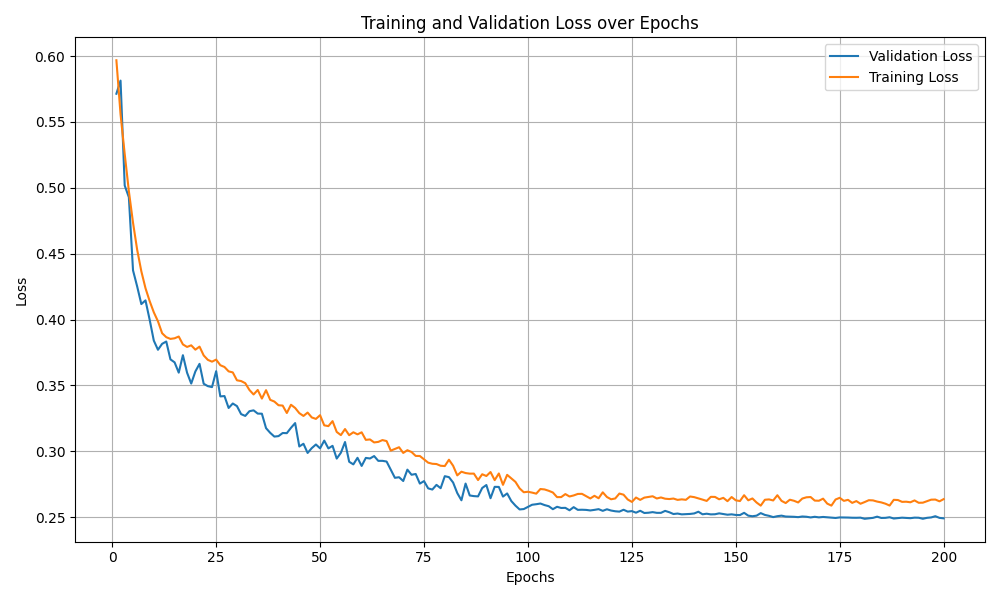

In [14]:
plot_training(N_EPOCHS+1, train_losses, val_losses, title='fcn_training.png')

![figures/fcn_training.png](figures/fcn_training.png)

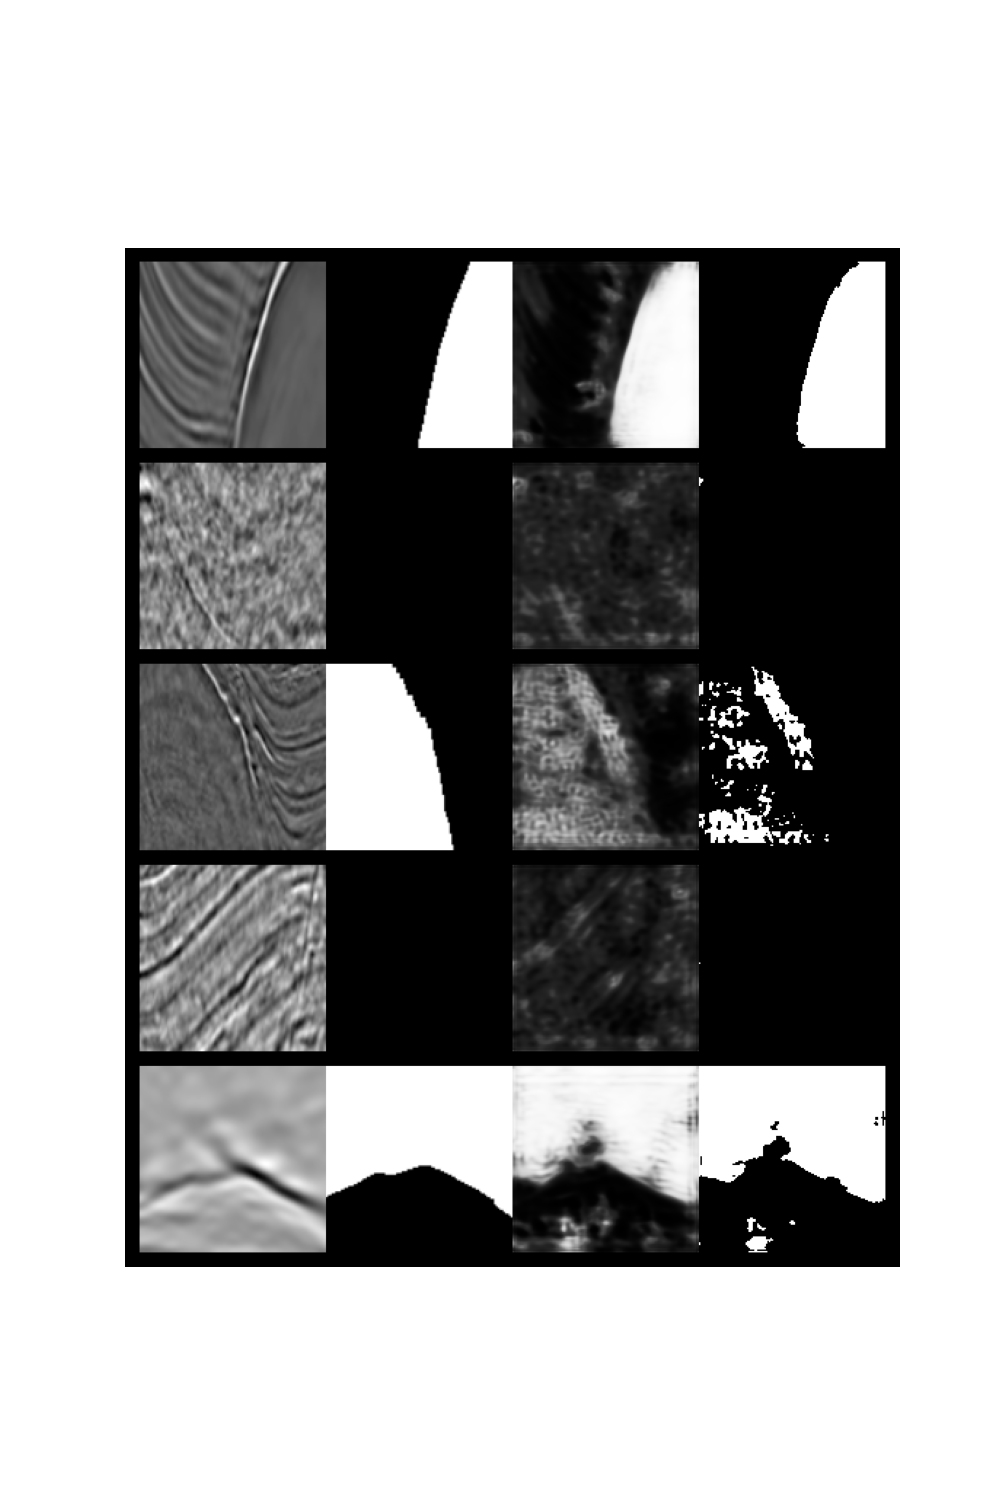

In [19]:
predictions(trained_fcn, dataloaders['val'], 'validation_predictions_fcn.png')

![figures/validation_predictions_fcn.png](figures/validation_predictions_fcn.png)

#### 5.4 Threshold for inference

> A classical metric that optimizes both precision and recall in our case is the Intersection over Union (IoU).   
> To determine the optimal threshold, we can simply make a grid search over the thresholds, and choose the one that gets the best IoU on the validation set. <br>

In [3]:
UNet = UNet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
UNet.to(device)

UNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_siz

In [4]:
UNet.load_state_dict(torch.load('./model/trained_unet_1.pt'))

<All keys matched successfully>

In [137]:
BATCH_SIZE = 64
dataloaders, dataset_sizes = get_data_loader(path_train_images, path_train_masks, path_val_images, path_val_masks, BATCH_SIZE)

In [93]:
def compute_IoU(masks, outputs):
    """ Return IoU of masks and outputs.
    
    When union is 0, it returns 1.
    Since intersection C union, I = 0 if union = 0. 
    In that case the output is correct that's why 1 is returned.
    """
    intersection = torch.sum(masks & outputs, dim=(1,2,3))
    union = torch.sum(masks | outputs, dim=(1,2,3))
    IoU = torch.where(union == 0, torch.tensor(1), intersection / union)
    return IoU.sum()

In [130]:
def get_precision_recall(masks, outputs):
    TP = torch.sum(torch.where((masks == 1) & (outputs == 1), torch.tensor(1), torch.tensor(0)), dim=(1,2,3))
    FP = torch.sum(torch.where((masks == 0) & (outputs == 1), torch.tensor(1), torch.tensor(0)), dim=(1,2,3))
    FN = torch.sum(torch.where((masks == 1) & (outputs == 0), torch.tensor(1), torch.tensor(0)), dim=(1,2,3))
    precision = torch.where(TP+FP == 0, torch.tensor(1), TP/(TP+FP)).sum()
    recall = torch.where(TP+FN == 0, torch.tensor(1), TP/(TP+FN)).sum()
    return precision, recall

In [ ]:
import numpy as np 
list_IoU = []
list_precision = []
list_recall = []
thresholds = [i/100 for i in range(30, 91)]
with torch.no_grad():    
    for threshold in thresholds:
        IoU = 0
        precision = 0 
        recall = 0 
        for inputs, masks in dataloaders['val']:
            masks = masks.to(device).bool()
            inputs = inputs.to(device)
            outputs = UNet(inputs) 
            outputs = torch.where(outputs > threshold, 1., 0.).bool()
            IoU += compute_IoU(masks, outputs)
            p, r = get_precision_recall(masks, outputs)
            precision += p 
            recall += r 
        list_IoU.append(IoU / dataset_sizes['val'])
        list_precision.append(precision / dataset_sizes['val'] )
        list_recall.append(recall / dataset_sizes['val'] )
        print(f't = {threshold}, IoU = {list_IoU[-1]:.3f}, precision = {list_precision[-1]:.3f}, recall = {list_recall[-1]:.3f}')

In [152]:
list_precision = [x.item() for x in list_precision]
list_recall = [x.item() for x in list_recall]
list_IoU = [x.item() for x in list_IoU]

In [ ]:
plt.figure()
plt.plot(thresholds, list_precision, label='Precision')
plt.plot(thresholds, list_recall, label='Recall')
plt.plot(thresholds, list_IoU, label='IoU')

plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision, Recall, and IoU vs. Threshold')
plt.legend()

plt.grid(True)
plt.savefig('IoU_plot.png')
plt.show()

![figures/IoU_plot.png](figures/IoU_plot.png)

In [159]:
best_index = max((x,i) for i,x in enumerate(list_IoU))[1]
best_IoU, best_precision, best_recall = list_IoU[best_index], list_precision[best_index], list_recall[best_index]

In [168]:
print(f'Best IoU: {best_IoU:.3f}\nPrecision for best IoU: {best_precision:.3f}\nRecall for best IoU: {best_recall:.3f}\nThreshold: {thresholds[best_index]}')

Best IoU: 0.712
Precision for best IoU: 0.945
Recall for best IoU: 0.753
Threshold: 0.69


> With this method, the best threshold is 0.69. <br>
> A few predictions with this threshold can be made.

In [ ]:
inputs, masks = next(iter(dataloaders['val']))
masks = masks.to(device)
masks_rgb = masks.repeat(1, 3, 1, 1)
inputs = inputs.to(device)
outputs = UNet(inputs)
n = 5

outputs_binary = torch.where(outputs > thresholds[best_index], 1., 0.).repeat(1, 3, 1, 1)
outputs = outputs.repeat(1, 3, 1, 1)
# Concatenate the images along the width dimension to create a single tensor
combined_images = torch.cat([inputs[0:n,:,:,:], masks_rgb[0:n,:,:,:], outputs[0:n,:,:,:], outputs_binary[0:n,:,:,:]], dim=3)
# Make a grid with the combined images
grid_image = torchvision.utils.make_grid(combined_images, nrow=1, padding=10, normalize=True)
# Convert the grid tensor to a numpy array for visualization
grid_image_np = grid_image.permute(1, 2, 0).cpu().numpy()
# Display the grid of images
plt.figure(figsize=(10, 15))
plt.imshow(grid_image_np)

plt.axis('off')
plt.show()
plt.savefig(f'figures/best_threshold_outputs.png')

![figures/best_threshold_outputs.png](figures/best_threshold_outputs.png)